In [1]:
import numpy as np
import  matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,BatchNormalization,MaxPooling2D
from tensorflow.keras.initializers import he_uniform,he_normal
from tensorflow.keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator,array_to_img
from tensorflow.keras.activations import relu
import skimage
from skimage import io
from skimage import data

In [2]:
path_train=r'I:\dl_exams\DL Paper 1\Datasets\CNN\Shoe Classification\train'

##For visulization of images !!
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".jpg")]
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(d)
            
    return images, labels


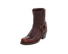

shape: (102, 136, 3), min: 0, max: 255


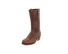

shape: (102, 136, 3), min: 0, max: 255


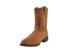

shape: (102, 136, 3), min: 0, max: 255


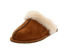

shape: (102, 136, 3), min: 0, max: 255


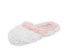

shape: (102, 136, 3), min: 109, max: 255


In [3]:
images,labels=load_data(path_train)
#PLOTTING RANDOM IMAGES TO INSPECT THE DIMENSIONS OF EACH IMAGE
from numpy.random import randint
np.random.seed(1)
values=randint(0,len(images),5)
#visualize images randomly
for i in range(len(values)):
    plt.subplot(1,5,i+1)
    plt.axis('off')
    plt.imshow(images[values[i]])
    plt.subplots_adjust(wspace=0.3)
    #plt.title(labels[values[i]])
    plt.show()
    print("shape: {0}, min: {1}, max: {2}".format(images[values[i]].shape, 
                                                  images[values[i]].min(), 
                                                  images[values[i]].max()))

In [4]:
train_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,zoom_range=[0.5, 1.5],channel_shift_range=150.0)   
train_generator = train_datagen.flow_from_directory(directory=path_train,
                                                            target_size=(80,80),
                                                            color_mode="grayscale",
                                                            batch_size=64,
                                                            class_mode="sparse",
                                                            subset='training',
                                                            shuffle=True,
                                                            seed=42)


Found 623 images belonging to 3 classes.


In [5]:
validation_generator = train_datagen.flow_from_directory(
        directory=path_train,
        target_size=(80,80),
        batch_size=64,
        color_mode="grayscale",
        class_mode='sparse',
        subset='validation') 


Found 155 images belonging to 3 classes.


In [6]:
import kerastuner as kt
def my_model(hp):
    

    model=Sequential()
    weights=hp.Choice('weights',['he_uniform','he_normal'])
    num_block=hp.Int('num_block',min_value=1,max_value=4,step=1)
    num_filters=hp.Int('num_filters',min_value=32,max_value=128,step=32)
    model.add(Conv2D(num_filters,kernel_size=(3,3),padding='same',kernel_initializer=weights,activation='relu',input_shape=(80,80,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    for i in range(1,num_block):
        model.add(Conv2D(num_filters,(3,3),padding='same',kernel_initializer=weights,activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Flatten())
    model.add(Dense(units=hp.Int('num_dense_units',min_value=32,max_value=256,step=32),activation='relu',kernel_initializer=weights))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dense_dropout',min_value=0.,max_value=0.5,step=0.2)))
    model.add(Dense(units=hp.Int('num_dense_units_2',min_value=32,max_value=56,step=12),activation='relu',kernel_initializer=weights))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dense_dropout_2',min_value=0.,max_value=0.3,step=0.1)))
    model.add(Dense(3,activation='softmax'))
    learning_rate=hp.Float('learning_rate',min_value=3e-4,max_value=3e-1)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    return model

#callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, baseline=0.9)]
tuner=kt.tuners.RandomSearch(my_model,objective='val_accuracy',max_trials=20,executions_per_trial=1,overwrite=True)


In [7]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_accuracy"]
        if accuracy >= self.threshold:
            self.model.stop_training = True
callback=MyThresholdCallback(threshold=0.9)
batch_size=64
epochs=45
tuner.search(train_generator,epochs=epochs,batch_size=batch_size,verbose=2,validation_data=validation_generator,callbacks=[callback])

Epoch 1/45
10/10 - 2s - loss: 2.3450 - accuracy: 0.4398 - val_loss: 23058.2988 - val_accuracy: 0.4194
Epoch 2/45
10/10 - 1s - loss: 1.1777 - accuracy: 0.5570 - val_loss: 850.5995 - val_accuracy: 0.3484
Epoch 3/45
10/10 - 1s - loss: 1.3602 - accuracy: 0.5602 - val_loss: 109.6394 - val_accuracy: 0.4452
Epoch 4/45
10/10 - 1s - loss: 0.9955 - accuracy: 0.5795 - val_loss: 273.3417 - val_accuracy: 0.3355
Epoch 5/45
10/10 - 1s - loss: 0.7445 - accuracy: 0.6645 - val_loss: 845.3974 - val_accuracy: 0.4065
Epoch 6/45
10/10 - 1s - loss: 0.6871 - accuracy: 0.6790 - val_loss: 570.8043 - val_accuracy: 0.4194
Epoch 7/45
10/10 - 2s - loss: 0.6580 - accuracy: 0.6918 - val_loss: 379.7539 - val_accuracy: 0.4516
Epoch 8/45
10/10 - 1s - loss: 0.6402 - accuracy: 0.7014 - val_loss: 863.9445 - val_accuracy: 0.4645
Epoch 9/45
10/10 - 2s - loss: 0.5315 - accuracy: 0.7689 - val_loss: 1067.8812 - val_accuracy: 0.5161
Epoch 10/45
10/10 - 1s - loss: 0.5303 - accuracy: 0.7368 - val_loss: 1672.4431 - val_accuracy: 0.

Epoch 1/45
10/10 - 1s - loss: 1.4021 - accuracy: 0.4446 - val_loss: 697.7319 - val_accuracy: 0.2065
Epoch 2/45
10/10 - 1s - loss: 1.0166 - accuracy: 0.5425 - val_loss: 726.0392 - val_accuracy: 0.1871
Epoch 3/45
10/10 - 1s - loss: 0.8564 - accuracy: 0.6035 - val_loss: 657.2538 - val_accuracy: 0.3935
Epoch 4/45
10/10 - 1s - loss: 0.7463 - accuracy: 0.6517 - val_loss: 331.9025 - val_accuracy: 0.3871
Epoch 5/45
10/10 - 1s - loss: 0.6987 - accuracy: 0.6774 - val_loss: 141.1334 - val_accuracy: 0.3935
Epoch 6/45
10/10 - 1s - loss: 0.6661 - accuracy: 0.6998 - val_loss: 187.6309 - val_accuracy: 0.3935
Epoch 7/45
10/10 - 1s - loss: 0.6089 - accuracy: 0.7255 - val_loss: 32.4513 - val_accuracy: 0.3355
Epoch 8/45
10/10 - 1s - loss: 0.5849 - accuracy: 0.7384 - val_loss: 36.4746 - val_accuracy: 0.3935
Epoch 9/45
10/10 - 1s - loss: 0.5206 - accuracy: 0.7705 - val_loss: 51.2523 - val_accuracy: 0.3935
Epoch 10/45
10/10 - 1s - loss: 0.5542 - accuracy: 0.7705 - val_loss: 38.9154 - val_accuracy: 0.3935
Epo

Epoch 1/45
10/10 - 3s - loss: 1.5862 - accuracy: 0.4254 - val_loss: 594.0006 - val_accuracy: 0.3677
Epoch 2/45
10/10 - 2s - loss: 1.0890 - accuracy: 0.4510 - val_loss: 652.2299 - val_accuracy: 0.3935
Epoch 3/45
10/10 - 1s - loss: 0.8125 - accuracy: 0.6388 - val_loss: 674.2431 - val_accuracy: 0.2452
Epoch 4/45
10/10 - 1s - loss: 0.7222 - accuracy: 0.6693 - val_loss: 550.5865 - val_accuracy: 0.1871
Epoch 5/45
10/10 - 1s - loss: 0.6950 - accuracy: 0.6806 - val_loss: 273.0787 - val_accuracy: 0.1871
Epoch 6/45
10/10 - 1s - loss: 0.6294 - accuracy: 0.6806 - val_loss: 130.1488 - val_accuracy: 0.2129
Epoch 7/45
10/10 - 2s - loss: 0.6793 - accuracy: 0.6950 - val_loss: 58.7358 - val_accuracy: 0.4194
Epoch 8/45
10/10 - 1s - loss: 0.6541 - accuracy: 0.6870 - val_loss: 36.9303 - val_accuracy: 0.4194
Epoch 9/45
10/10 - 2s - loss: 0.6294 - accuracy: 0.7143 - val_loss: 16.5281 - val_accuracy: 0.4323
Epoch 10/45
10/10 - 2s - loss: 0.6183 - accuracy: 0.7127 - val_loss: 11.6526 - val_accuracy: 0.5613
Epo

Epoch 1/45
10/10 - 2s - loss: 1.1300 - accuracy: 0.5441 - val_loss: 3257.8591 - val_accuracy: 0.3935
Epoch 2/45
10/10 - 1s - loss: 0.8590 - accuracy: 0.5666 - val_loss: 161.7828 - val_accuracy: 0.3871
Epoch 3/45
10/10 - 1s - loss: 0.6696 - accuracy: 0.7159 - val_loss: 100.2423 - val_accuracy: 0.2903
Epoch 4/45
10/10 - 1s - loss: 0.6486 - accuracy: 0.7255 - val_loss: 20.1989 - val_accuracy: 0.2065
Epoch 5/45
10/10 - 1s - loss: 0.6052 - accuracy: 0.7143 - val_loss: 62.5209 - val_accuracy: 0.3935
Epoch 6/45
10/10 - 1s - loss: 0.7300 - accuracy: 0.6661 - val_loss: 2.9854 - val_accuracy: 0.4129
Epoch 7/45
10/10 - 1s - loss: 0.6598 - accuracy: 0.6918 - val_loss: 3.9081 - val_accuracy: 0.4452
Epoch 8/45
10/10 - 1s - loss: 0.6471 - accuracy: 0.7143 - val_loss: 6.9755 - val_accuracy: 0.2000
Epoch 9/45
10/10 - 1s - loss: 0.5898 - accuracy: 0.7432 - val_loss: 4.2841 - val_accuracy: 0.4065
Epoch 10/45
10/10 - 1s - loss: 0.5237 - accuracy: 0.7721 - val_loss: 3.7206 - val_accuracy: 0.2000
Epoch 11/4

Epoch 1/45
10/10 - 2s - loss: 1.4063 - accuracy: 0.3852 - val_loss: 3166.8645 - val_accuracy: 0.4000
Epoch 2/45
10/10 - 1s - loss: 1.0922 - accuracy: 0.4270 - val_loss: 2162.9080 - val_accuracy: 0.3935
Epoch 3/45
10/10 - 2s - loss: 1.0469 - accuracy: 0.4494 - val_loss: 839.4276 - val_accuracy: 0.4258
Epoch 4/45
10/10 - 1s - loss: 0.8771 - accuracy: 0.5859 - val_loss: 302.7695 - val_accuracy: 0.4129
Epoch 5/45
10/10 - 1s - loss: 0.7356 - accuracy: 0.6677 - val_loss: 165.4187 - val_accuracy: 0.3032
Epoch 6/45
10/10 - 1s - loss: 0.7300 - accuracy: 0.6613 - val_loss: 37.5421 - val_accuracy: 0.4194
Epoch 7/45
10/10 - 1s - loss: 0.6573 - accuracy: 0.6918 - val_loss: 45.0118 - val_accuracy: 0.5419
Epoch 8/45
10/10 - 1s - loss: 0.6243 - accuracy: 0.7143 - val_loss: 10.3679 - val_accuracy: 0.6129
Epoch 9/45
10/10 - 1s - loss: 0.6164 - accuracy: 0.7319 - val_loss: 5.5445 - val_accuracy: 0.6387
Epoch 10/45
10/10 - 1s - loss: 0.5847 - accuracy: 0.7512 - val_loss: 13.6106 - val_accuracy: 0.7097
Epo

Epoch 1/45
10/10 - 2s - loss: 1.1331 - accuracy: 0.5281 - val_loss: 300.0921 - val_accuracy: 0.3935
Epoch 2/45
10/10 - 1s - loss: 0.7445 - accuracy: 0.6806 - val_loss: 117.8943 - val_accuracy: 0.2129
Epoch 3/45
10/10 - 1s - loss: 0.6443 - accuracy: 0.7159 - val_loss: 36.3747 - val_accuracy: 0.2452
Epoch 4/45
10/10 - 1s - loss: 0.6125 - accuracy: 0.7287 - val_loss: 16.1857 - val_accuracy: 0.2516
Epoch 5/45
10/10 - 1s - loss: 0.5493 - accuracy: 0.7640 - val_loss: 7.1459 - val_accuracy: 0.3161
Epoch 6/45
10/10 - 1s - loss: 0.5037 - accuracy: 0.7737 - val_loss: 5.2833 - val_accuracy: 0.3032
Epoch 7/45
10/10 - 1s - loss: 0.4422 - accuracy: 0.8026 - val_loss: 1.3451 - val_accuracy: 0.6516
Epoch 8/45
10/10 - 1s - loss: 0.4762 - accuracy: 0.8074 - val_loss: 0.9866 - val_accuracy: 0.6323
Epoch 9/45
10/10 - 1s - loss: 0.4163 - accuracy: 0.8459 - val_loss: 0.6628 - val_accuracy: 0.7097
Epoch 10/45
10/10 - 1s - loss: 0.3740 - accuracy: 0.8636 - val_loss: 0.7306 - val_accuracy: 0.7032
Epoch 11/45
1

Epoch 1/45
10/10 - 2s - loss: 1.5827 - accuracy: 0.4286 - val_loss: 1485.7831 - val_accuracy: 0.4194
Epoch 2/45
10/10 - 1s - loss: 1.0697 - accuracy: 0.5040 - val_loss: 517.6521 - val_accuracy: 0.4194
Epoch 3/45
10/10 - 1s - loss: 0.9249 - accuracy: 0.5441 - val_loss: 588.8607 - val_accuracy: 0.4194
Epoch 4/45
10/10 - 1s - loss: 0.8274 - accuracy: 0.6132 - val_loss: 754.3894 - val_accuracy: 0.4194
Epoch 5/45
10/10 - 1s - loss: 0.7987 - accuracy: 0.6276 - val_loss: 168.5234 - val_accuracy: 0.4194
Epoch 6/45
10/10 - 2s - loss: 0.7447 - accuracy: 0.6485 - val_loss: 135.8407 - val_accuracy: 0.4258
Epoch 7/45
10/10 - 2s - loss: 0.7318 - accuracy: 0.6693 - val_loss: 132.2011 - val_accuracy: 0.4387
Epoch 8/45
10/10 - 1s - loss: 0.6635 - accuracy: 0.6726 - val_loss: 58.5813 - val_accuracy: 0.4387
Epoch 9/45
10/10 - 1s - loss: 0.6265 - accuracy: 0.7255 - val_loss: 41.1160 - val_accuracy: 0.4323
Epoch 10/45
10/10 - 1s - loss: 0.7235 - accuracy: 0.6806 - val_loss: 60.5306 - val_accuracy: 0.4258
E

Epoch 1/45
10/10 - 1s - loss: 1.2374 - accuracy: 0.5297 - val_loss: 161.5659 - val_accuracy: 0.3935
Epoch 2/45
10/10 - 1s - loss: 0.8154 - accuracy: 0.6485 - val_loss: 42.3727 - val_accuracy: 0.4645
Epoch 3/45
10/10 - 1s - loss: 0.6617 - accuracy: 0.7014 - val_loss: 55.6811 - val_accuracy: 0.3935
Epoch 4/45
10/10 - 1s - loss: 0.6220 - accuracy: 0.7432 - val_loss: 21.8895 - val_accuracy: 0.3935
Epoch 5/45
10/10 - 1s - loss: 0.5314 - accuracy: 0.7560 - val_loss: 22.5825 - val_accuracy: 0.3871
Epoch 6/45
10/10 - 1s - loss: 0.5102 - accuracy: 0.7833 - val_loss: 19.0168 - val_accuracy: 0.3935
Epoch 7/45
10/10 - 1s - loss: 0.4868 - accuracy: 0.7978 - val_loss: 9.6232 - val_accuracy: 0.4194
Epoch 8/45
10/10 - 1s - loss: 0.4860 - accuracy: 0.7881 - val_loss: 3.6185 - val_accuracy: 0.4774
Epoch 9/45
10/10 - 1s - loss: 0.5065 - accuracy: 0.7785 - val_loss: 3.5511 - val_accuracy: 0.4710
Epoch 10/45
10/10 - 1s - loss: 0.4954 - accuracy: 0.7978 - val_loss: 2.2467 - val_accuracy: 0.5290
Epoch 11/45


Epoch 1/45
10/10 - 1s - loss: 1.7460 - accuracy: 0.4173 - val_loss: 3153.5554 - val_accuracy: 0.2903
Epoch 2/45
10/10 - 1s - loss: 1.0465 - accuracy: 0.5120 - val_loss: 5434.7388 - val_accuracy: 0.3935
Epoch 3/45
10/10 - 1s - loss: 0.9807 - accuracy: 0.5859 - val_loss: 1239.4053 - val_accuracy: 0.3935
Epoch 4/45
10/10 - 1s - loss: 0.8328 - accuracy: 0.6116 - val_loss: 133.0744 - val_accuracy: 0.3419
Epoch 5/45
10/10 - 1s - loss: 0.7360 - accuracy: 0.6308 - val_loss: 63.7753 - val_accuracy: 0.1871
Epoch 6/45
10/10 - 1s - loss: 0.7035 - accuracy: 0.6790 - val_loss: 95.8155 - val_accuracy: 0.3935
Epoch 7/45
10/10 - 1s - loss: 0.6179 - accuracy: 0.7030 - val_loss: 65.9959 - val_accuracy: 0.3935
Epoch 8/45
10/10 - 1s - loss: 0.6046 - accuracy: 0.7223 - val_loss: 42.4348 - val_accuracy: 0.3935
Epoch 9/45
10/10 - 1s - loss: 0.6037 - accuracy: 0.7416 - val_loss: 33.4460 - val_accuracy: 0.3935
Epoch 10/45
10/10 - 1s - loss: 0.6606 - accuracy: 0.7111 - val_loss: 22.7064 - val_accuracy: 0.3935
Ep

Epoch 1/45
10/10 - 5s - loss: 1.8961 - accuracy: 0.4575 - val_loss: 391.9177 - val_accuracy: 0.4194
Epoch 2/45
10/10 - 1s - loss: 1.2079 - accuracy: 0.4928 - val_loss: 133.3716 - val_accuracy: 0.4194
Epoch 3/45
10/10 - 5s - loss: 0.9613 - accuracy: 0.5875 - val_loss: 41.8430 - val_accuracy: 0.5161
Epoch 4/45
10/10 - 5s - loss: 0.7475 - accuracy: 0.6324 - val_loss: 10.1584 - val_accuracy: 0.6129
Epoch 5/45
10/10 - 1s - loss: 0.7156 - accuracy: 0.6501 - val_loss: 38.0022 - val_accuracy: 0.3161
Epoch 6/45
10/10 - 1s - loss: 0.7044 - accuracy: 0.6661 - val_loss: 8.6815 - val_accuracy: 0.3742
Epoch 7/45
10/10 - 1s - loss: 0.7188 - accuracy: 0.6613 - val_loss: 12.2929 - val_accuracy: 0.5355
Epoch 8/45
10/10 - 1s - loss: 0.6298 - accuracy: 0.7143 - val_loss: 10.3102 - val_accuracy: 0.5677
Epoch 9/45
10/10 - 1s - loss: 0.6133 - accuracy: 0.7384 - val_loss: 3.7976 - val_accuracy: 0.5613
Epoch 10/45
10/10 - 1s - loss: 0.5891 - accuracy: 0.7400 - val_loss: 3.8525 - val_accuracy: 0.4839
Epoch 11/4

Epoch 1/45
10/10 - 2s - loss: 1.5254 - accuracy: 0.4366 - val_loss: 104.1605 - val_accuracy: 0.4194
Epoch 2/45
10/10 - 1s - loss: 0.9226 - accuracy: 0.5923 - val_loss: 87.9704 - val_accuracy: 0.4194
Epoch 3/45
10/10 - 2s - loss: 0.7552 - accuracy: 0.6709 - val_loss: 11.9942 - val_accuracy: 0.4710
Epoch 4/45
10/10 - 2s - loss: 0.6615 - accuracy: 0.6918 - val_loss: 10.9799 - val_accuracy: 0.4839
Epoch 5/45
10/10 - 2s - loss: 0.6241 - accuracy: 0.7047 - val_loss: 9.4570 - val_accuracy: 0.5226
Epoch 6/45
10/10 - 2s - loss: 0.6197 - accuracy: 0.7223 - val_loss: 0.9243 - val_accuracy: 0.7290
Epoch 7/45
10/10 - 1s - loss: 0.5783 - accuracy: 0.7592 - val_loss: 9.6109 - val_accuracy: 0.4516
Epoch 8/45
10/10 - 1s - loss: 0.5214 - accuracy: 0.7640 - val_loss: 1.7465 - val_accuracy: 0.6581
Epoch 9/45
10/10 - 2s - loss: 0.5352 - accuracy: 0.7721 - val_loss: 1.2714 - val_accuracy: 0.7355
Epoch 10/45
10/10 - 1s - loss: 0.5454 - accuracy: 0.7657 - val_loss: 3.6376 - val_accuracy: 0.5677
Epoch 11/45
10

Epoch 1/45
10/10 - 4s - loss: 1.4421 - accuracy: 0.4302 - val_loss: 54.3042 - val_accuracy: 0.4258
Epoch 2/45
10/10 - 1s - loss: 0.9634 - accuracy: 0.5714 - val_loss: 12.0650 - val_accuracy: 0.4194
Epoch 3/45
10/10 - 4s - loss: 0.8429 - accuracy: 0.5907 - val_loss: 31.0910 - val_accuracy: 0.4387
Epoch 4/45
10/10 - 4s - loss: 0.7213 - accuracy: 0.6613 - val_loss: 15.3706 - val_accuracy: 0.4968
Epoch 5/45
10/10 - 1s - loss: 0.6747 - accuracy: 0.6742 - val_loss: 7.2914 - val_accuracy: 0.4903
Epoch 6/45
10/10 - 1s - loss: 0.6796 - accuracy: 0.6774 - val_loss: 6.9494 - val_accuracy: 0.4065
Epoch 7/45
10/10 - 4s - loss: 0.6398 - accuracy: 0.7014 - val_loss: 2.1998 - val_accuracy: 0.5613
Epoch 8/45
10/10 - 4s - loss: 0.6260 - accuracy: 0.7352 - val_loss: 2.8171 - val_accuracy: 0.5742
Epoch 9/45
10/10 - 4s - loss: 0.6501 - accuracy: 0.6870 - val_loss: 1.1627 - val_accuracy: 0.5806
Epoch 10/45
10/10 - 4s - loss: 0.6332 - accuracy: 0.7159 - val_loss: 1.2538 - val_accuracy: 0.6258
Epoch 11/45
10/

Epoch 1/45
10/10 - 1s - loss: 1.6093 - accuracy: 0.4623 - val_loss: 18800.1543 - val_accuracy: 0.4194
Epoch 2/45
10/10 - 1s - loss: 1.0829 - accuracy: 0.5104 - val_loss: 6652.9243 - val_accuracy: 0.1871
Epoch 3/45
10/10 - 1s - loss: 0.9549 - accuracy: 0.5698 - val_loss: 1425.7146 - val_accuracy: 0.2194
Epoch 4/45
10/10 - 1s - loss: 0.7433 - accuracy: 0.6549 - val_loss: 1213.7949 - val_accuracy: 0.3935
Epoch 5/45
10/10 - 1s - loss: 0.7931 - accuracy: 0.6196 - val_loss: 1066.3853 - val_accuracy: 0.4258
Epoch 6/45
10/10 - 1s - loss: 0.6660 - accuracy: 0.7063 - val_loss: 229.9864 - val_accuracy: 0.4323
Epoch 7/45
10/10 - 1s - loss: 0.7196 - accuracy: 0.6742 - val_loss: 39.8673 - val_accuracy: 0.4452
Epoch 8/45
10/10 - 1s - loss: 0.6534 - accuracy: 0.6838 - val_loss: 17.1253 - val_accuracy: 0.5484
Epoch 9/45
10/10 - 1s - loss: 0.6450 - accuracy: 0.7207 - val_loss: 87.9358 - val_accuracy: 0.3742
Epoch 10/45
10/10 - 1s - loss: 0.6691 - accuracy: 0.6966 - val_loss: 18.7120 - val_accuracy: 0.54

Epoch 1/45
10/10 - 1s - loss: 1.9550 - accuracy: 0.4526 - val_loss: 51672.9375 - val_accuracy: 0.1871
Epoch 2/45
10/10 - 1s - loss: 1.2902 - accuracy: 0.5297 - val_loss: 41488.9297 - val_accuracy: 0.3290
Epoch 3/45
10/10 - 1s - loss: 1.0228 - accuracy: 0.5409 - val_loss: 5031.5430 - val_accuracy: 0.3935
Epoch 4/45
10/10 - 1s - loss: 0.9643 - accuracy: 0.5778 - val_loss: 17487.3164 - val_accuracy: 0.2516
Epoch 5/45
10/10 - 1s - loss: 0.8849 - accuracy: 0.5955 - val_loss: 8315.0732 - val_accuracy: 0.3548
Epoch 6/45
10/10 - 1s - loss: 0.7640 - accuracy: 0.6565 - val_loss: 2195.6899 - val_accuracy: 0.3419
Epoch 7/45
10/10 - 1s - loss: 0.8369 - accuracy: 0.6276 - val_loss: 2081.6816 - val_accuracy: 0.3548
Epoch 8/45
10/10 - 1s - loss: 0.7846 - accuracy: 0.6453 - val_loss: 1979.0010 - val_accuracy: 0.3290
Epoch 9/45
10/10 - 1s - loss: 0.7446 - accuracy: 0.6597 - val_loss: 1886.8237 - val_accuracy: 0.2194
Epoch 10/45
10/10 - 1s - loss: 0.8137 - accuracy: 0.6469 - val_loss: 686.9324 - val_accu

Epoch 1/45
10/10 - 2s - loss: 1.6296 - accuracy: 0.4446 - val_loss: 1729.7982 - val_accuracy: 0.4000
Epoch 2/45
10/10 - 1s - loss: 1.1219 - accuracy: 0.4960 - val_loss: 224.6266 - val_accuracy: 0.3613
Epoch 3/45
10/10 - 1s - loss: 0.8820 - accuracy: 0.5795 - val_loss: 52.9707 - val_accuracy: 0.4645
Epoch 4/45
10/10 - 1s - loss: 0.7498 - accuracy: 0.6421 - val_loss: 76.2964 - val_accuracy: 0.2645
Epoch 5/45
10/10 - 1s - loss: 0.7274 - accuracy: 0.6693 - val_loss: 131.5941 - val_accuracy: 0.4065
Epoch 6/45
10/10 - 1s - loss: 0.7023 - accuracy: 0.6726 - val_loss: 96.8063 - val_accuracy: 0.2516
Epoch 7/45
10/10 - 1s - loss: 0.6485 - accuracy: 0.7127 - val_loss: 50.2464 - val_accuracy: 0.3355
Epoch 8/45
10/10 - 1s - loss: 0.6666 - accuracy: 0.7063 - val_loss: 202.0708 - val_accuracy: 0.4258
Epoch 9/45
10/10 - 1s - loss: 0.6702 - accuracy: 0.6918 - val_loss: 66.5911 - val_accuracy: 0.2645
Epoch 10/45
10/10 - 1s - loss: 0.5991 - accuracy: 0.7352 - val_loss: 16.5631 - val_accuracy: 0.4065
Epoc

Epoch 1/45
10/10 - 1s - loss: 2.0095 - accuracy: 0.3868 - val_loss: 3218.0955 - val_accuracy: 0.2645
Epoch 2/45
10/10 - 1s - loss: 1.2819 - accuracy: 0.4960 - val_loss: 3638.7588 - val_accuracy: 0.2194
Epoch 3/45
10/10 - 1s - loss: 1.3557 - accuracy: 0.3933 - val_loss: 18817.4863 - val_accuracy: 0.1871
Epoch 4/45
10/10 - 1s - loss: 1.1449 - accuracy: 0.4735 - val_loss: 729.5833 - val_accuracy: 0.3935
Epoch 5/45
10/10 - 1s - loss: 1.0127 - accuracy: 0.5441 - val_loss: 669.2402 - val_accuracy: 0.4194
Epoch 6/45
10/10 - 1s - loss: 0.8501 - accuracy: 0.5795 - val_loss: 62.7378 - val_accuracy: 0.4581
Epoch 7/45
10/10 - 1s - loss: 0.7939 - accuracy: 0.6292 - val_loss: 14.4611 - val_accuracy: 0.4903
Epoch 8/45
10/10 - 1s - loss: 0.6380 - accuracy: 0.7047 - val_loss: 12.4485 - val_accuracy: 0.4839
Epoch 9/45
10/10 - 1s - loss: 0.6634 - accuracy: 0.6982 - val_loss: 14.8698 - val_accuracy: 0.4129
Epoch 10/45
10/10 - 1s - loss: 0.6643 - accuracy: 0.7303 - val_loss: 3.0896 - val_accuracy: 0.6000
E

Epoch 1/45
10/10 - 1s - loss: 1.8805 - accuracy: 0.3981 - val_loss: 121224.6875 - val_accuracy: 0.1871
Epoch 2/45
10/10 - 1s - loss: 1.2417 - accuracy: 0.4414 - val_loss: 56494.4766 - val_accuracy: 0.4194
Epoch 3/45
10/10 - 1s - loss: 1.1227 - accuracy: 0.4912 - val_loss: 4349.7163 - val_accuracy: 0.2968
Epoch 4/45
10/10 - 1s - loss: 0.9549 - accuracy: 0.5570 - val_loss: 18283.4805 - val_accuracy: 0.4194
Epoch 5/45
10/10 - 1s - loss: 0.8453 - accuracy: 0.6019 - val_loss: 11851.0811 - val_accuracy: 0.4194
Epoch 6/45
10/10 - 1s - loss: 0.7999 - accuracy: 0.6308 - val_loss: 2336.5525 - val_accuracy: 0.4194
Epoch 7/45
10/10 - 1s - loss: 0.7378 - accuracy: 0.6902 - val_loss: 1082.8060 - val_accuracy: 0.4065
Epoch 8/45
10/10 - 1s - loss: 0.7401 - accuracy: 0.6645 - val_loss: 917.7319 - val_accuracy: 0.4000
Epoch 9/45
10/10 - 1s - loss: 0.7124 - accuracy: 0.6645 - val_loss: 970.0523 - val_accuracy: 0.4258
Epoch 10/45
10/10 - 1s - loss: 0.7123 - accuracy: 0.6838 - val_loss: 260.6618 - val_accu

Epoch 1/45
10/10 - 2s - loss: 1.3526 - accuracy: 0.4510 - val_loss: 507.7849 - val_accuracy: 0.4194
Epoch 2/45
10/10 - 1s - loss: 0.9265 - accuracy: 0.5795 - val_loss: 404.2314 - val_accuracy: 0.4194
Epoch 3/45
10/10 - 1s - loss: 0.7831 - accuracy: 0.6164 - val_loss: 79.9198 - val_accuracy: 0.4194
Epoch 4/45
10/10 - 1s - loss: 0.6675 - accuracy: 0.6966 - val_loss: 19.2124 - val_accuracy: 0.4710
Epoch 5/45
10/10 - 1s - loss: 0.6600 - accuracy: 0.6934 - val_loss: 19.0908 - val_accuracy: 0.4774
Epoch 6/45
10/10 - 1s - loss: 0.6791 - accuracy: 0.6726 - val_loss: 55.9880 - val_accuracy: 0.3355
Epoch 7/45
10/10 - 1s - loss: 0.5807 - accuracy: 0.7287 - val_loss: 19.7383 - val_accuracy: 0.4968
Epoch 8/45
10/10 - 1s - loss: 0.6375 - accuracy: 0.6982 - val_loss: 12.0421 - val_accuracy: 0.5548
Epoch 9/45
10/10 - 1s - loss: 0.6080 - accuracy: 0.7416 - val_loss: 4.8059 - val_accuracy: 0.4774
Epoch 10/45
10/10 - 1s - loss: 0.6462 - accuracy: 0.6982 - val_loss: 2.5218 - val_accuracy: 0.5355
Epoch 11/

Epoch 1/45
10/10 - 2s - loss: 2.2846 - accuracy: 0.3836 - val_loss: 3994.3477 - val_accuracy: 0.3935
Epoch 2/45
10/10 - 1s - loss: 1.4819 - accuracy: 0.4350 - val_loss: 314.8350 - val_accuracy: 0.3935
Epoch 3/45
10/10 - 1s - loss: 0.9659 - accuracy: 0.5762 - val_loss: 20.7827 - val_accuracy: 0.3871
Epoch 4/45
10/10 - 2s - loss: 0.8361 - accuracy: 0.6372 - val_loss: 120.9432 - val_accuracy: 0.4194
Epoch 5/45
10/10 - 1s - loss: 0.7444 - accuracy: 0.6998 - val_loss: 81.7976 - val_accuracy: 0.1871
Epoch 6/45
10/10 - 1s - loss: 0.6990 - accuracy: 0.7063 - val_loss: 11.9635 - val_accuracy: 0.3935
Epoch 7/45
10/10 - 1s - loss: 0.6942 - accuracy: 0.7207 - val_loss: 33.2905 - val_accuracy: 0.2129
Epoch 8/45
10/10 - 2s - loss: 0.7070 - accuracy: 0.6485 - val_loss: 1.9713 - val_accuracy: 0.5871
Epoch 9/45
10/10 - 1s - loss: 0.6390 - accuracy: 0.7287 - val_loss: 6.8714 - val_accuracy: 0.4645
Epoch 10/45
10/10 - 1s - loss: 0.5839 - accuracy: 0.7368 - val_loss: 8.3806 - val_accuracy: 0.3226
Epoch 11

Epoch 1/45
10/10 - 2s - loss: 1.3939 - accuracy: 0.4430 - val_loss: 13556.9111 - val_accuracy: 0.1871
Epoch 2/45
10/10 - 2s - loss: 0.9687 - accuracy: 0.5618 - val_loss: 1143.7441 - val_accuracy: 0.3613
Epoch 3/45
10/10 - 1s - loss: 0.8115 - accuracy: 0.5859 - val_loss: 426.0380 - val_accuracy: 0.3548
Epoch 4/45
10/10 - 1s - loss: 0.6732 - accuracy: 0.6709 - val_loss: 1004.3538 - val_accuracy: 0.1871
Epoch 5/45
10/10 - 1s - loss: 0.6325 - accuracy: 0.7127 - val_loss: 542.6469 - val_accuracy: 0.1871
Epoch 6/45
10/10 - 1s - loss: 0.5556 - accuracy: 0.7624 - val_loss: 223.9821 - val_accuracy: 0.1871
Epoch 7/45
10/10 - 1s - loss: 0.5330 - accuracy: 0.7721 - val_loss: 141.0438 - val_accuracy: 0.1871
Epoch 8/45
10/10 - 1s - loss: 0.5130 - accuracy: 0.7673 - val_loss: 22.5008 - val_accuracy: 0.3871
Epoch 9/45
10/10 - 1s - loss: 0.4951 - accuracy: 0.7913 - val_loss: 31.5090 - val_accuracy: 0.1871
Epoch 10/45
10/10 - 1s - loss: 0.4846 - accuracy: 0.7961 - val_loss: 2.8983 - val_accuracy: 0.4194

INFO:tensorflow:Oracle triggered exit


### Achieved 92% accuracy on validation set

In [14]:
callback1=MyThresholdCallback(threshold=0.9)
best_hyperparameters=tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)
n_best_models=tuner.get_best_models(3)
print(n_best_models[0].summary())

{'weights': 'he_uniform', 'num_block': 3, 'num_filters': 32, 'num_dense_units': 256, 'dense_dropout': 0.2, 'num_dense_units_2': 44, 'dense_dropout_2': 0.1, 'learning_rate': 0.1239049195281074}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 32)        128       
_____________________________________________________________

In [15]:
model1=tuner.hypermodel.build(best_hyperparameters)

In [16]:
history=model1.fit(train_generator,epochs=50,batch_size=64,validation_data=validation_generator,callbacks=callback1)

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.4346 - accuracy: 0.34 - ETA: 0s - loss: 1.7435 - accuracy: 0.34 - ETA: 0s - loss: 1.6388 - accuracy: 0.35 - ETA: 0s - loss: 1.5599 - accuracy: 0.39 - ETA: 0s - loss: 1.5451 - accuracy: 0.41 - ETA: 0s - loss: 1.4900 - accuracy: 0.42 - ETA: 0s - loss: 1.4595 - accuracy: 0.42 - ETA: 0s - loss: 1.4171 - accuracy: 0.43 - ETA: 0s - loss: 1.3652 - accuracy: 0.45 - 1s 103ms/step - loss: 1.3652 - accuracy: 0.4526 - val_loss: 2874.5930 - val_accuracy: 0.1871
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 0.7553 - accuracy: 0.65 - ETA: 0s - loss: 0.8409 - accuracy: 0.62 - ETA: 0s - loss: 0.9054 - accuracy: 0.61 - ETA: 0s - loss: 0.9313 - accuracy: 0.61 - ETA: 0s - loss: 0.9308 - accuracy: 0.59 - ETA: 0s - loss: 0.9330 - accuracy: 0.59 - ETA: 0s - loss: 0.9326 - accuracy: 0.60 - ETA: 0s - loss: 0.9247 - accuracy: 0.60 - ETA: 0s - loss: 0.9507 - accuracy: 0.60 - 1s 81ms/step - loss: 0.9507 - accuracy: 0.6019 

10/10 [==============================] - ETA: 0s - loss: 0.4087 - accuracy: 0.81 - ETA: 0s - loss: 0.3627 - accuracy: 0.84 - ETA: 0s - loss: 0.4042 - accuracy: 0.81 - ETA: 0s - loss: 0.4404 - accuracy: 0.81 - ETA: 0s - loss: 0.4400 - accuracy: 0.80 - ETA: 0s - loss: 0.4164 - accuracy: 0.81 - ETA: 0s - loss: 0.4277 - accuracy: 0.81 - ETA: 0s - loss: 0.4170 - accuracy: 0.82 - ETA: 0s - loss: 0.4119 - accuracy: 0.82 - 1s 82ms/step - loss: 0.4200 - accuracy: 0.8154 - val_loss: 2.3826 - val_accuracy: 0.6323
Epoch 32/50
10/10 [==============================] - ETA: 0s - loss: 0.6037 - accuracy: 0.70 - ETA: 0s - loss: 0.4426 - accuracy: 0.78 - ETA: 0s - loss: 0.4484 - accuracy: 0.79 - ETA: 0s - loss: 0.4373 - accuracy: 0.79 - ETA: 0s - loss: 0.4397 - accuracy: 0.79 - ETA: 0s - loss: 0.4209 - accuracy: 0.80 - ETA: 0s - loss: 0.4098 - accuracy: 0.81 - ETA: 0s - loss: 0.4126 - accuracy: 0.82 - ETA: 0s - loss: 0.4192 - accuracy: 0.81 - ETA: 0s - loss: 0.4103 - accuracy: 0.82 - 1s 86ms/step - loss

In [17]:
test_path=r'I:\dl_exams\DL Paper 1\Datasets\CNN\Shoe Classification\test'

from PIL import Image
from skimage.color import rgb2gray
import cv2
from skimage import transform 
images=[os.path.join(test_path,d) for d in os.listdir(test_path)]

In [20]:
len(images)

89

In [18]:
label_map = train_generator.class_indices
label_map = {y:x for x,y in label_map.items()}

### Predicting for four random images from test data

In [19]:
predictions=[]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


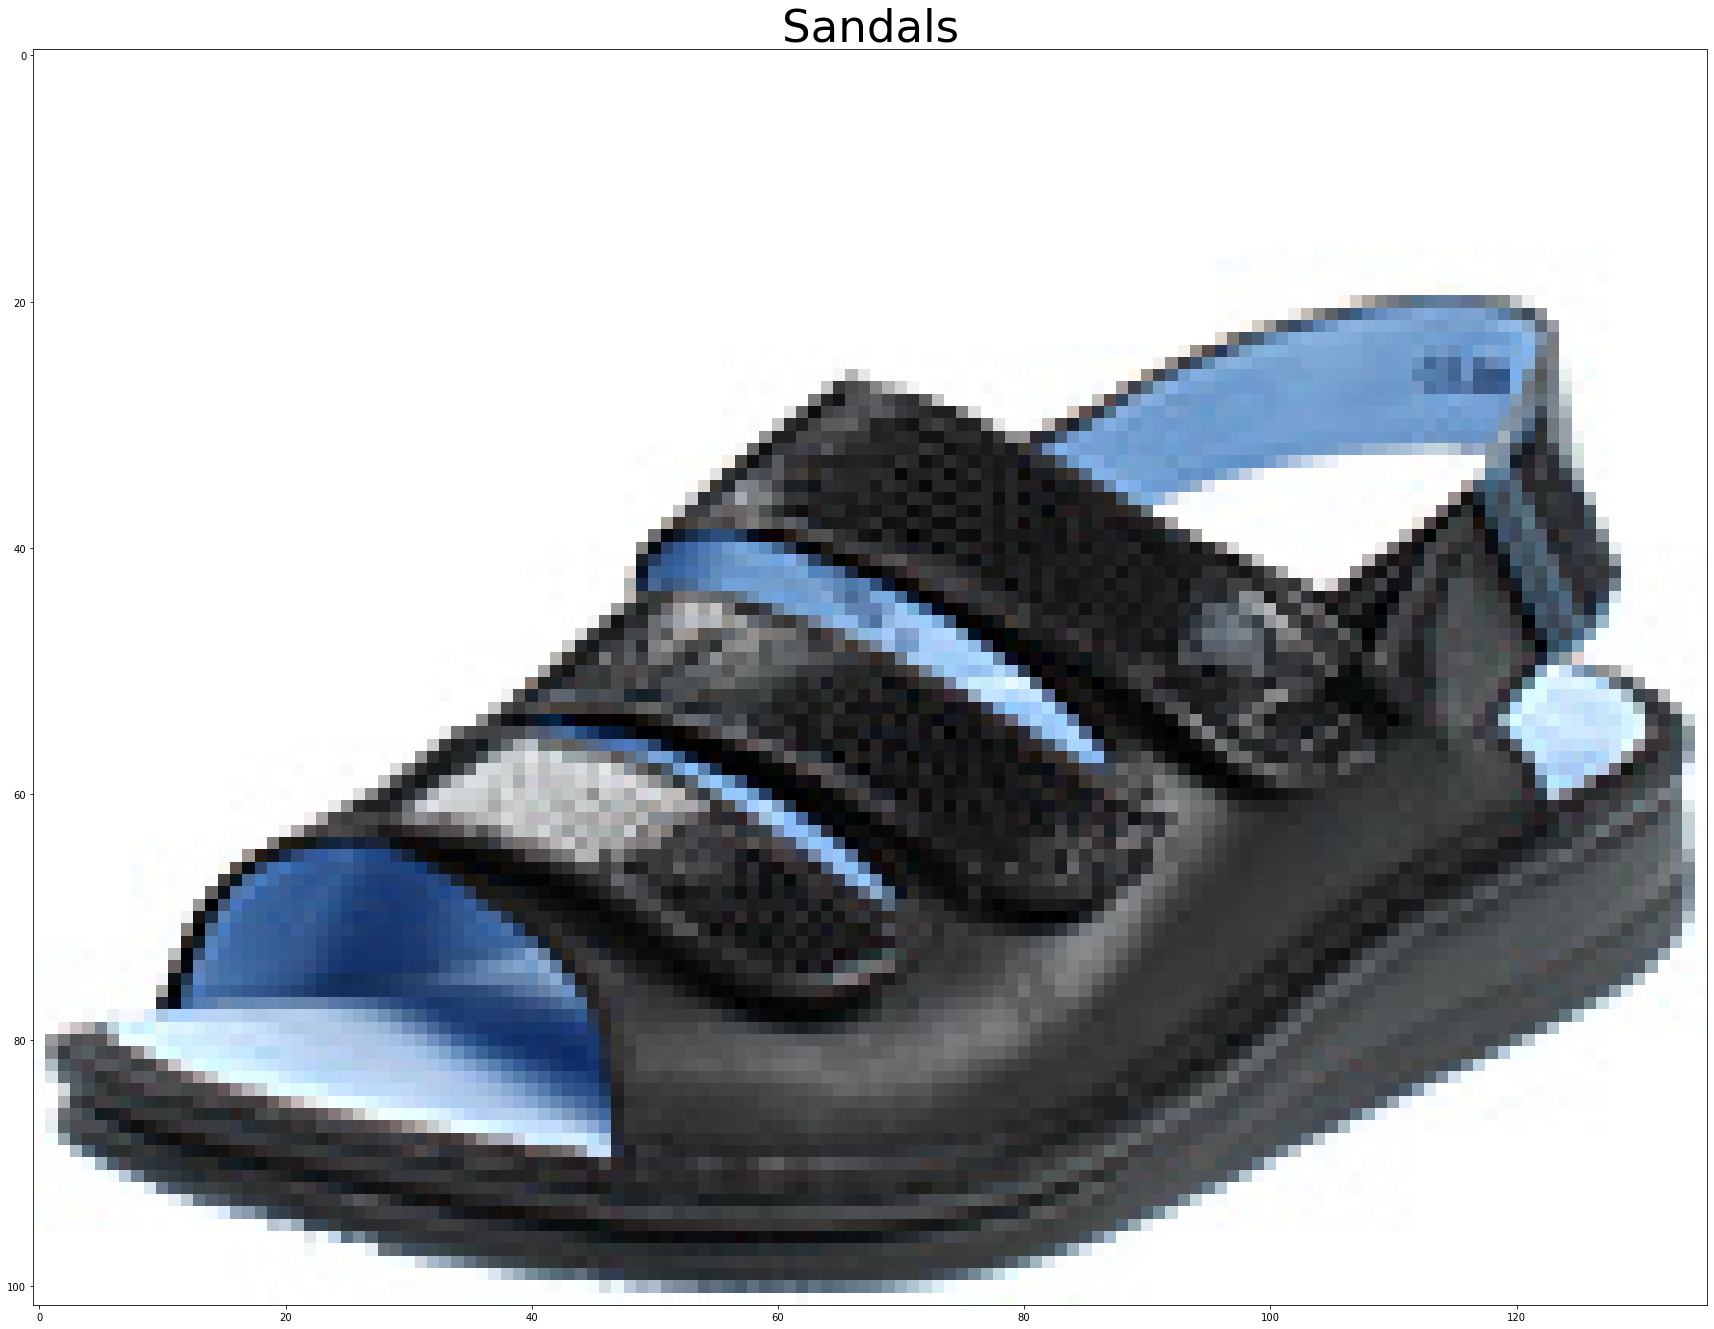

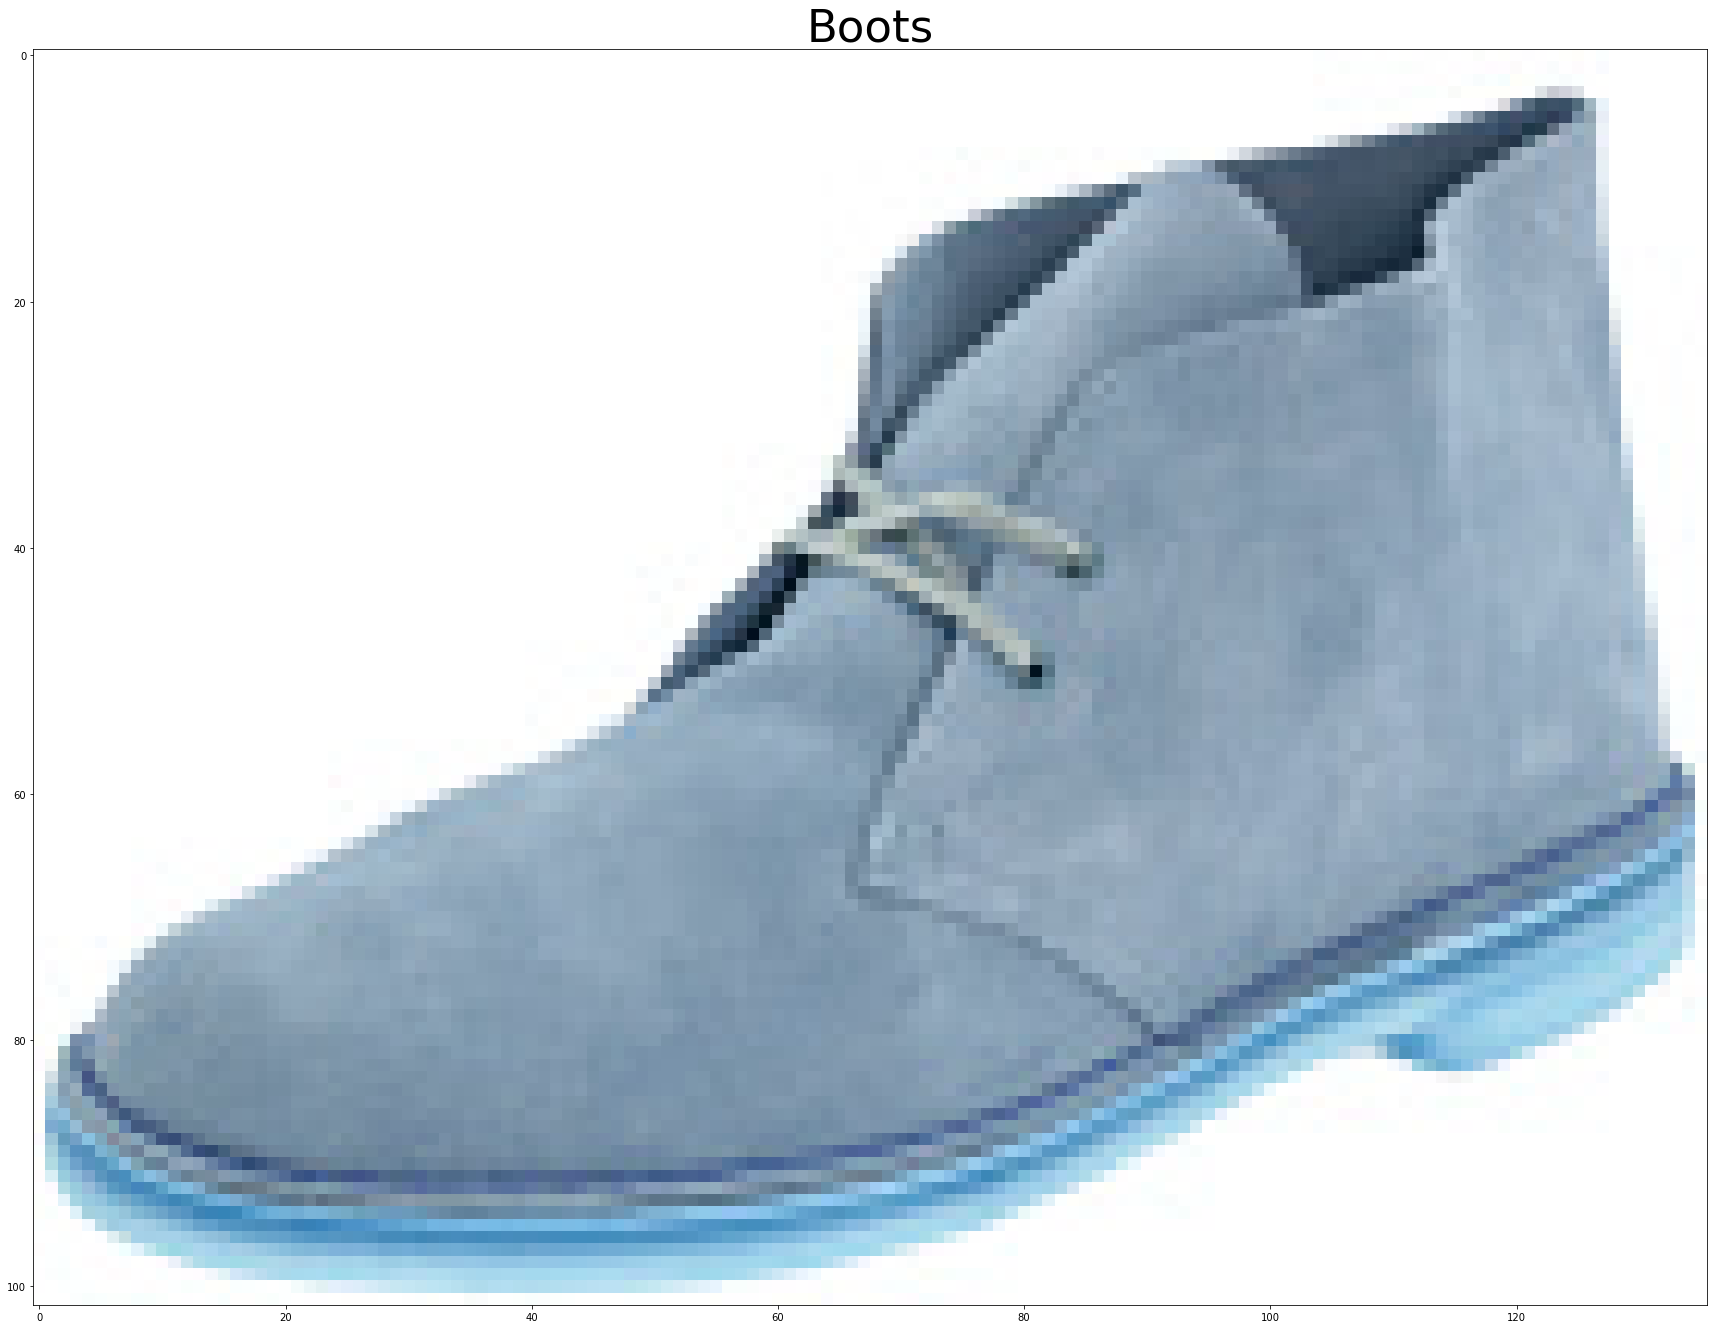

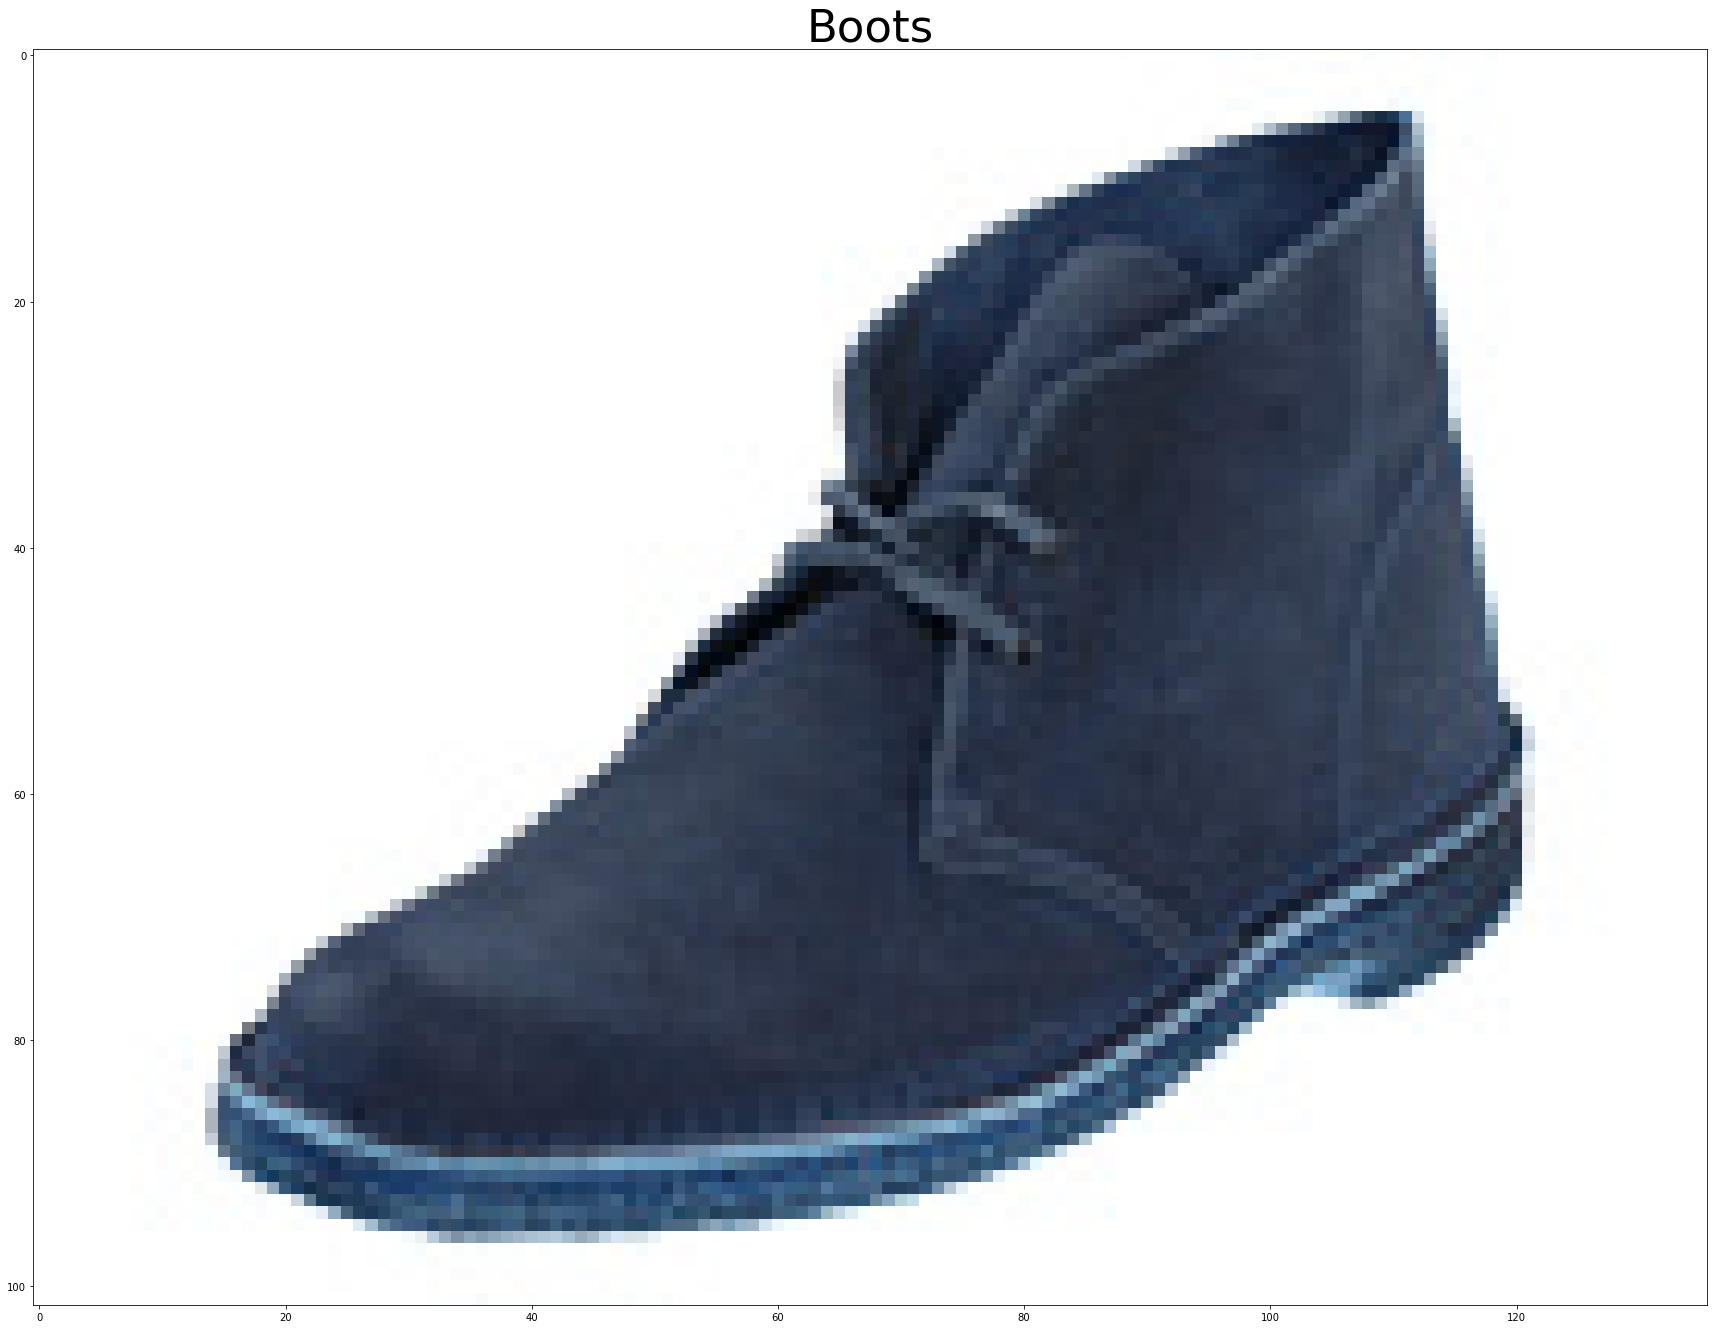

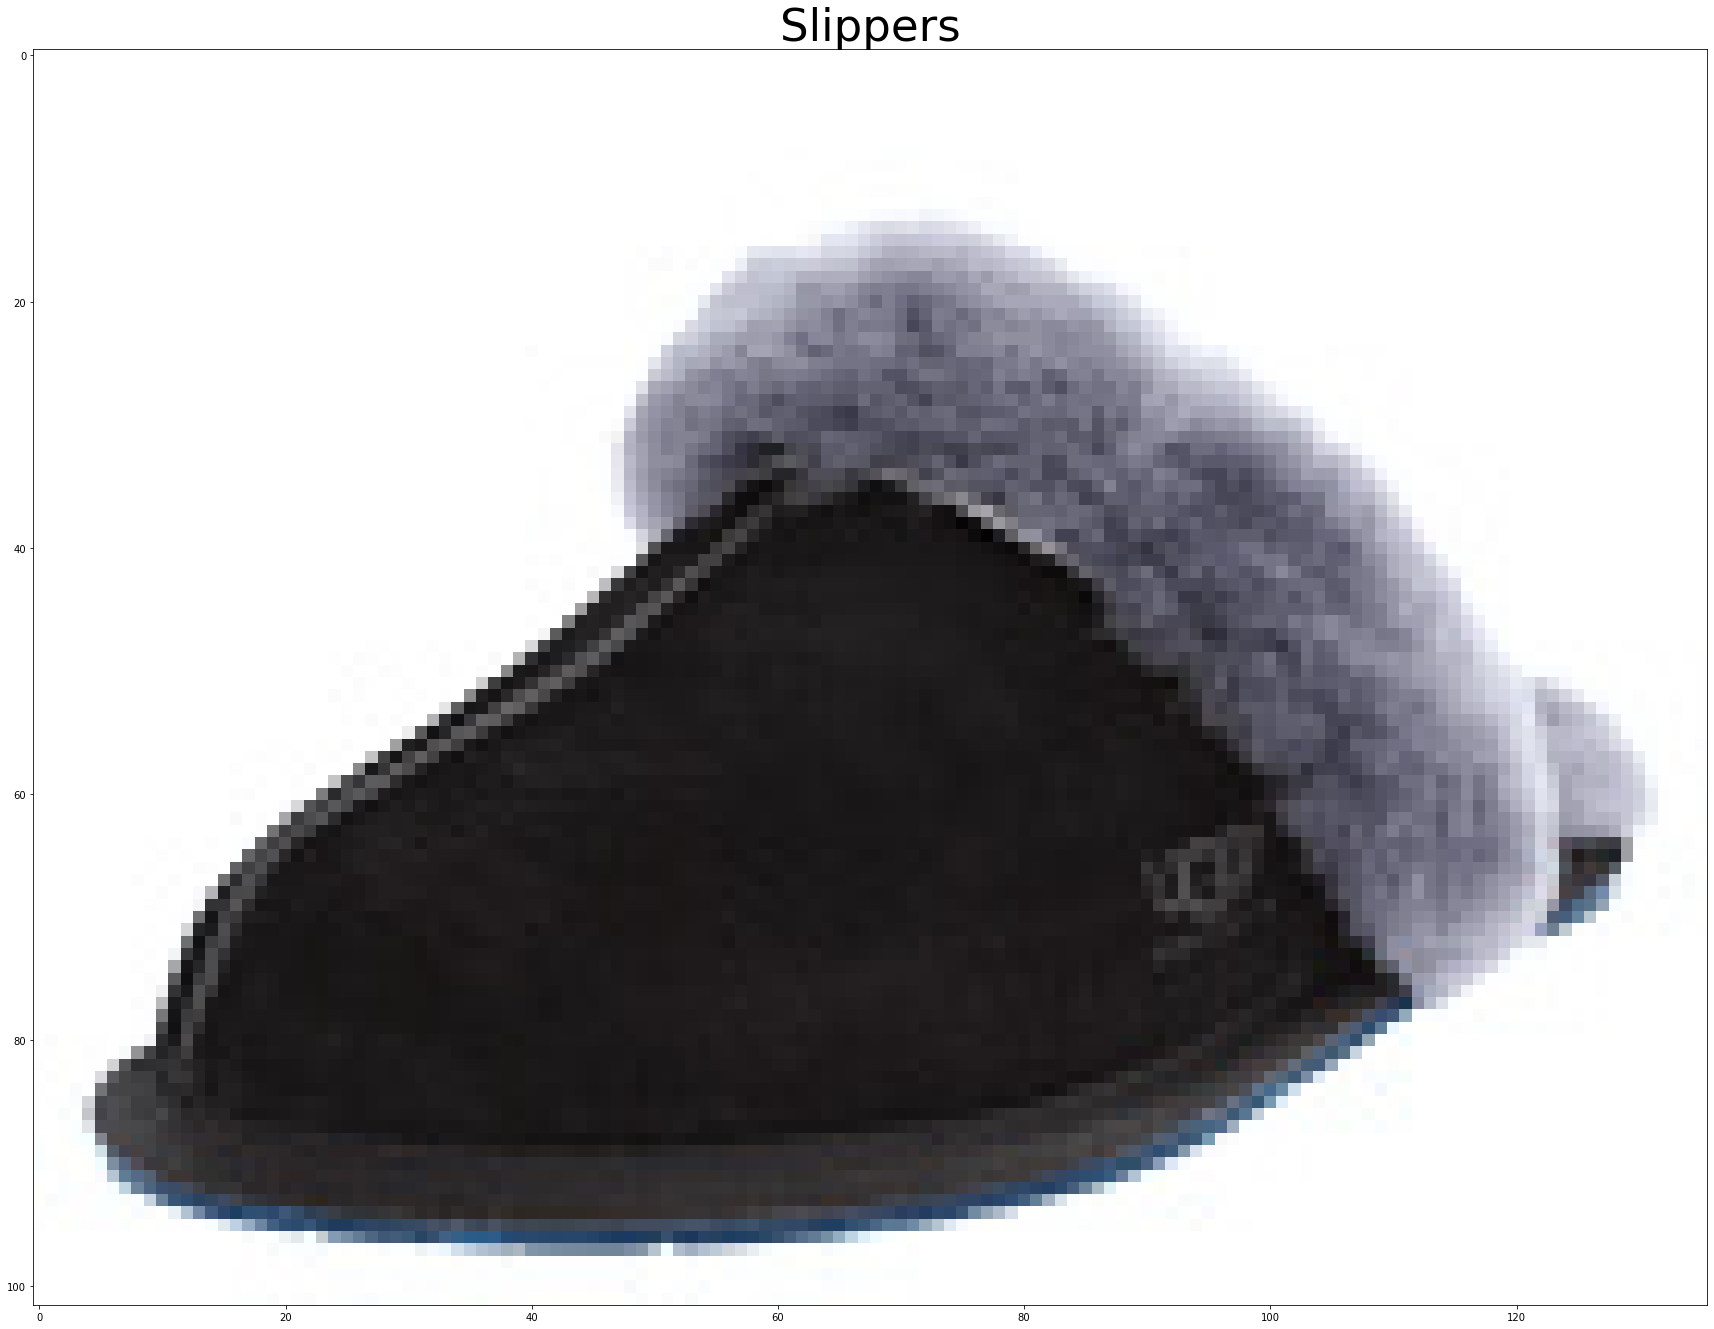

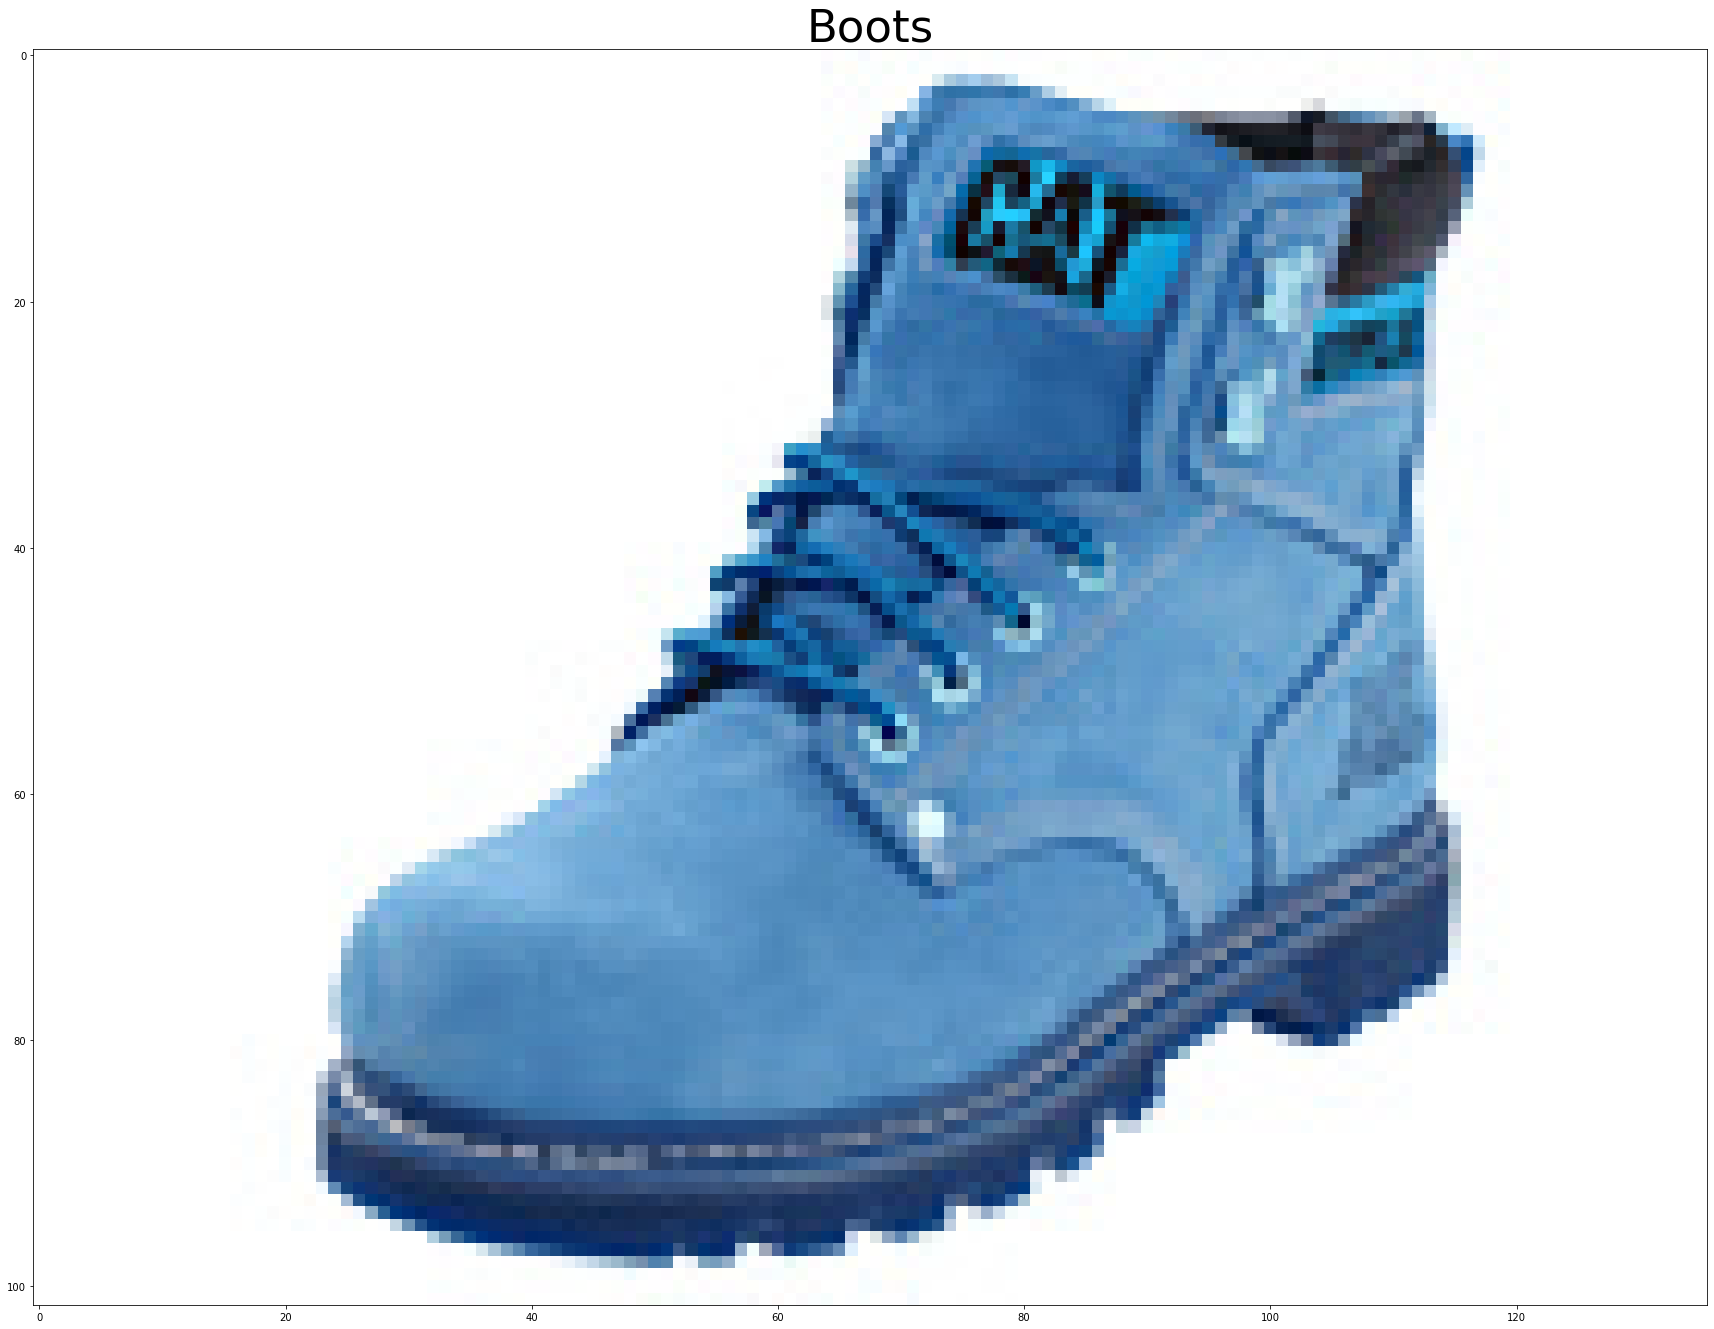

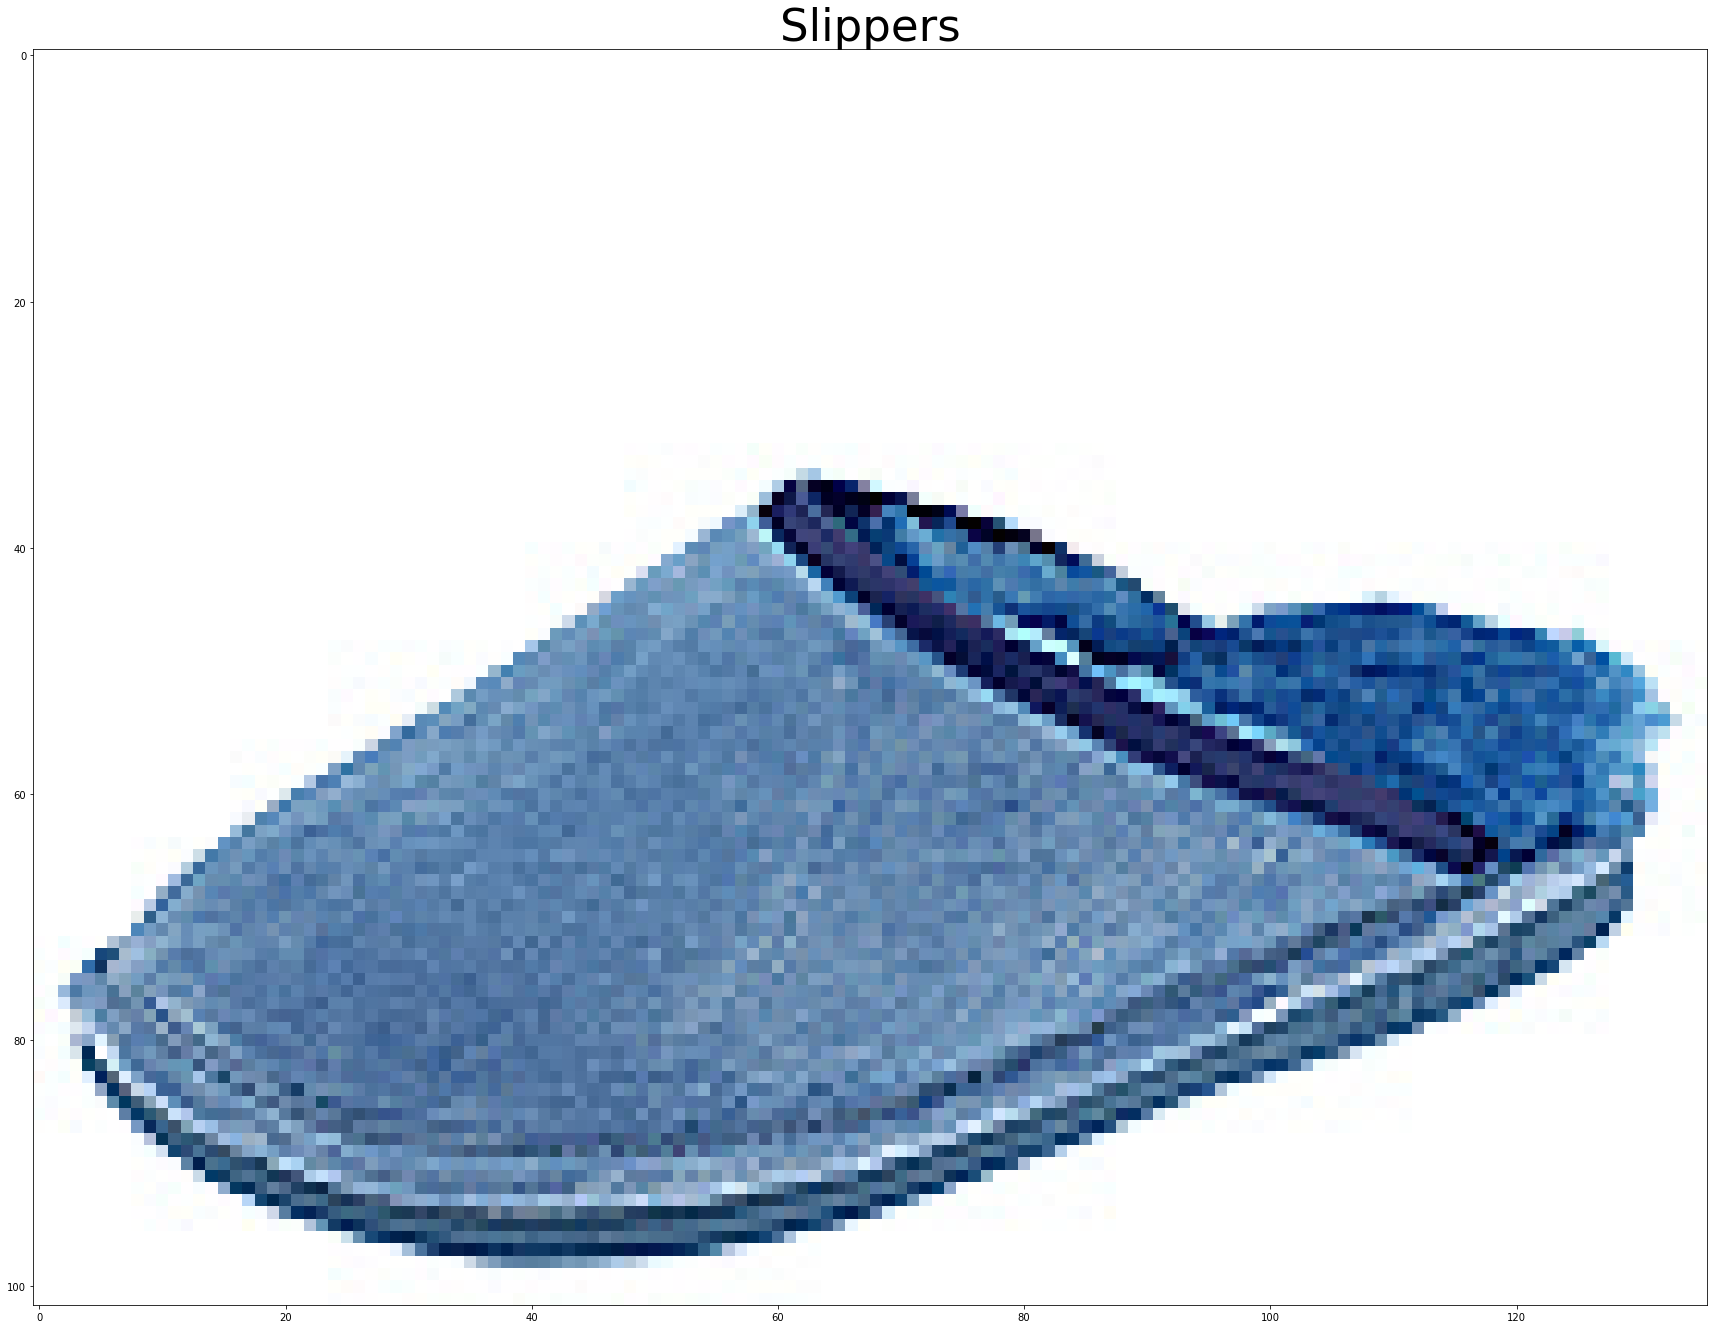

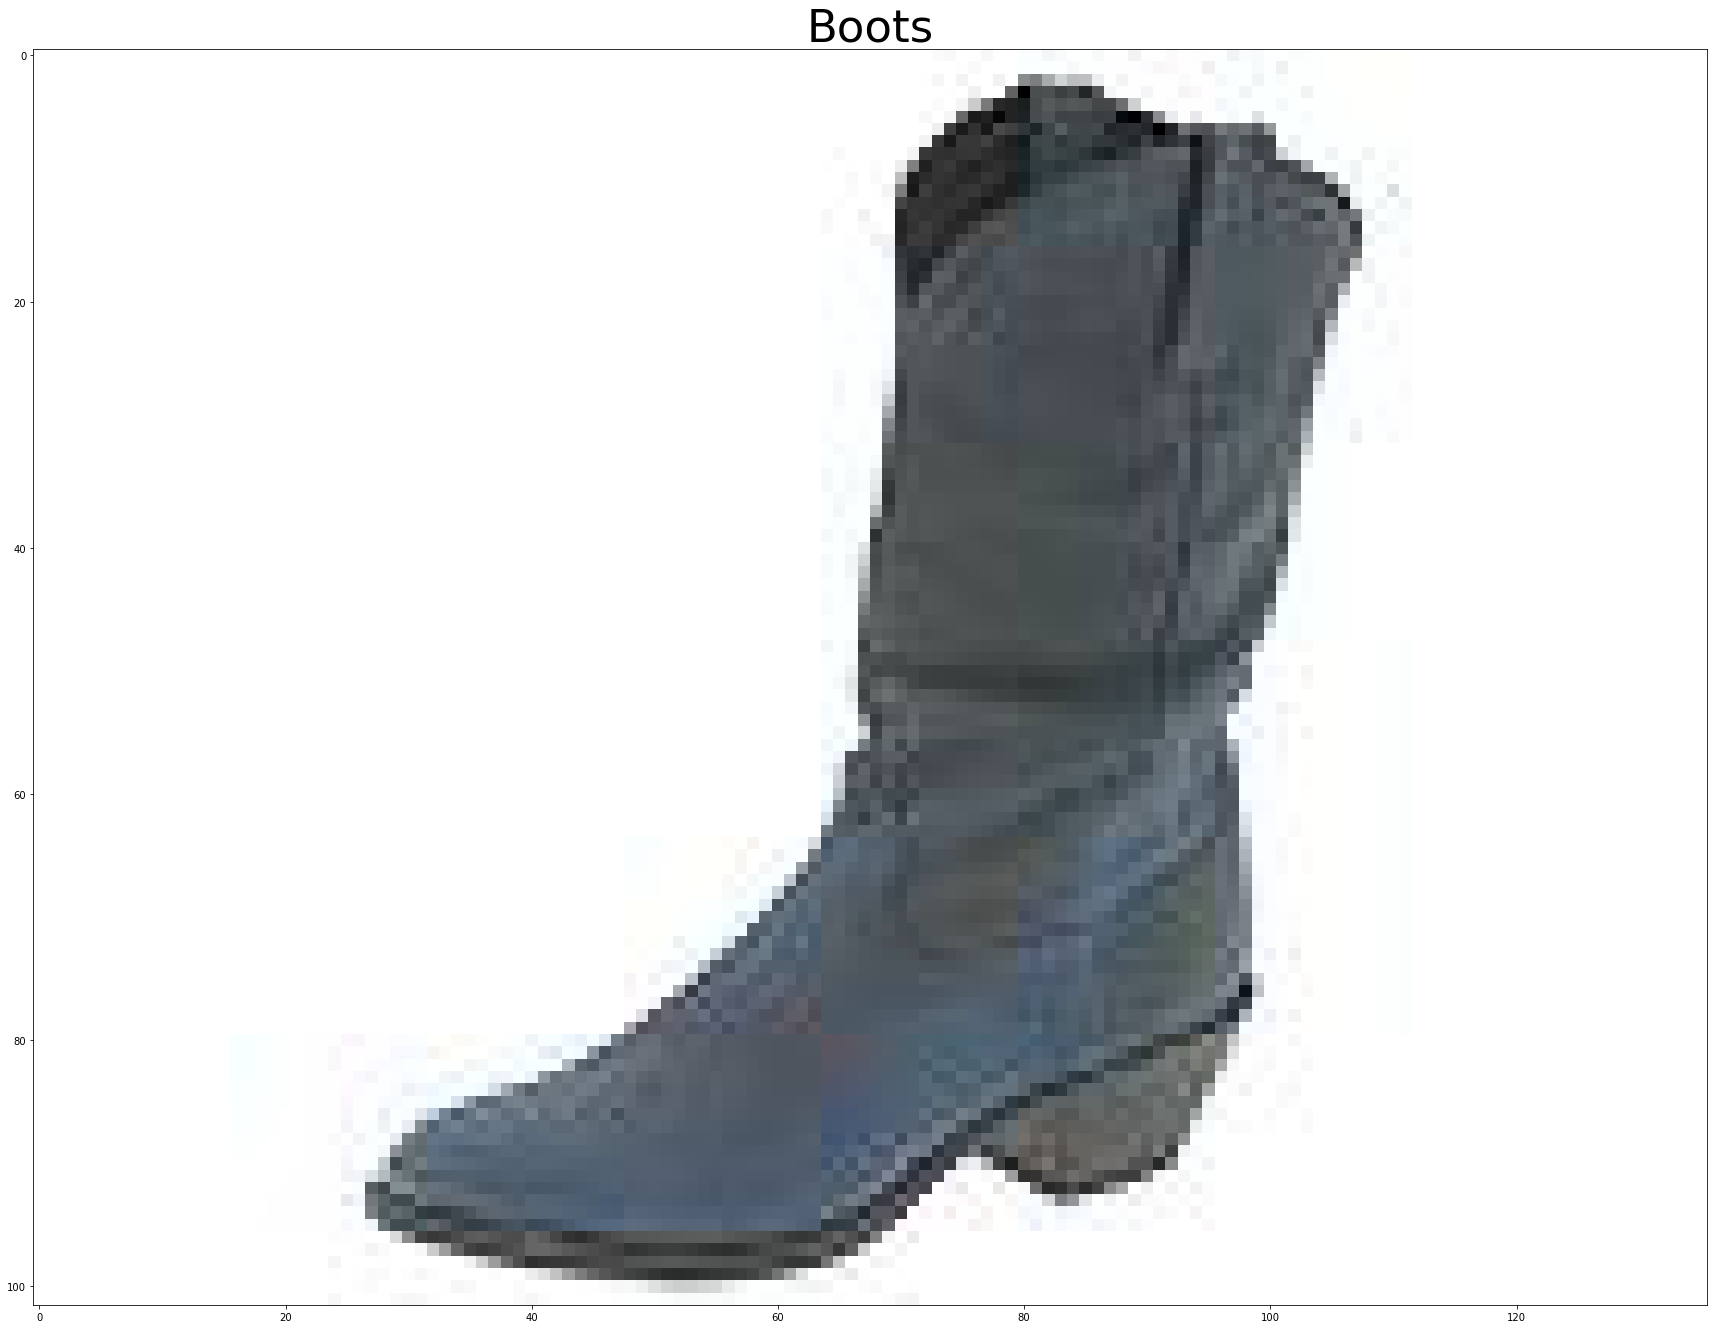

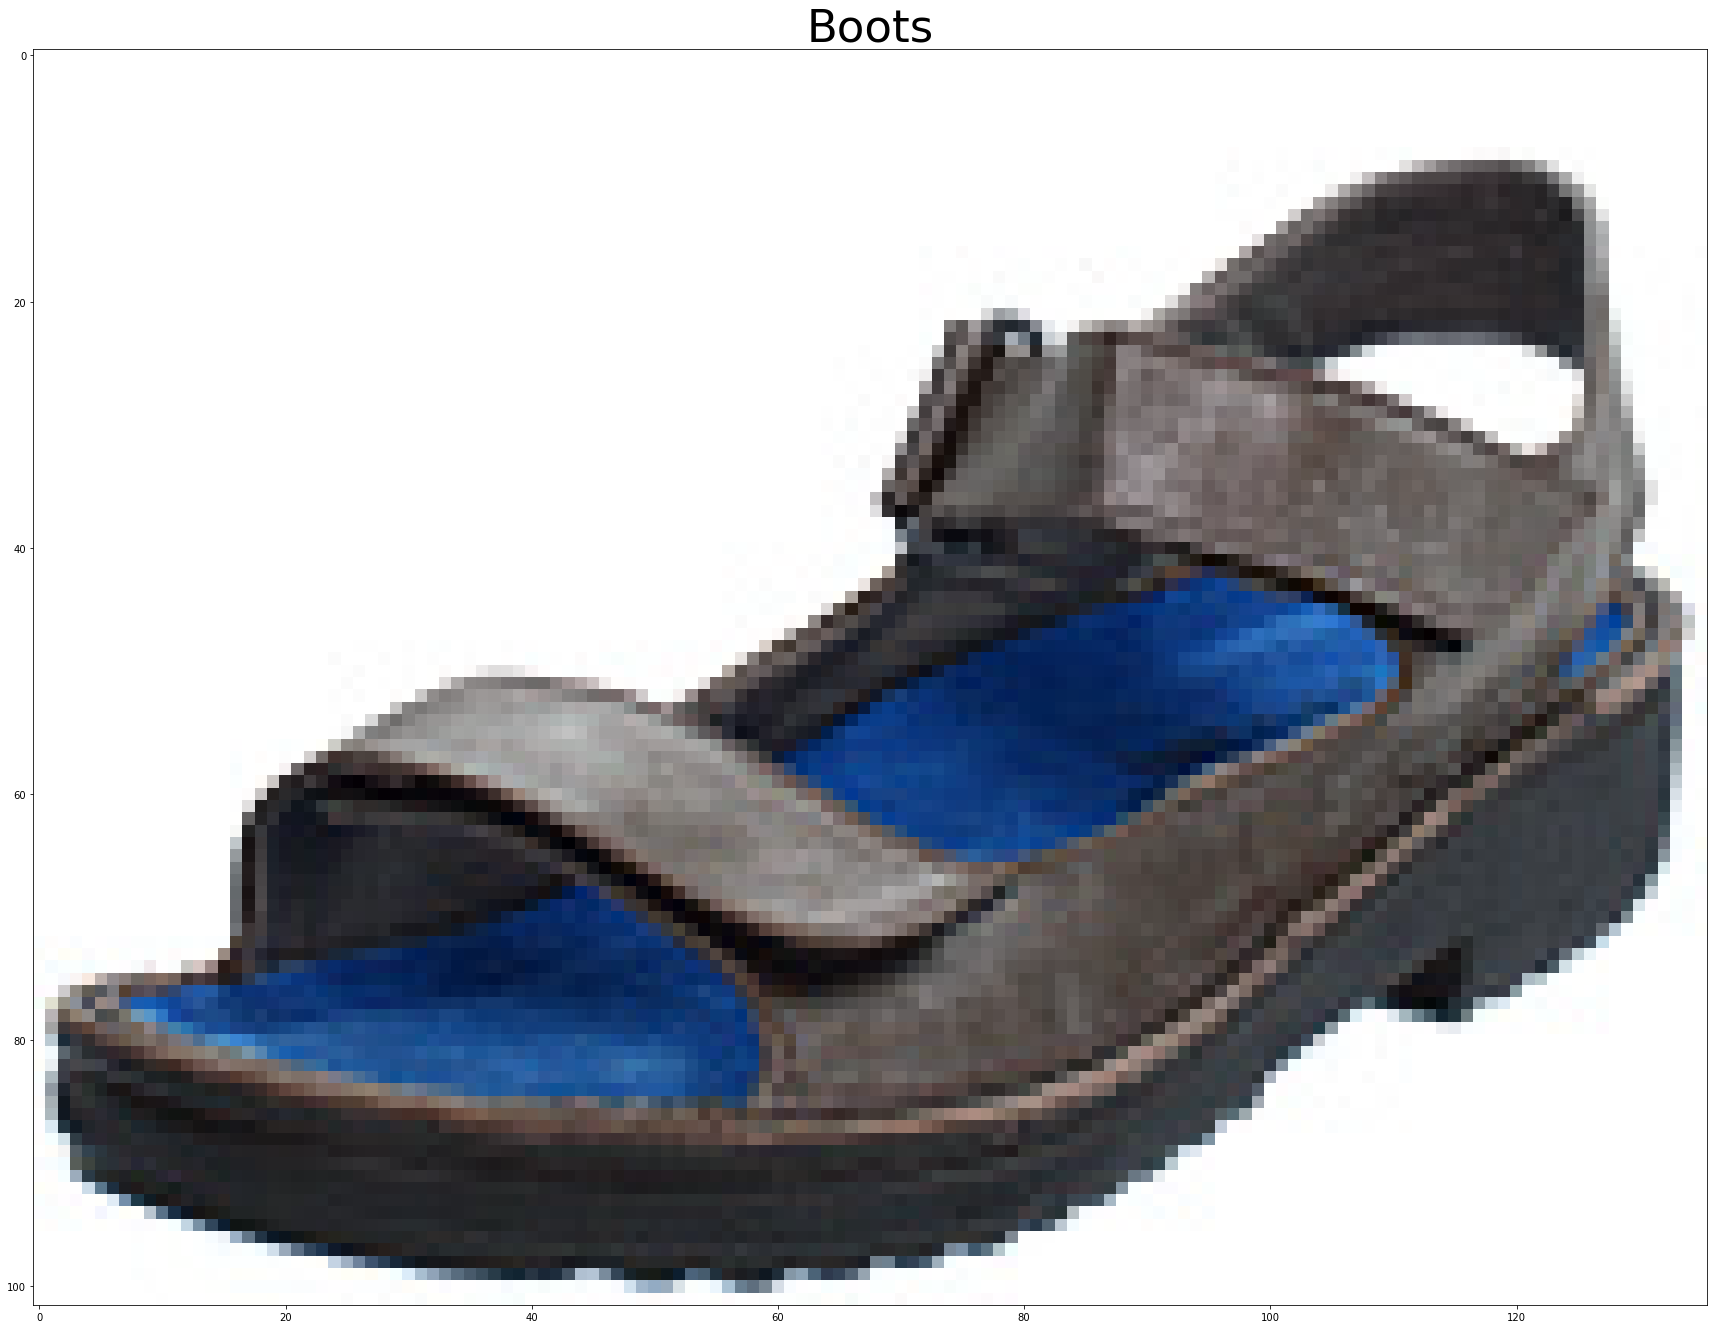

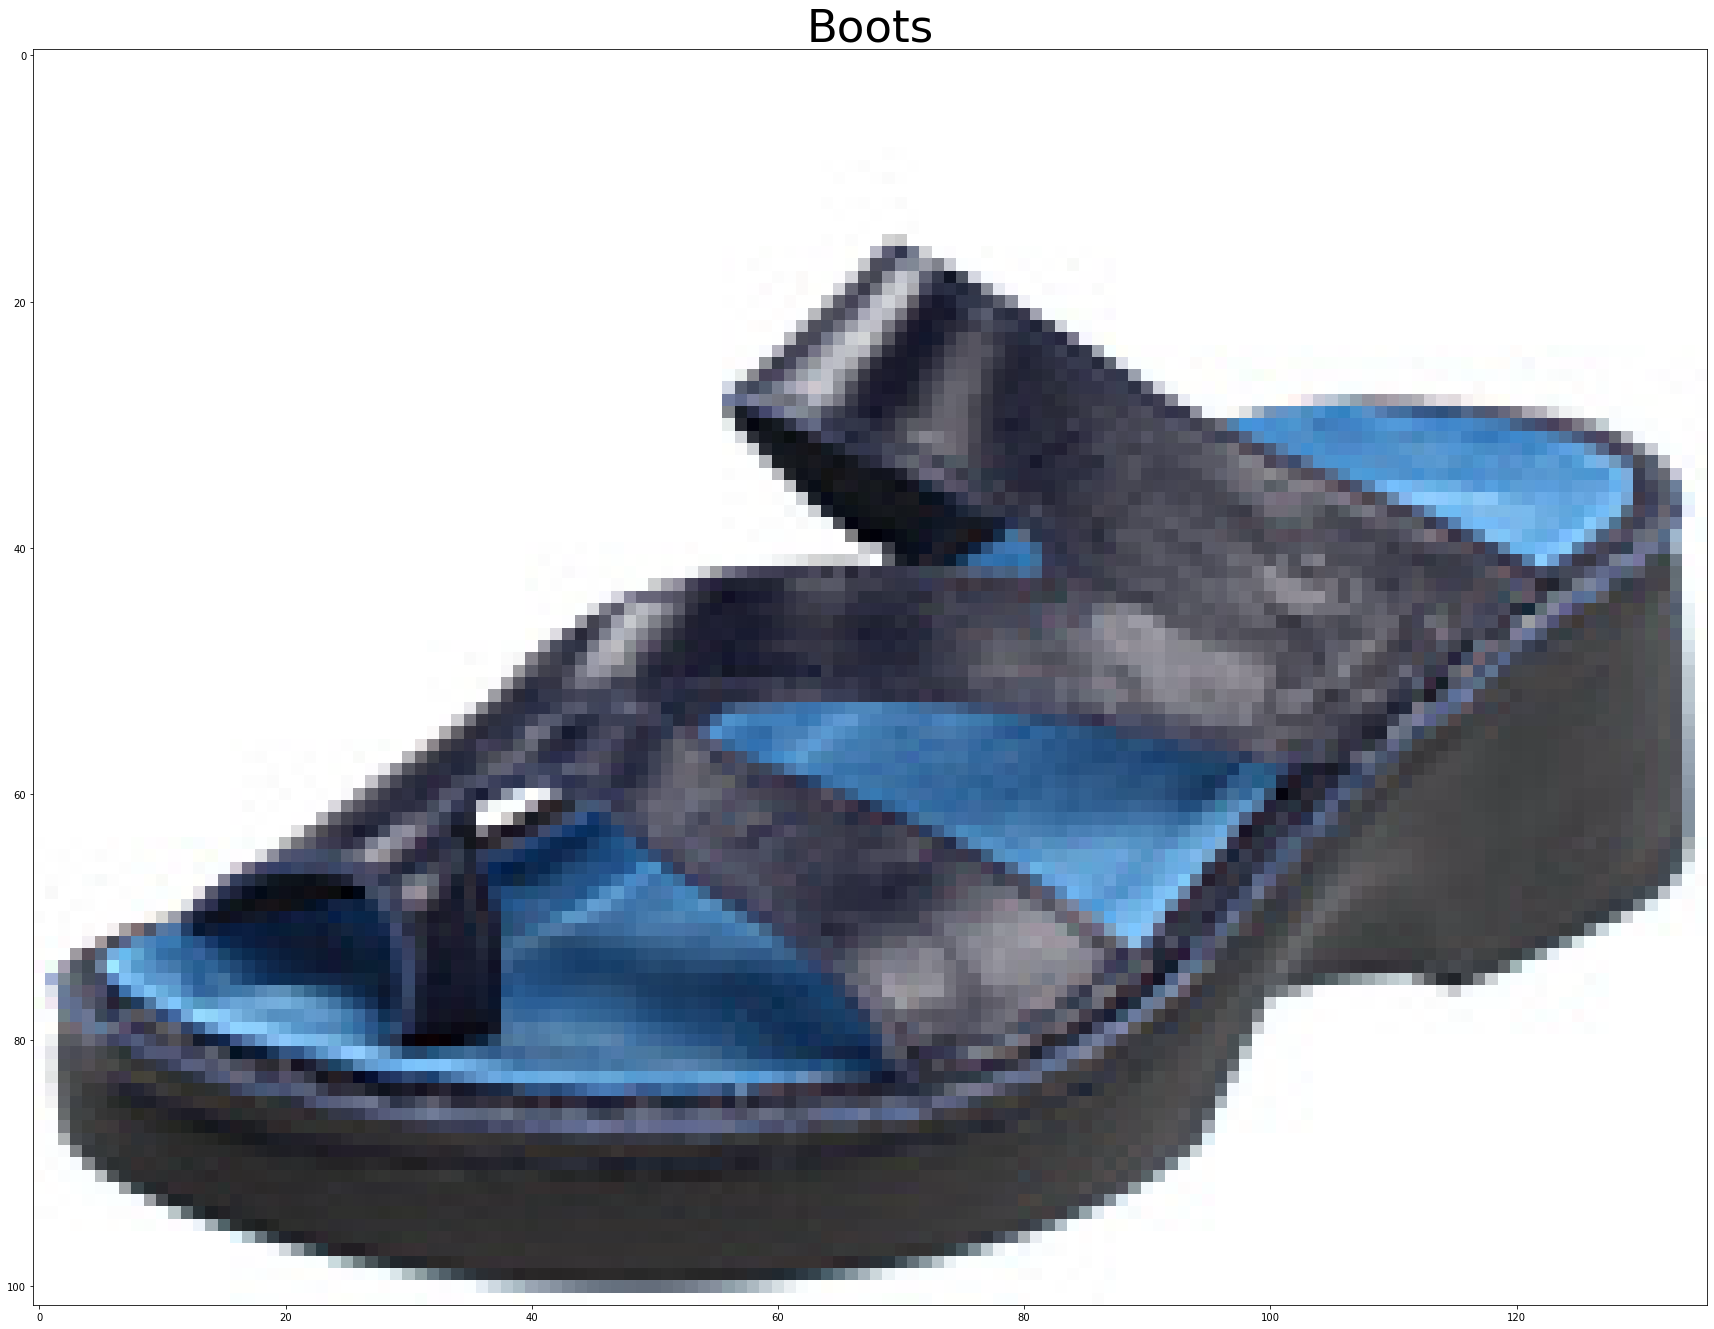

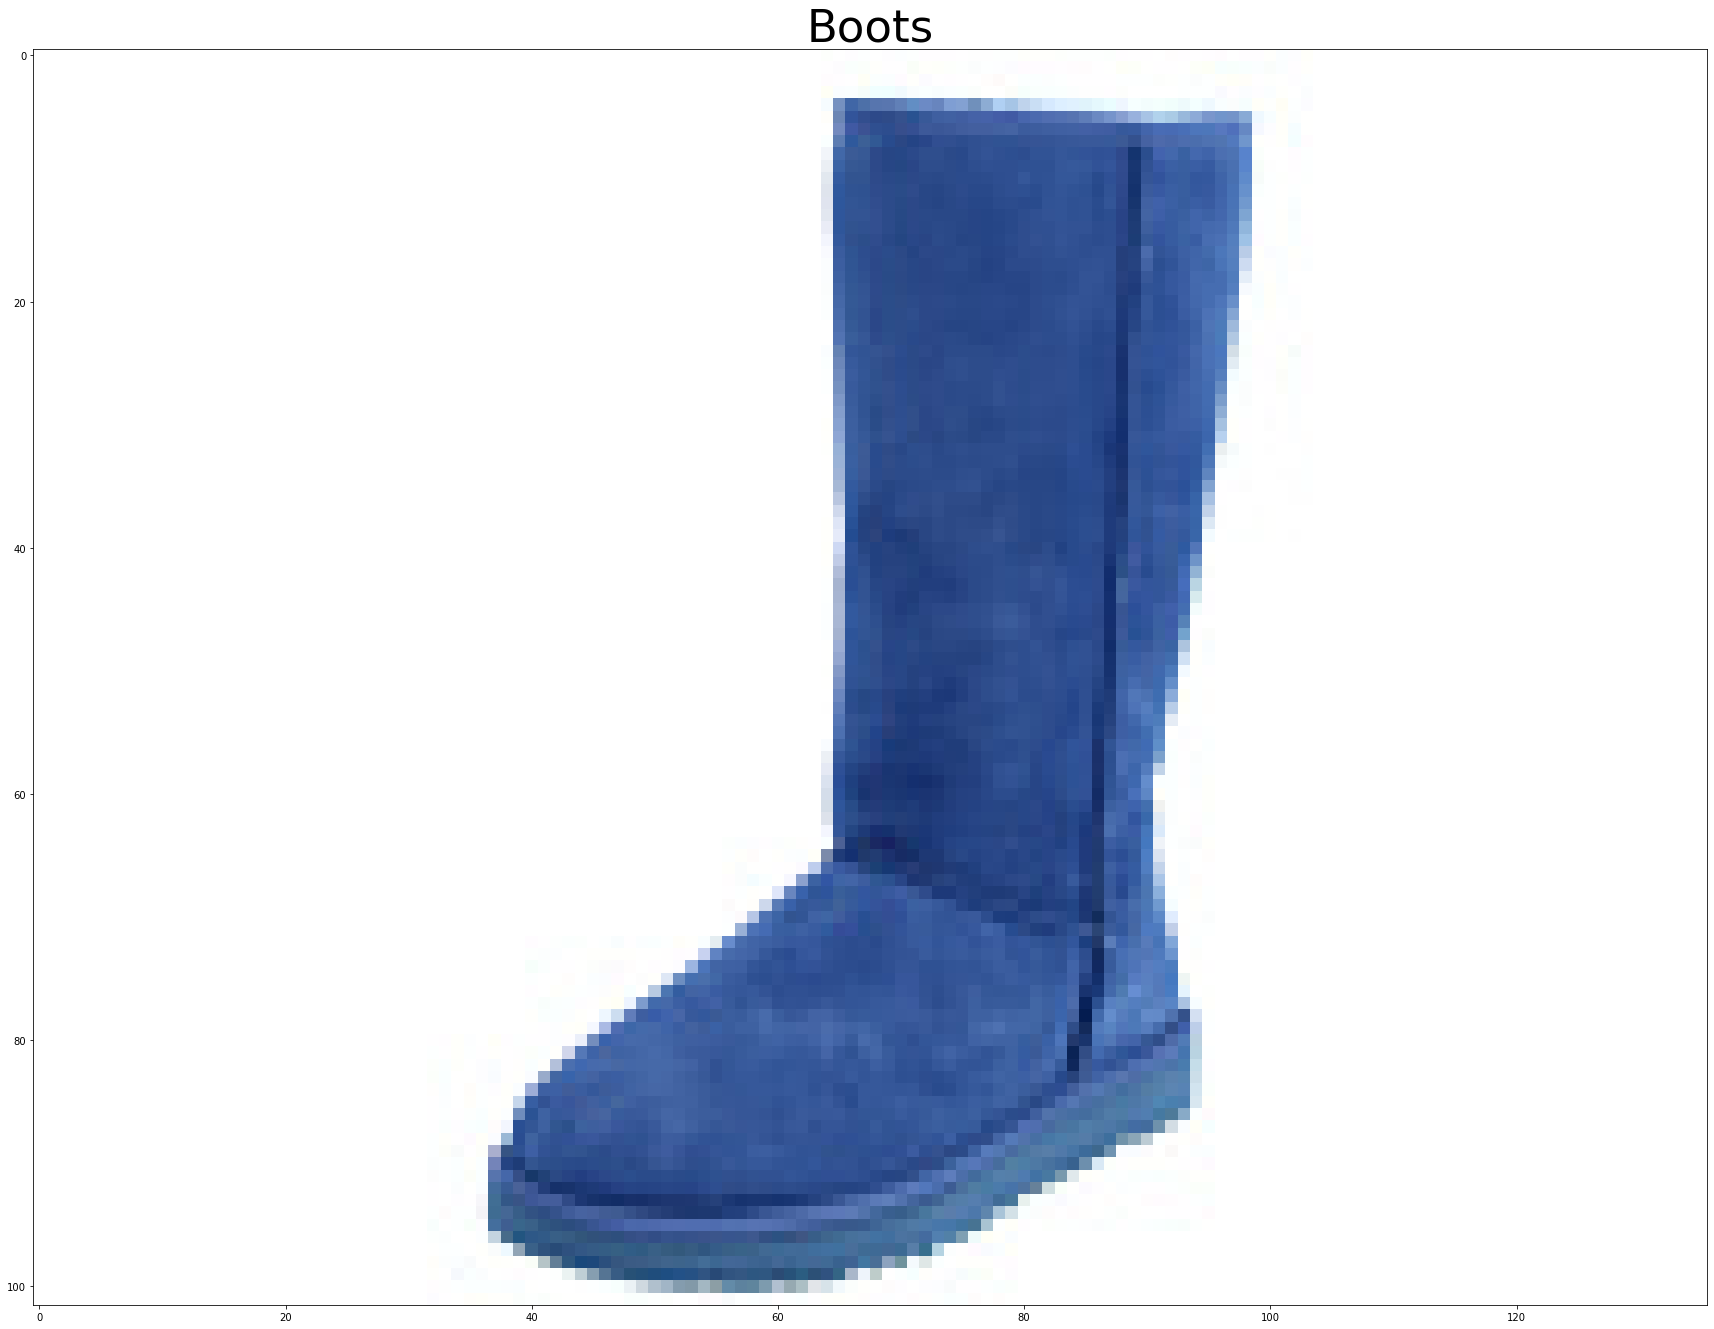

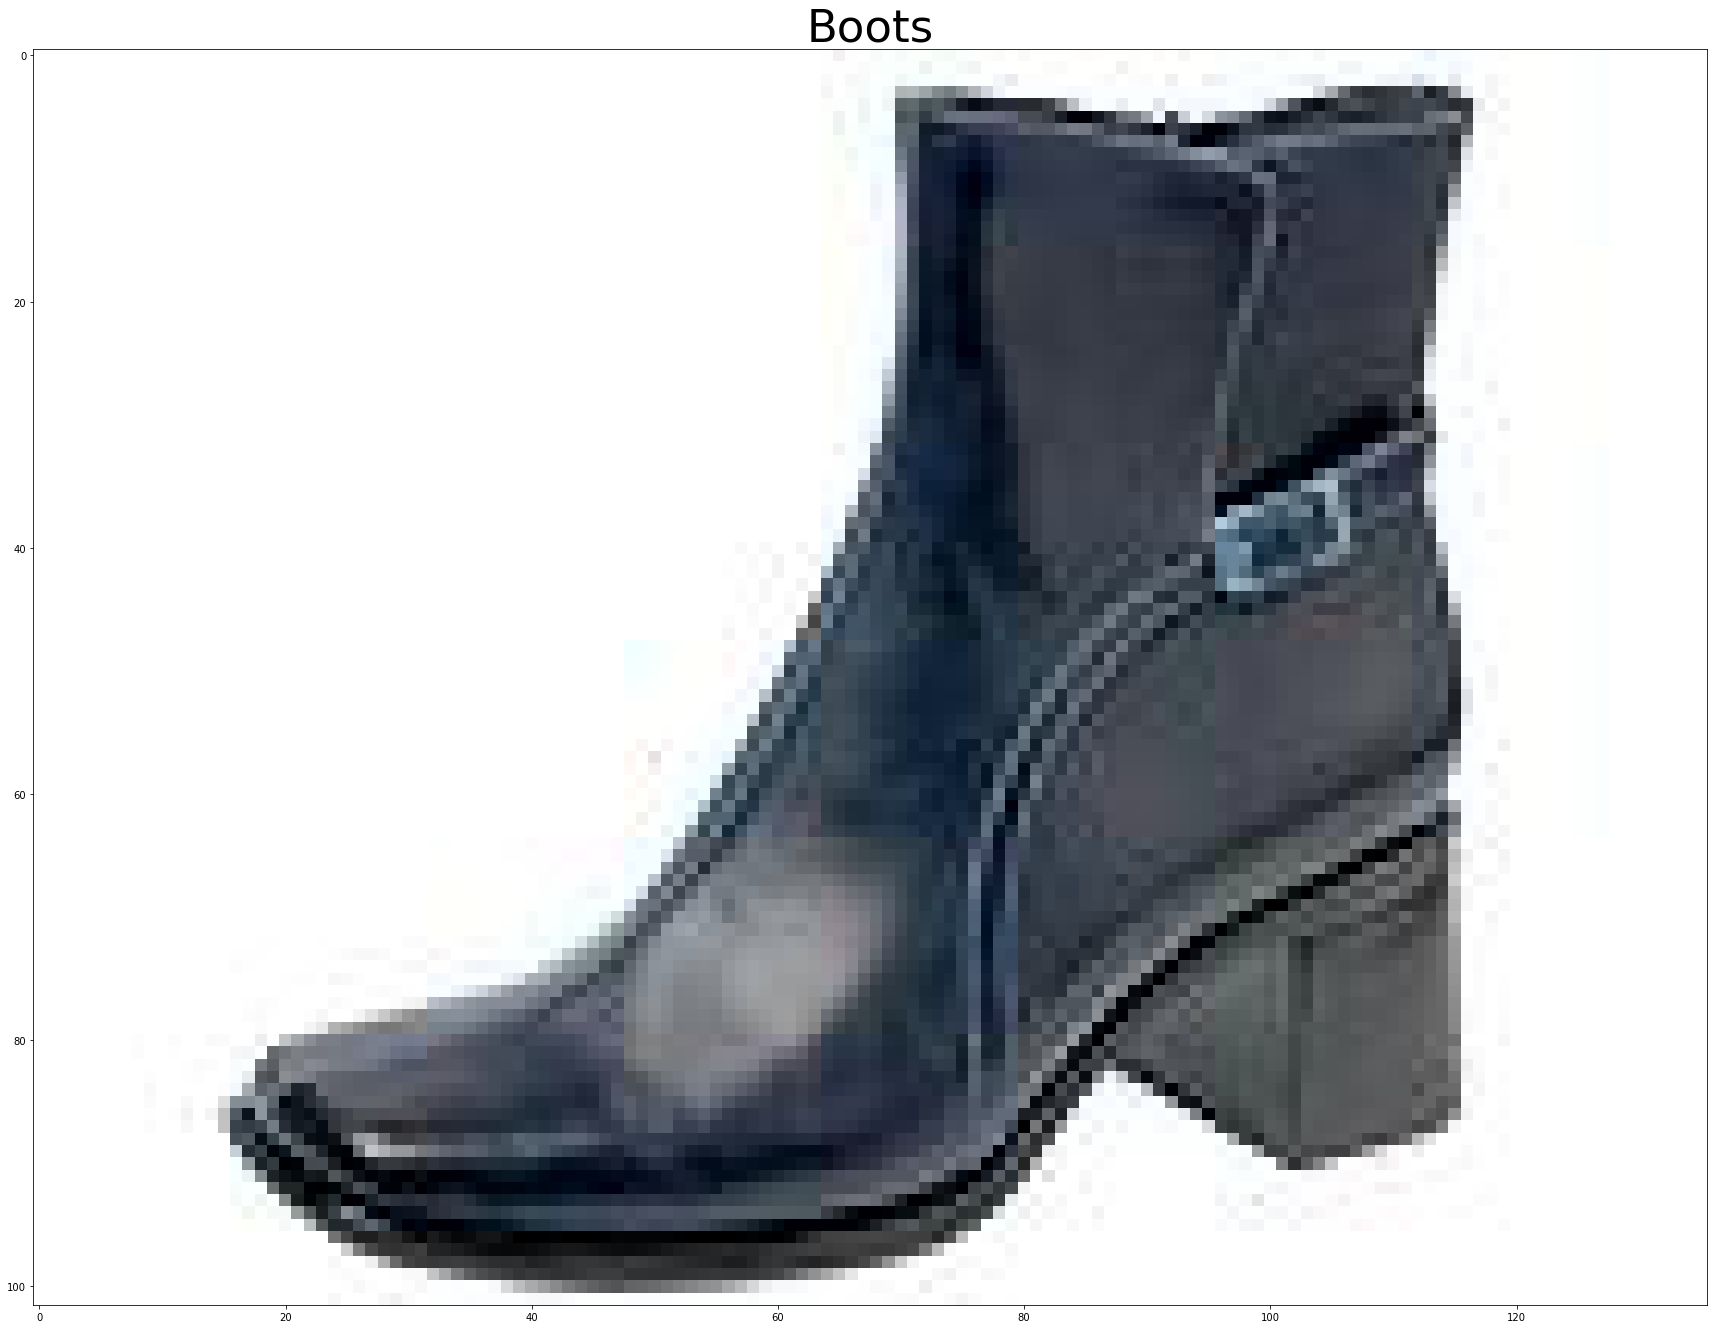

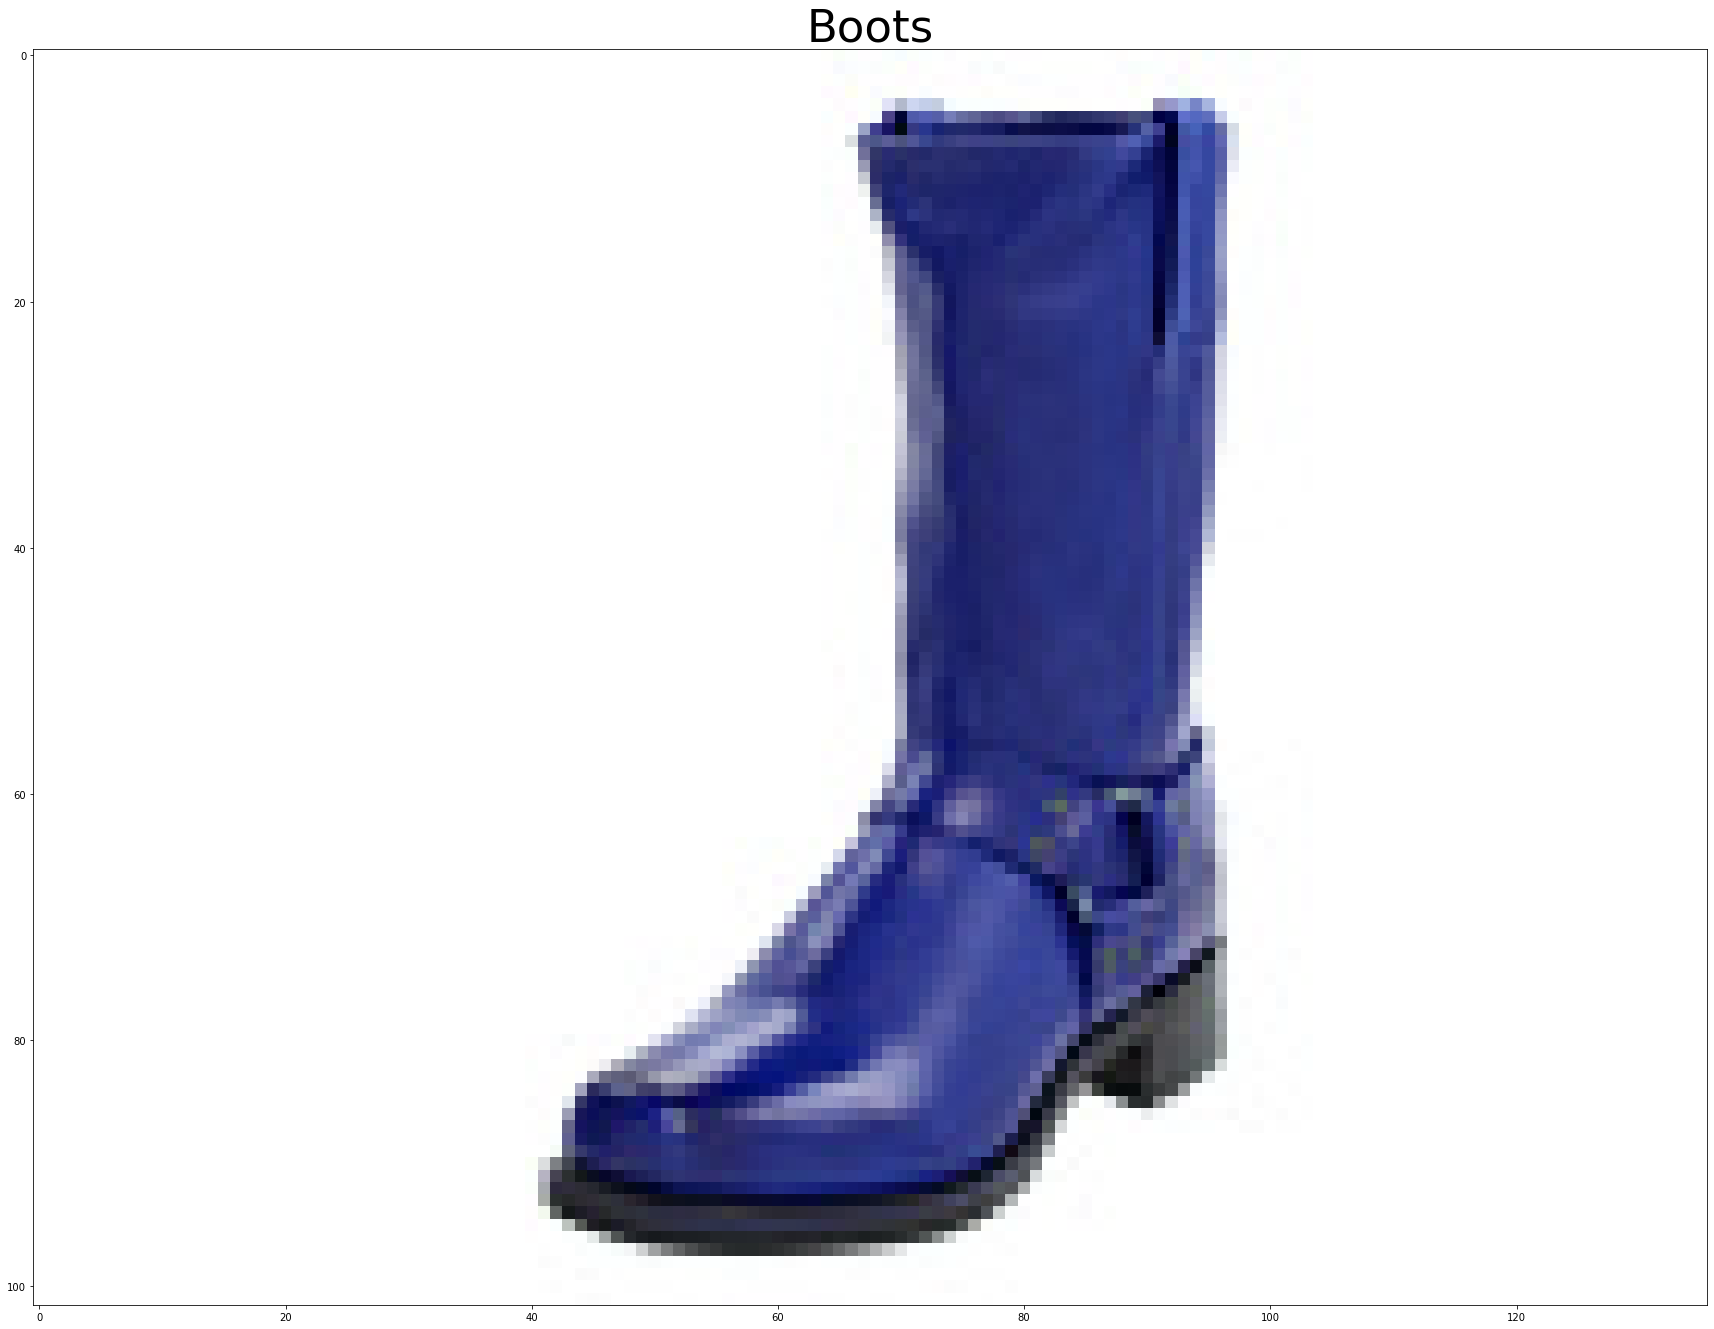

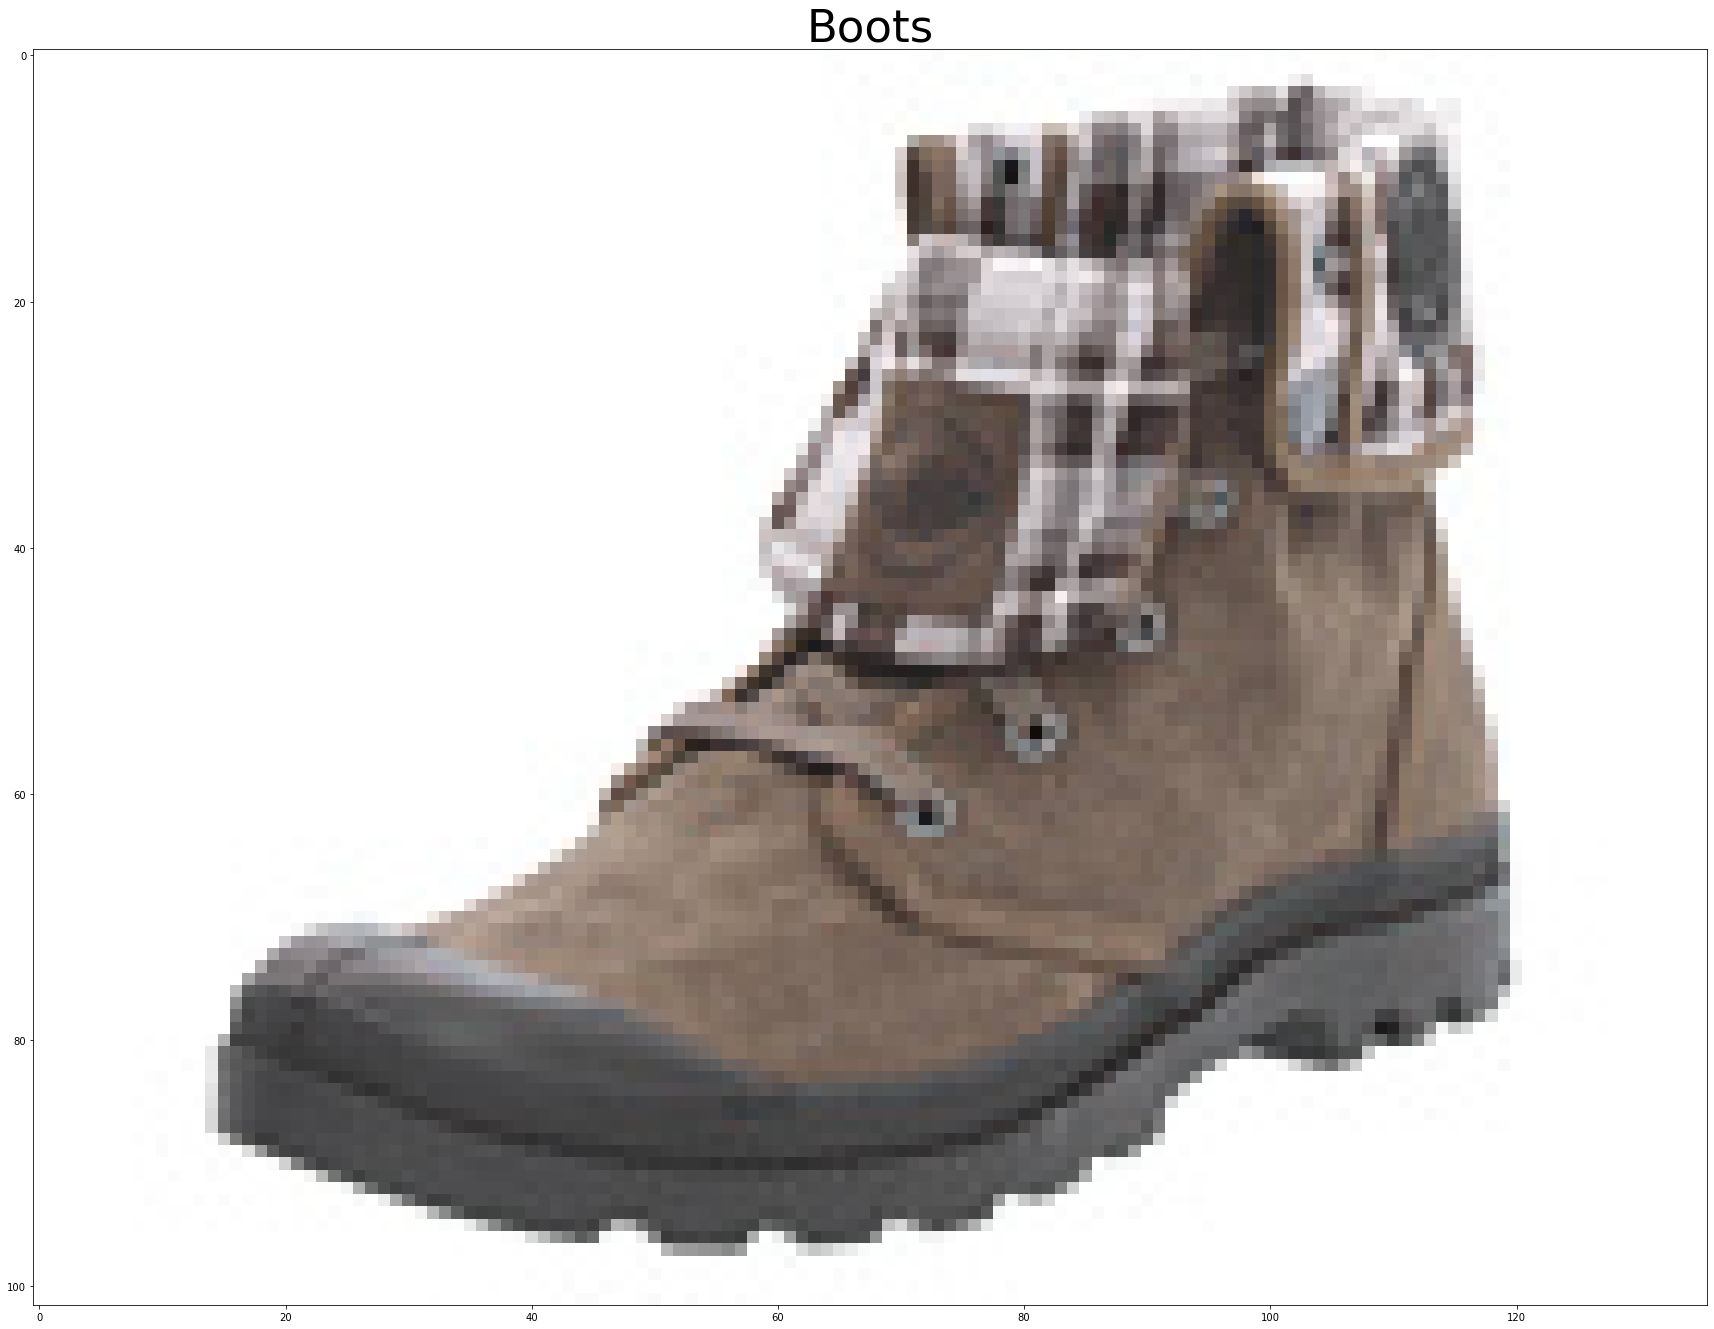

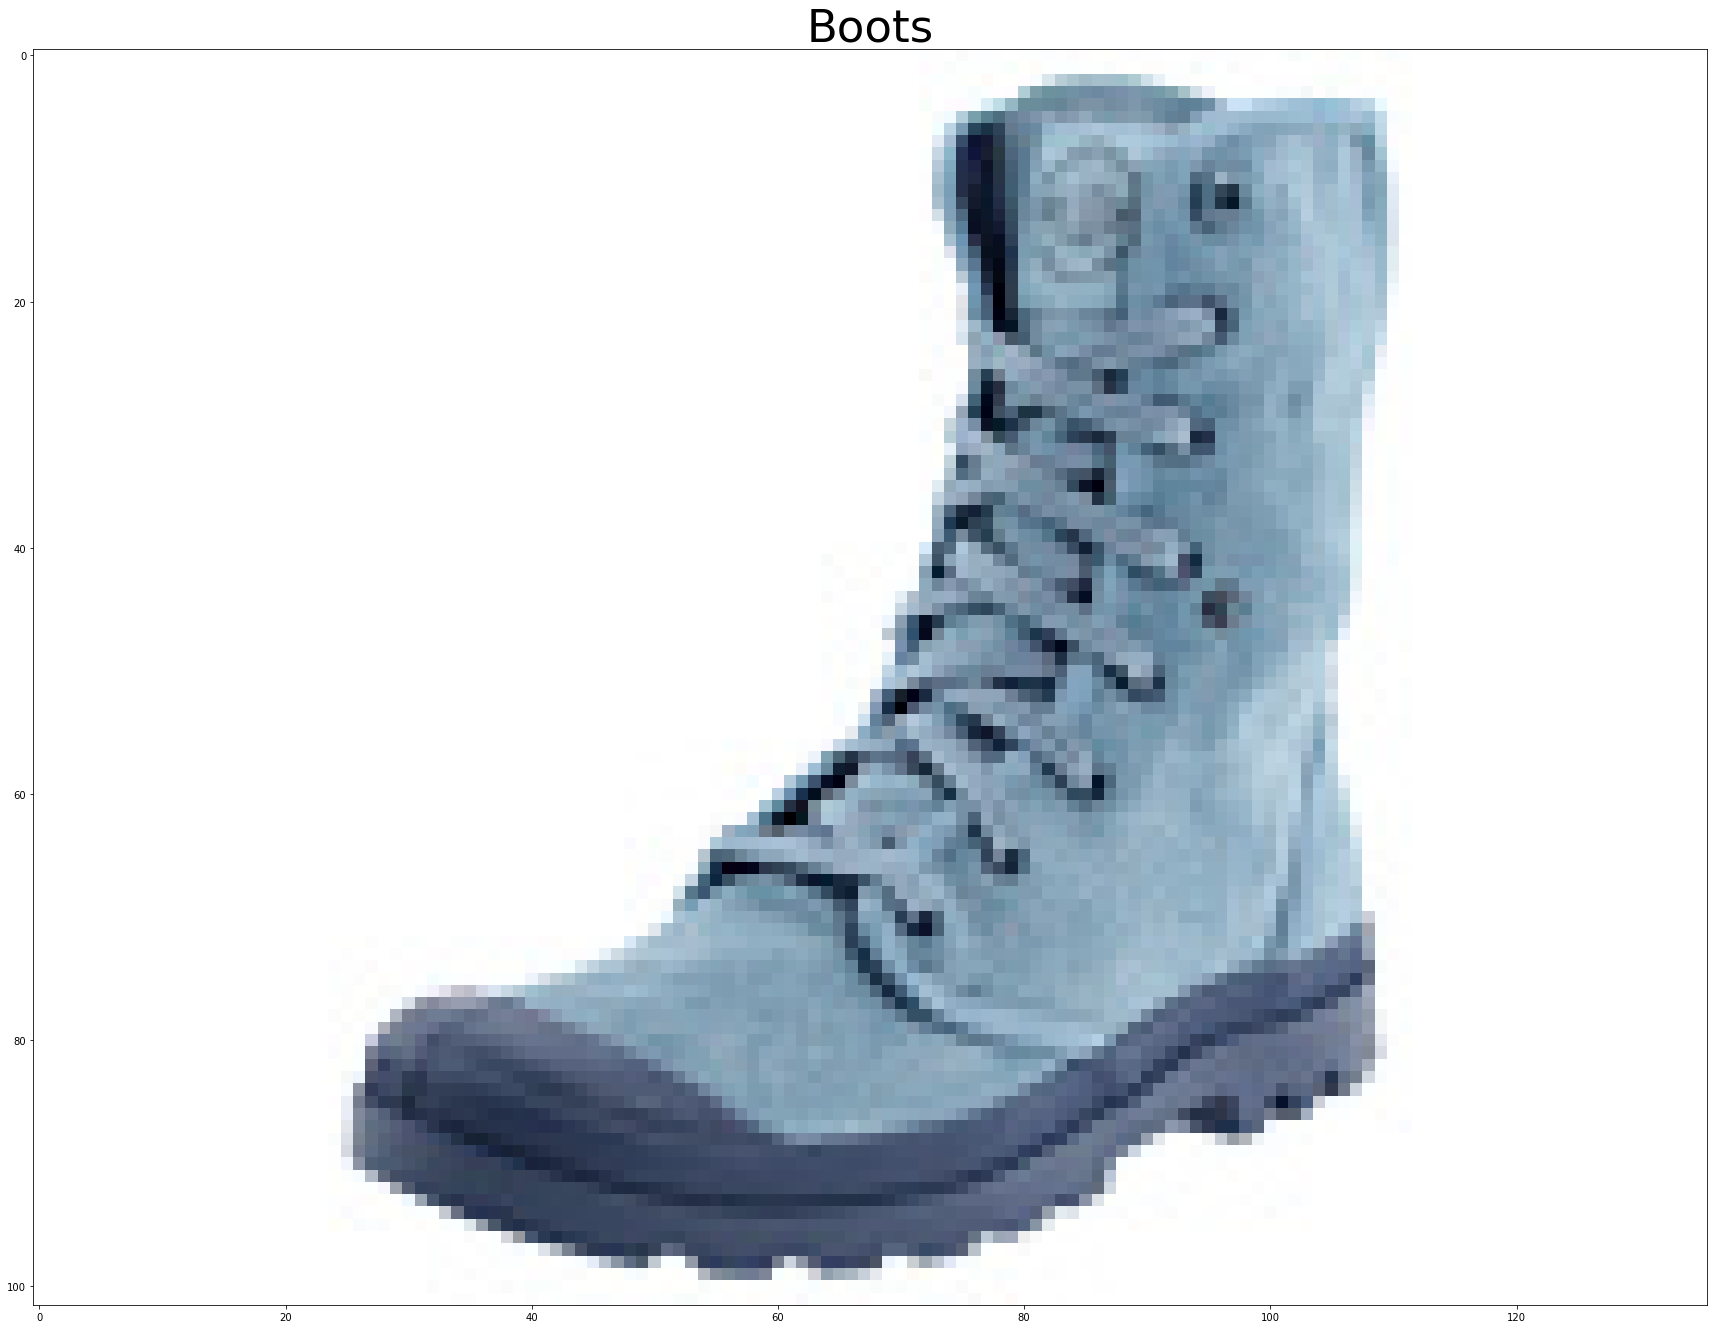

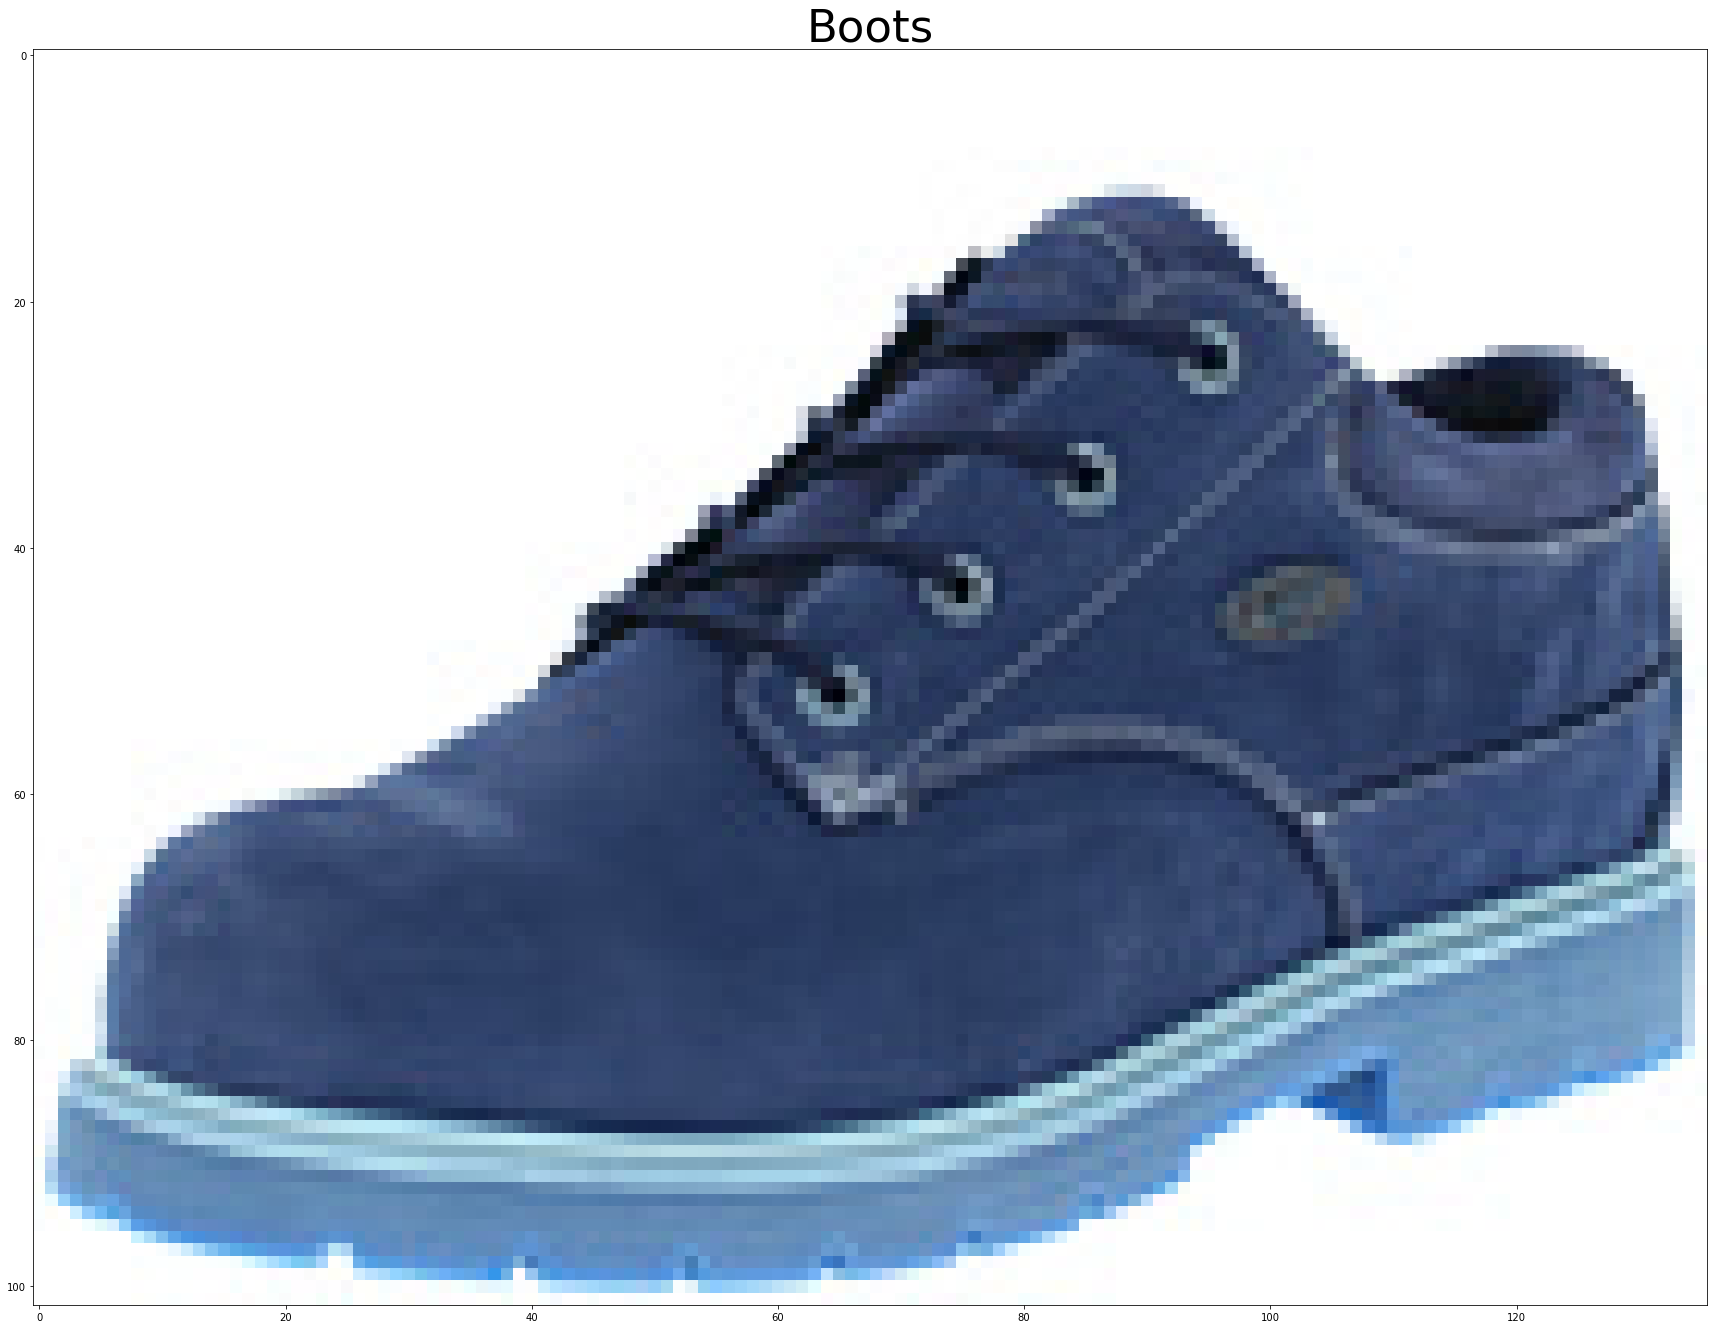

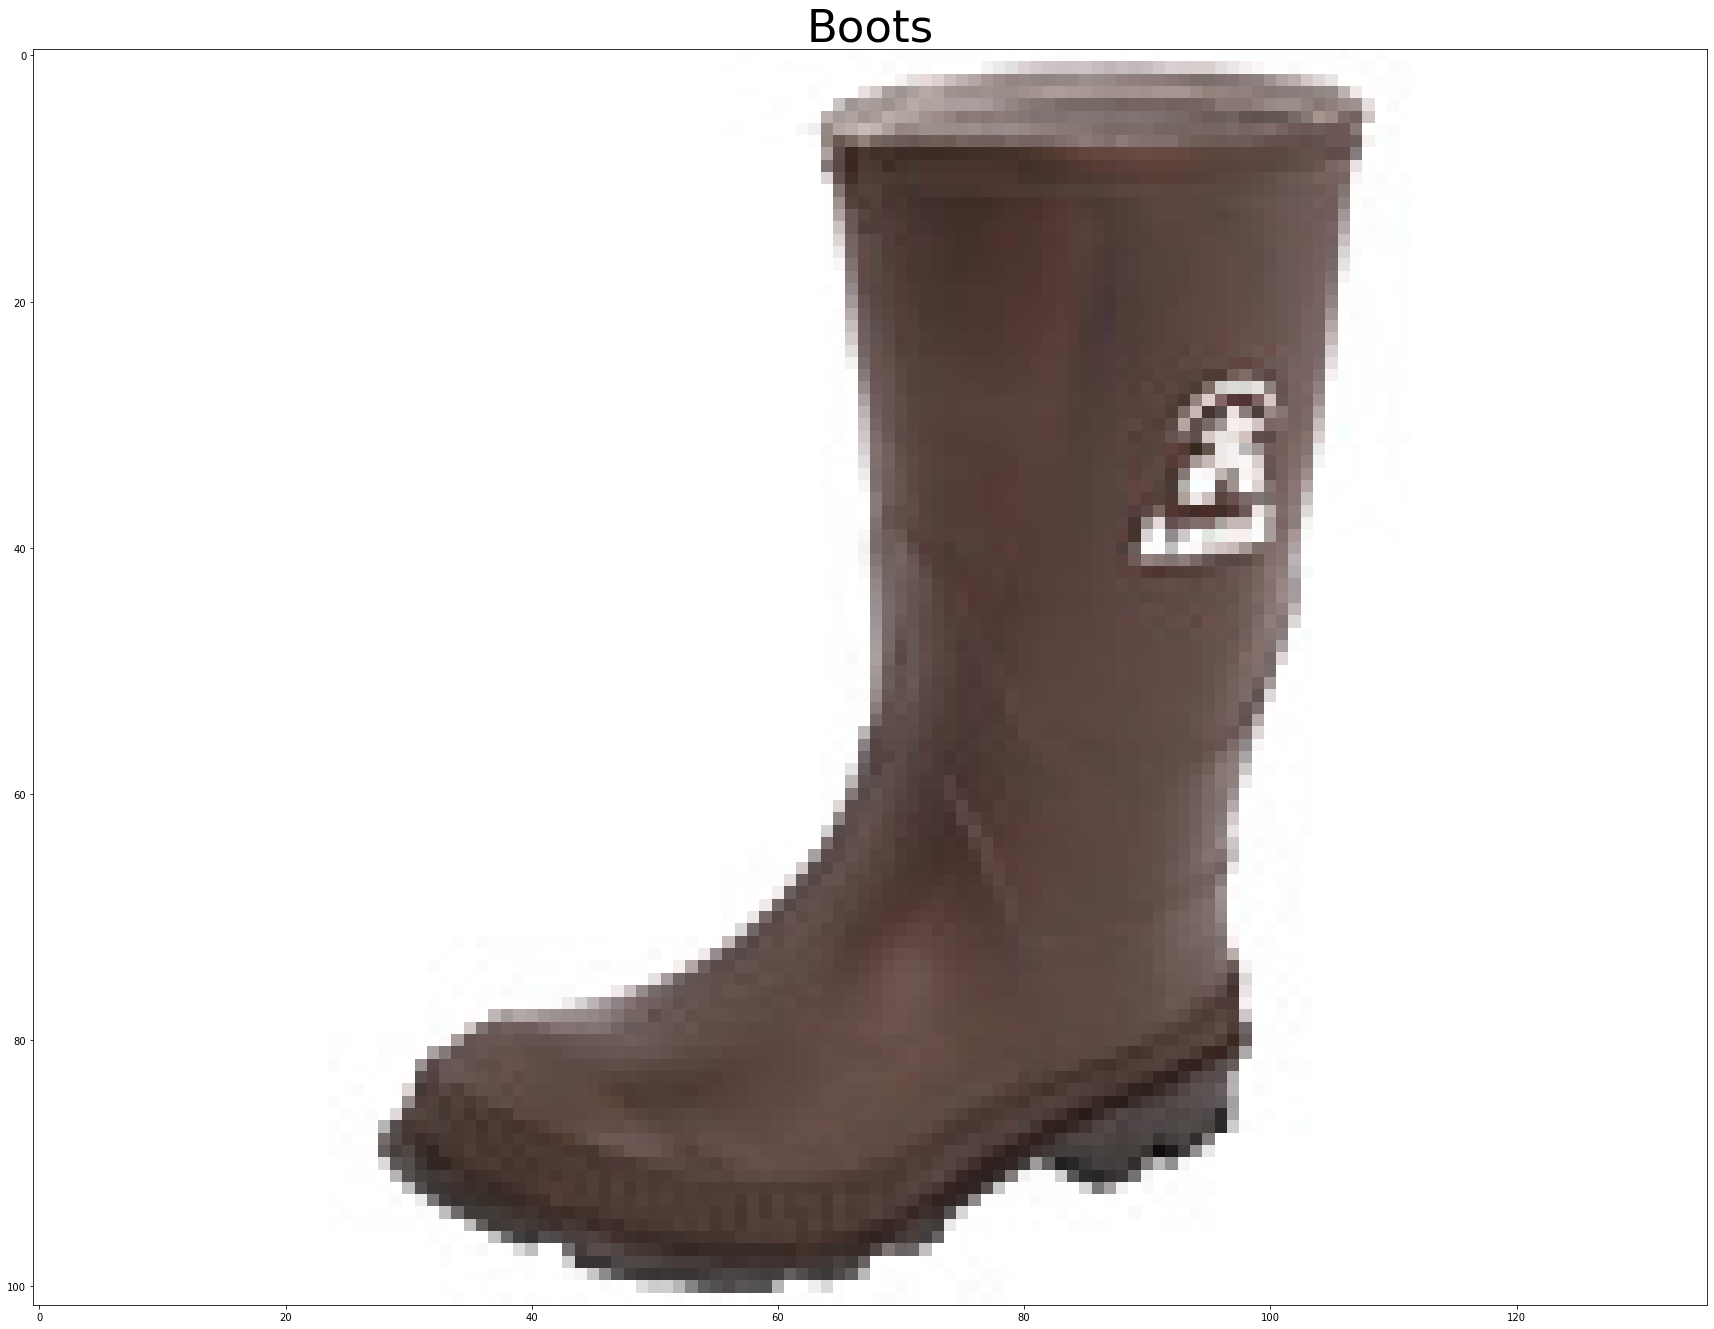

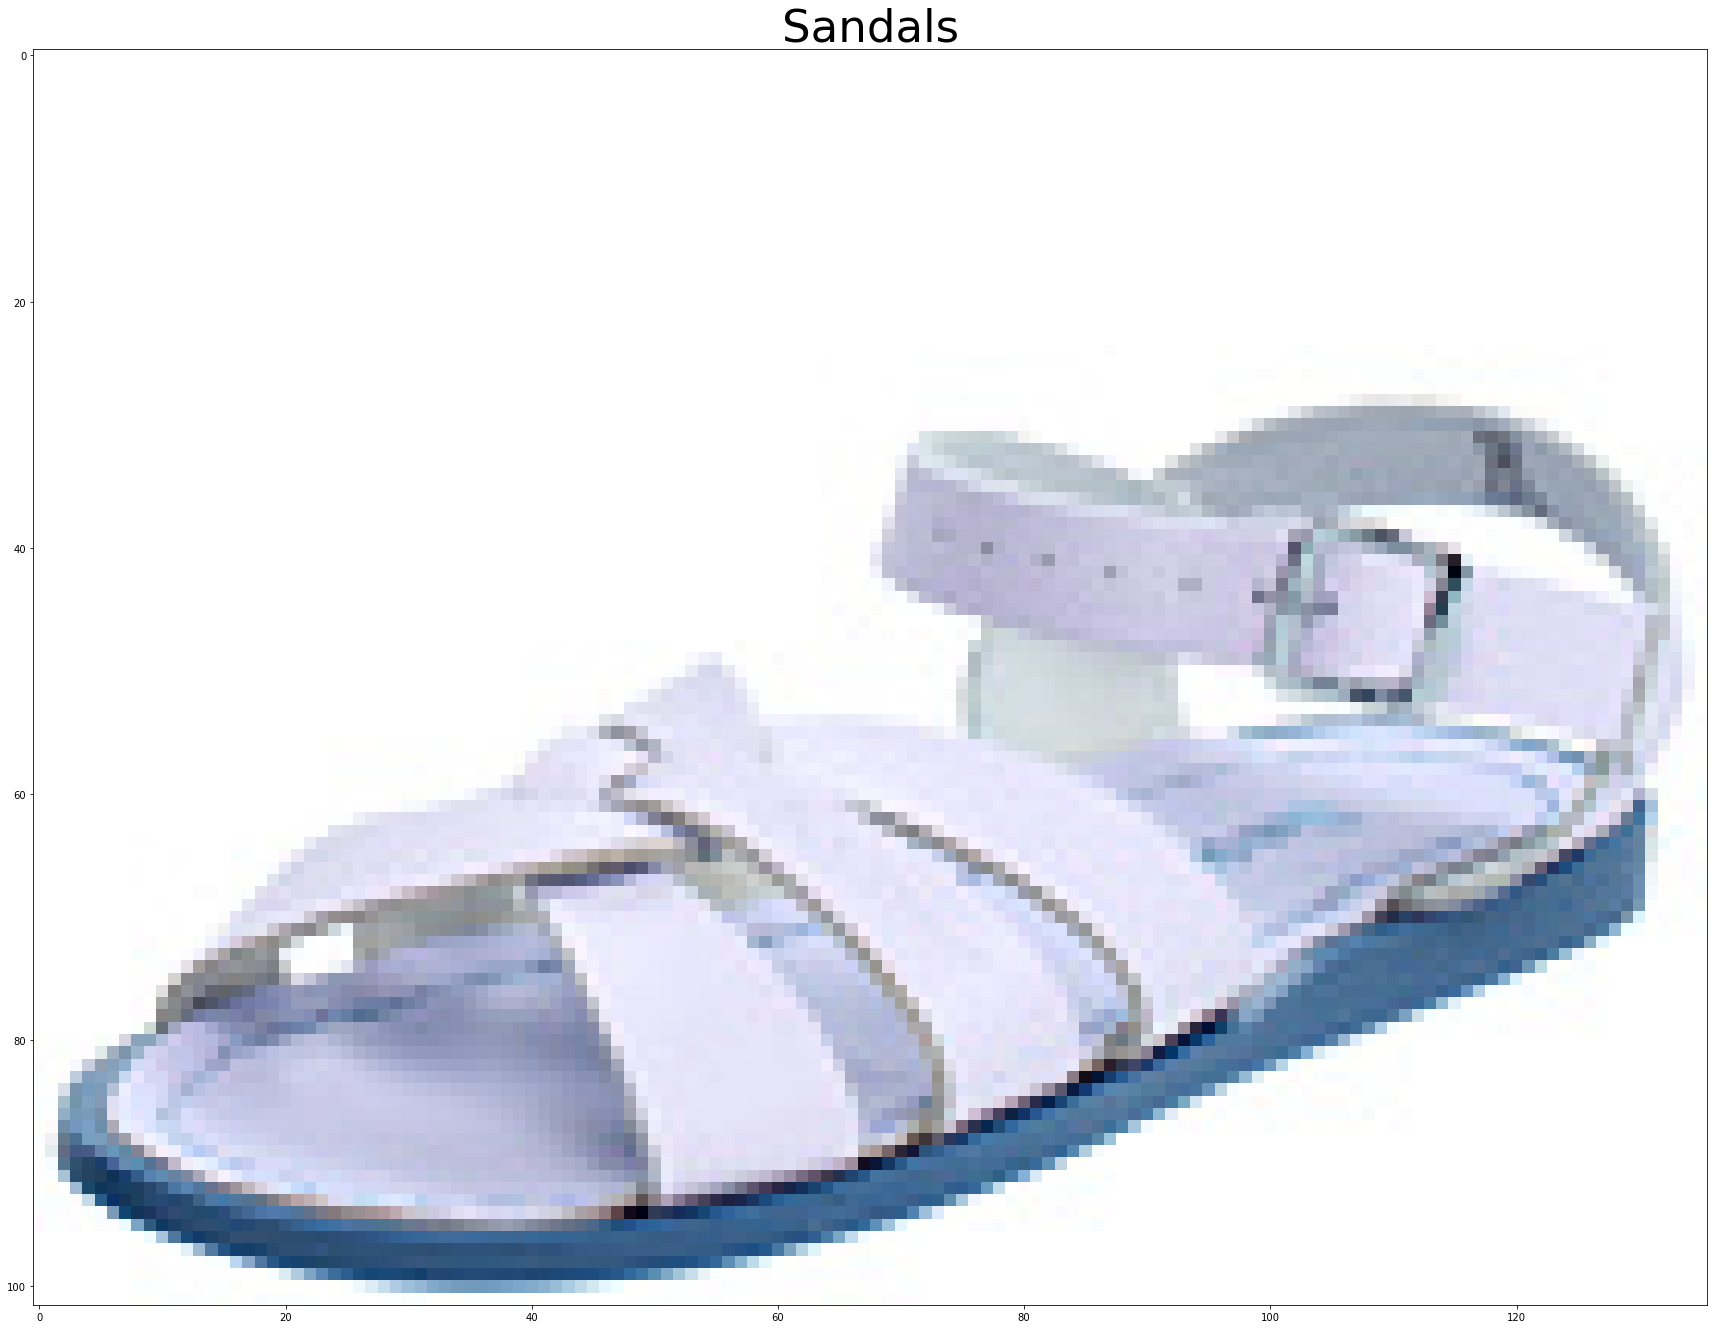

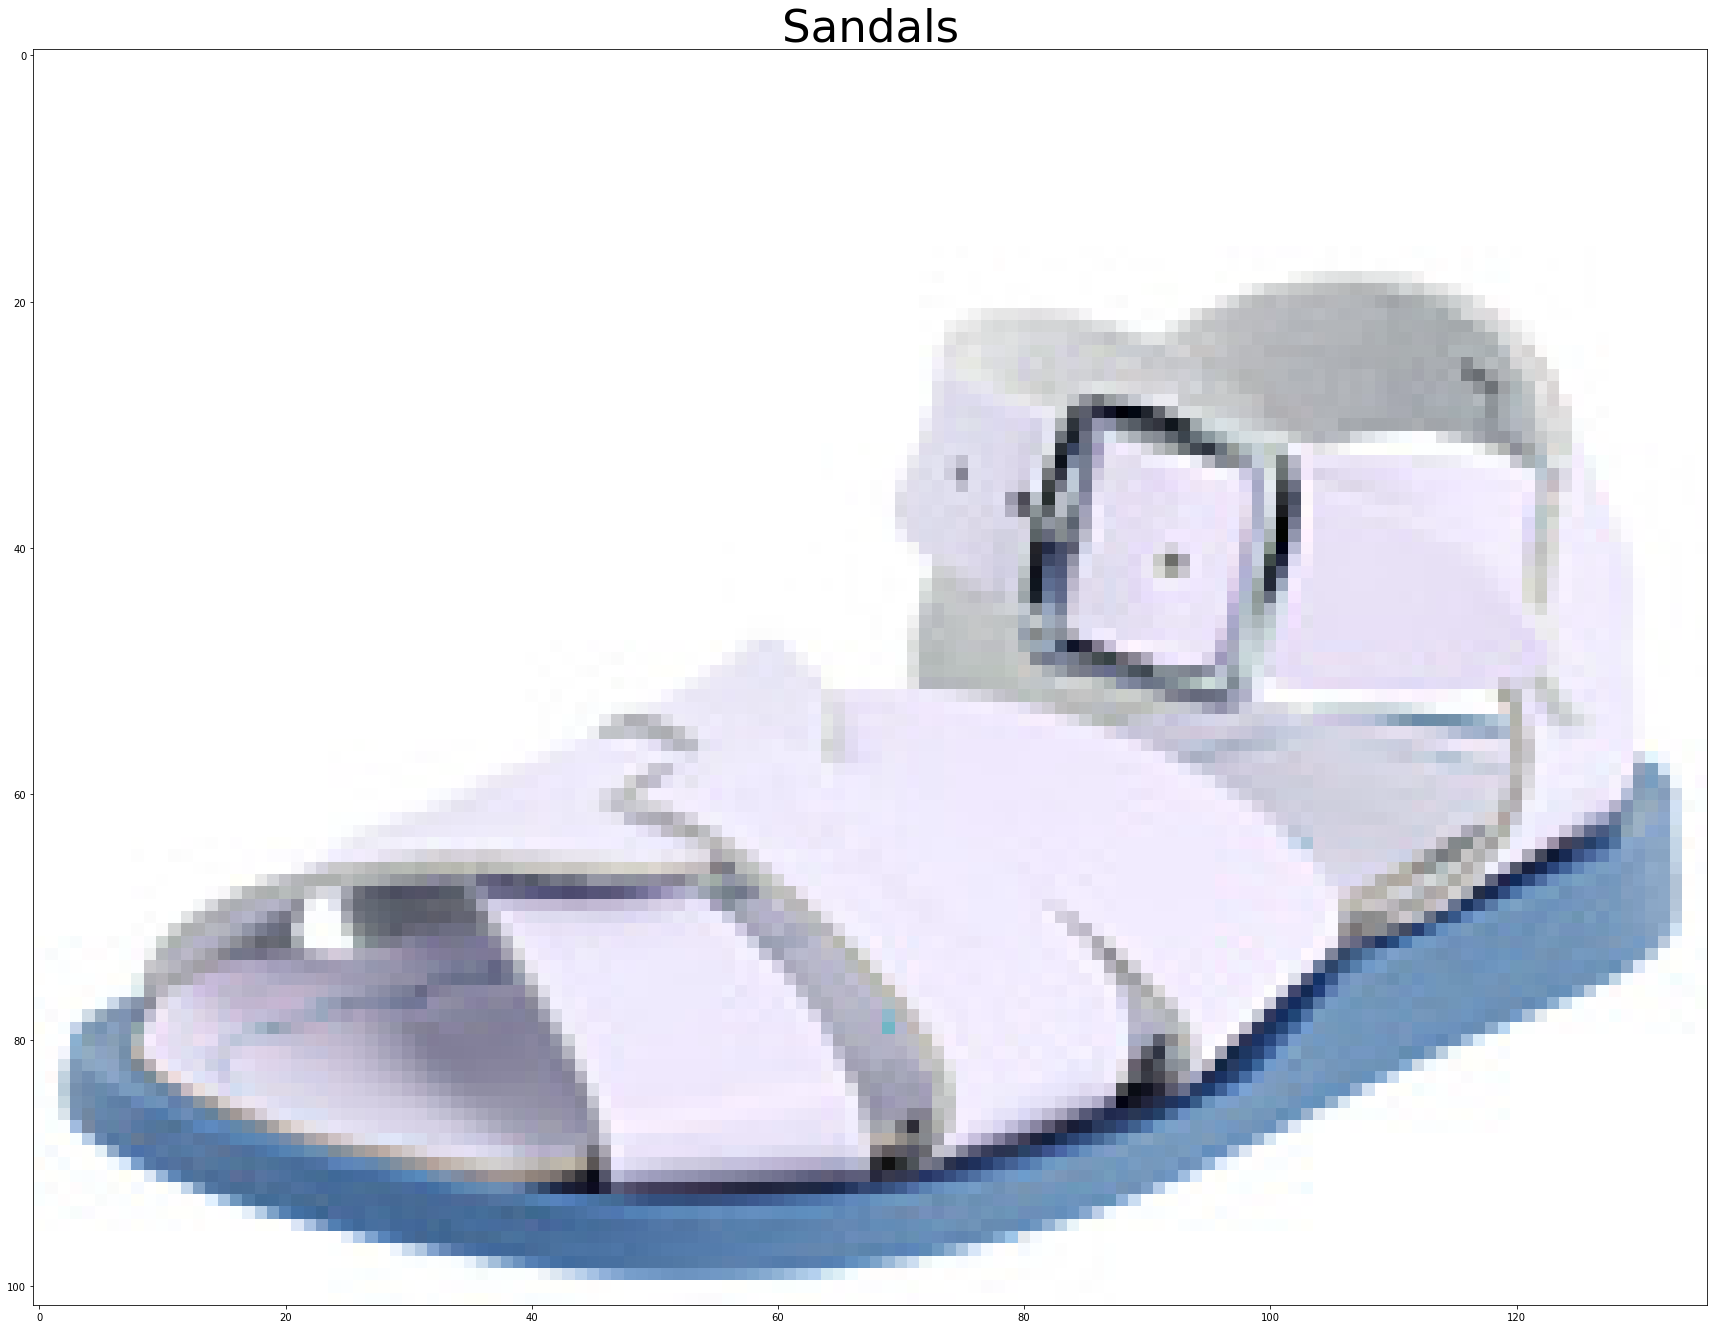

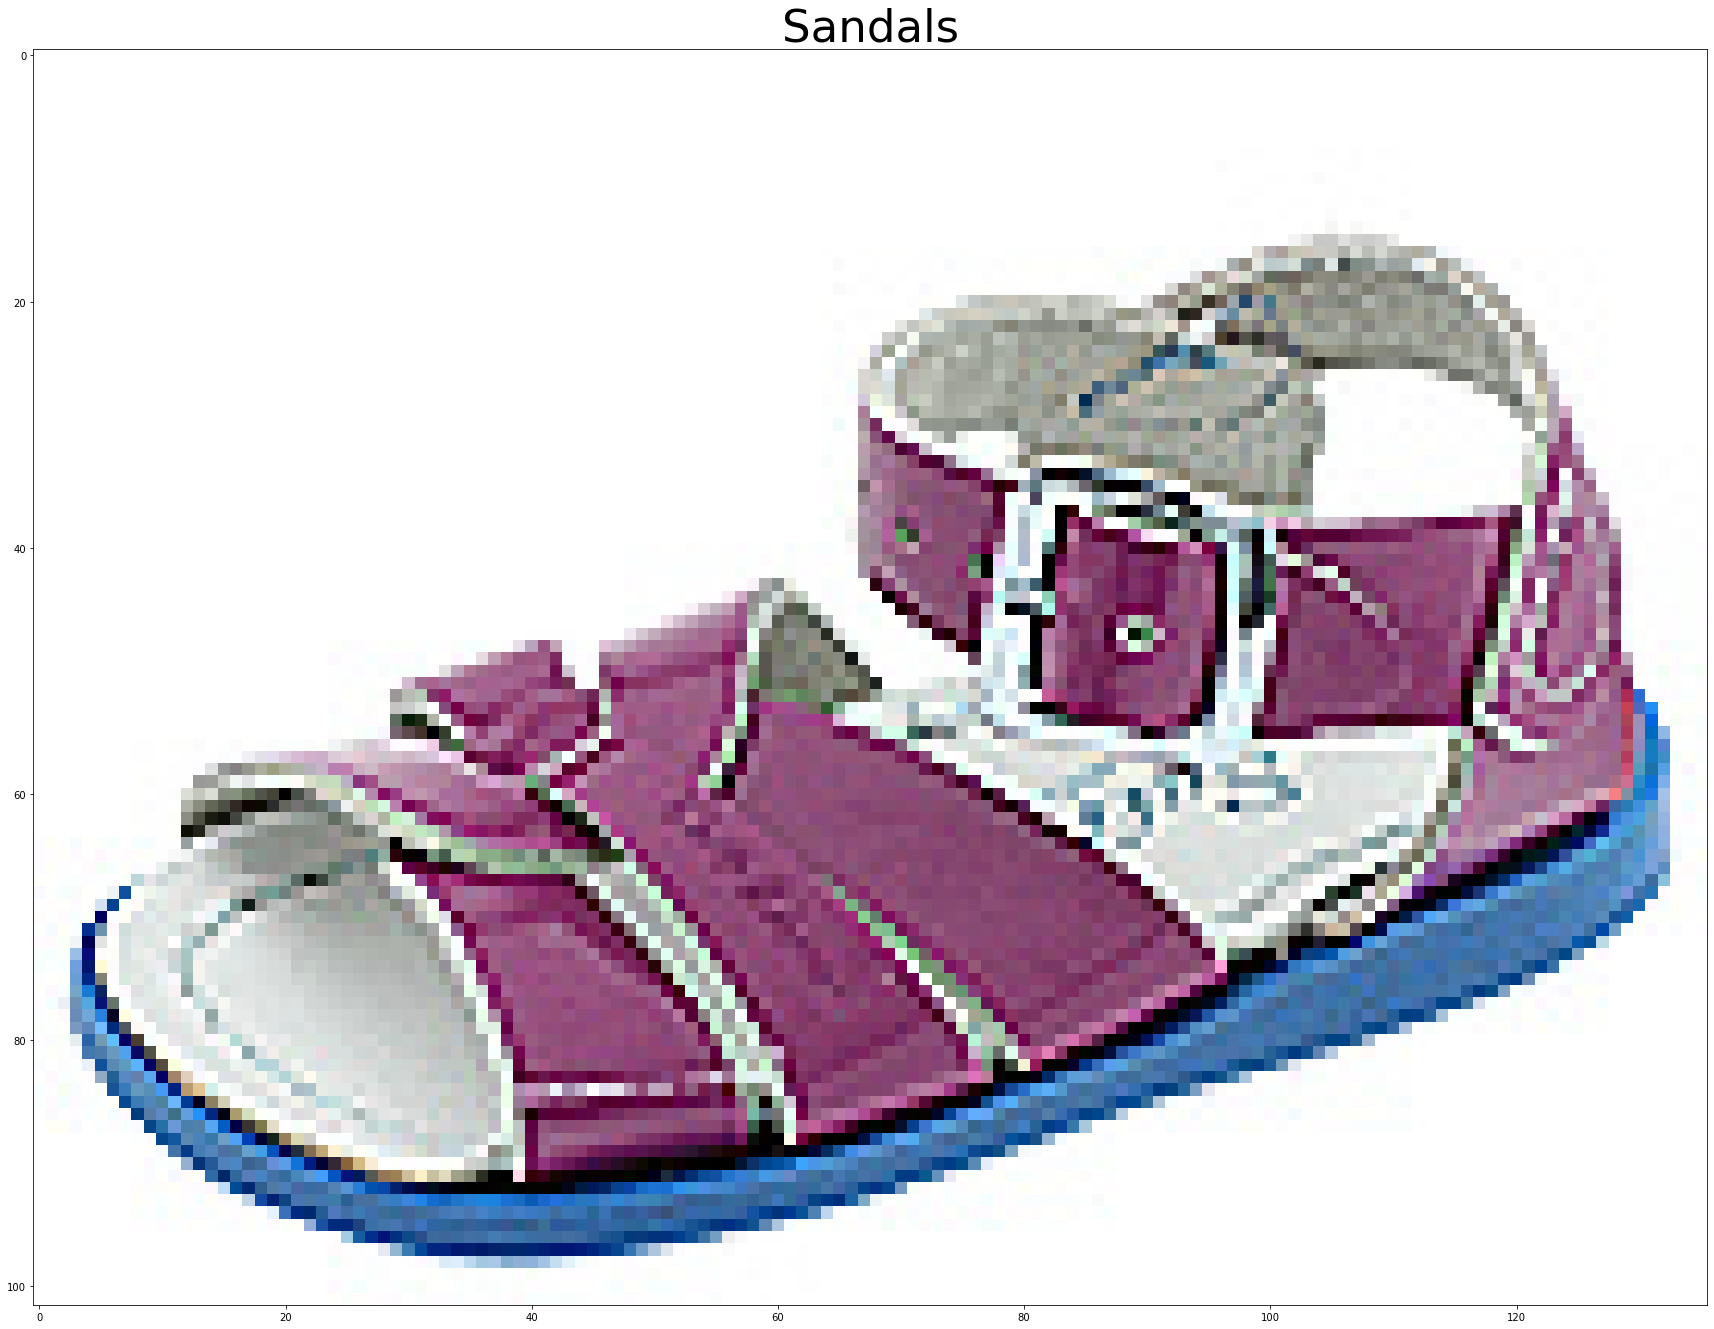

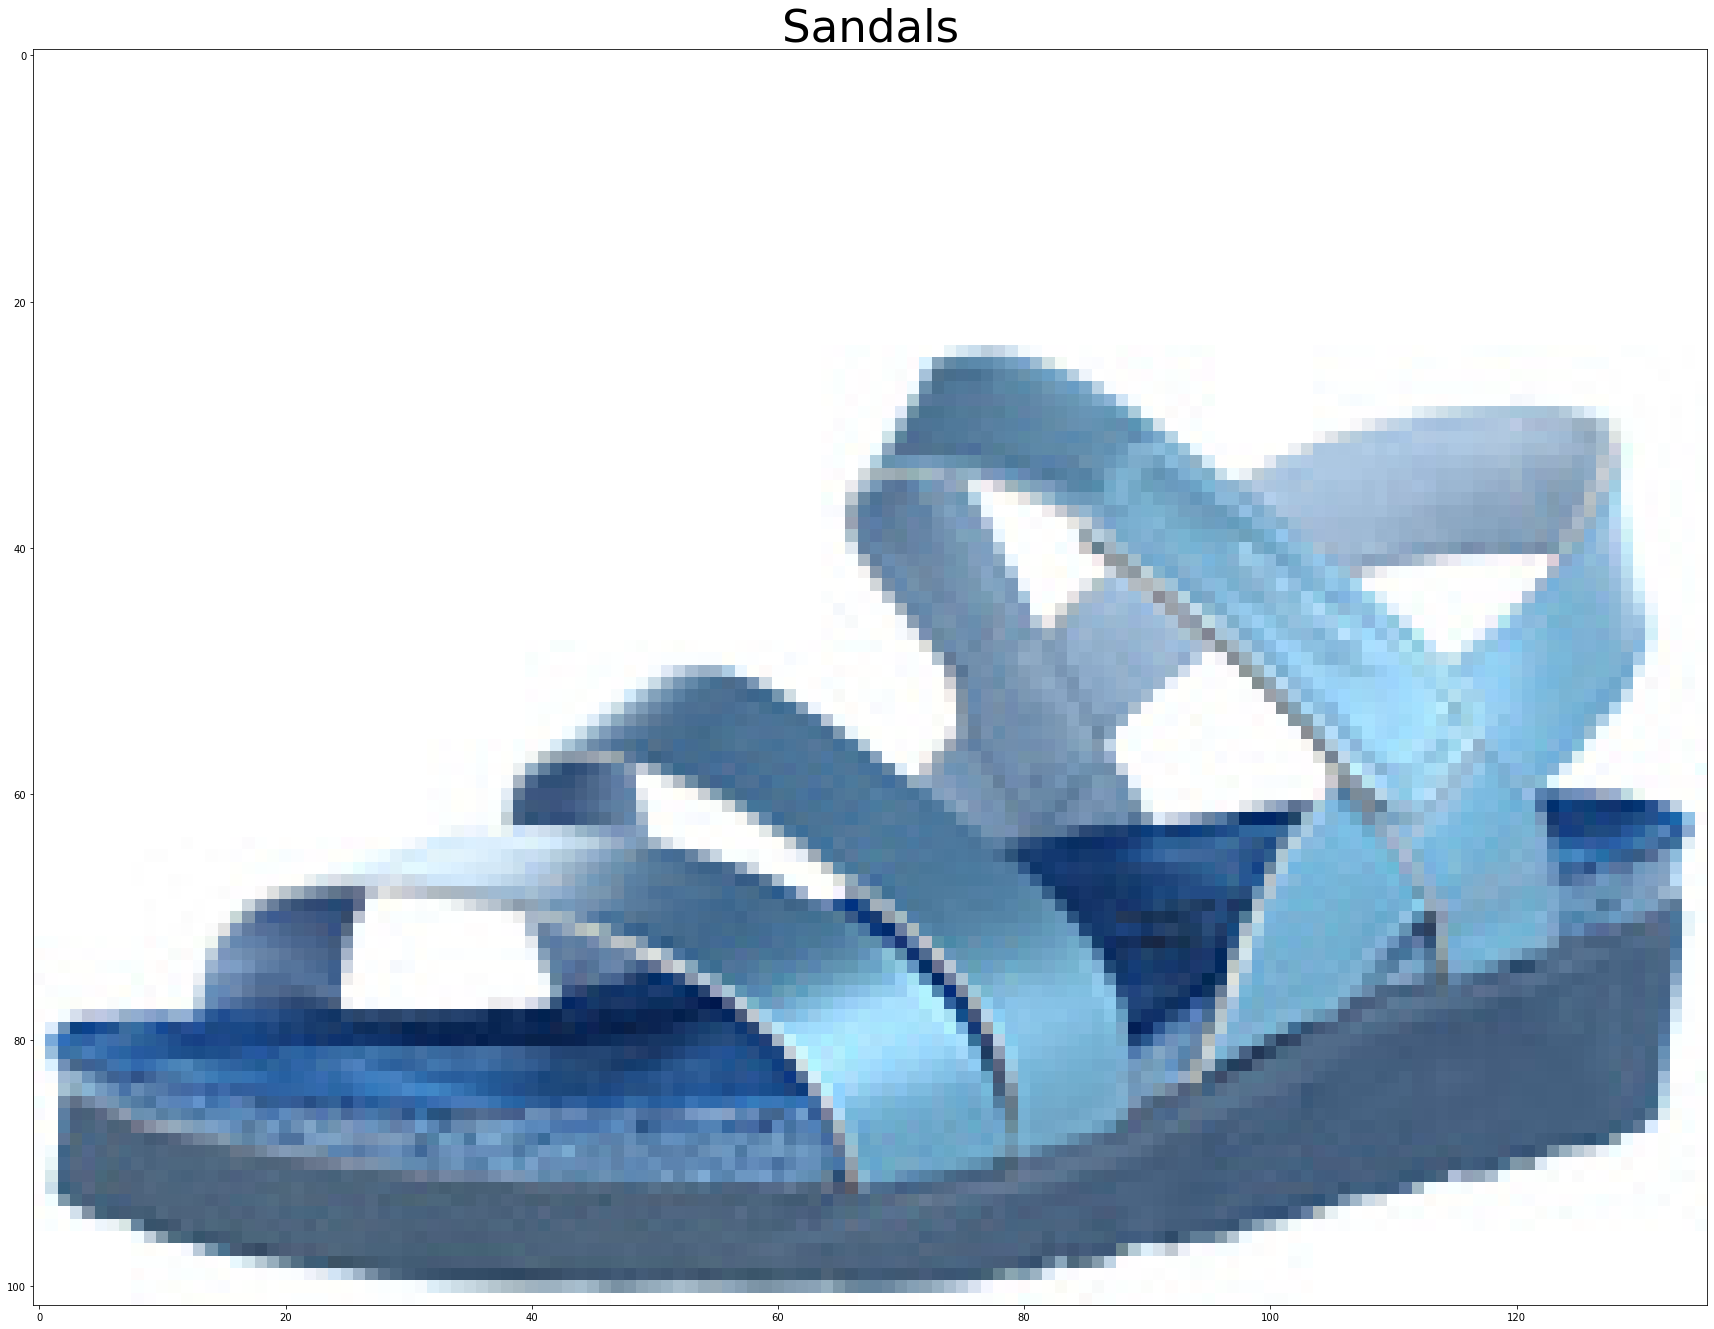

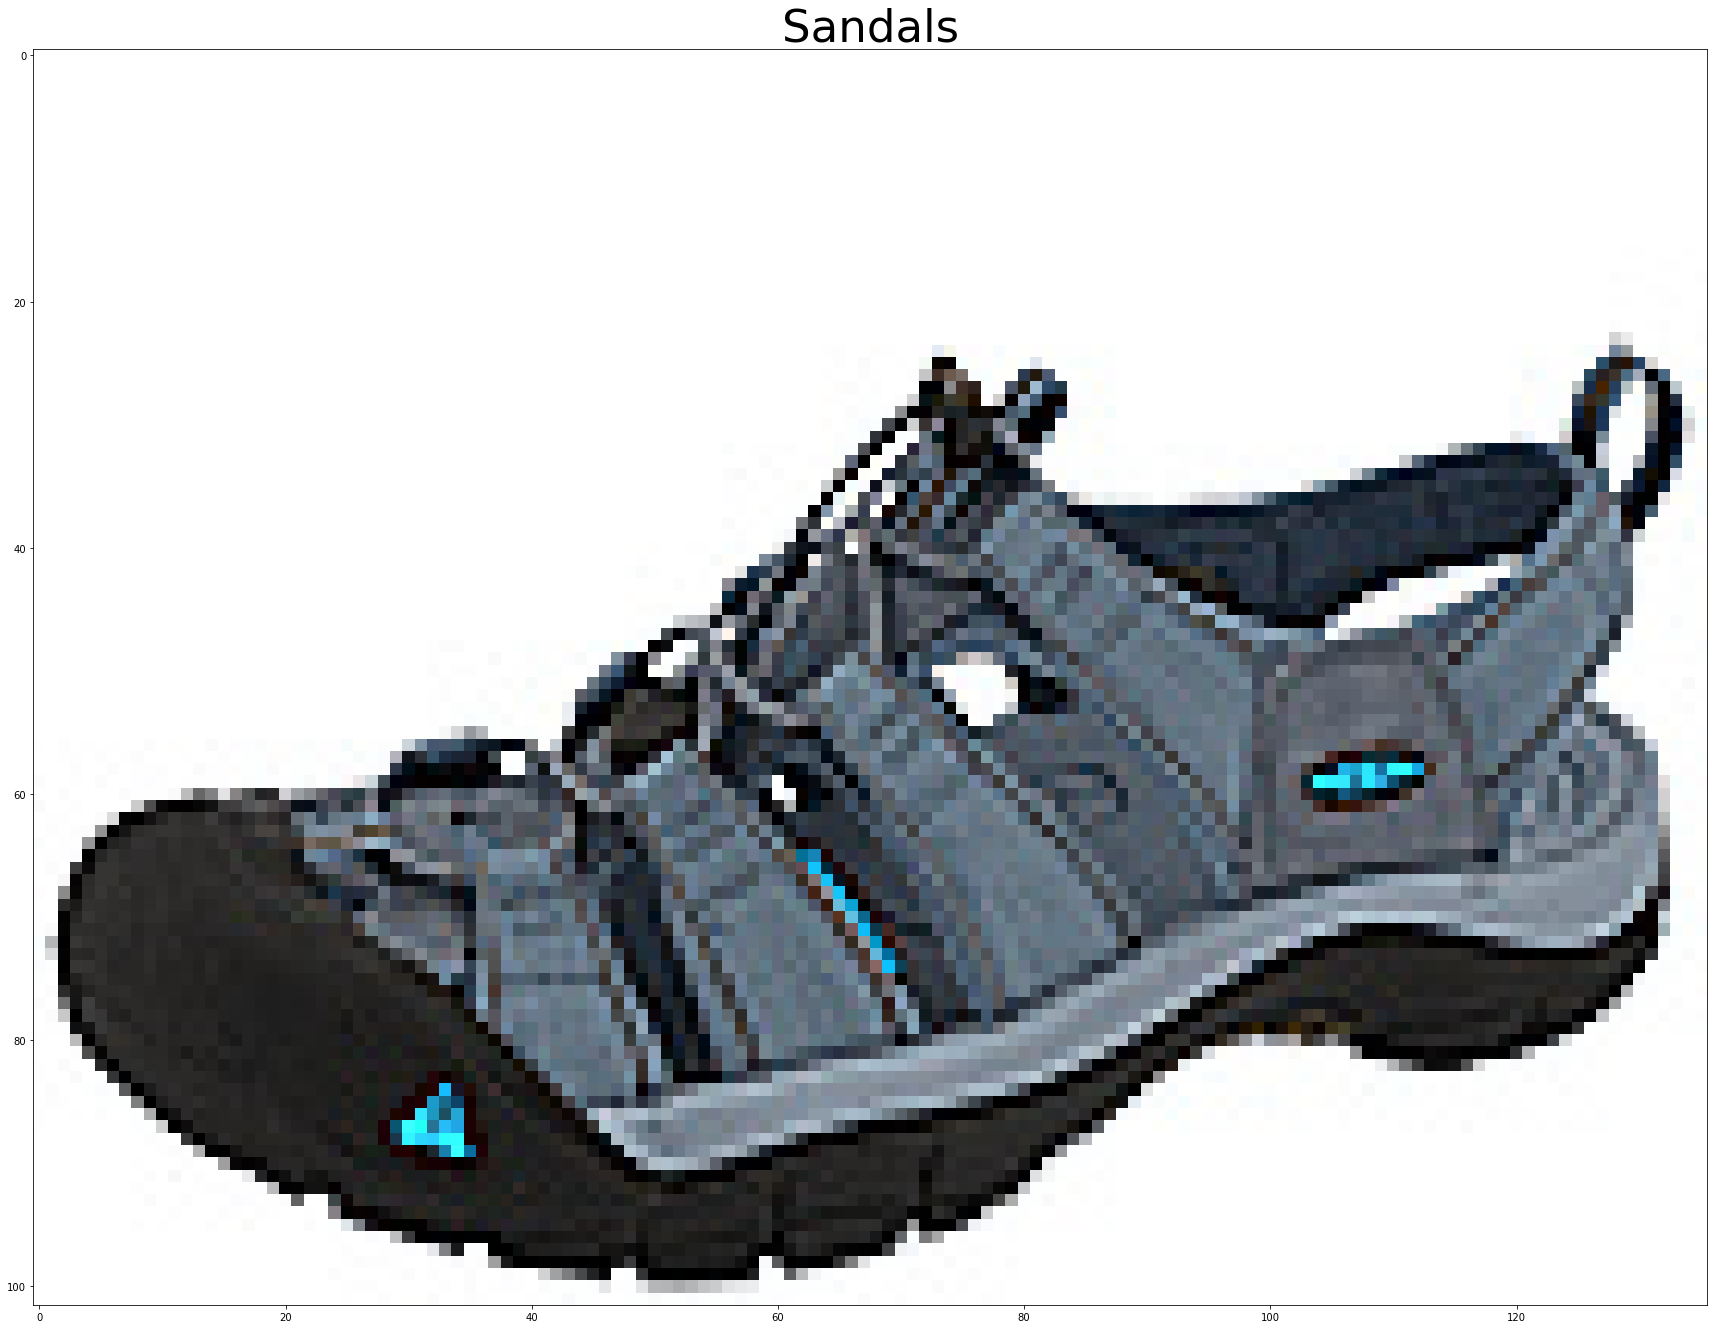

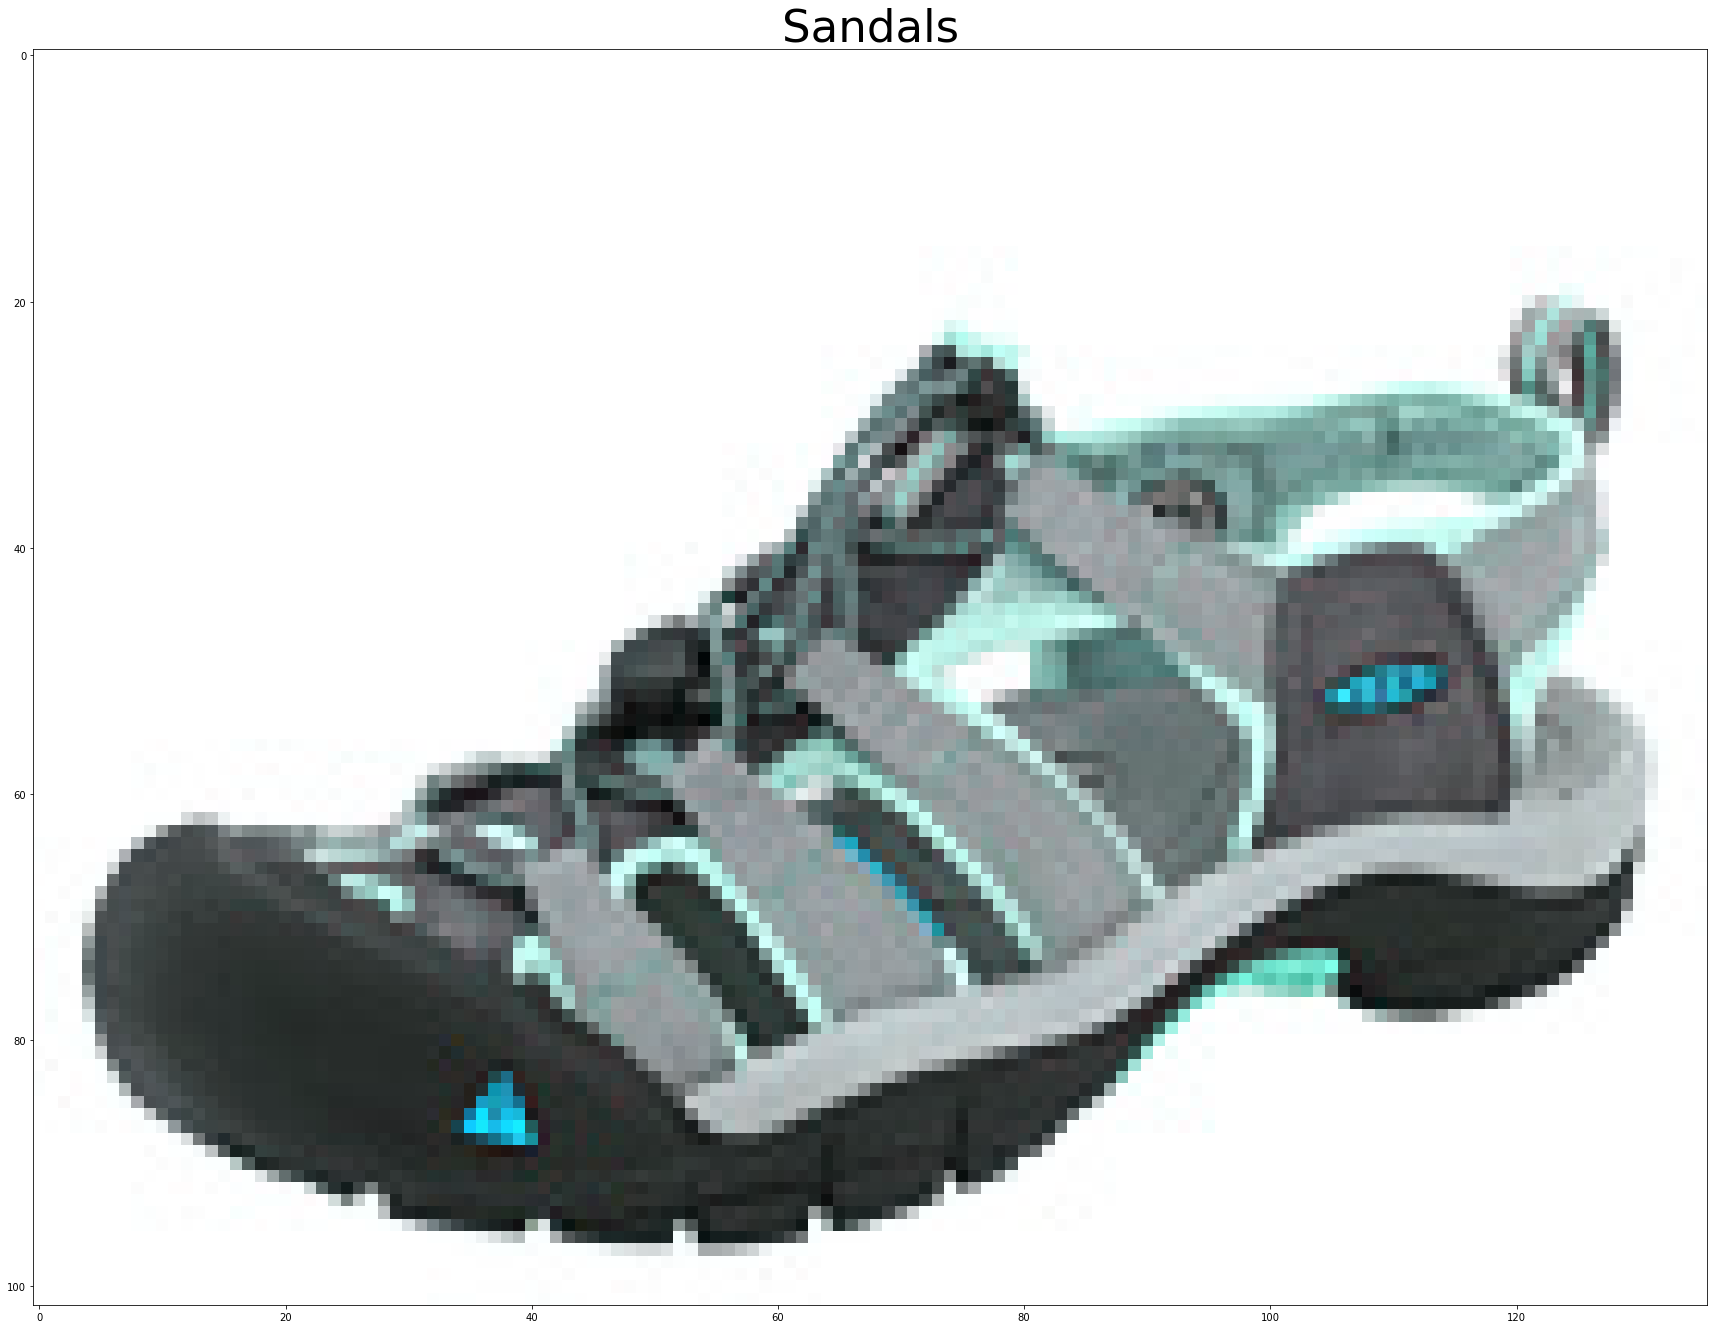

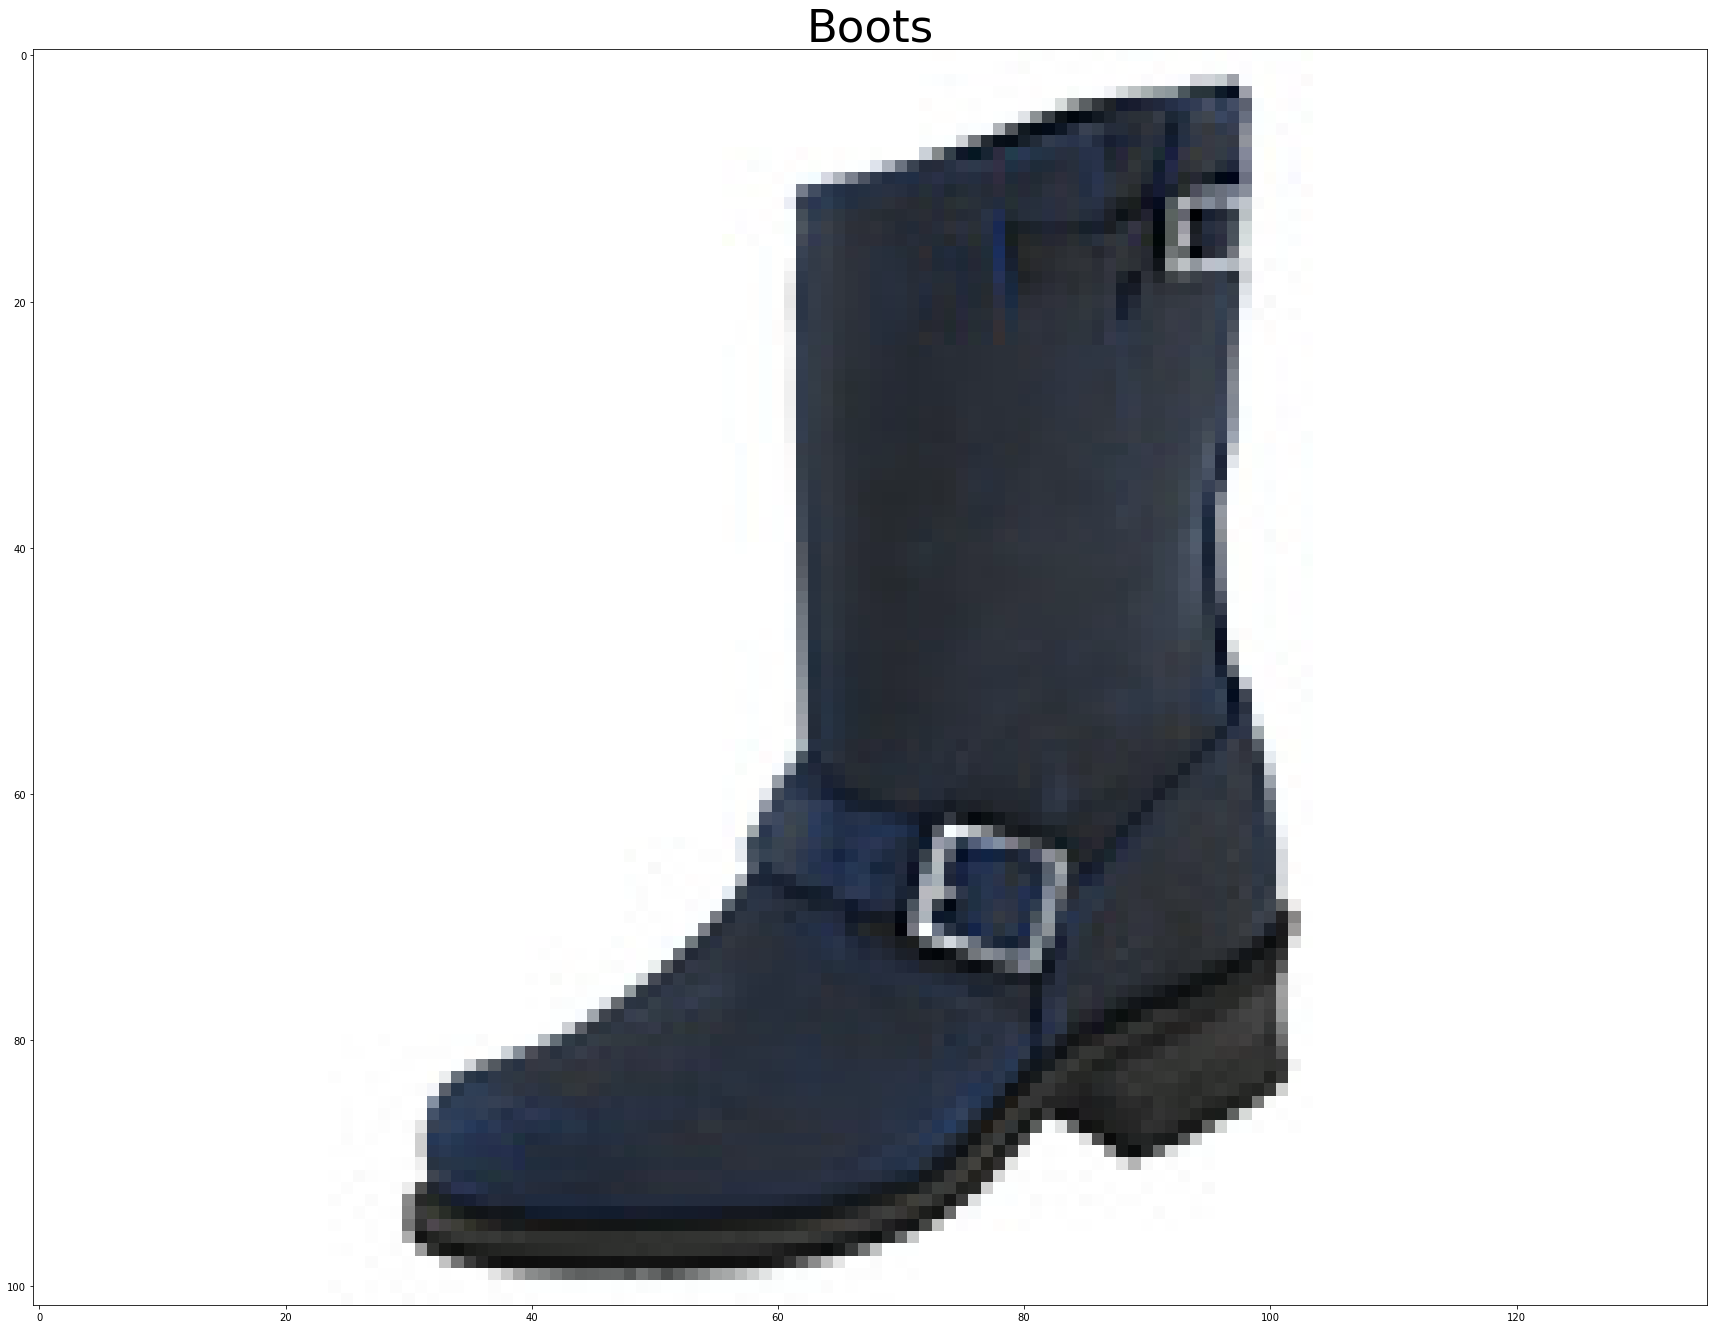

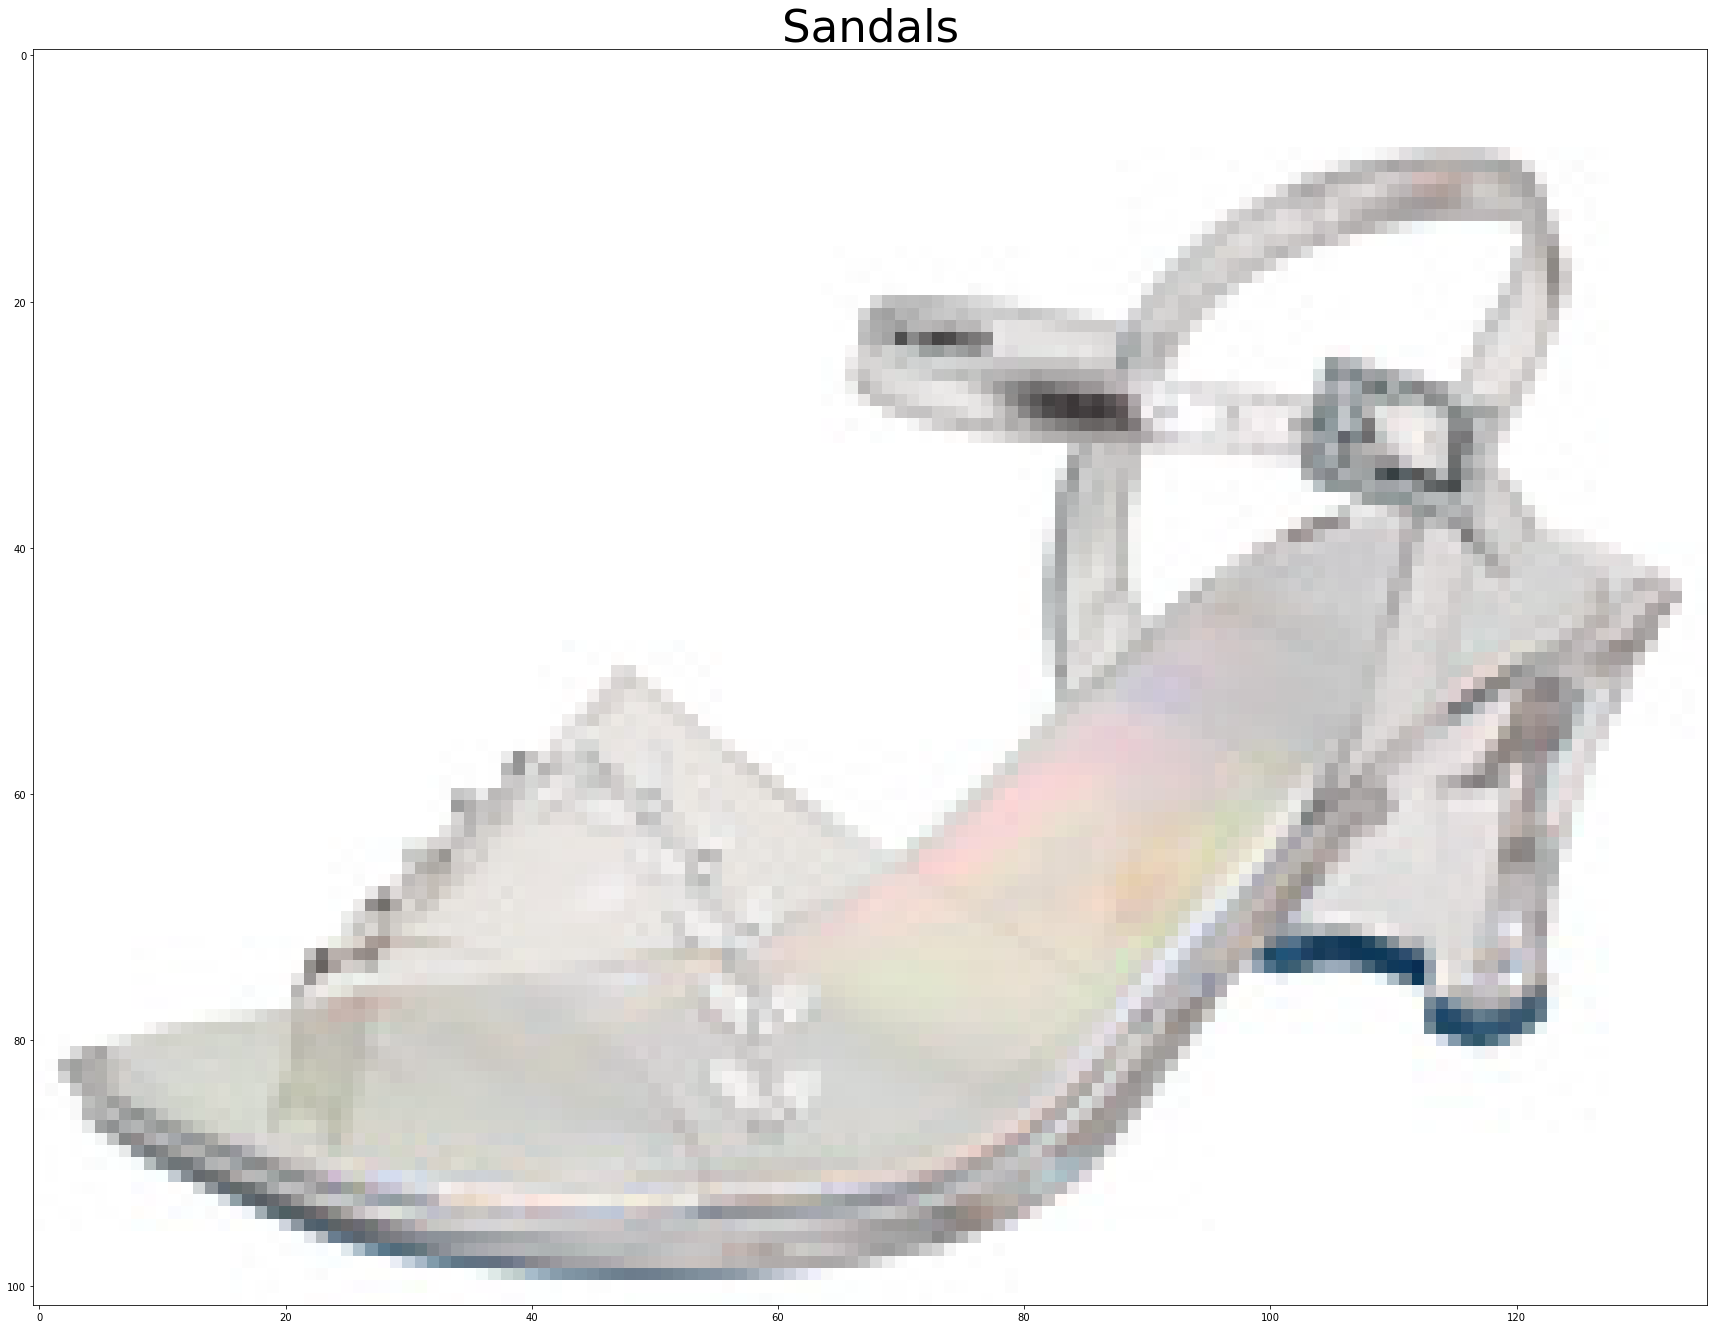

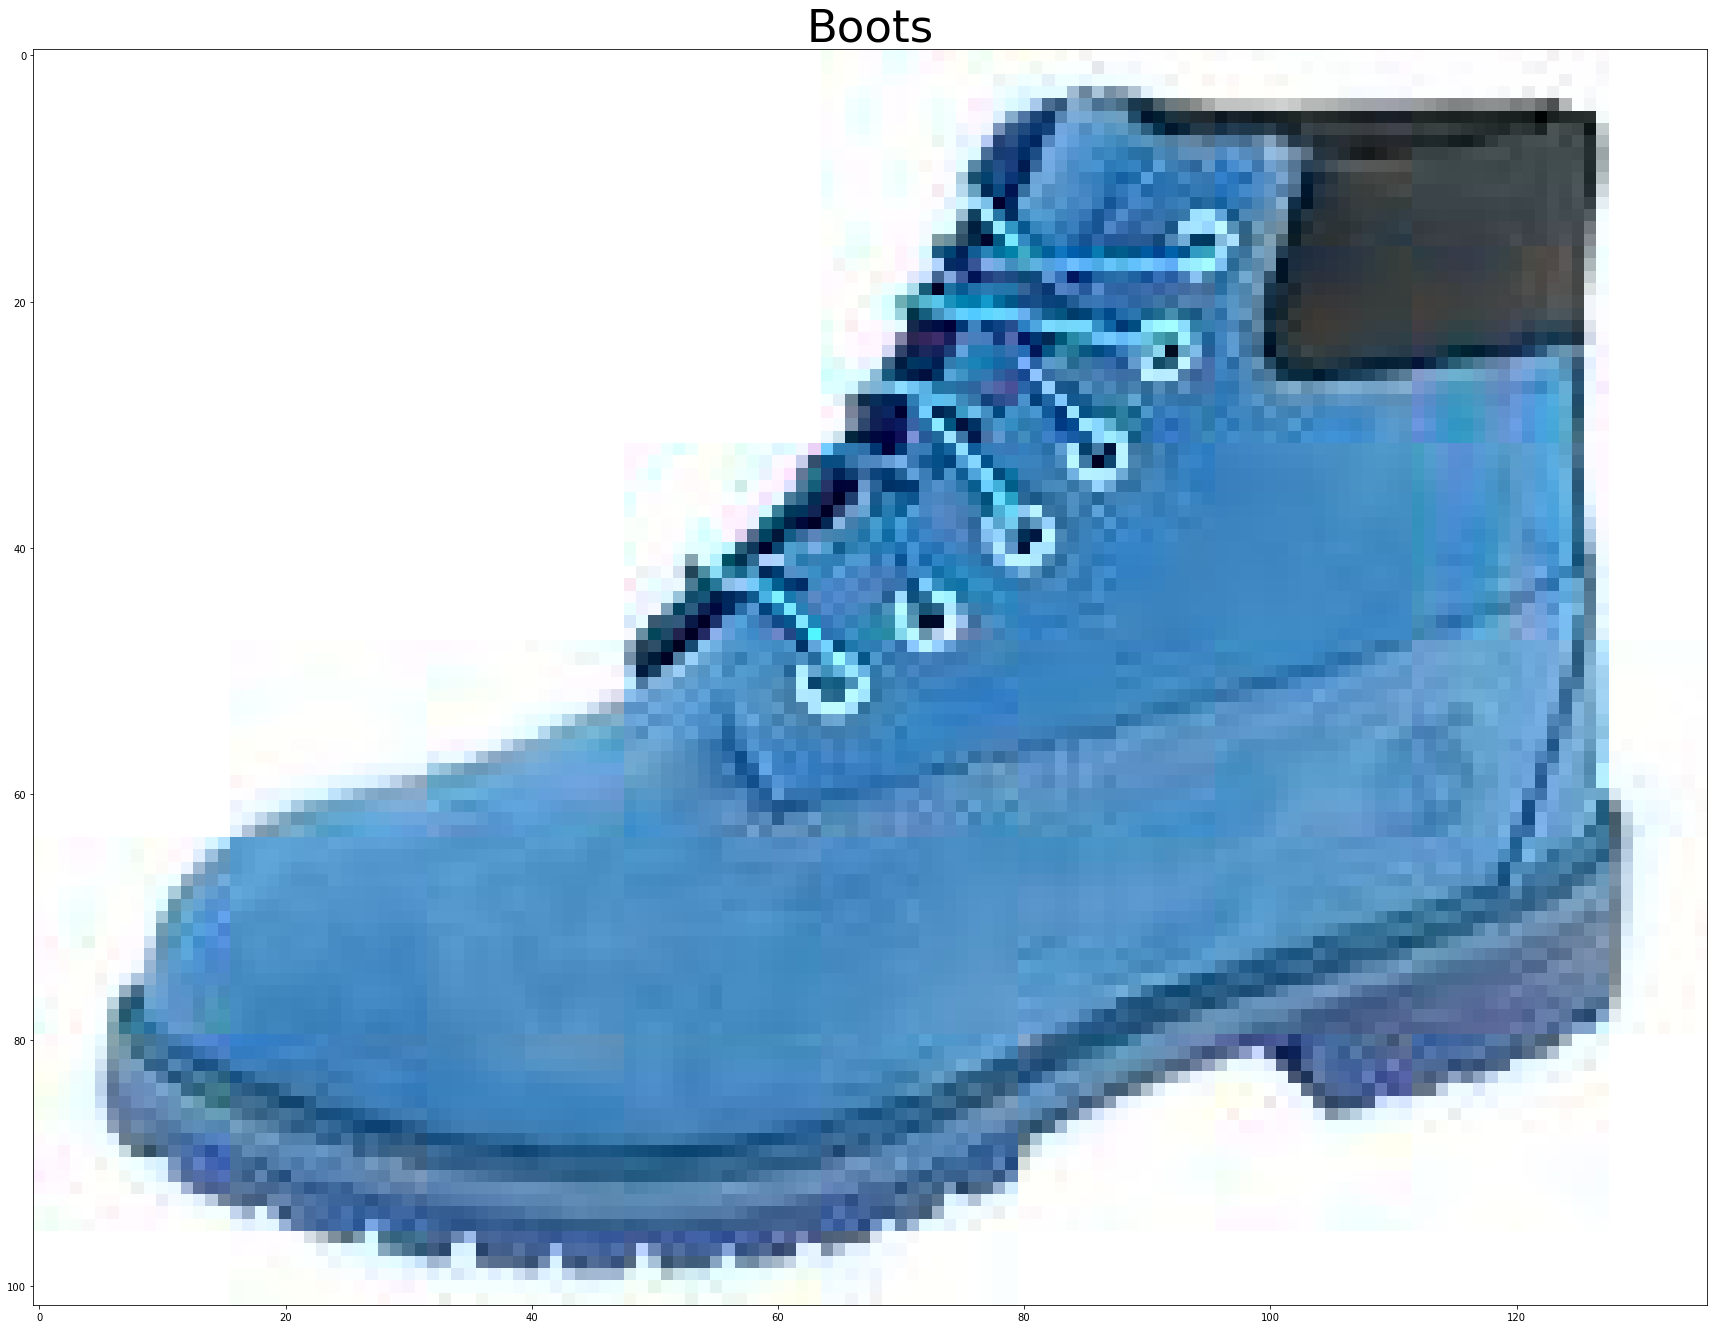

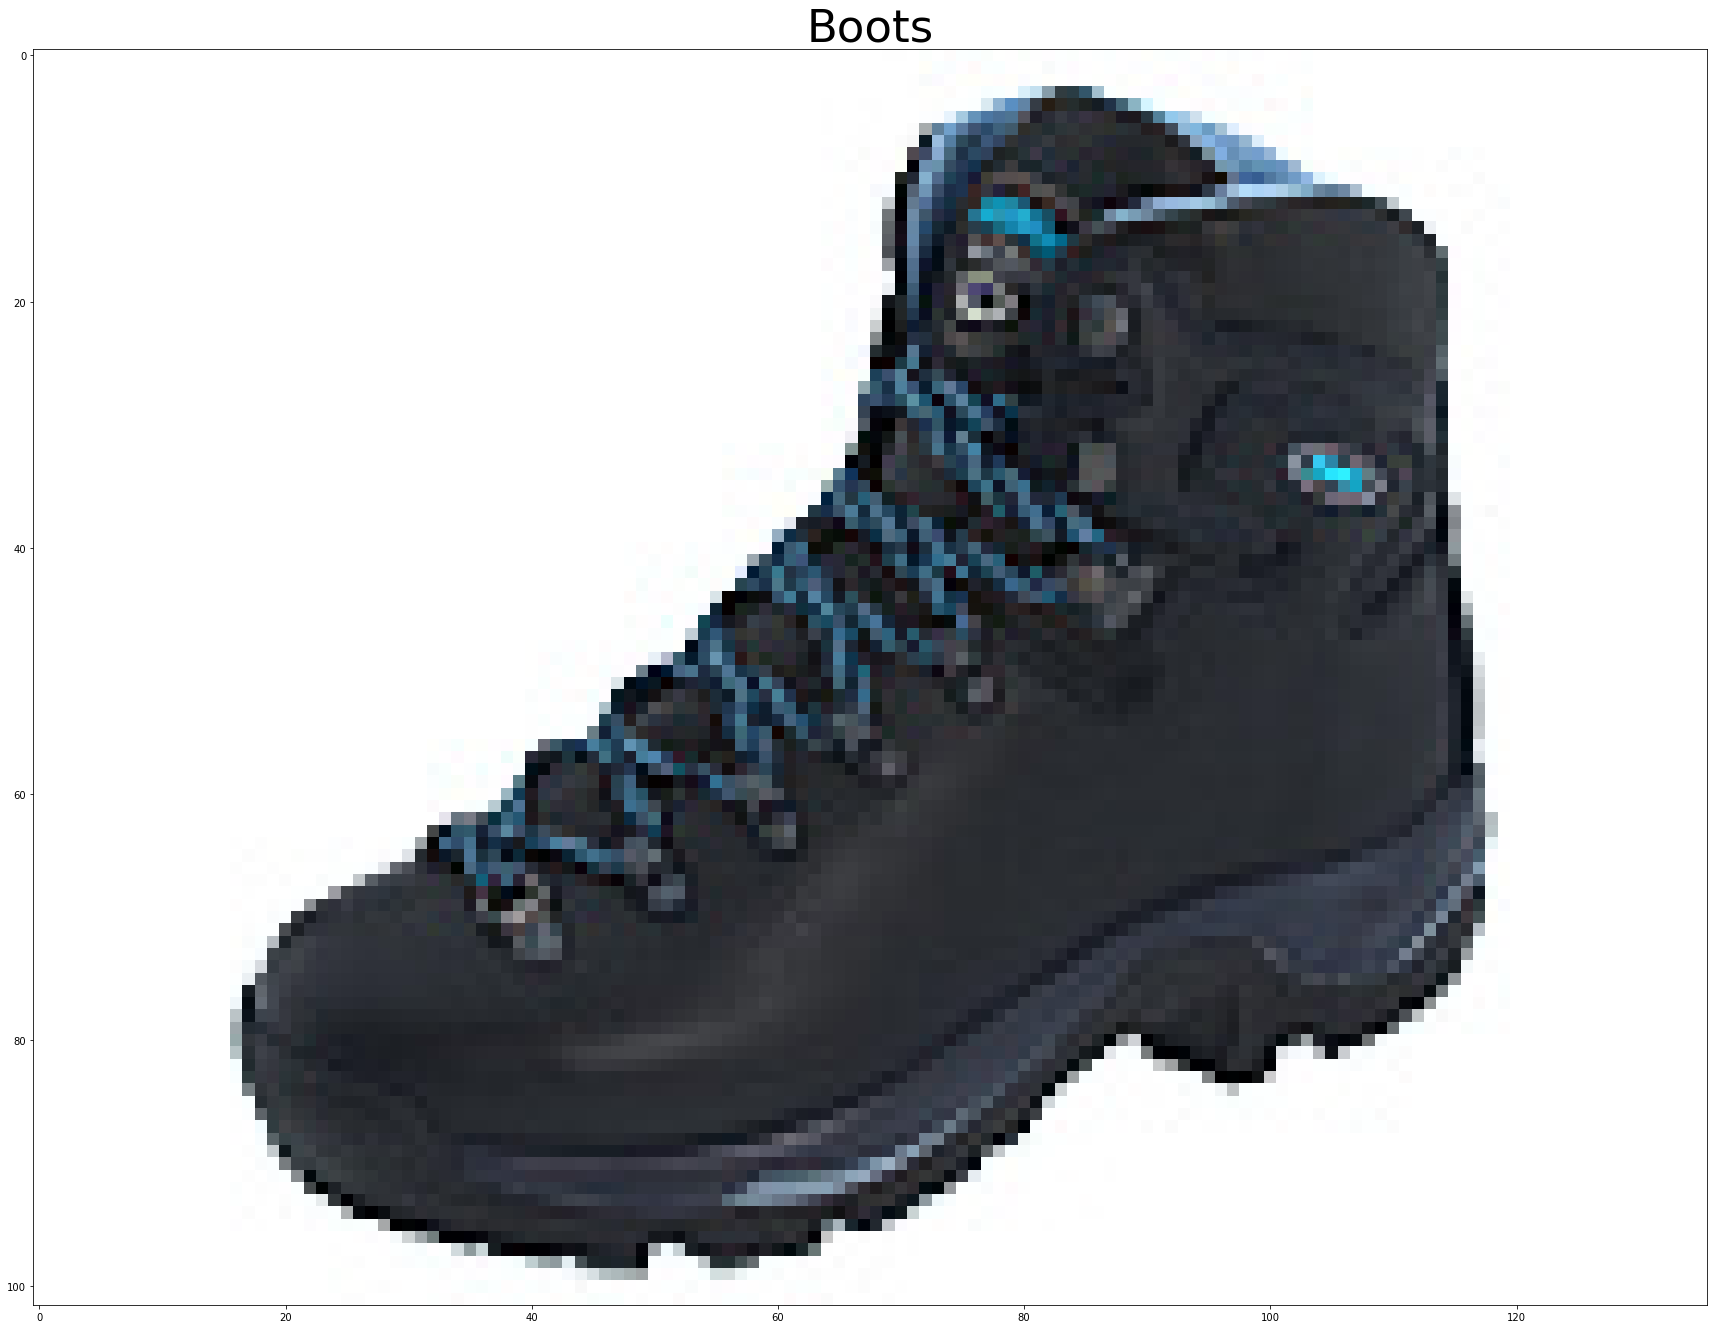

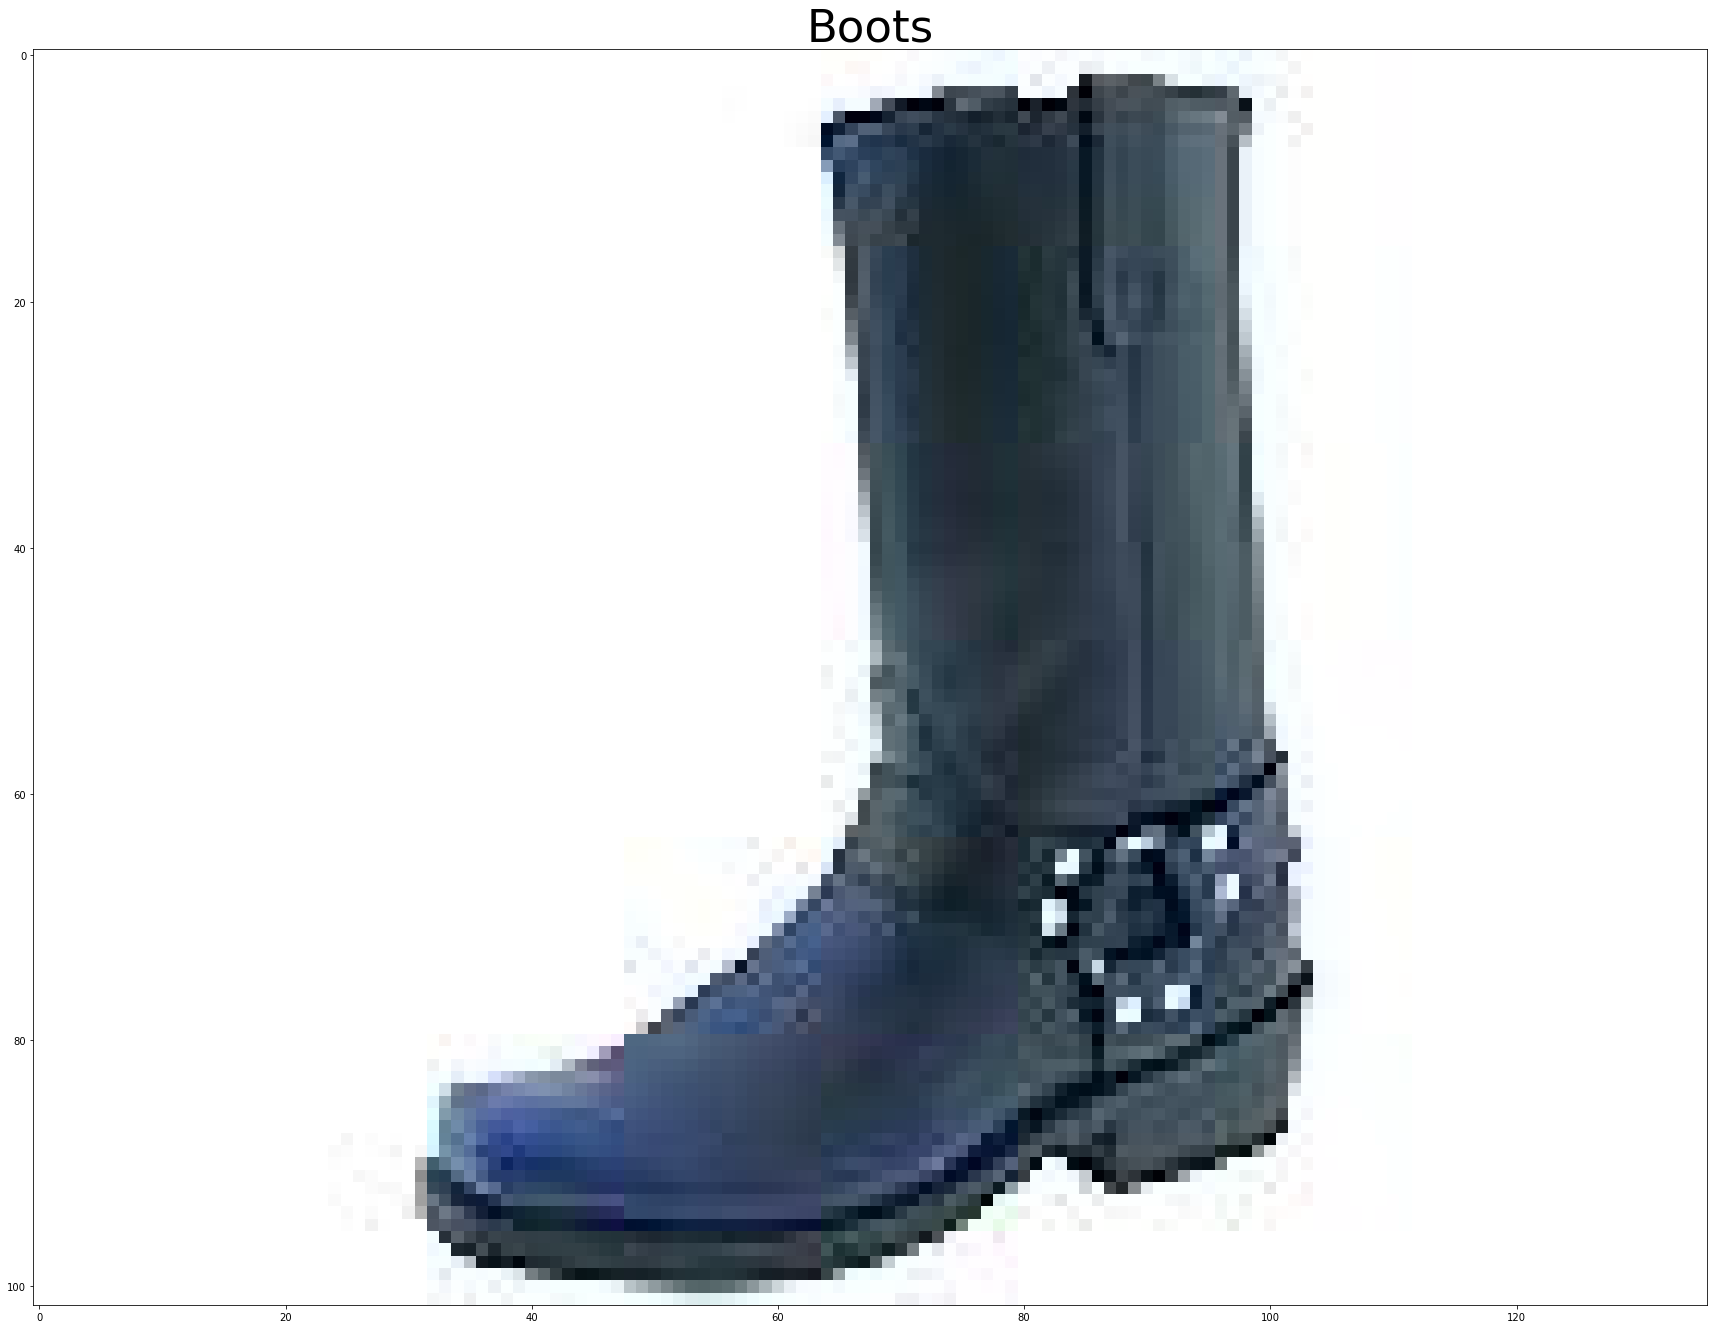

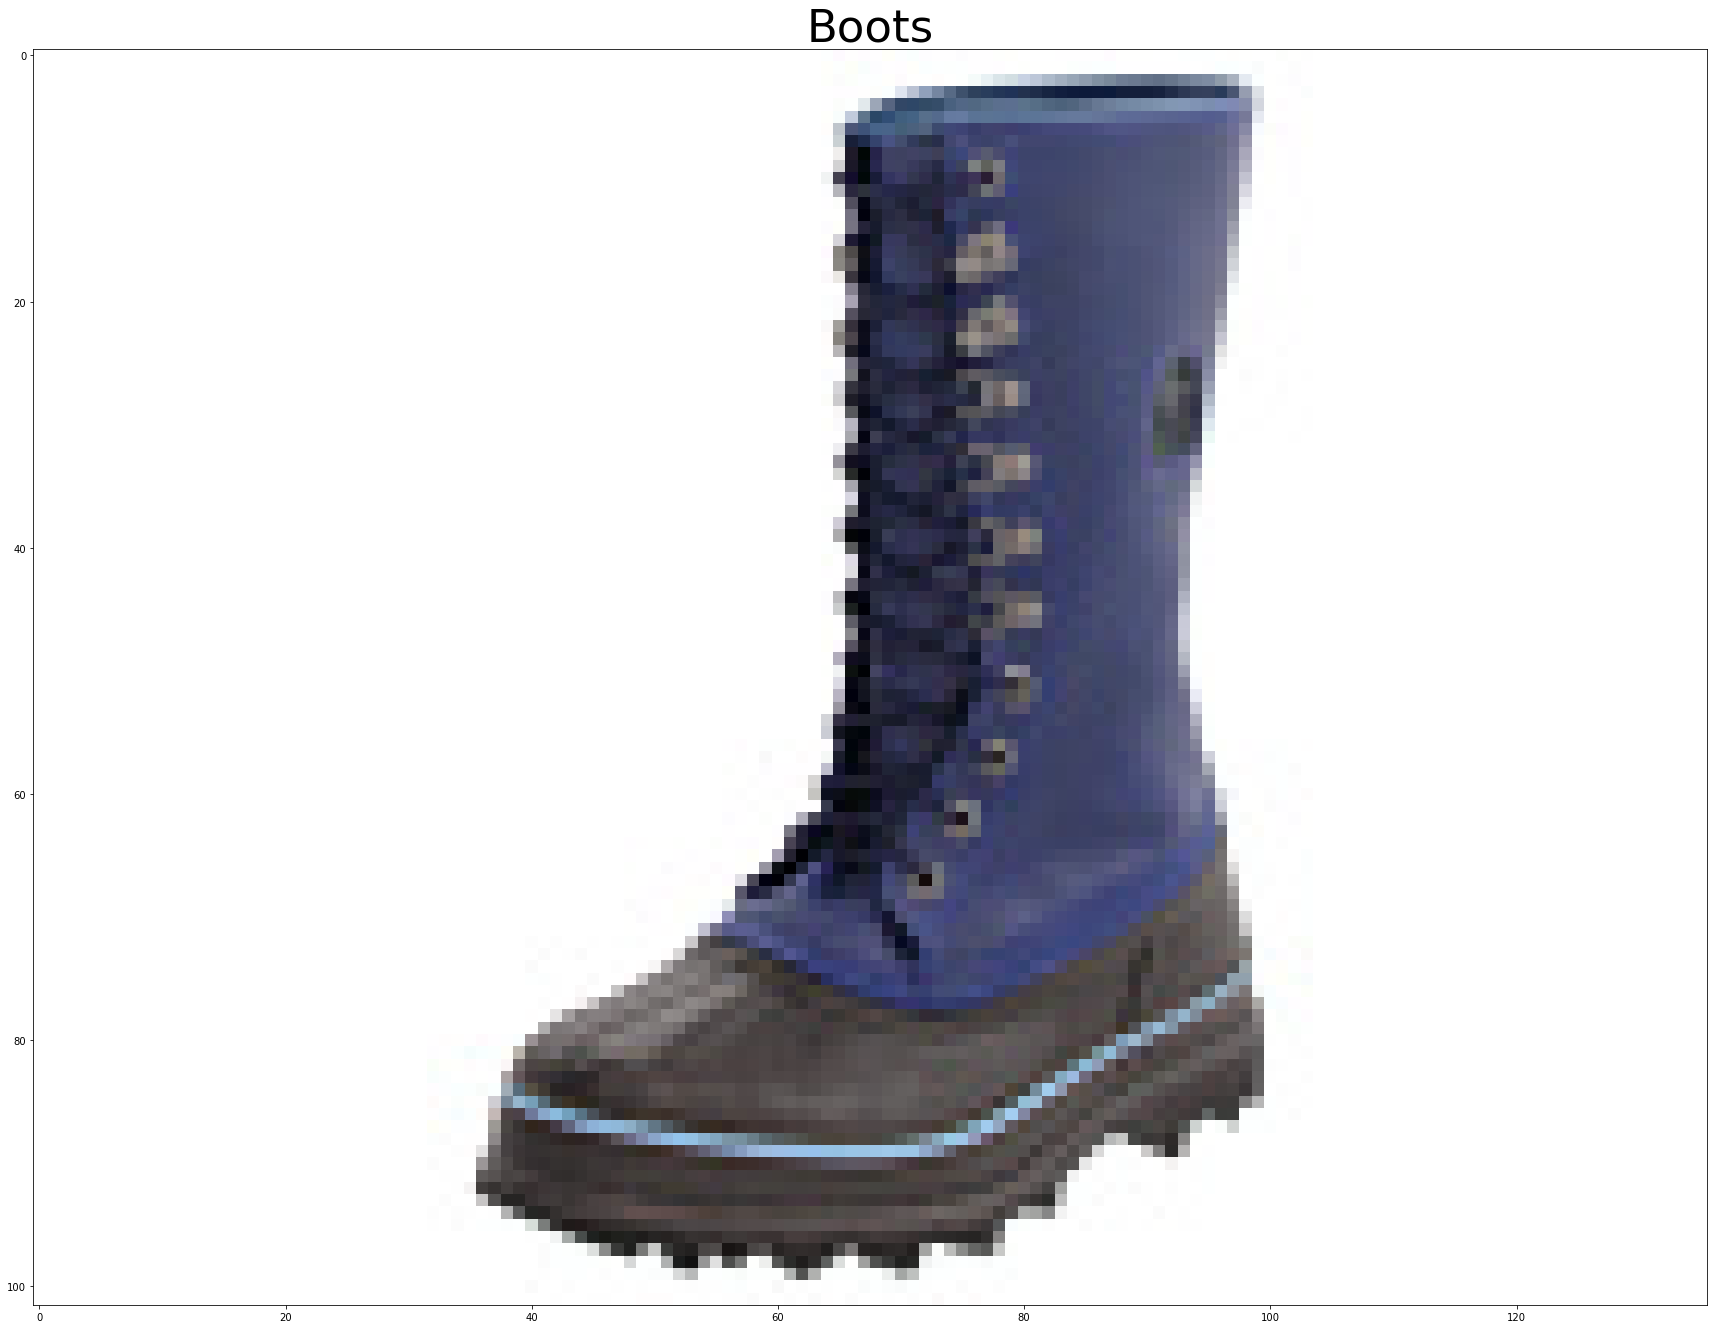

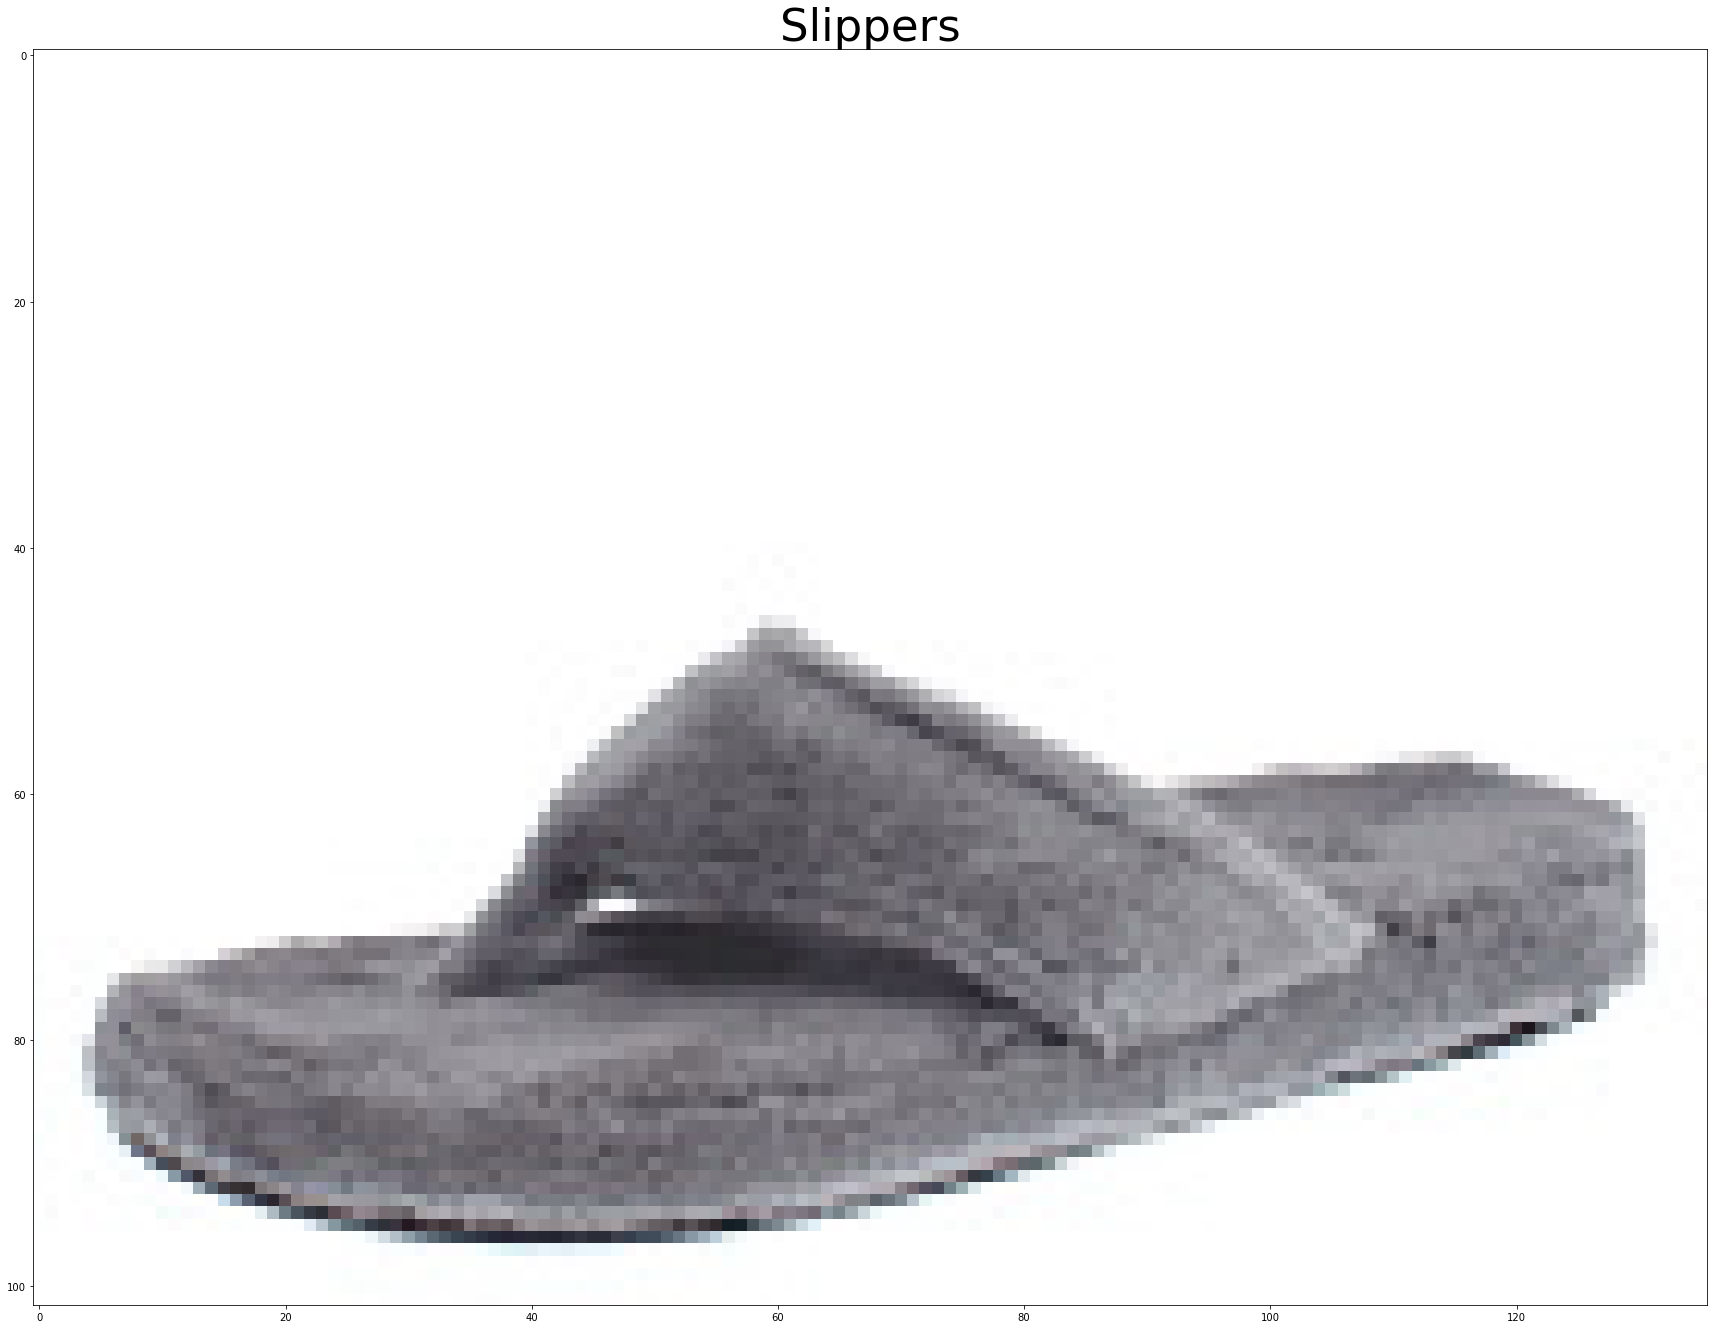

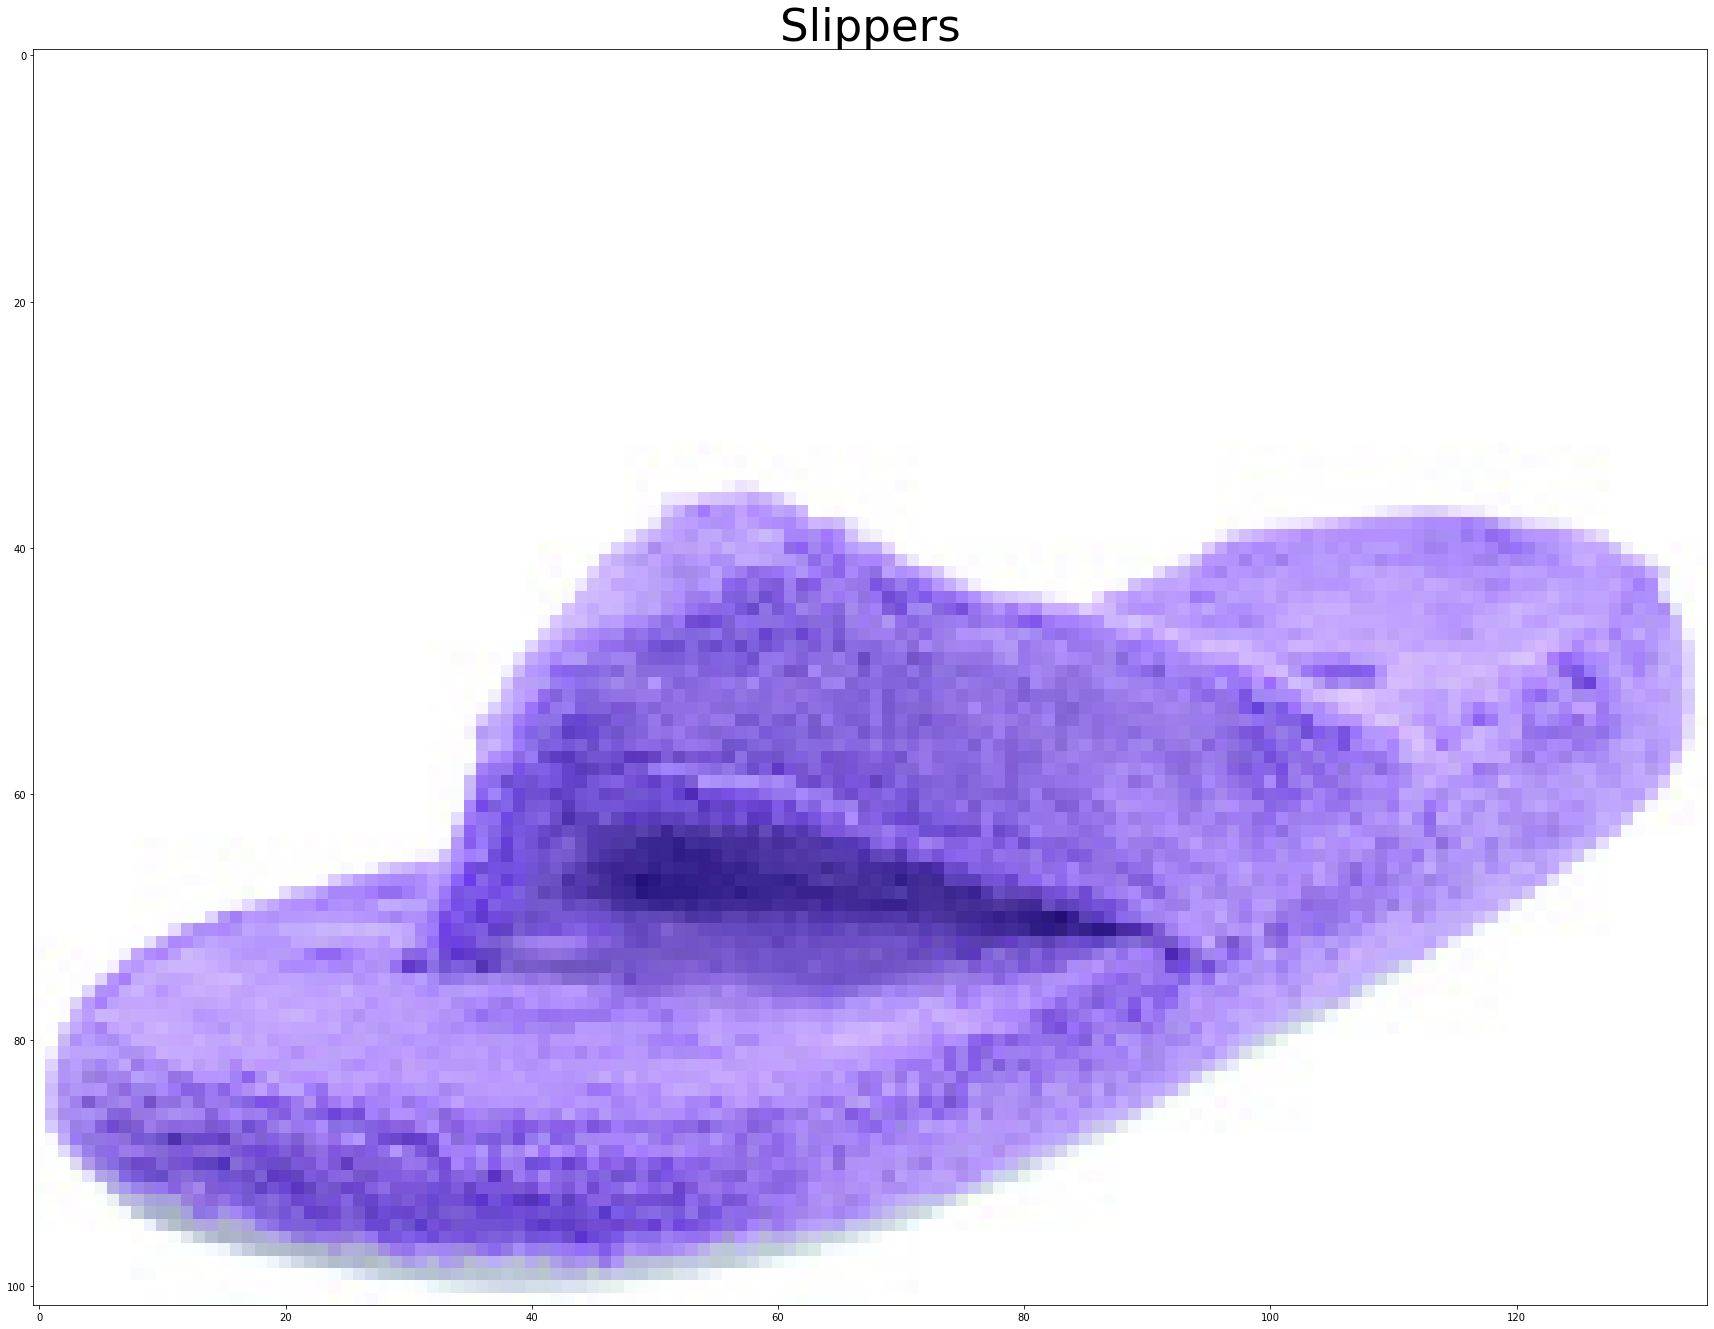

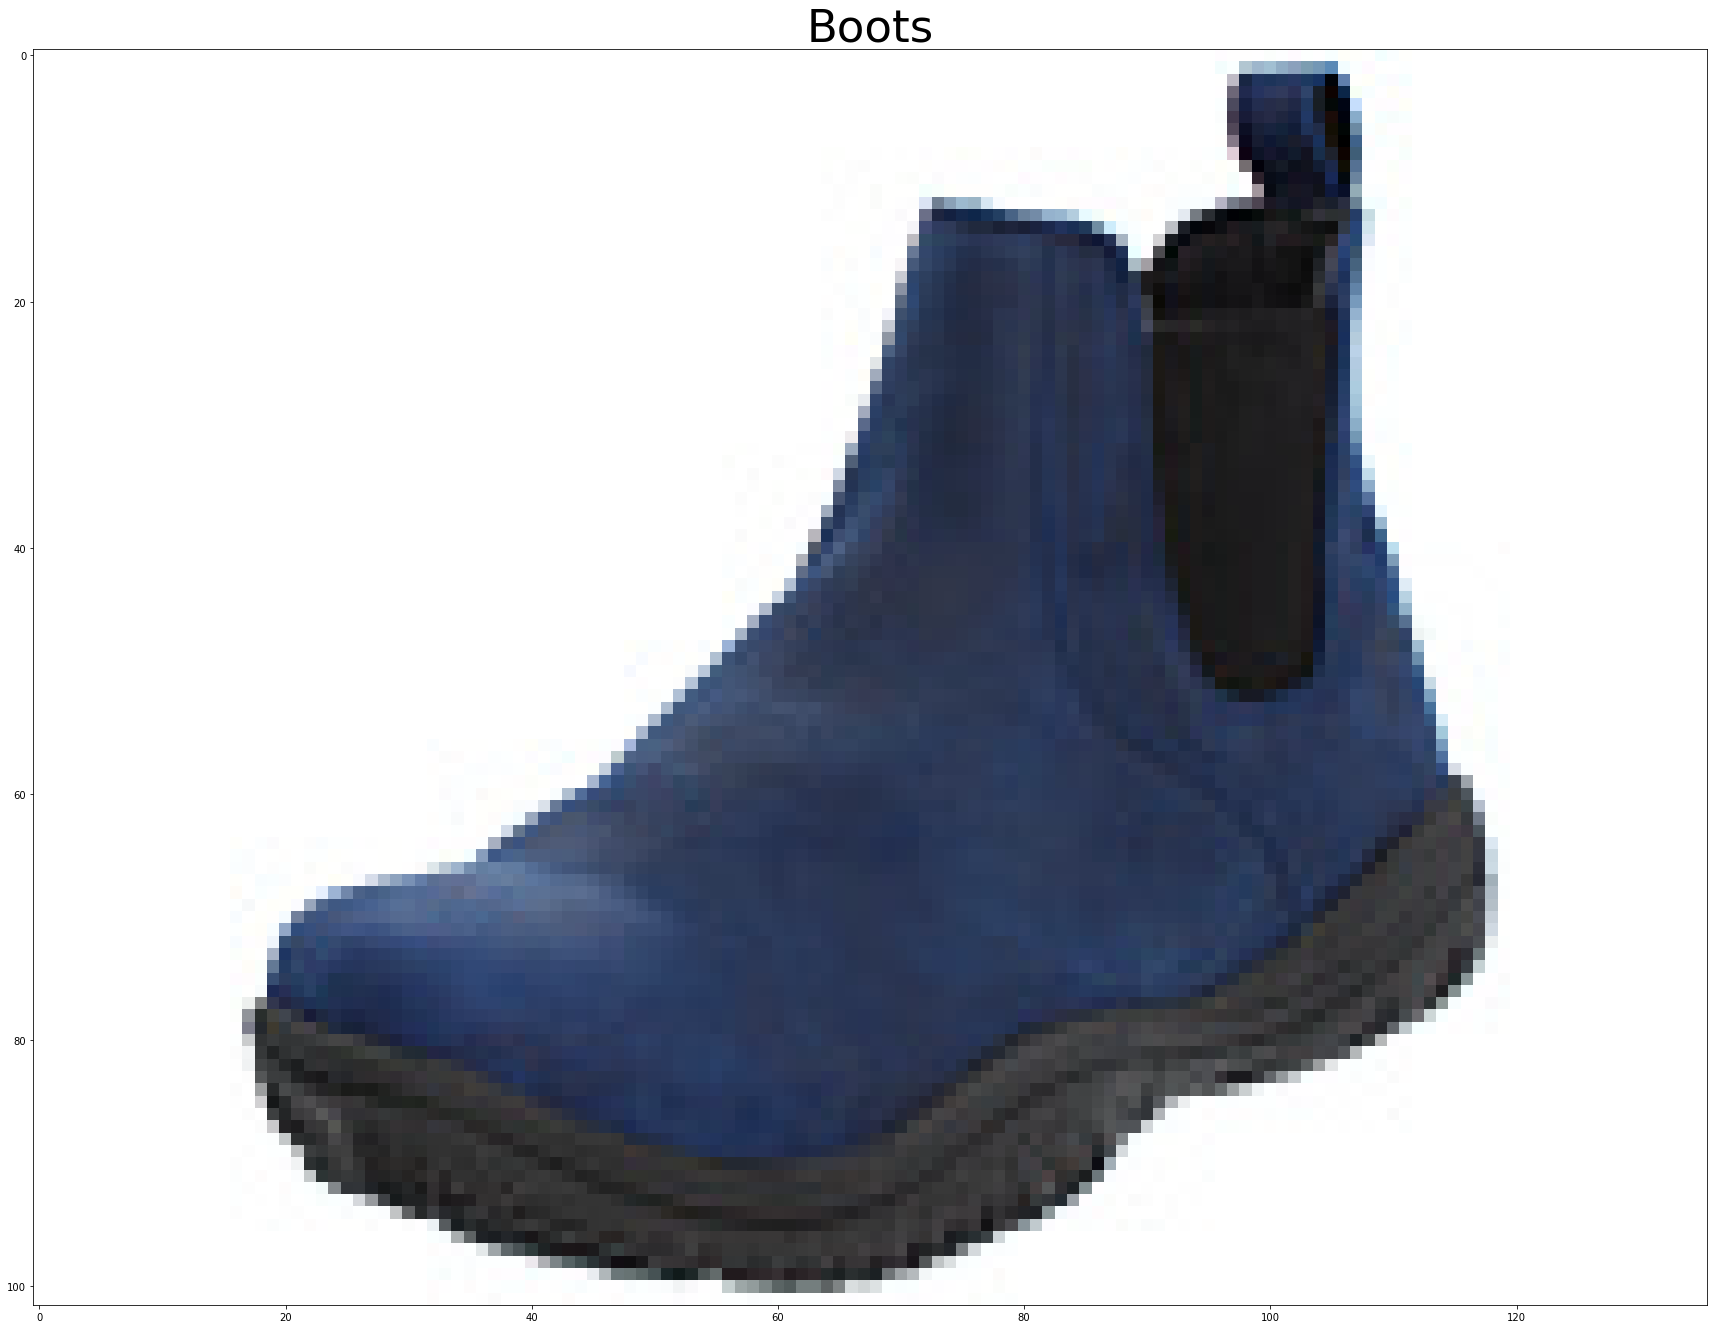

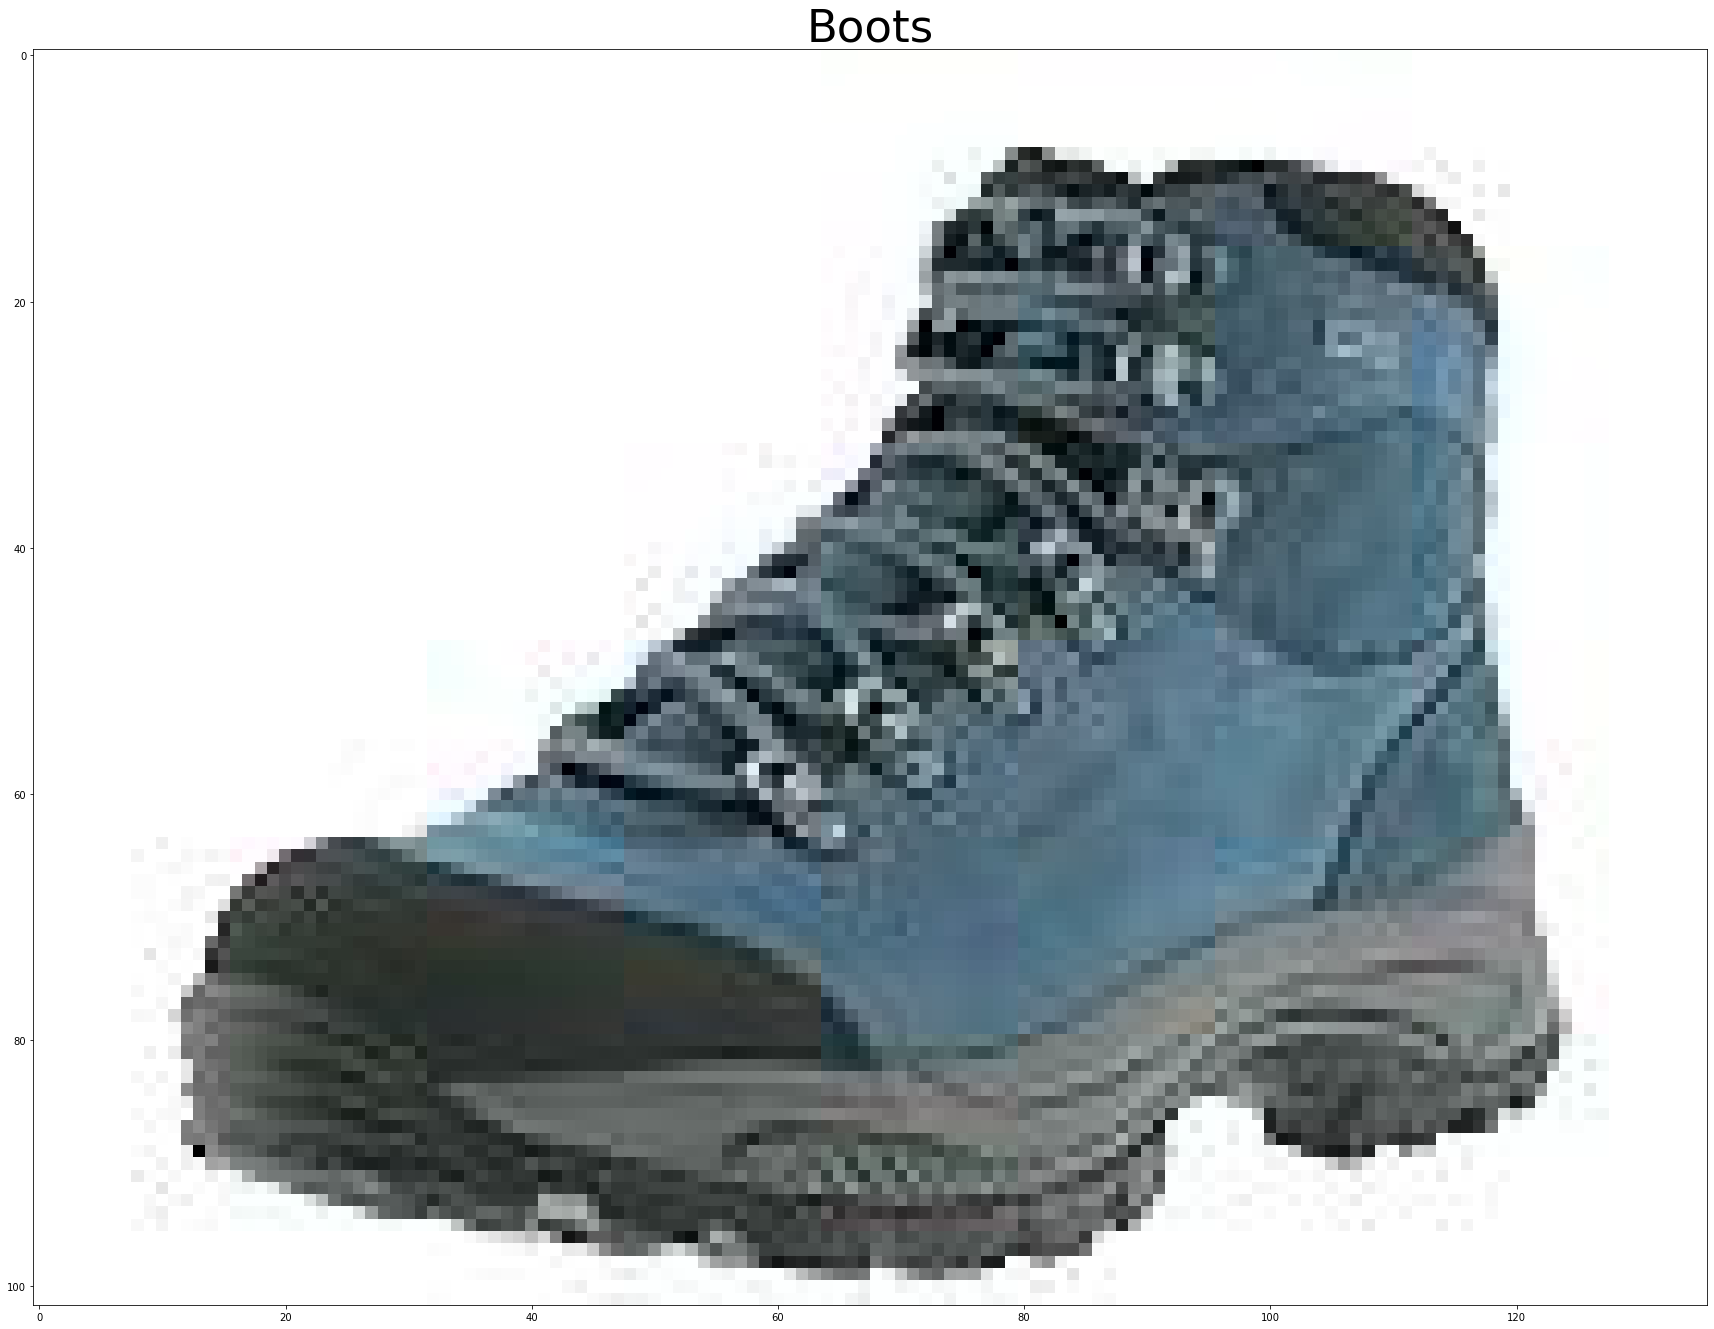

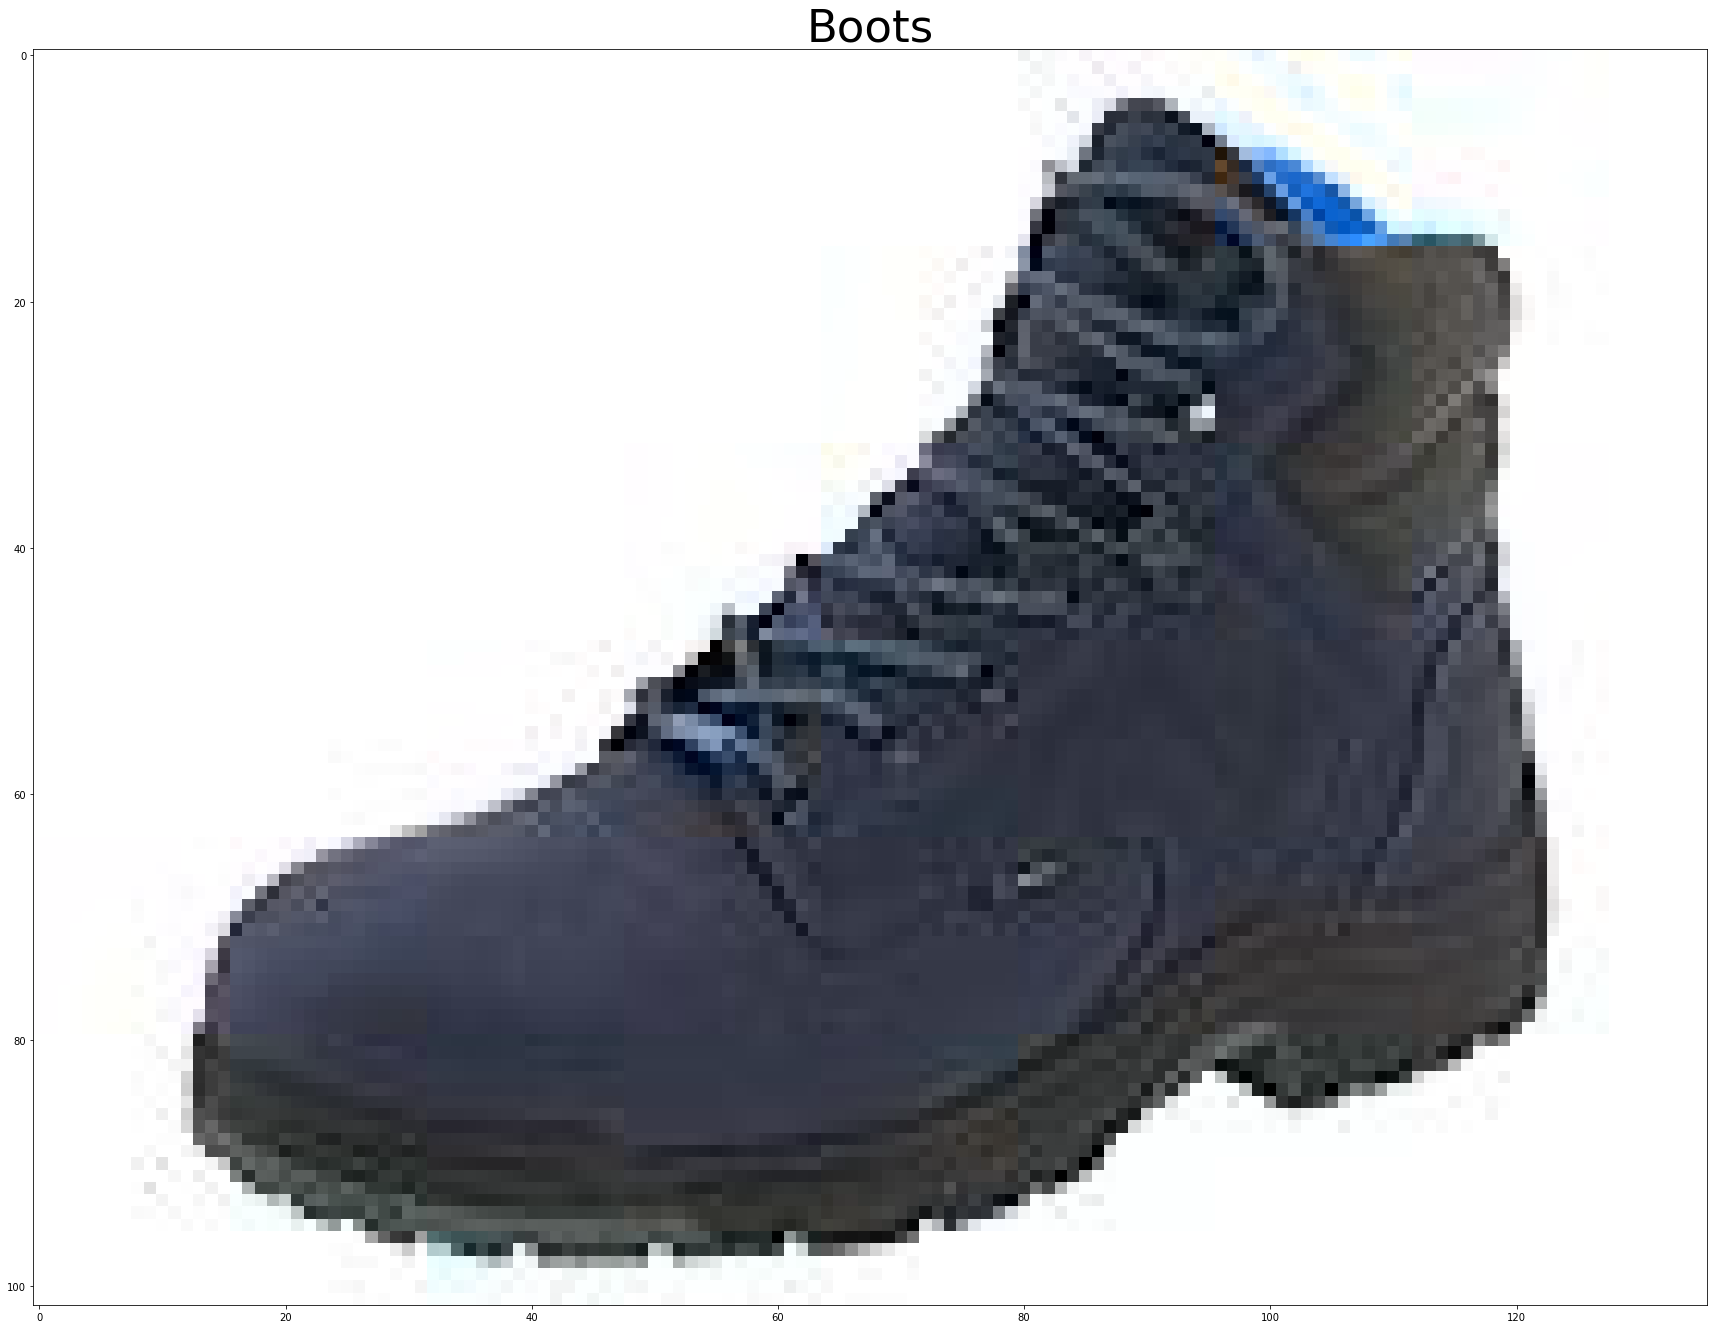

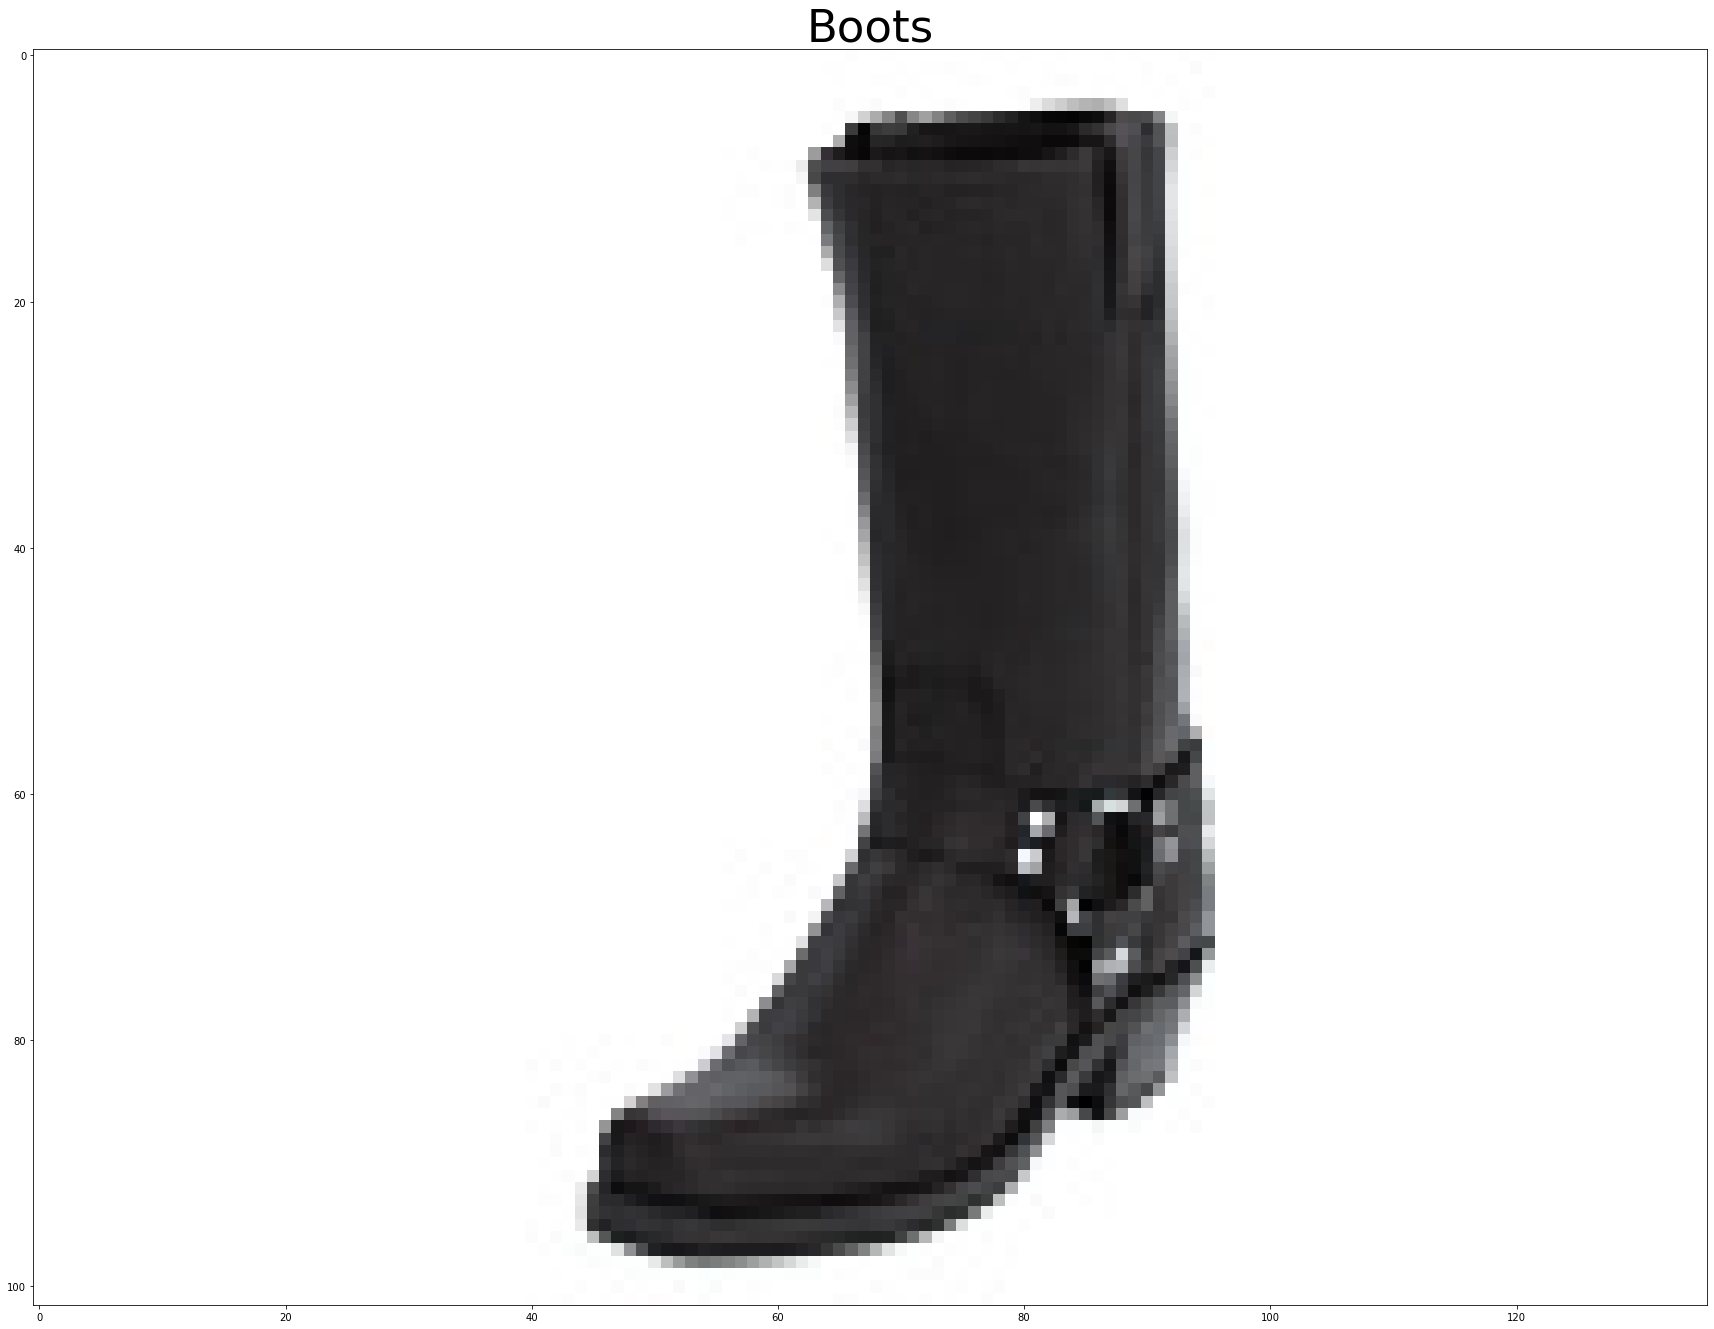

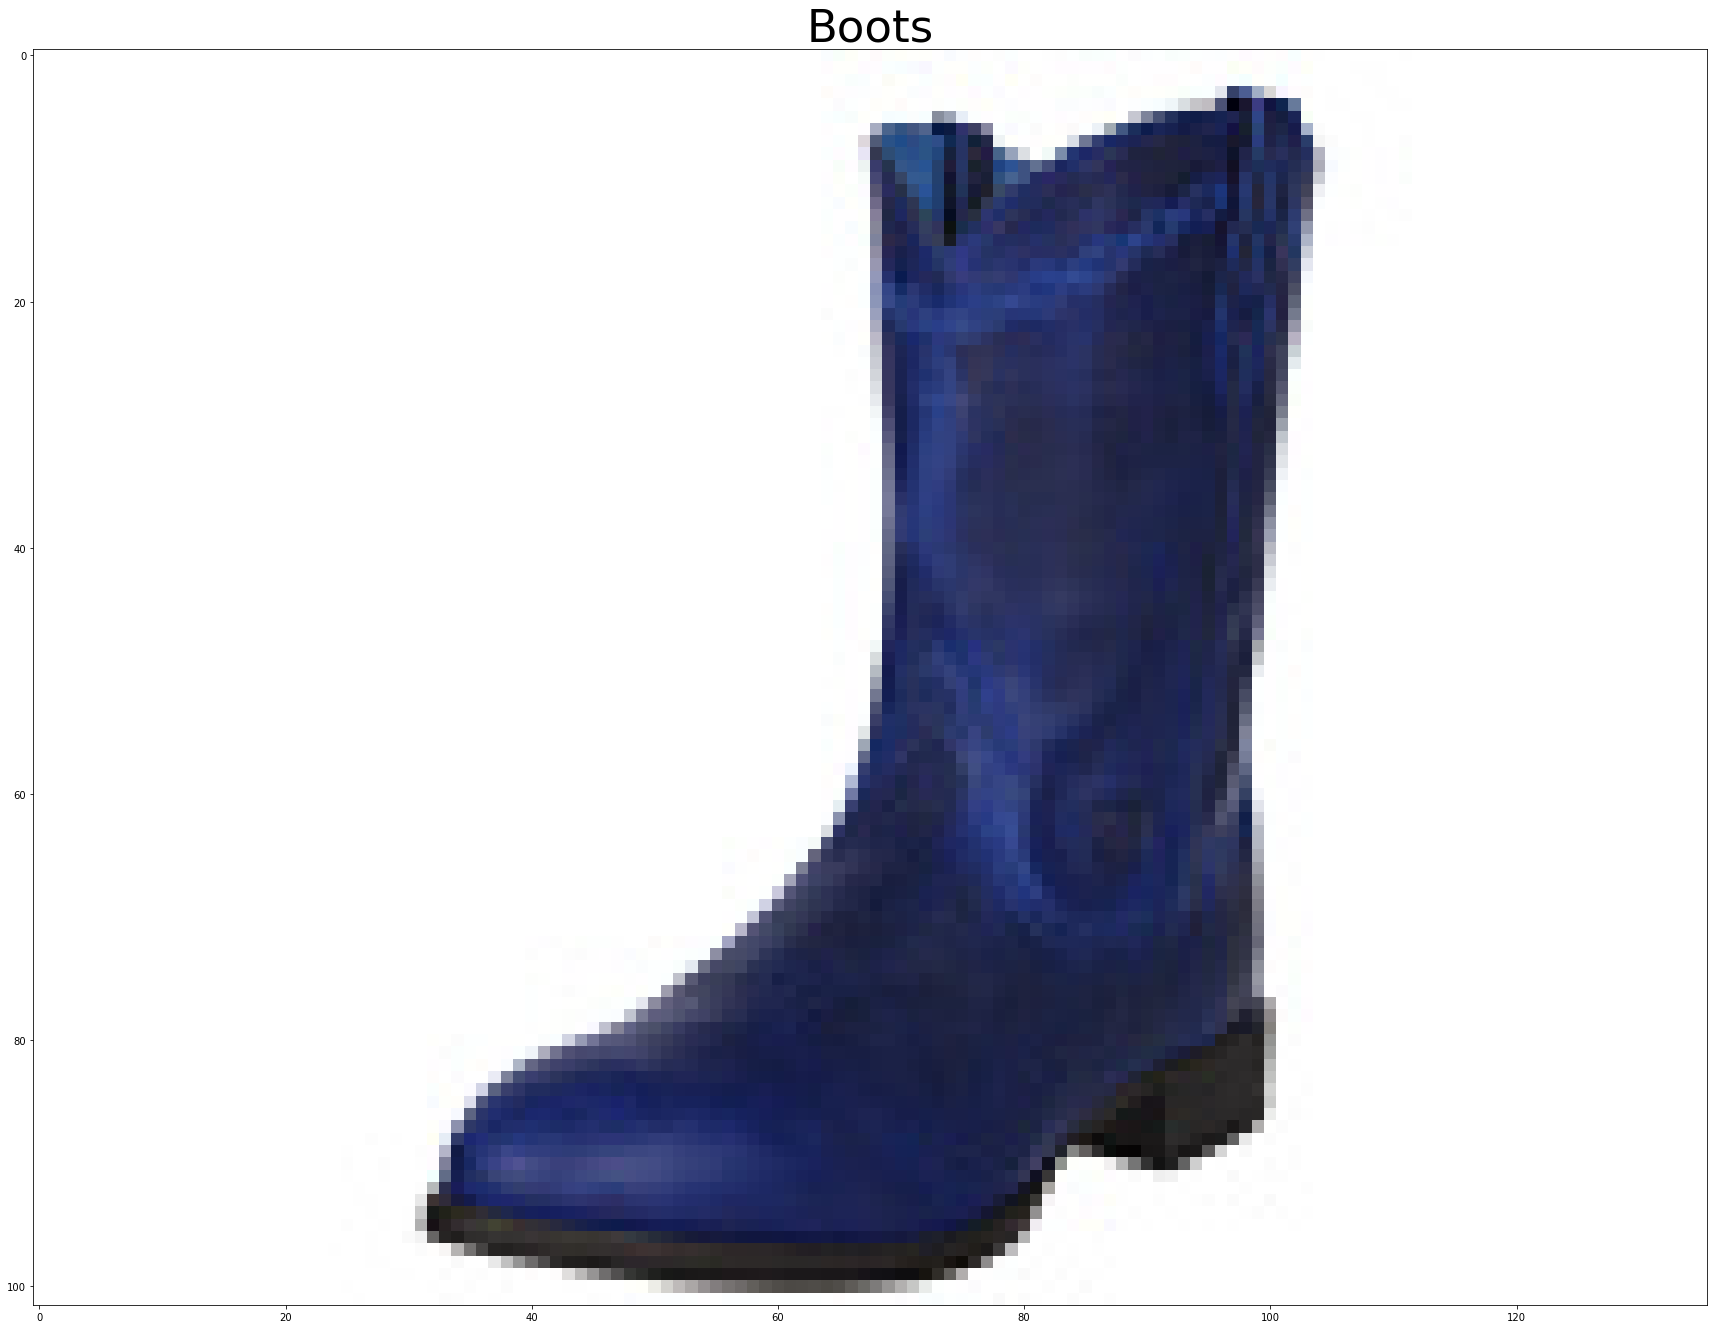

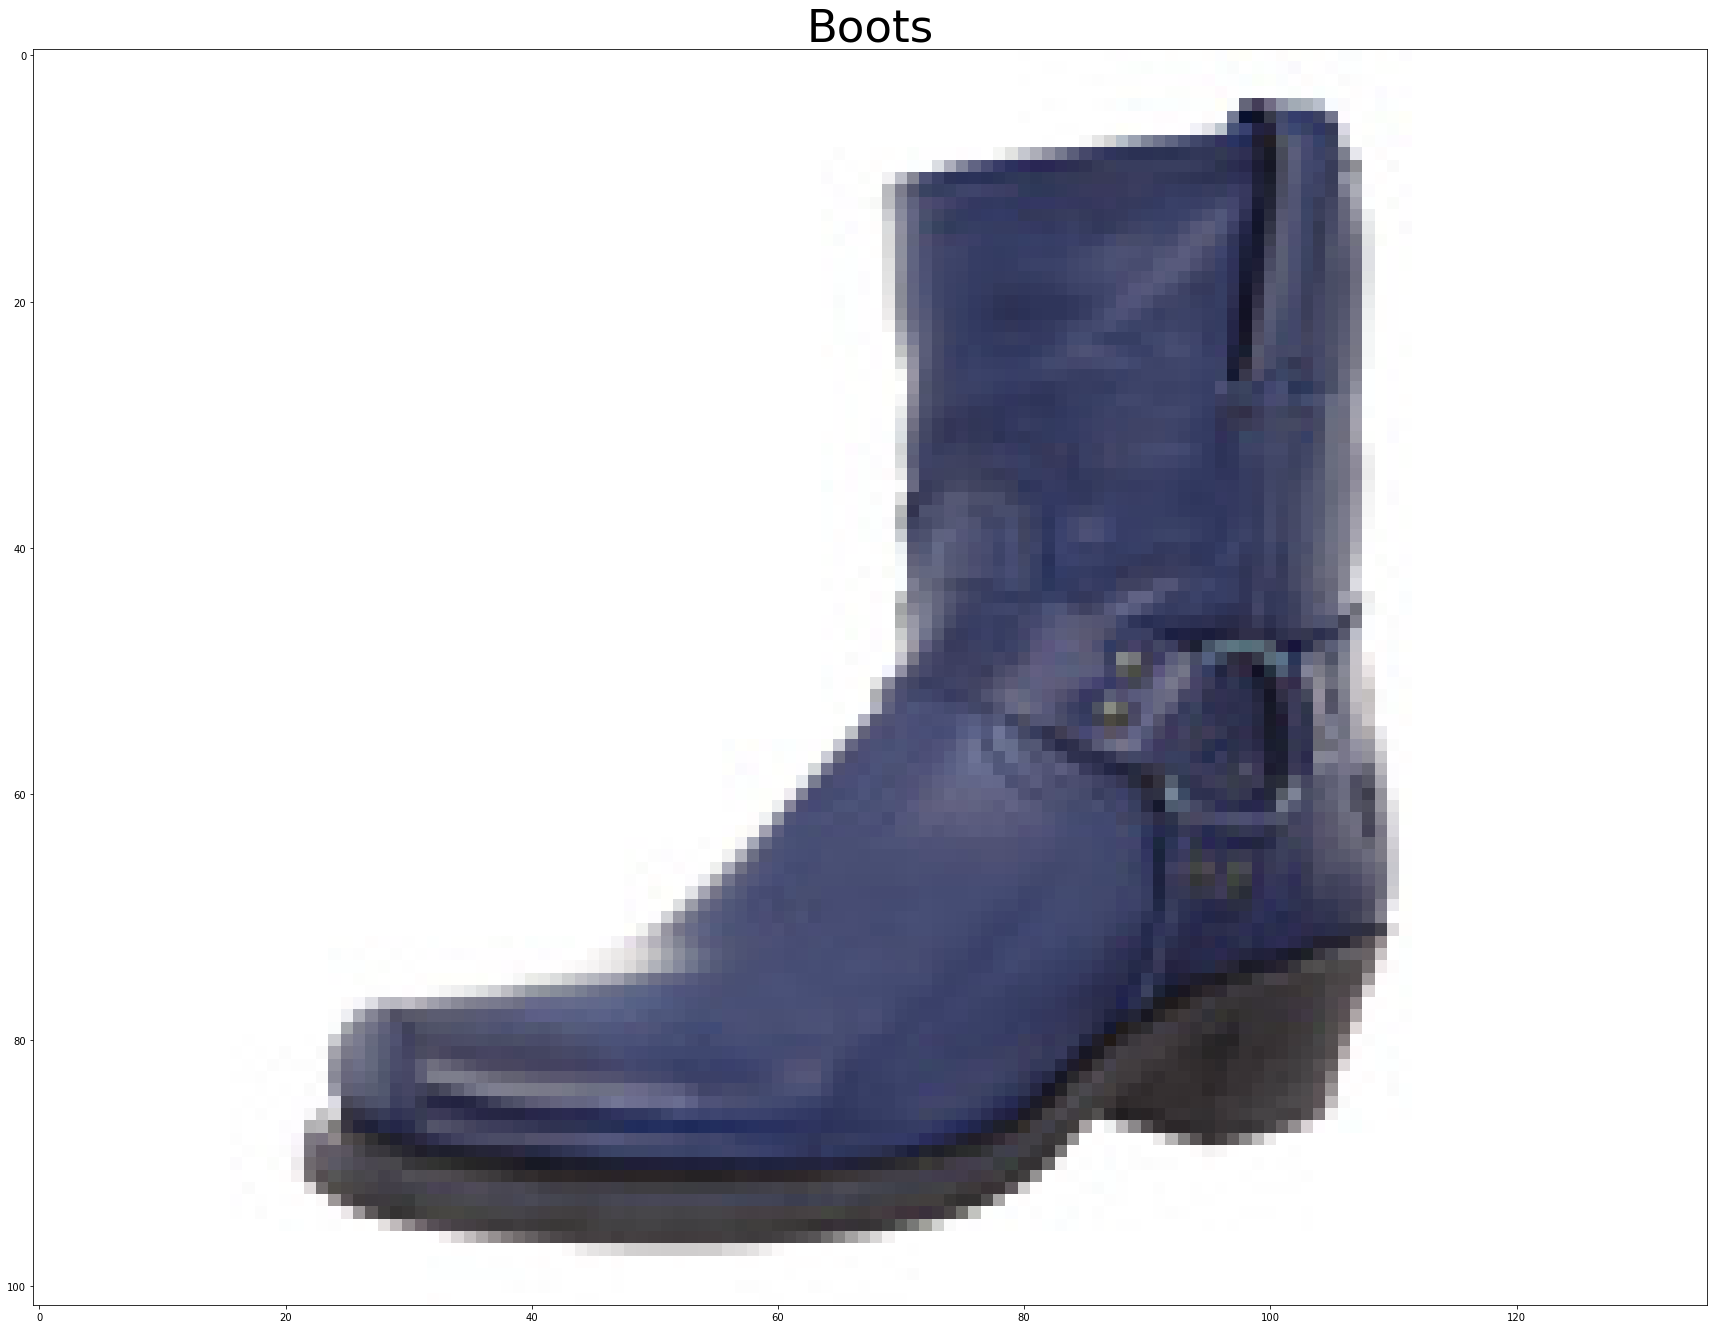

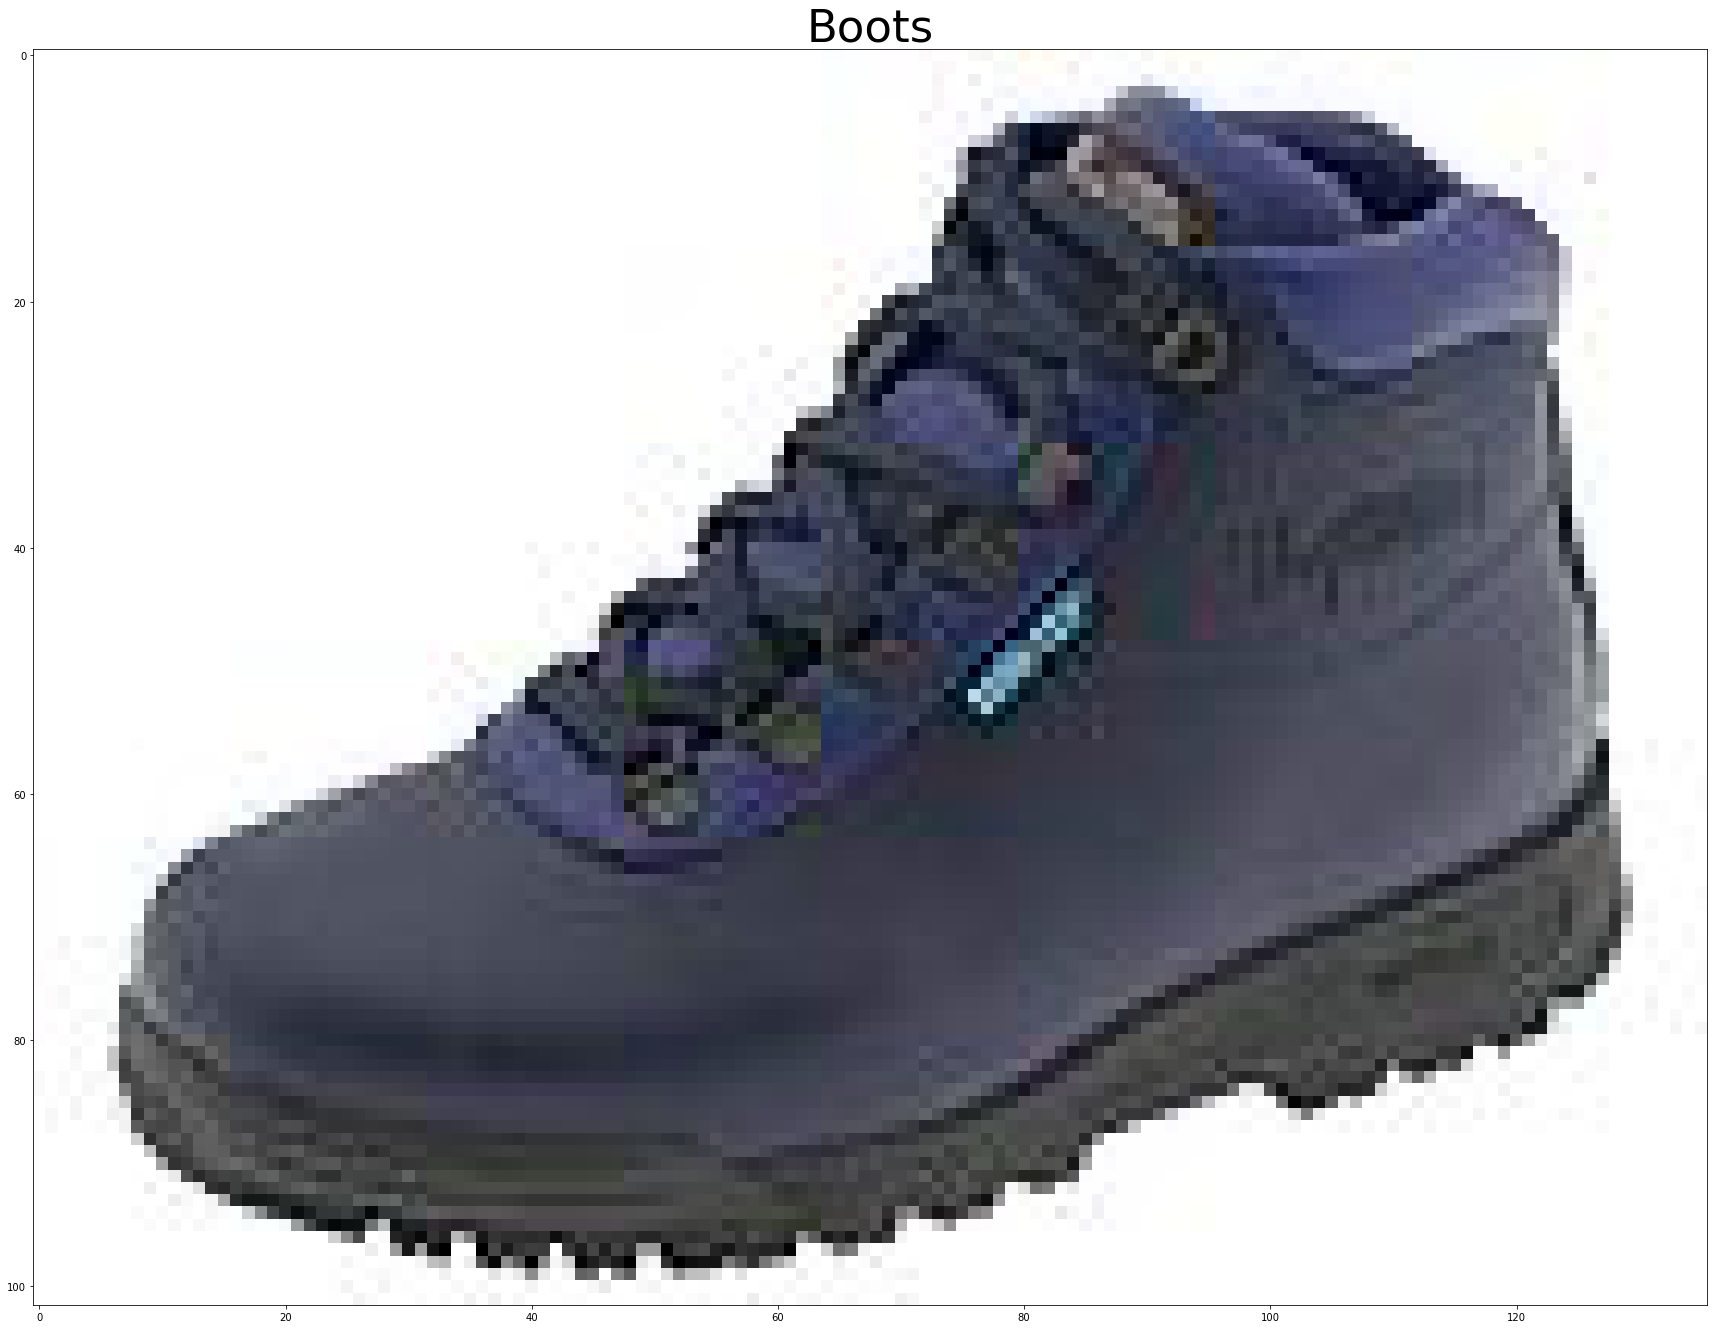

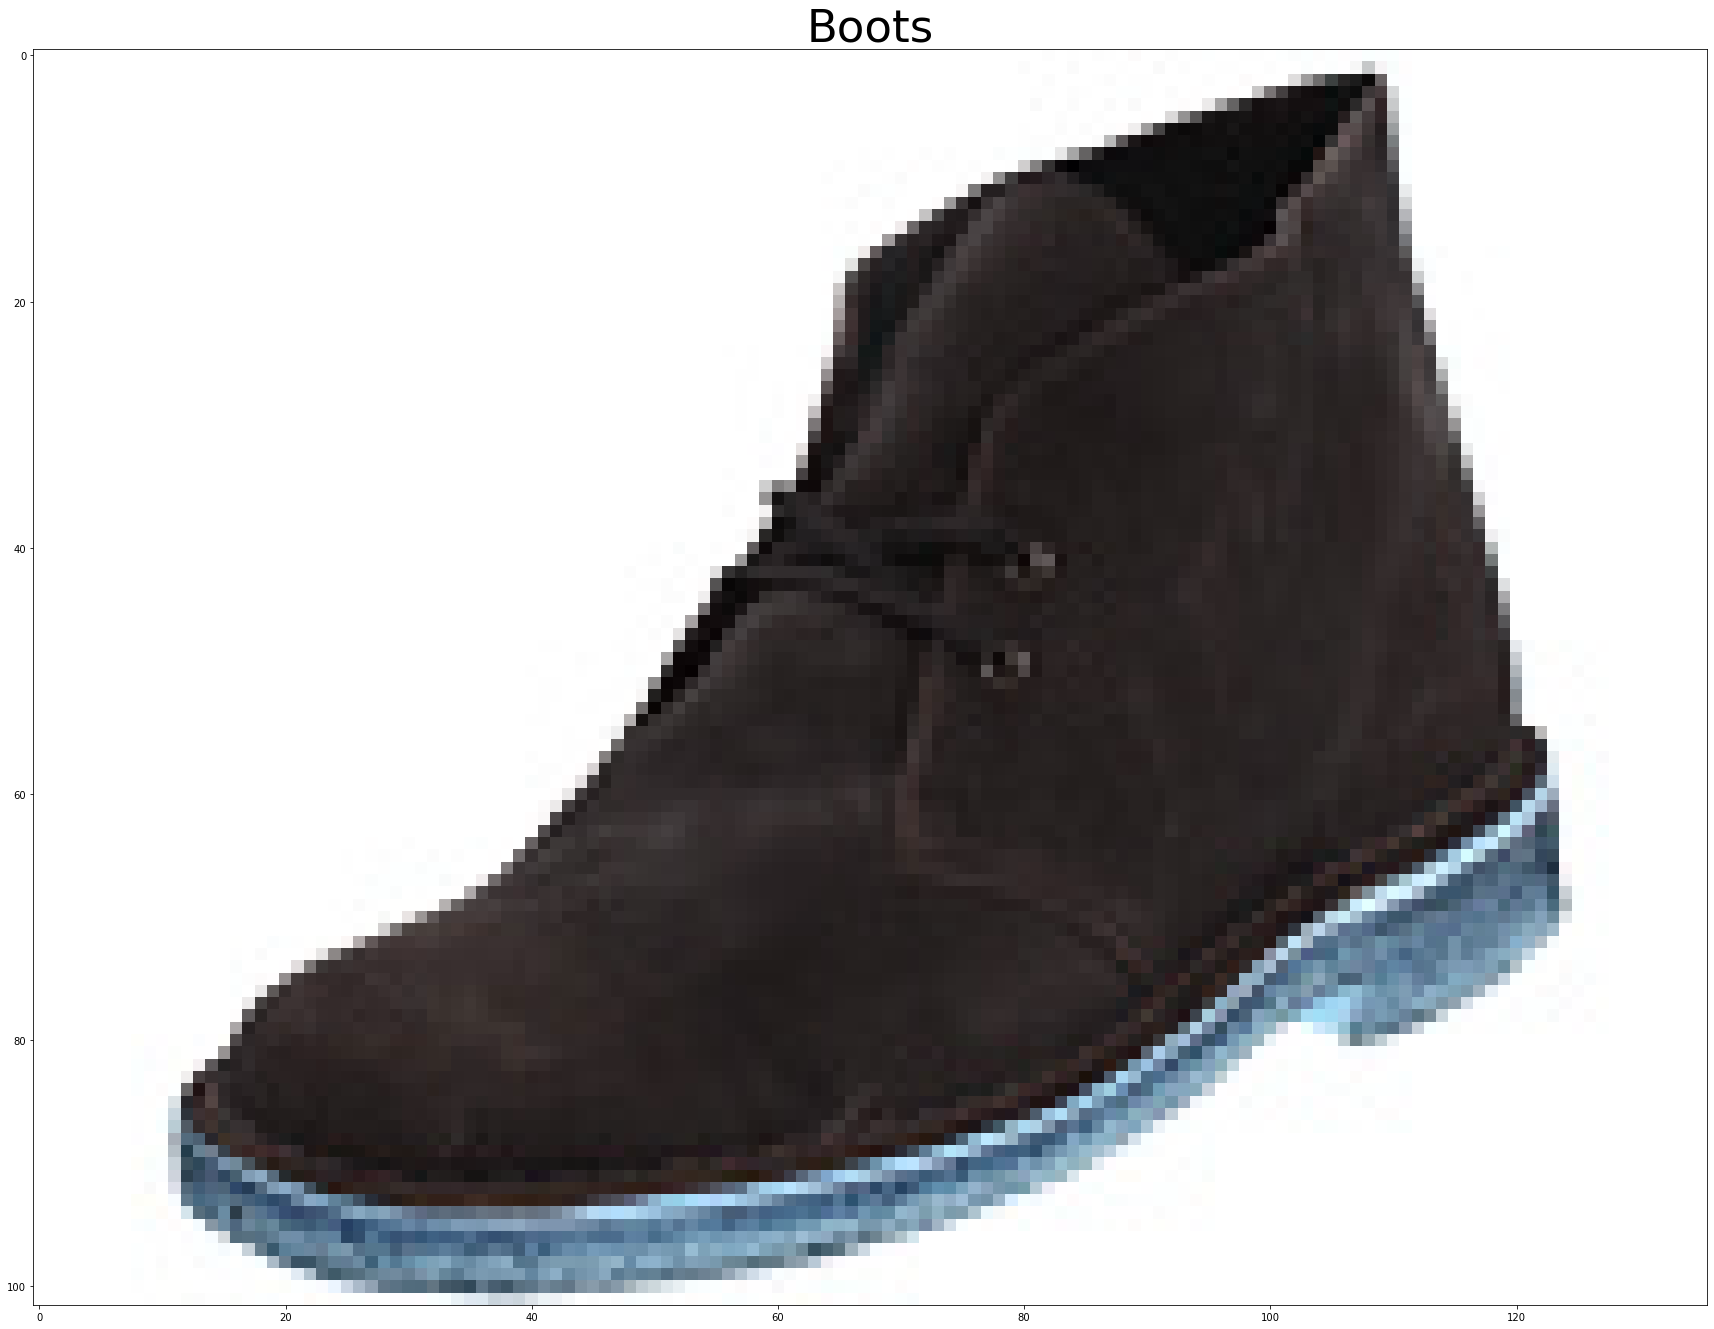

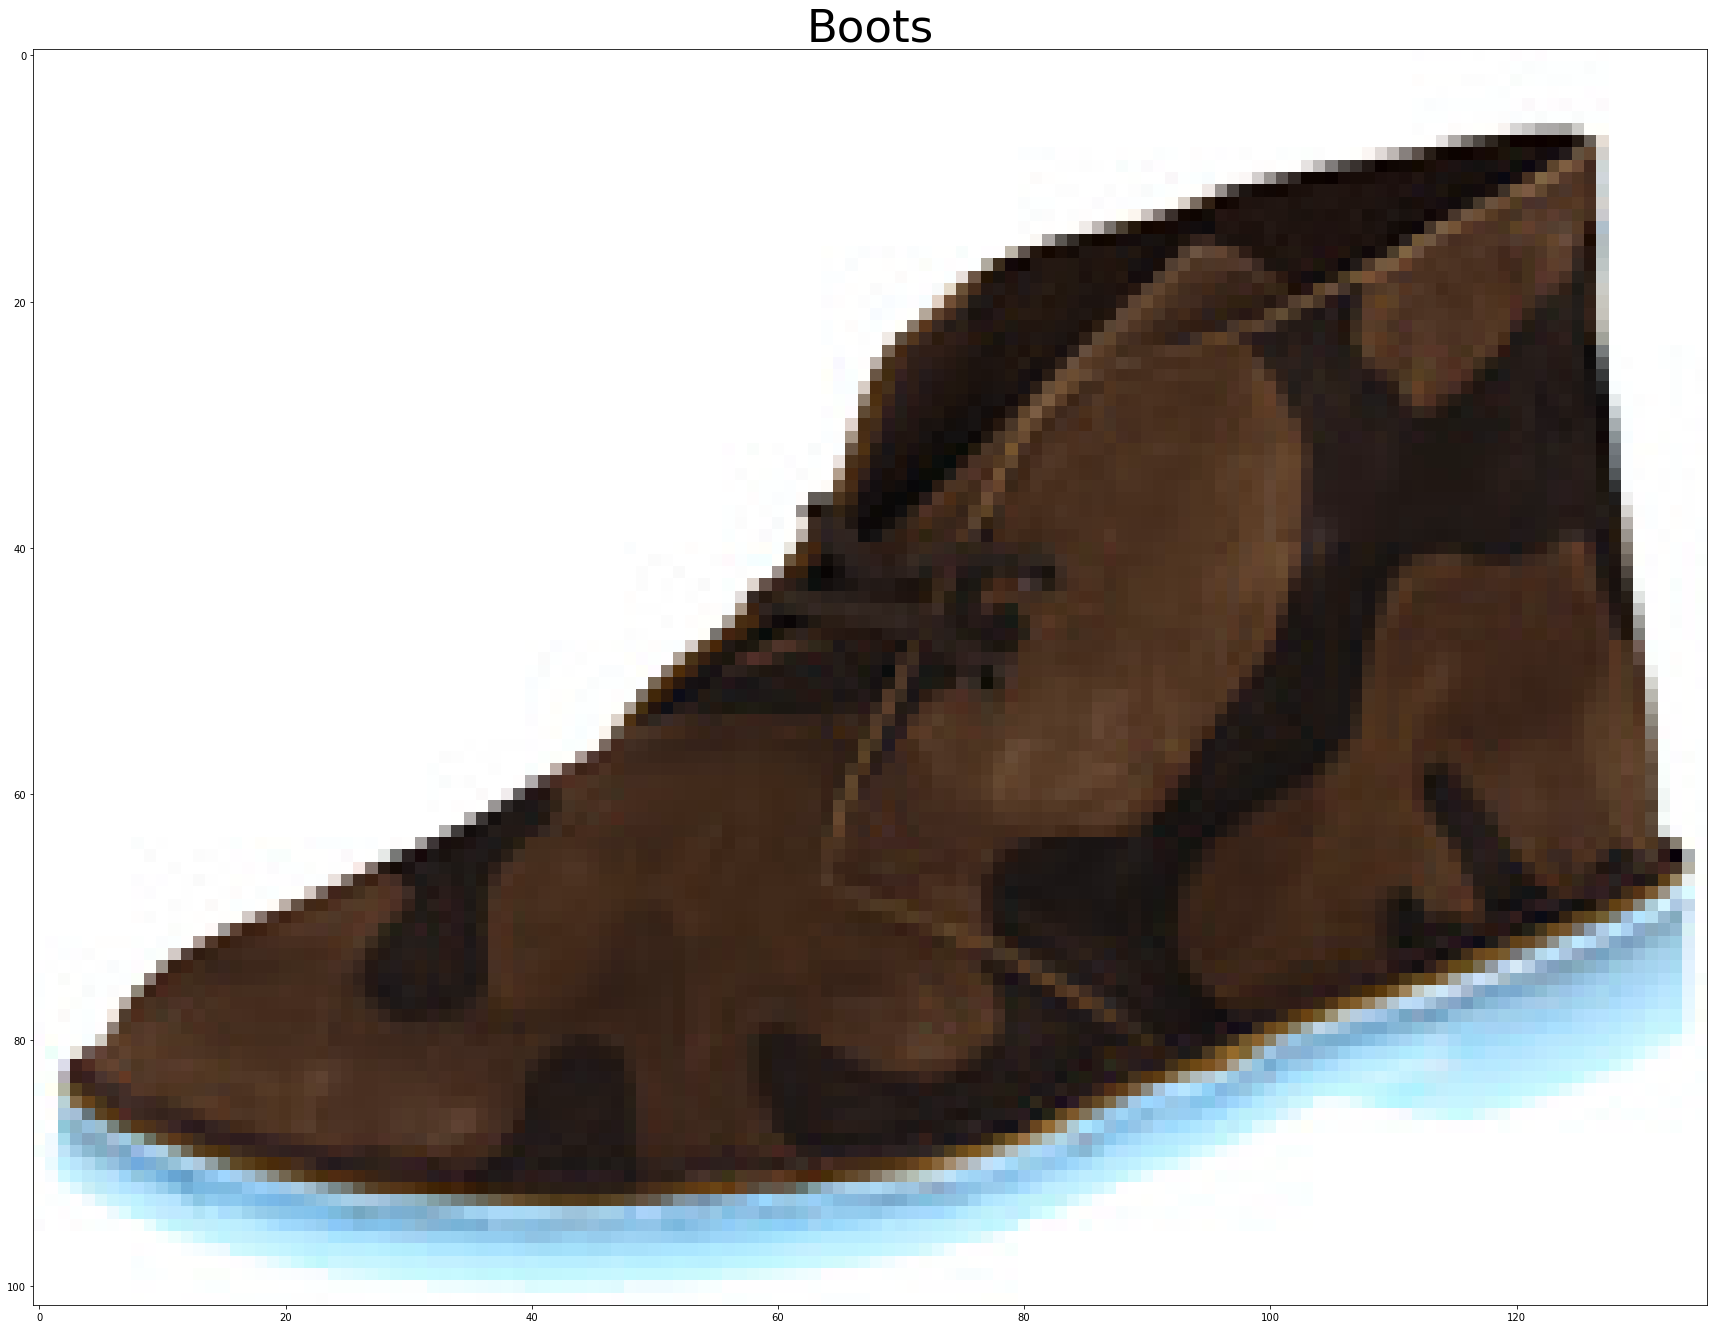

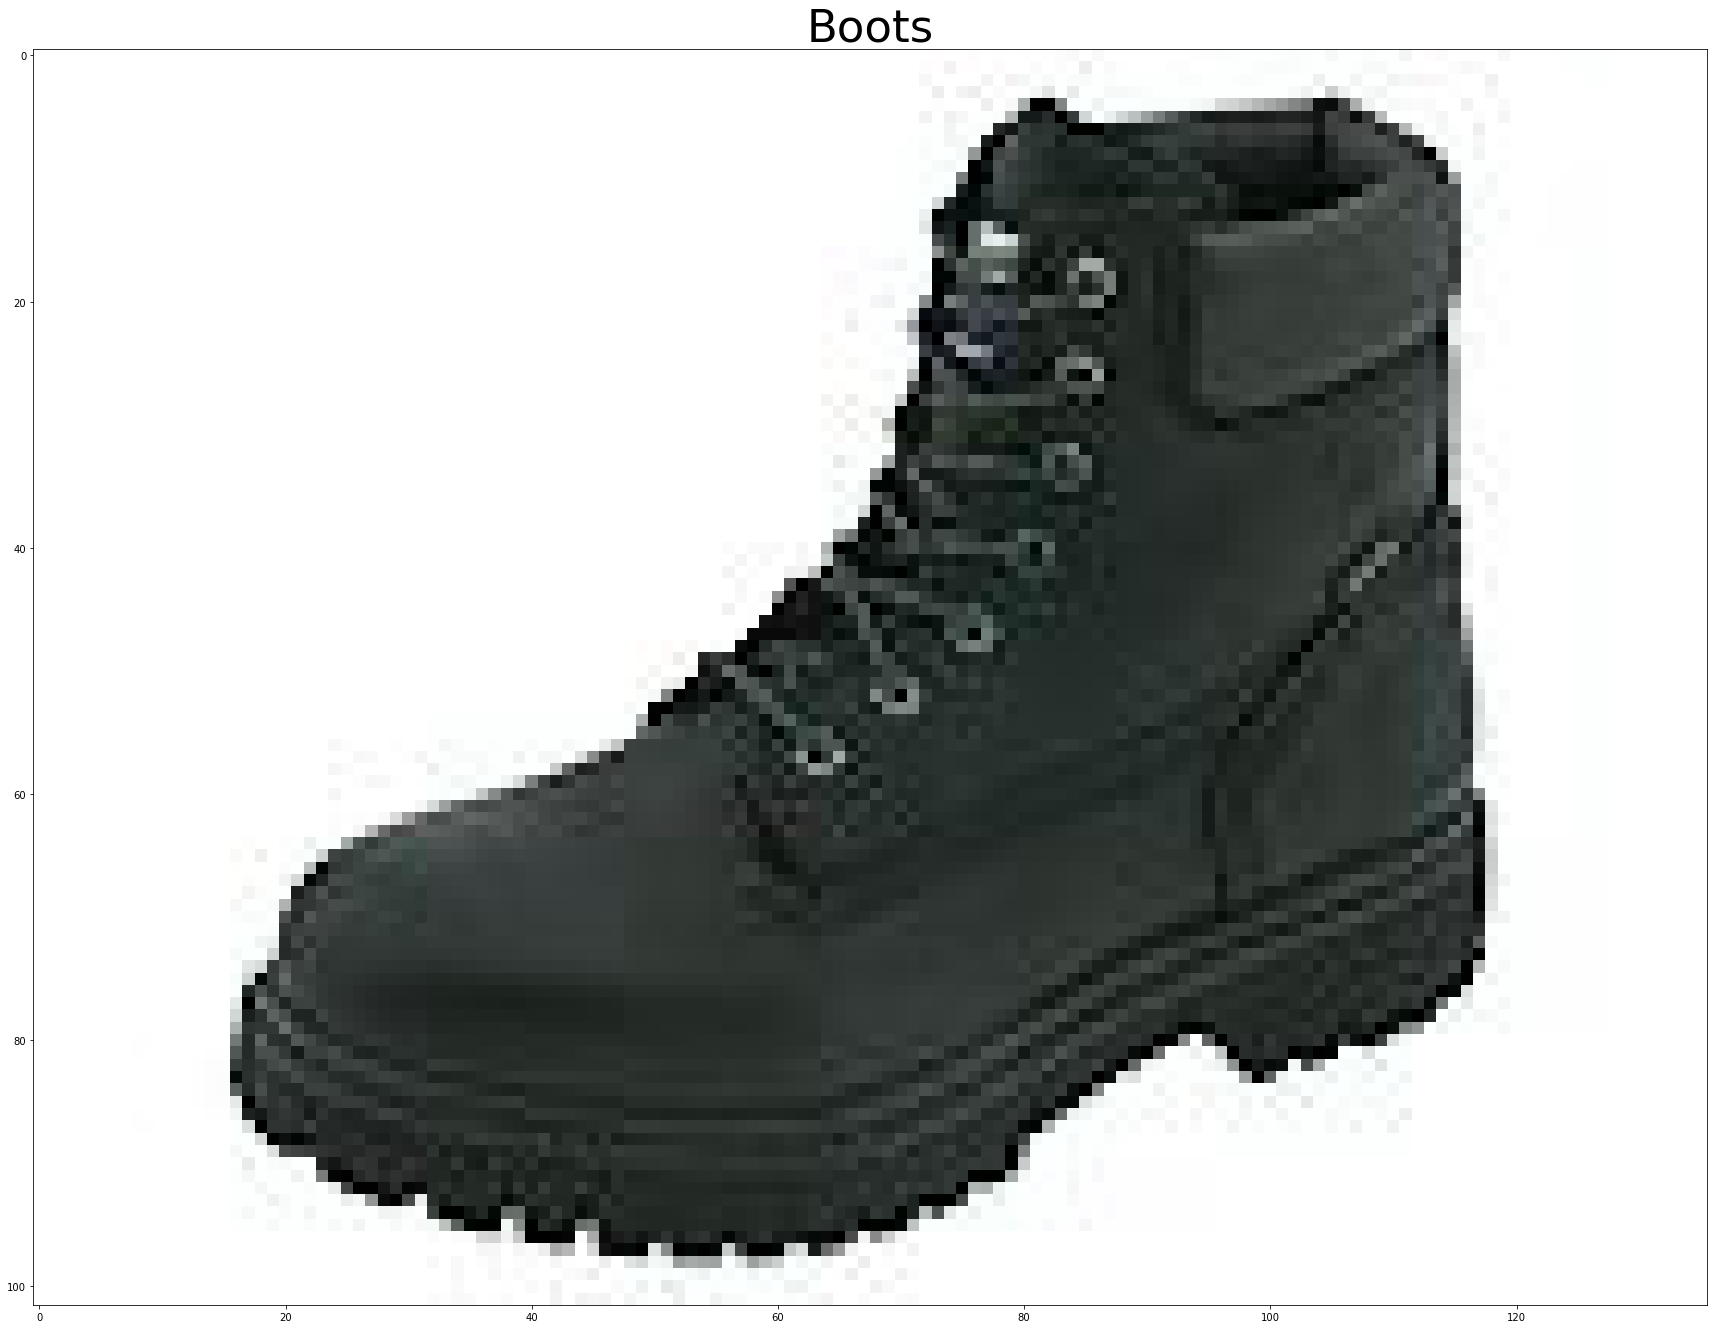

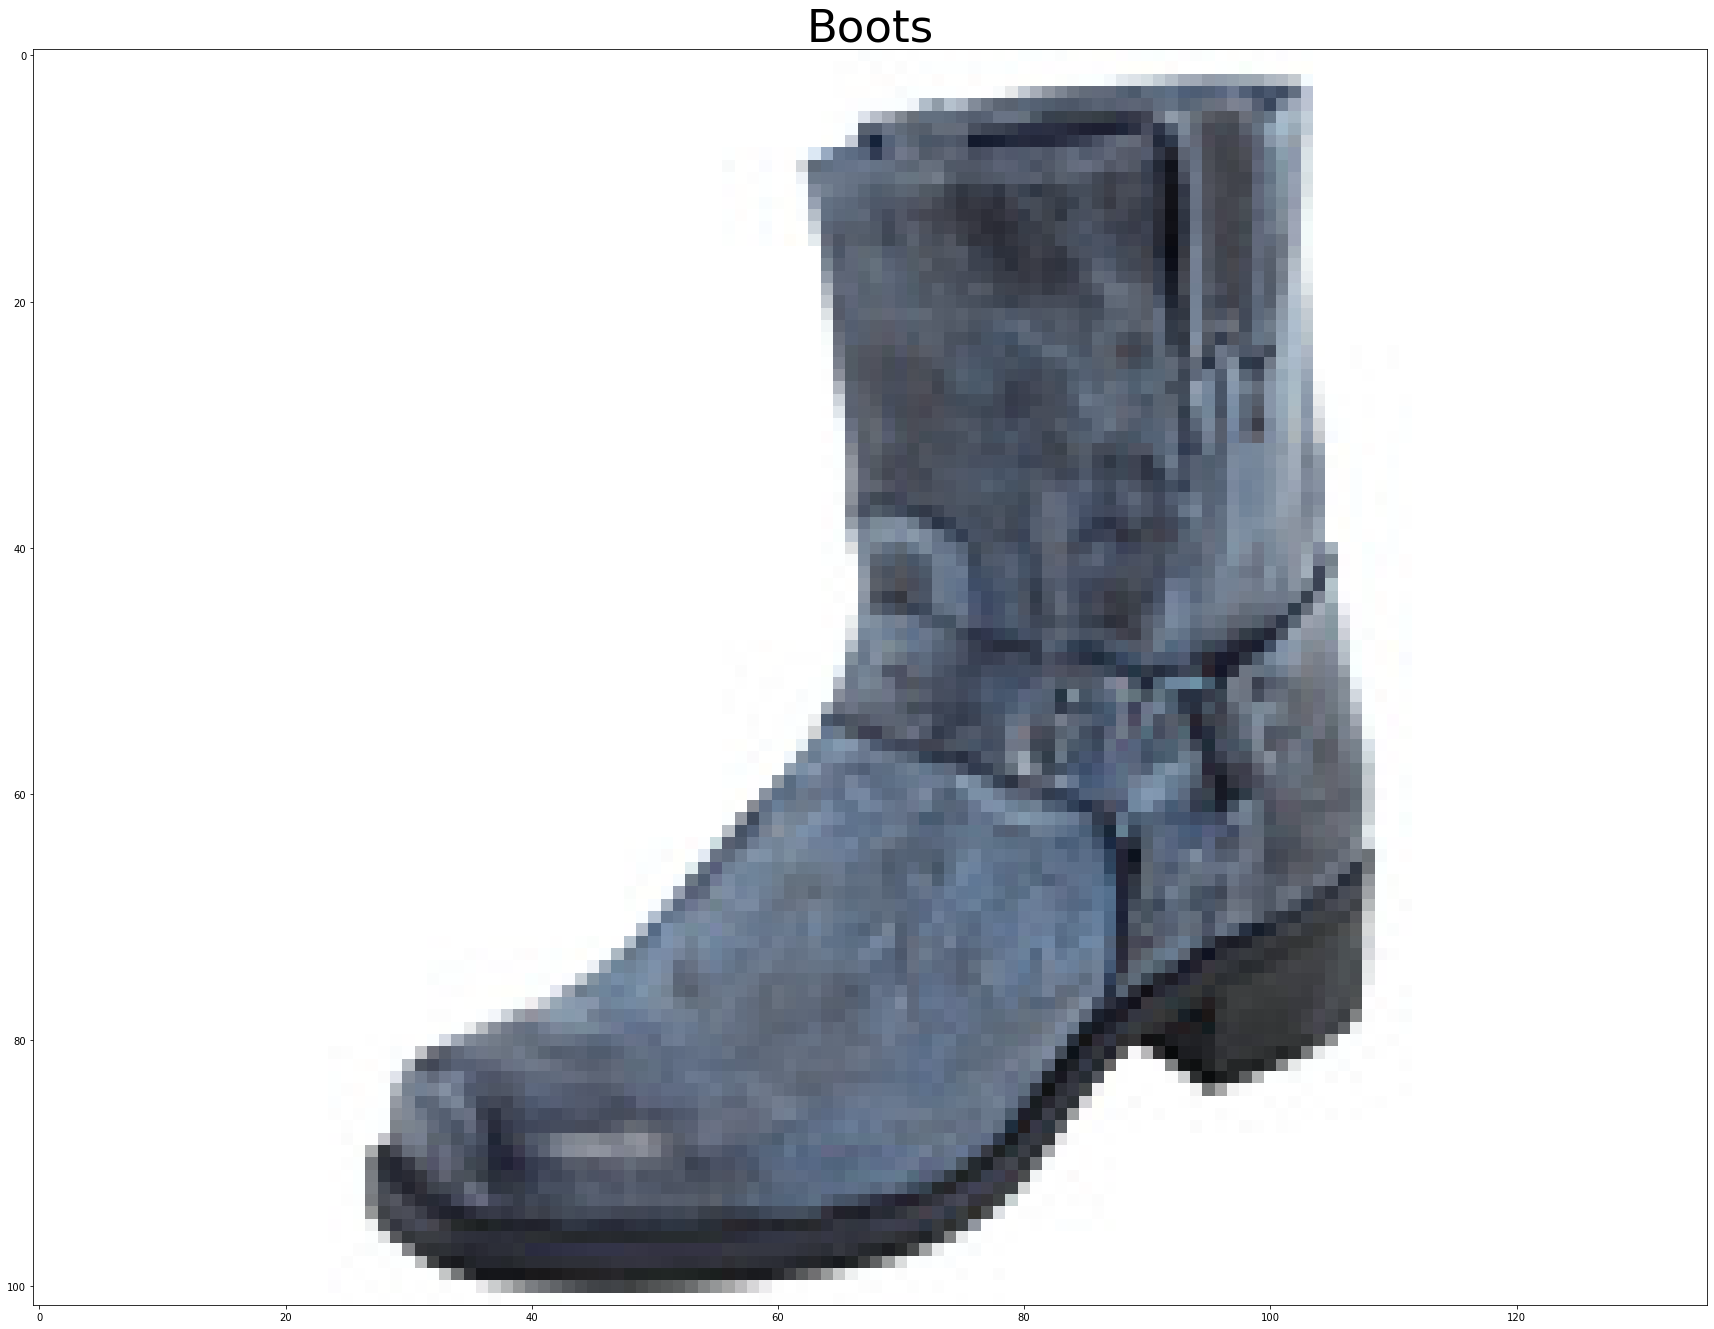

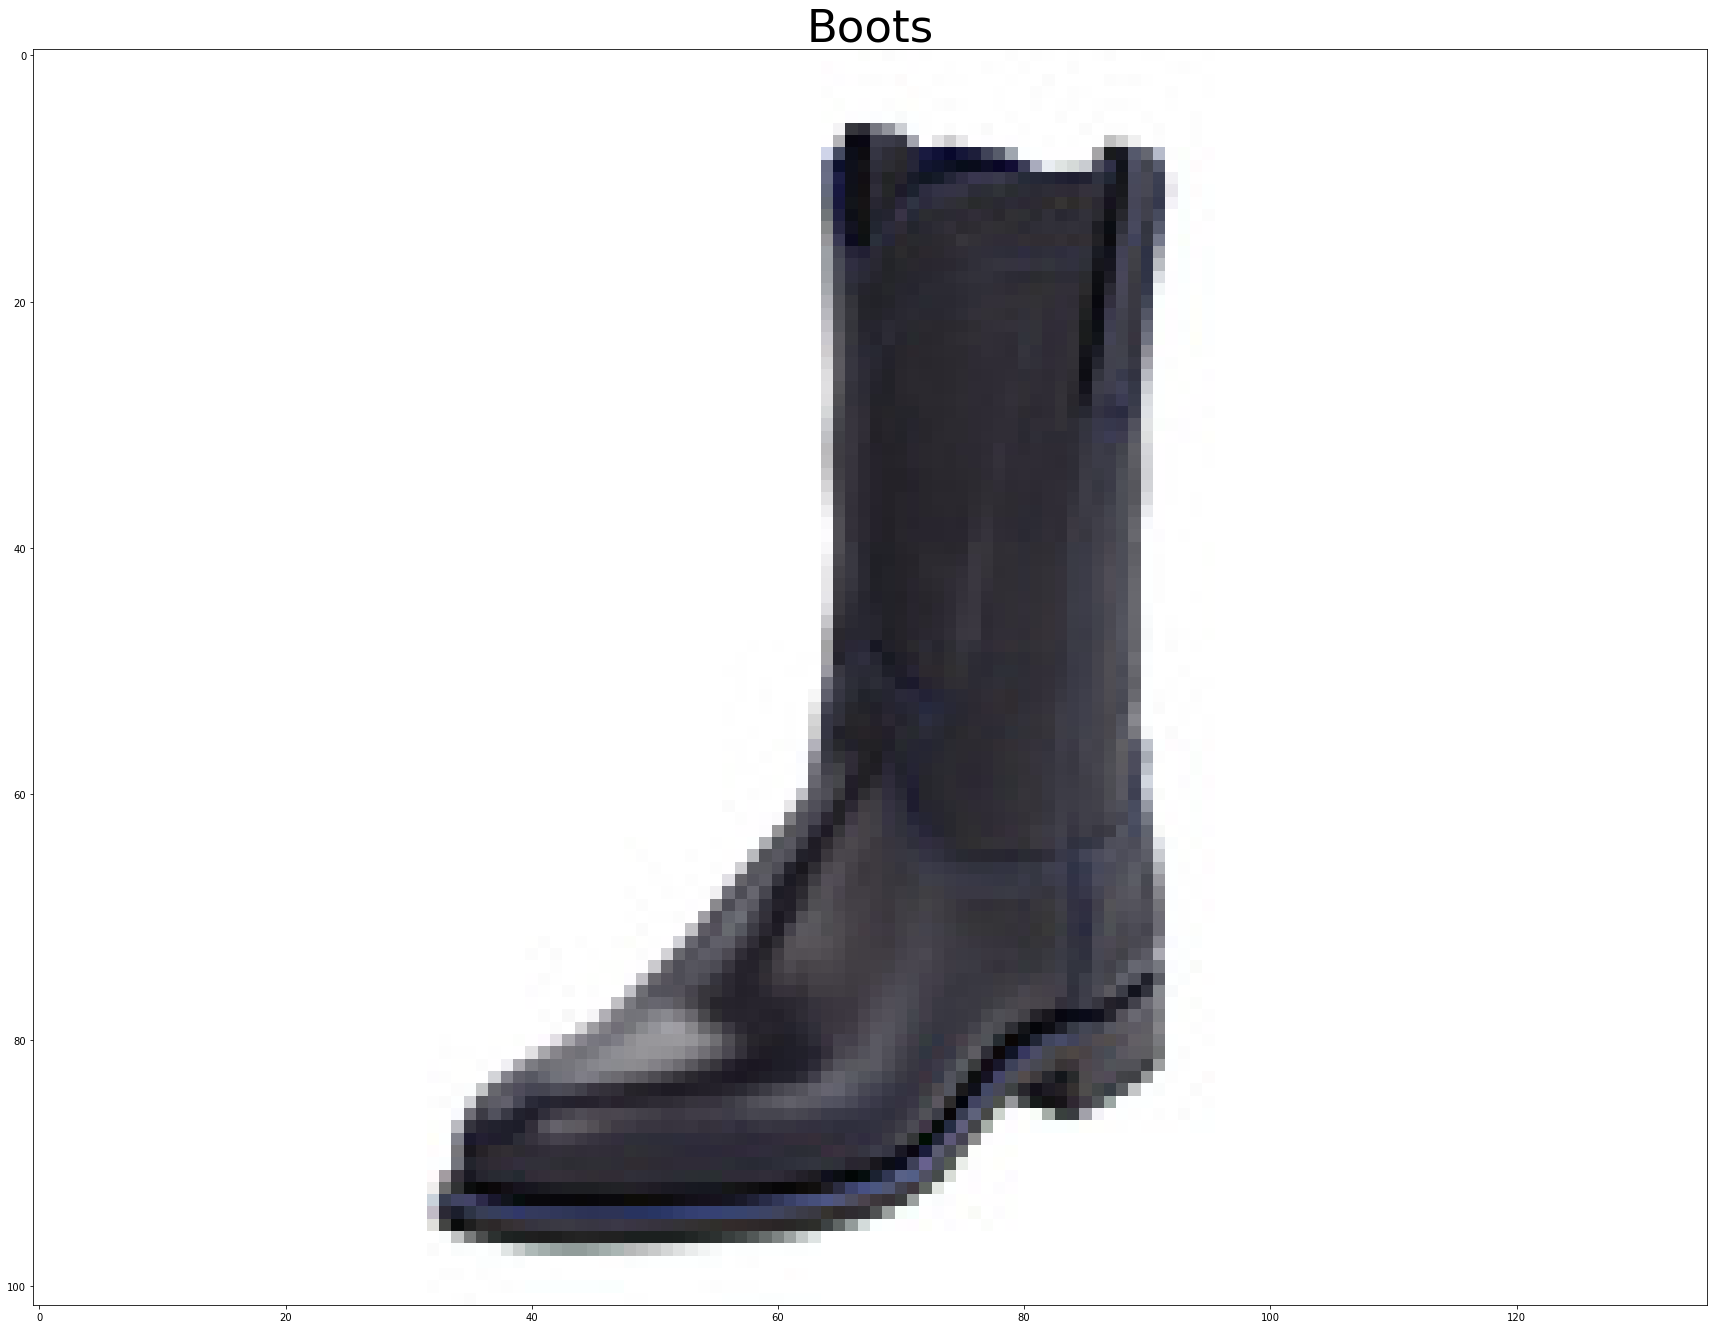

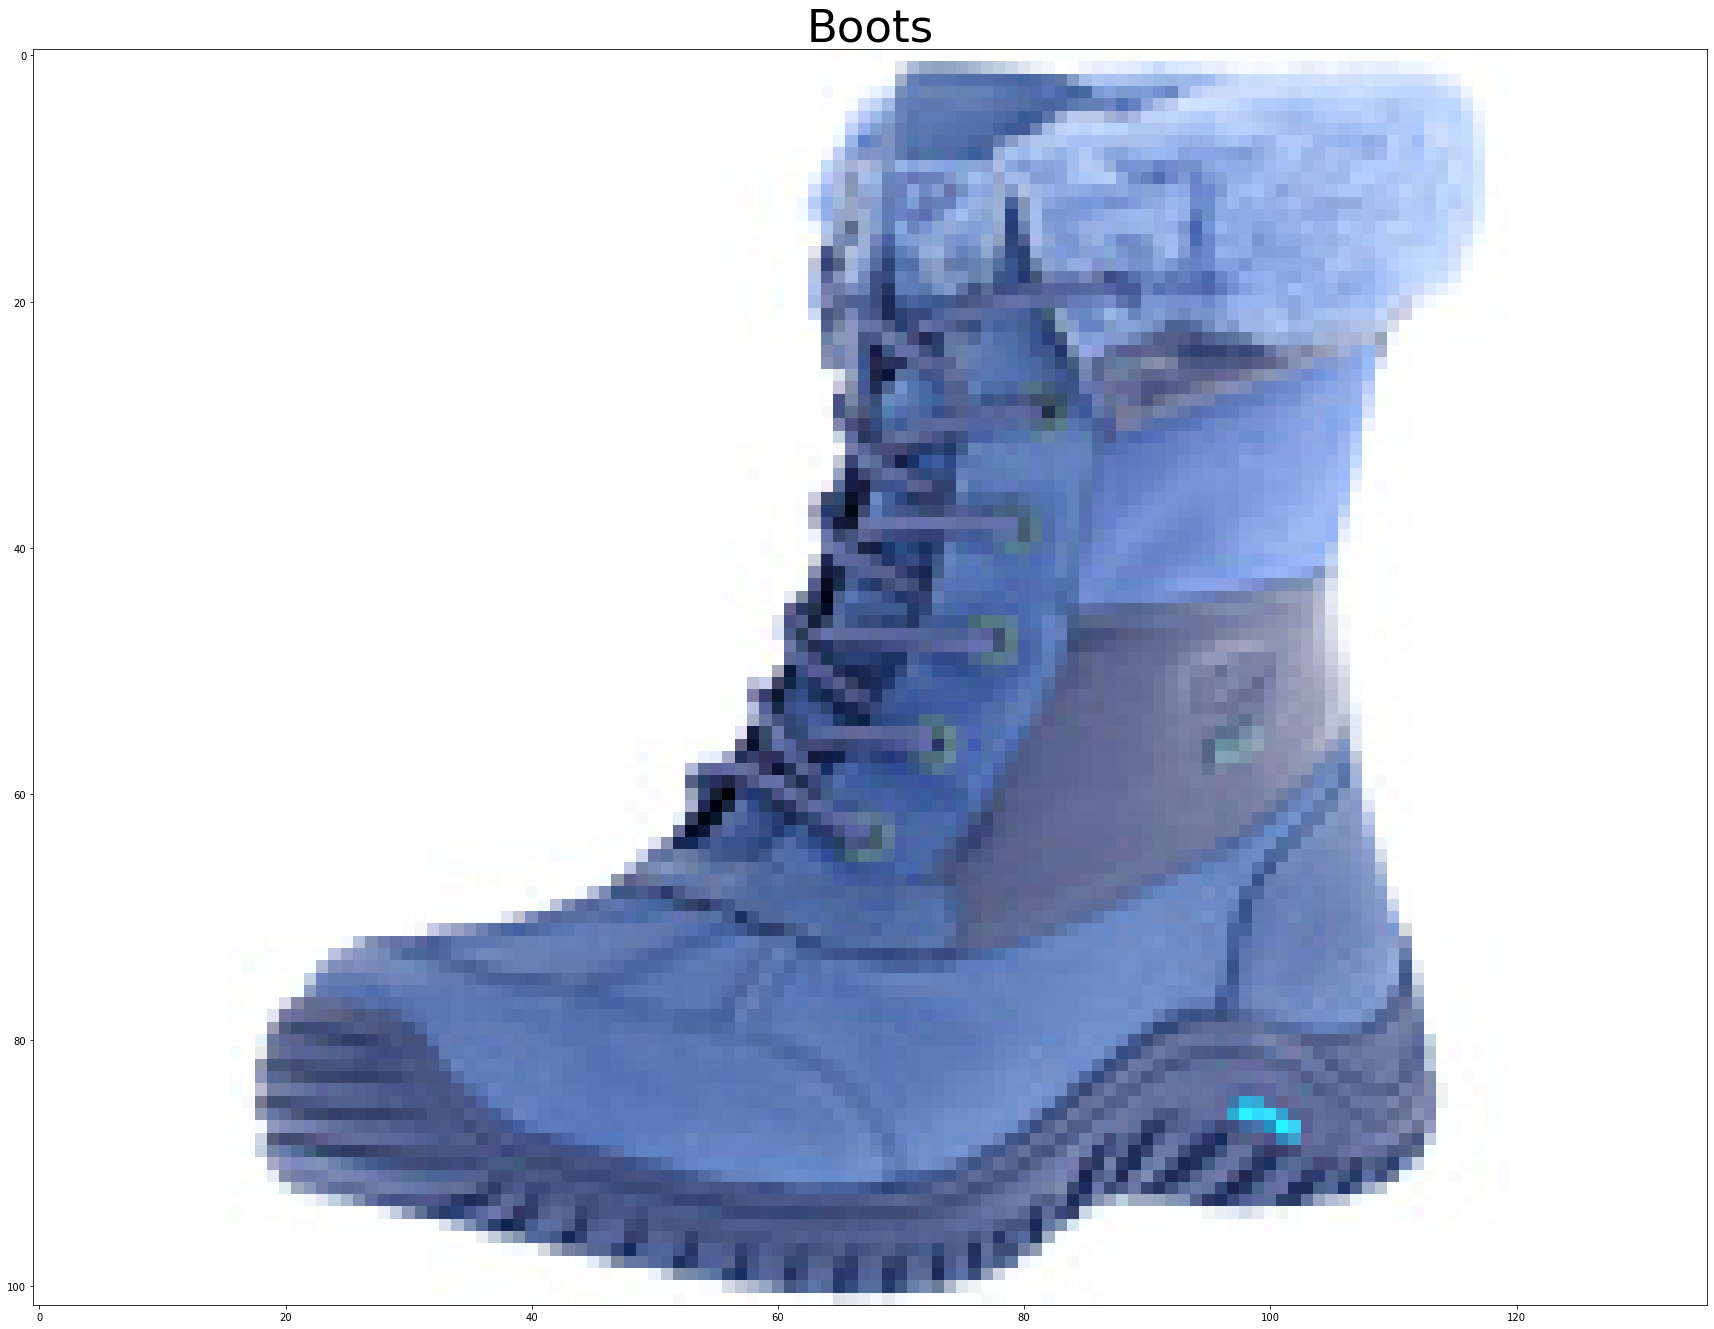

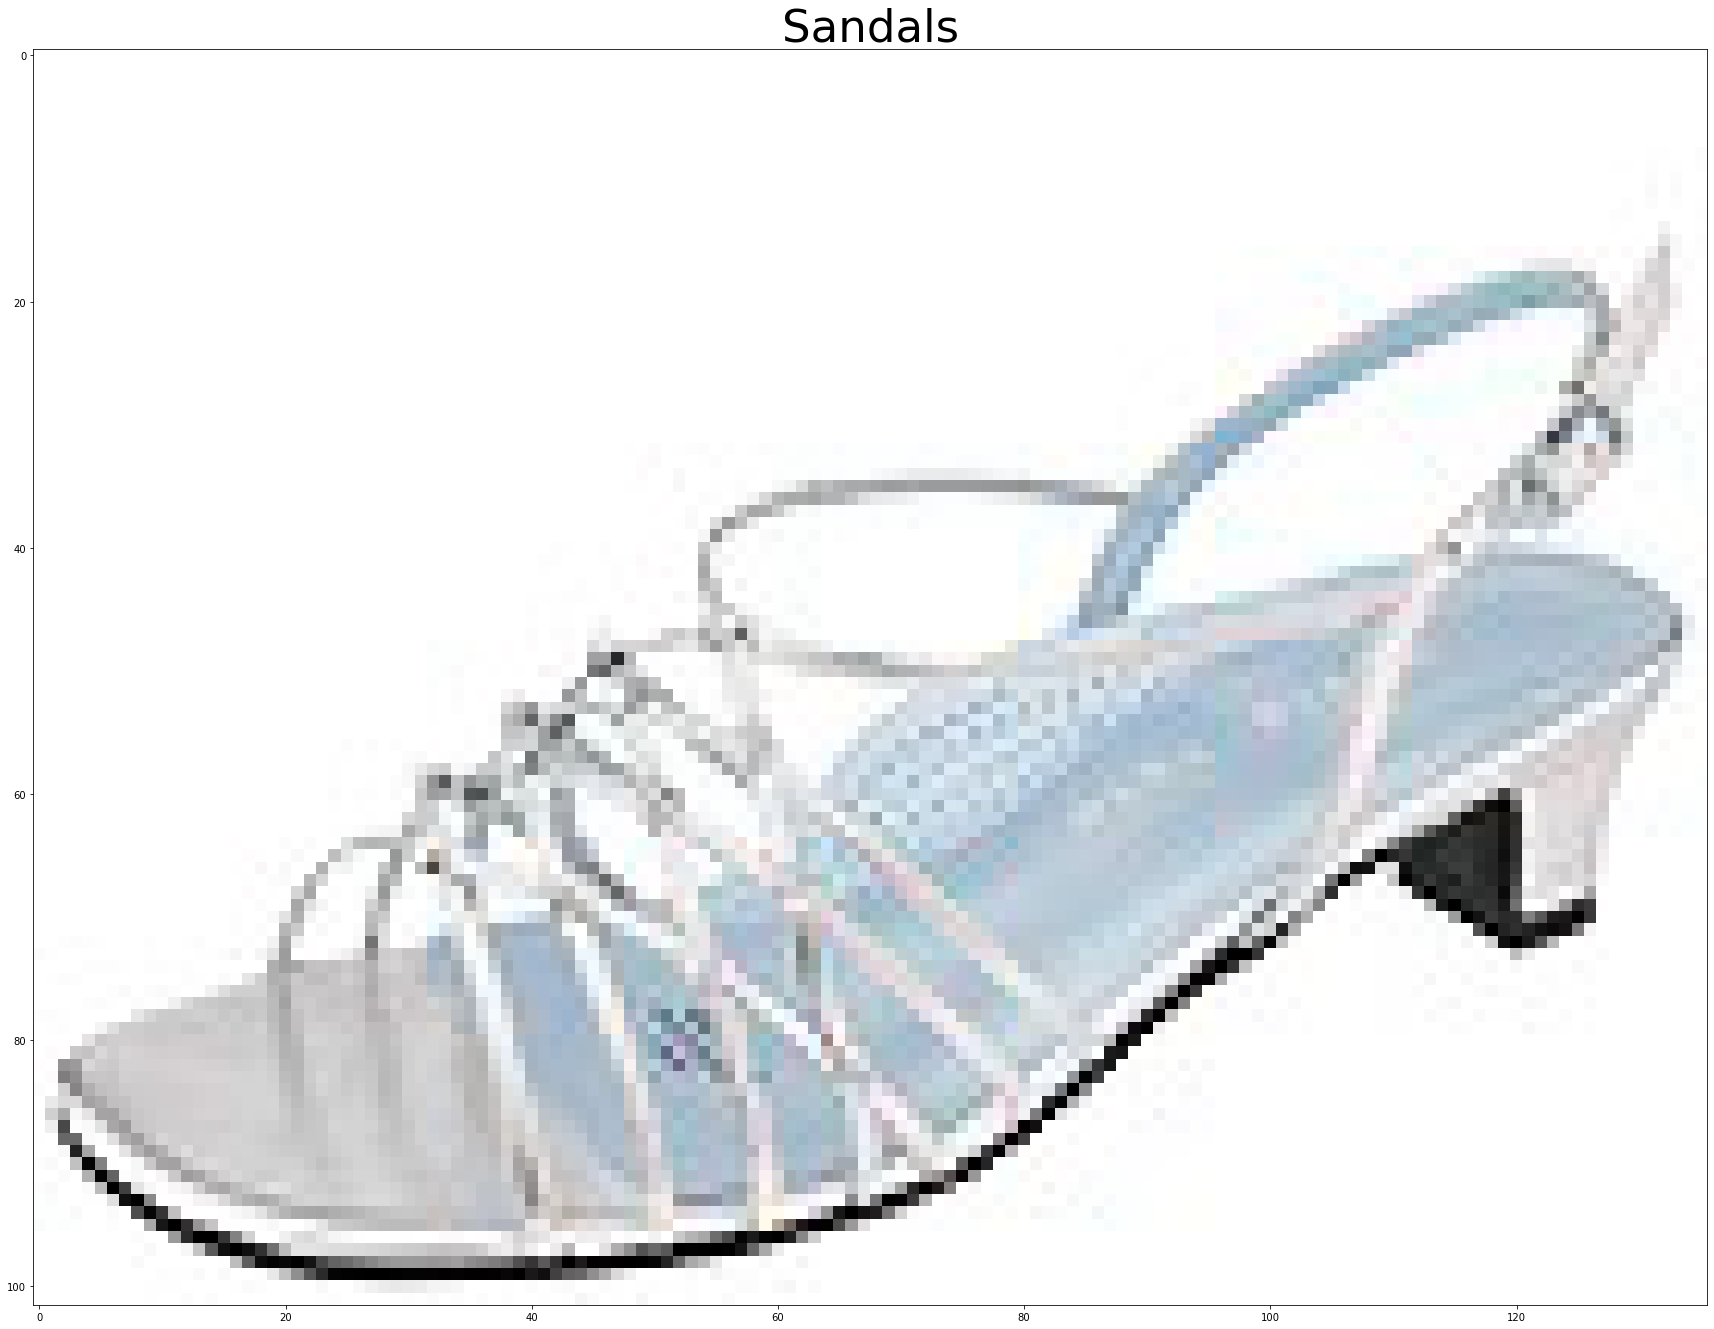

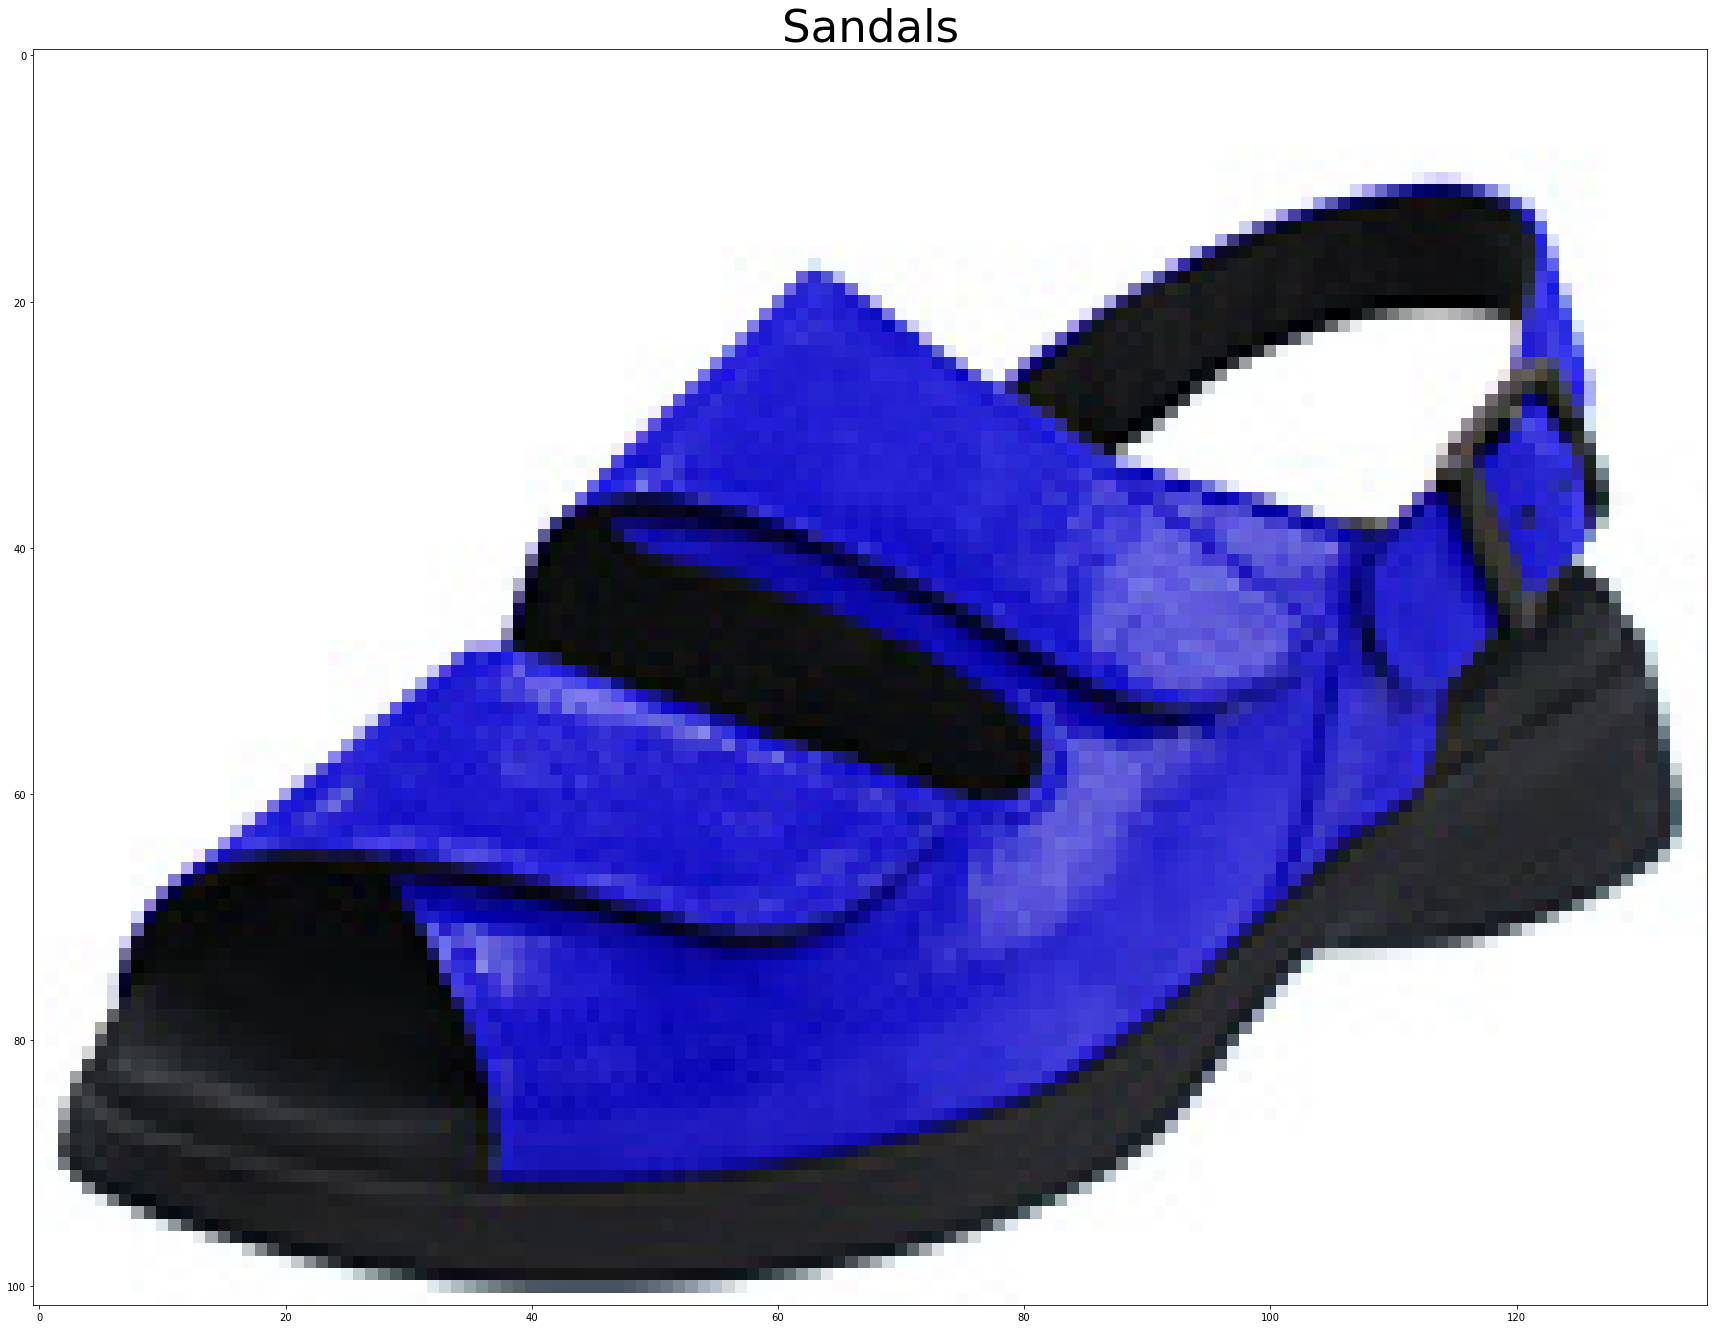

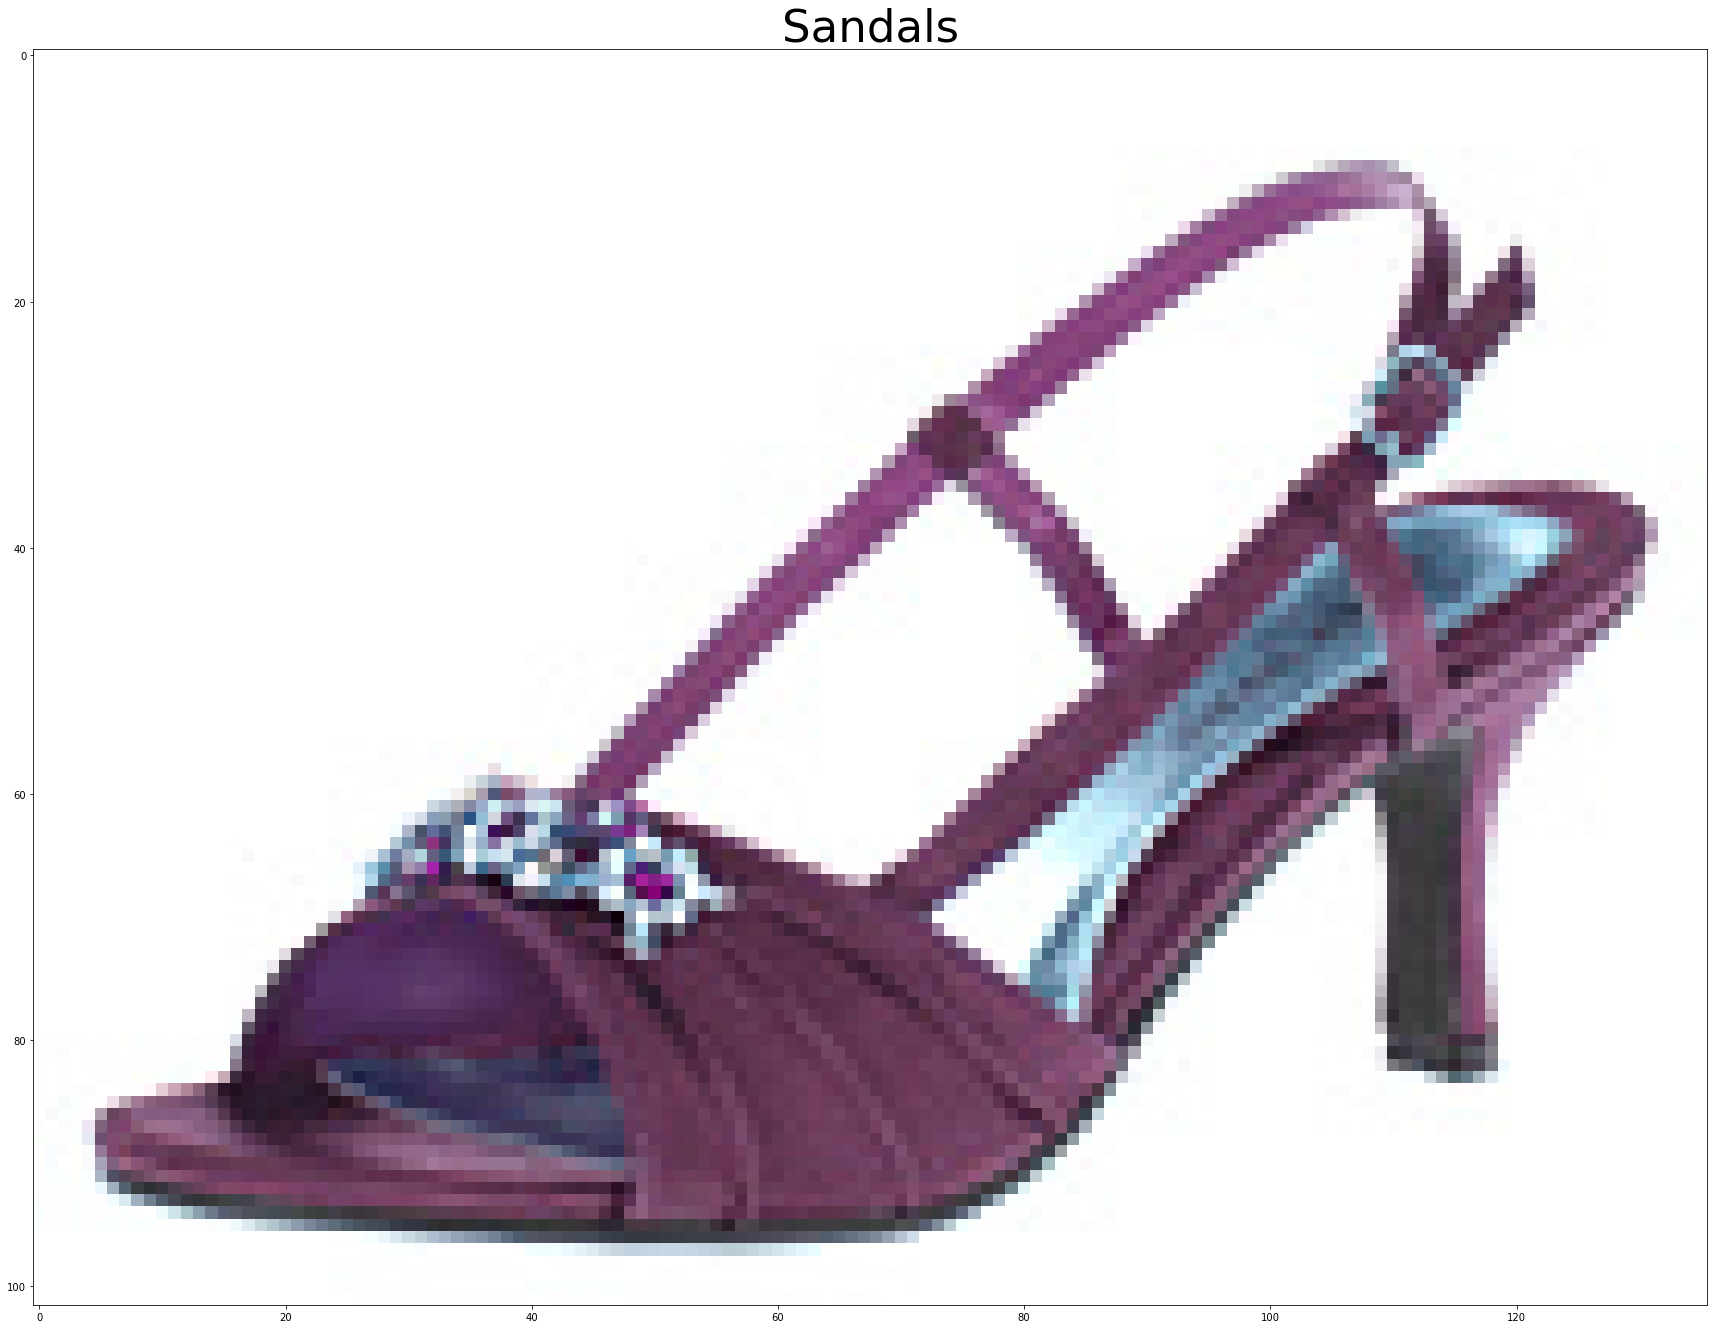

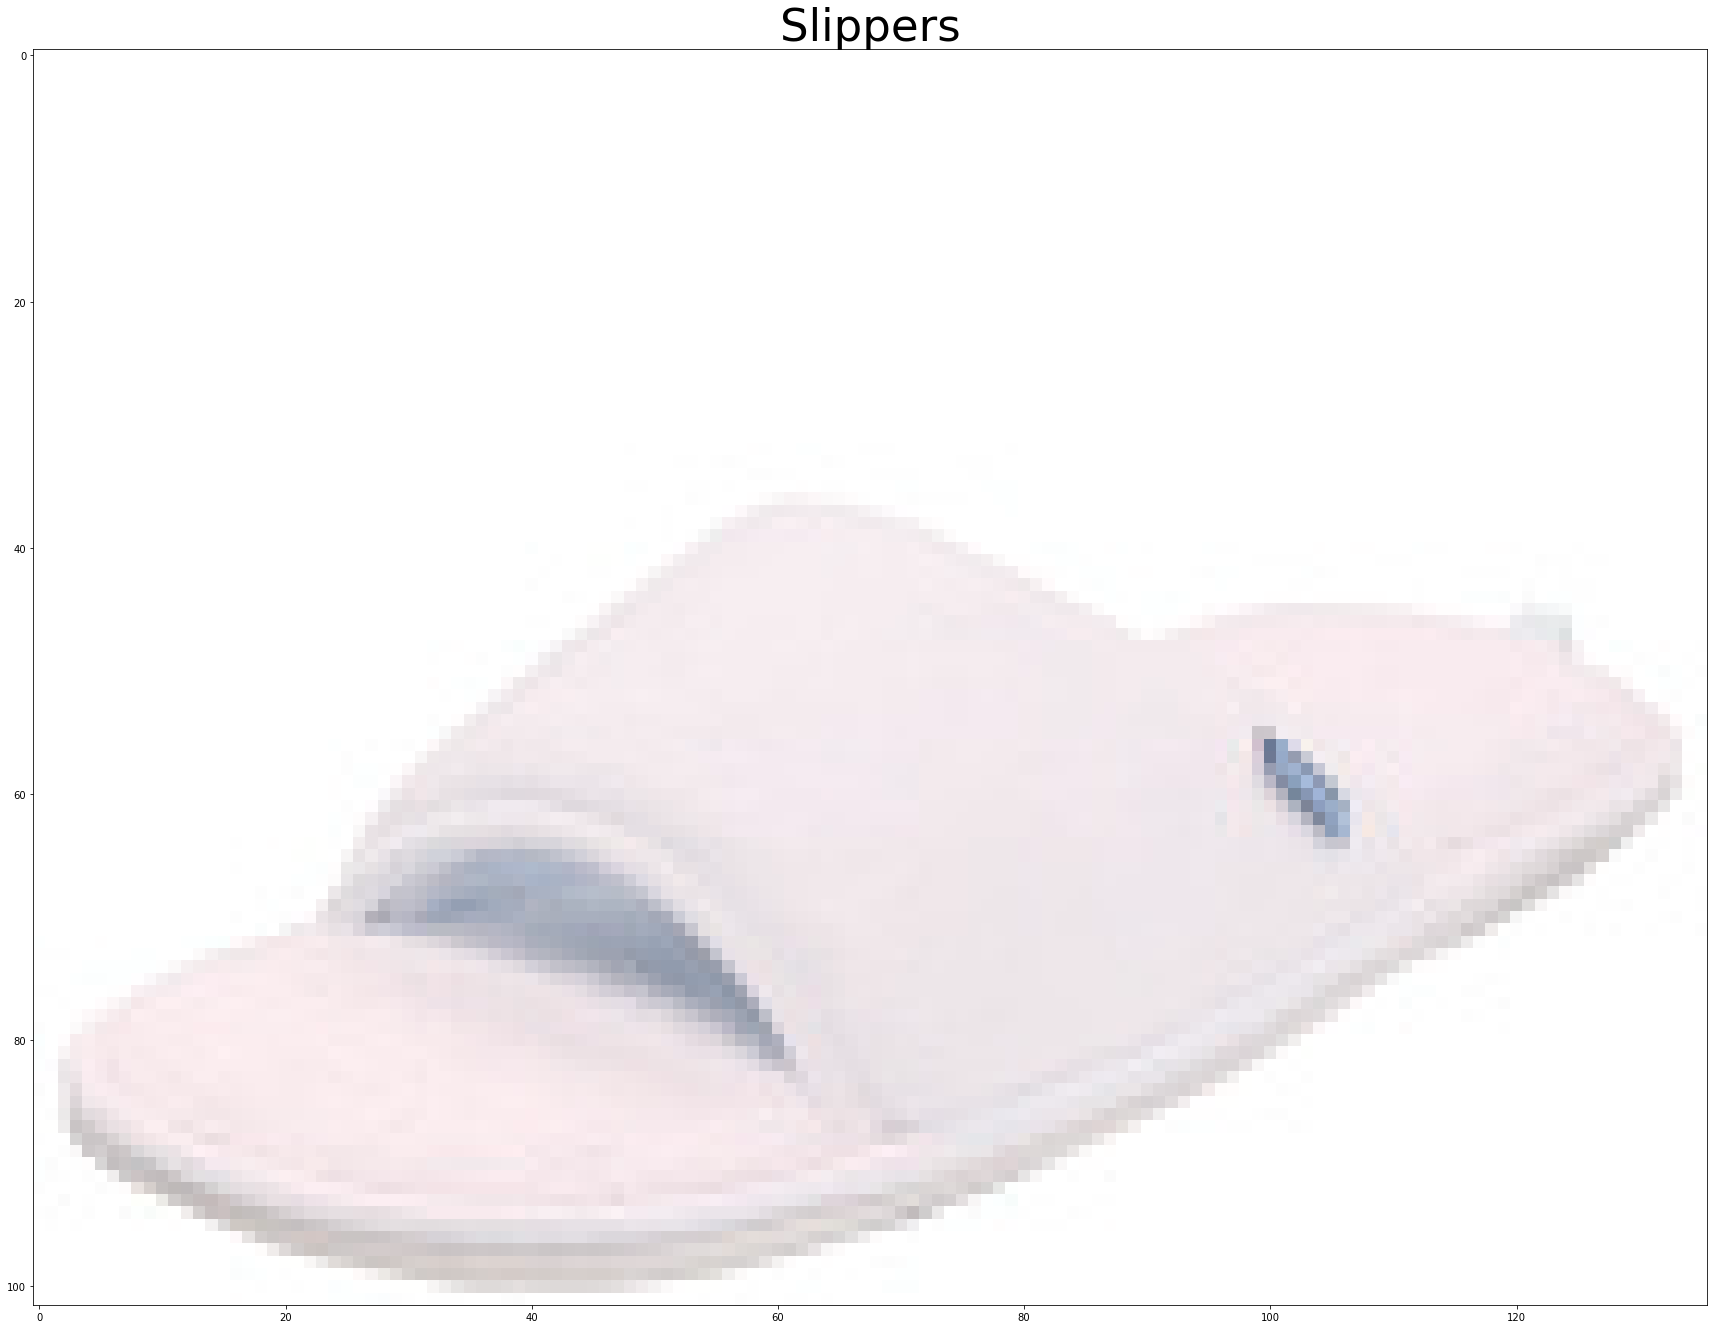

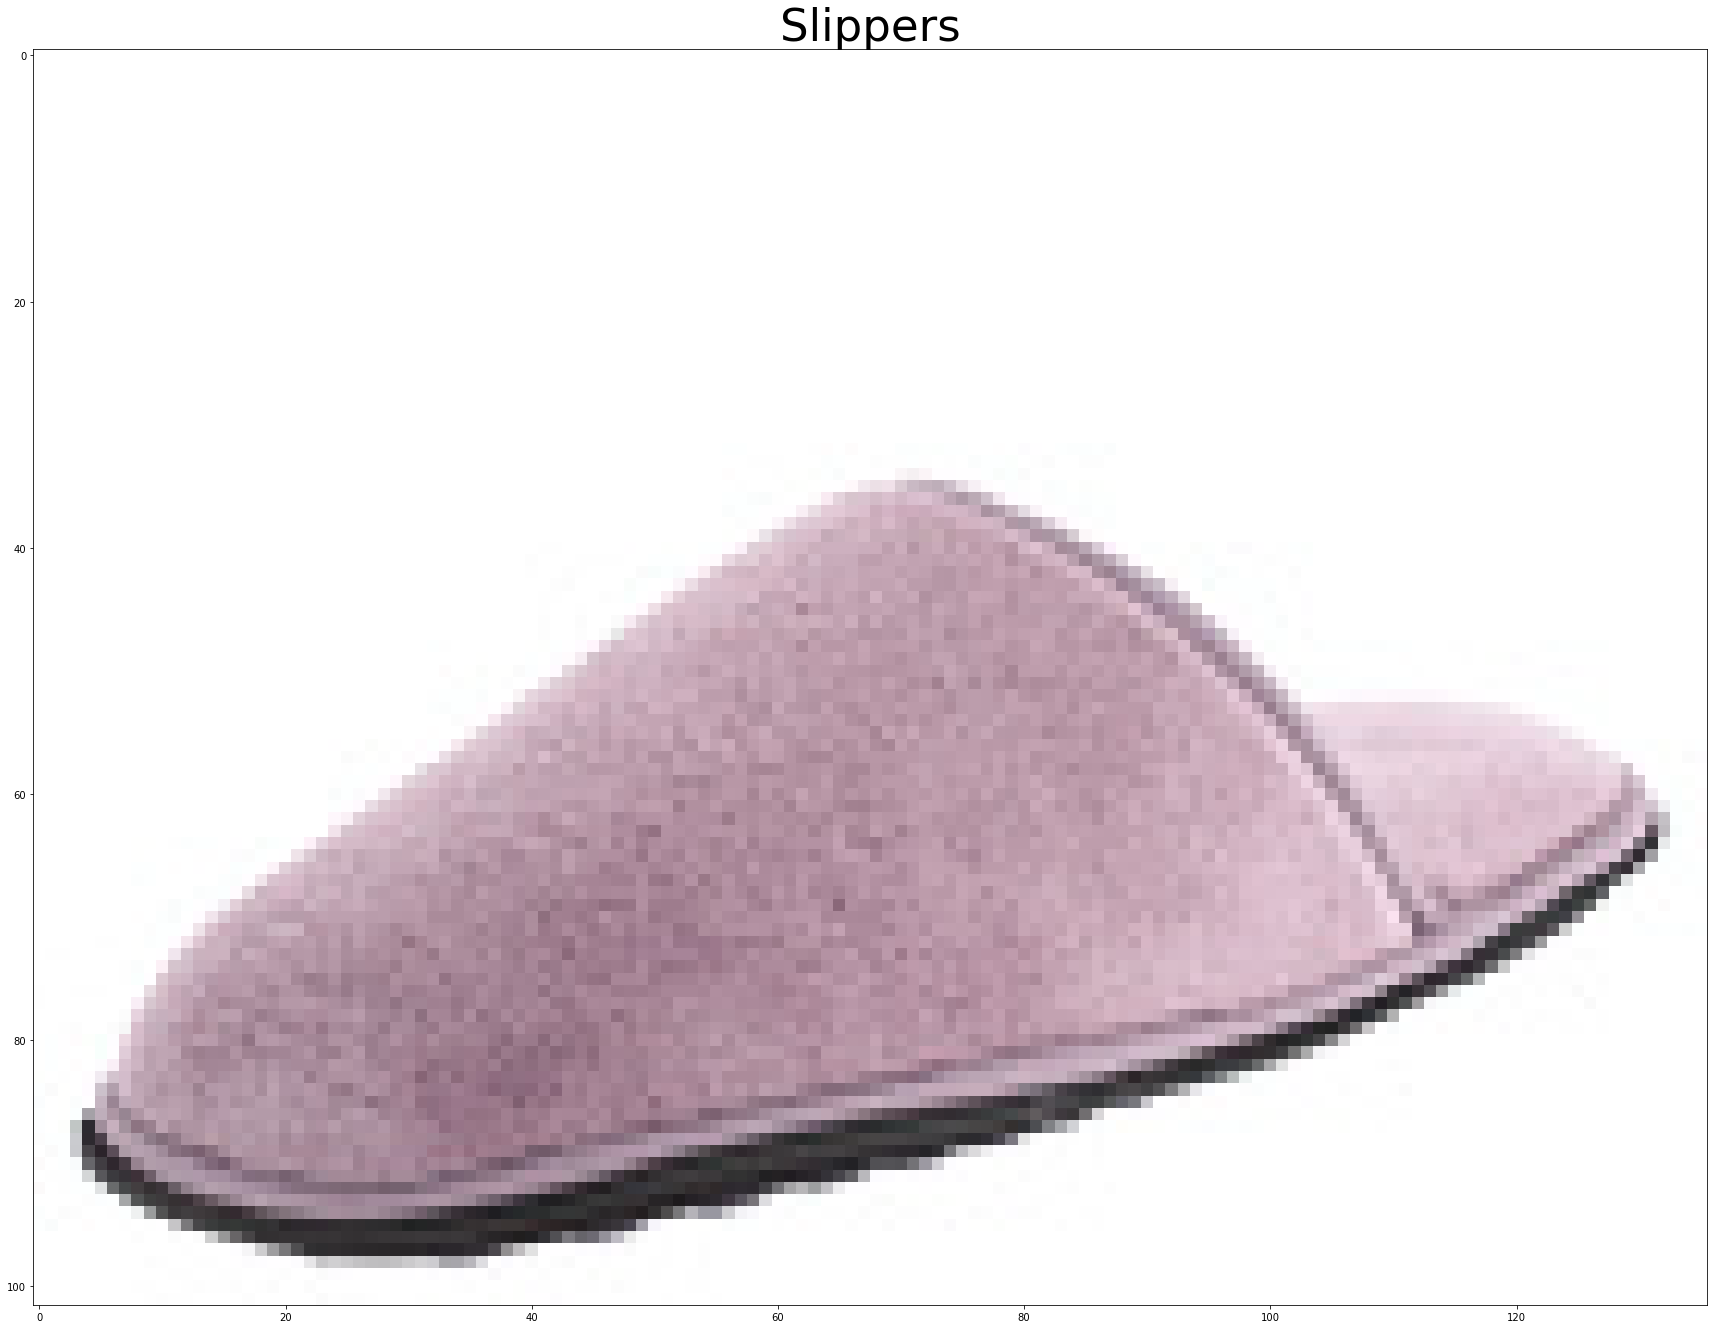

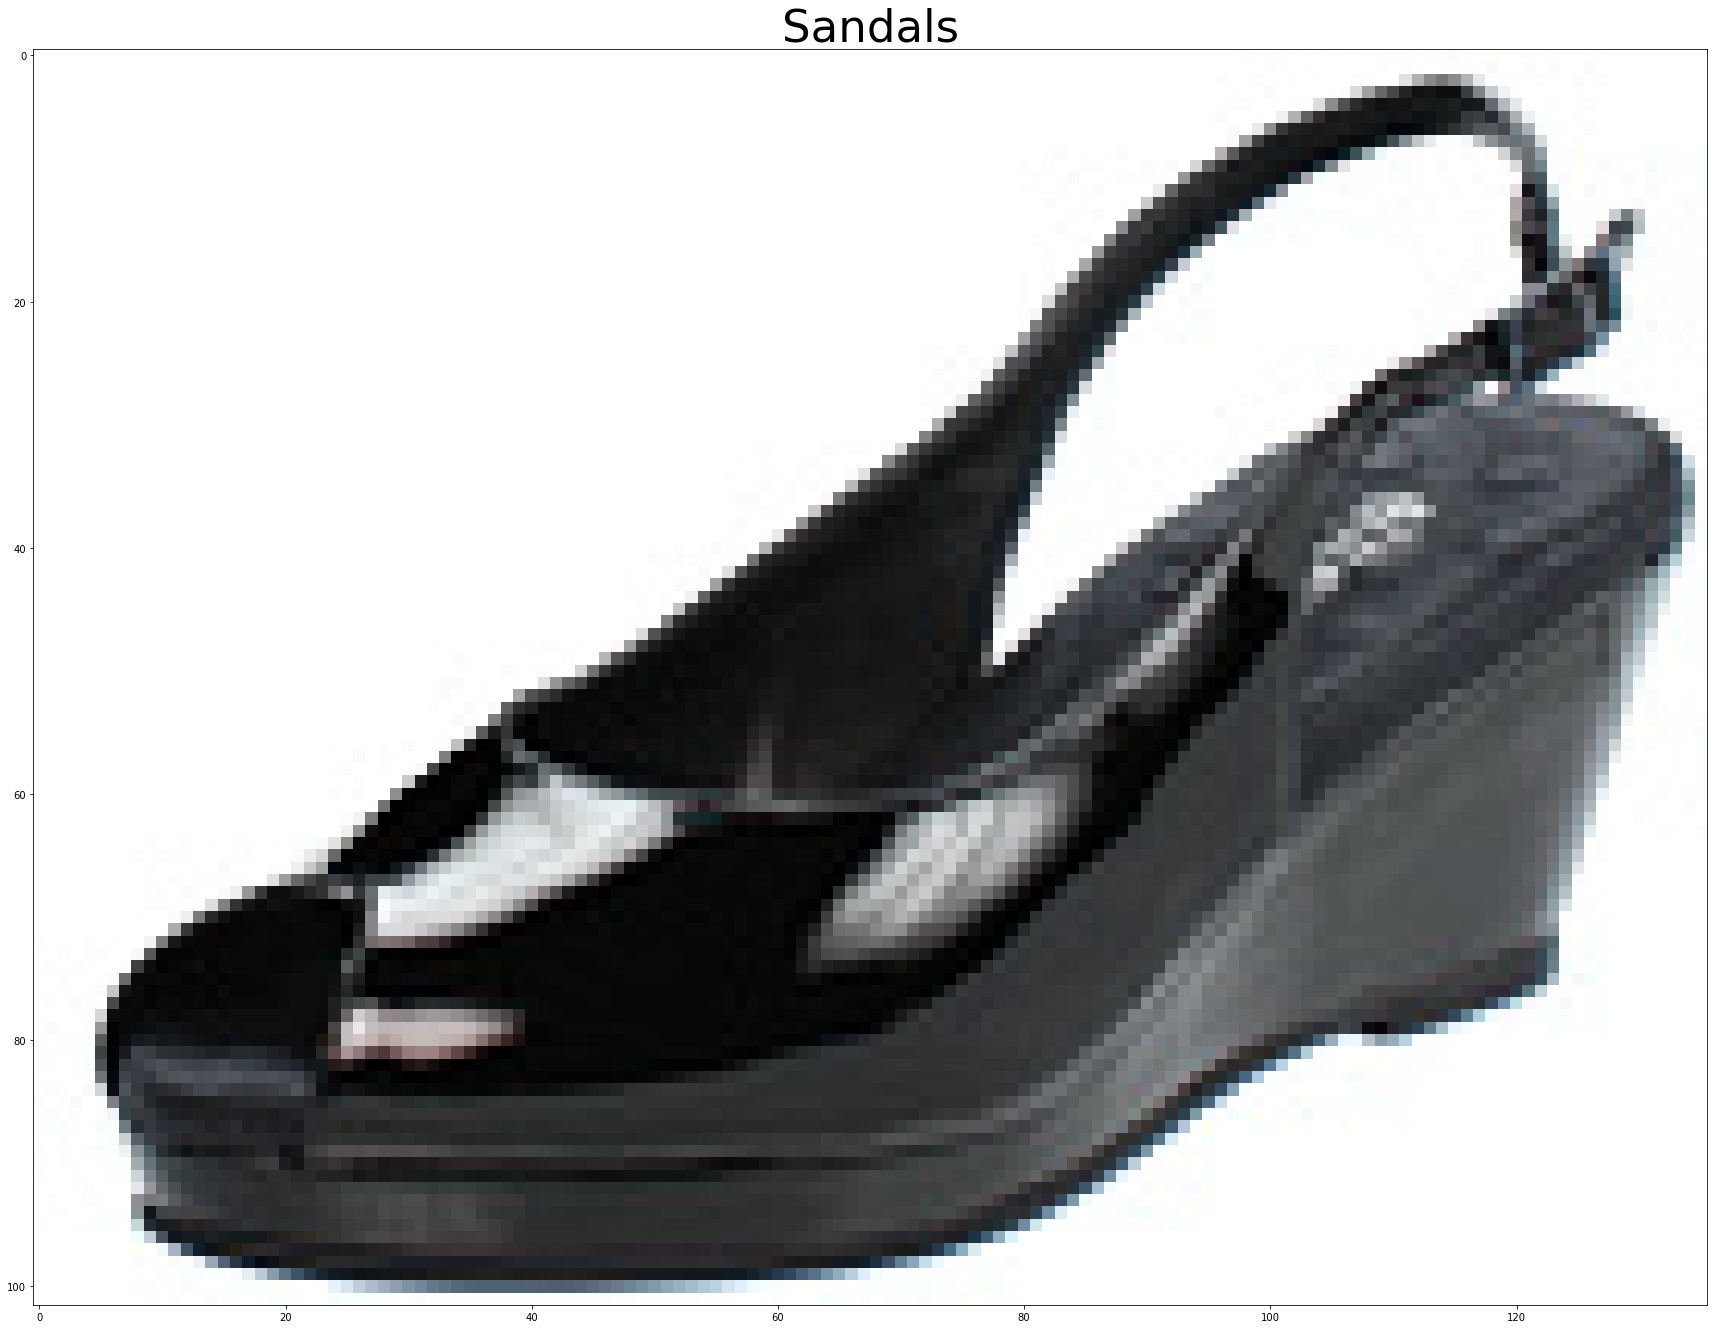

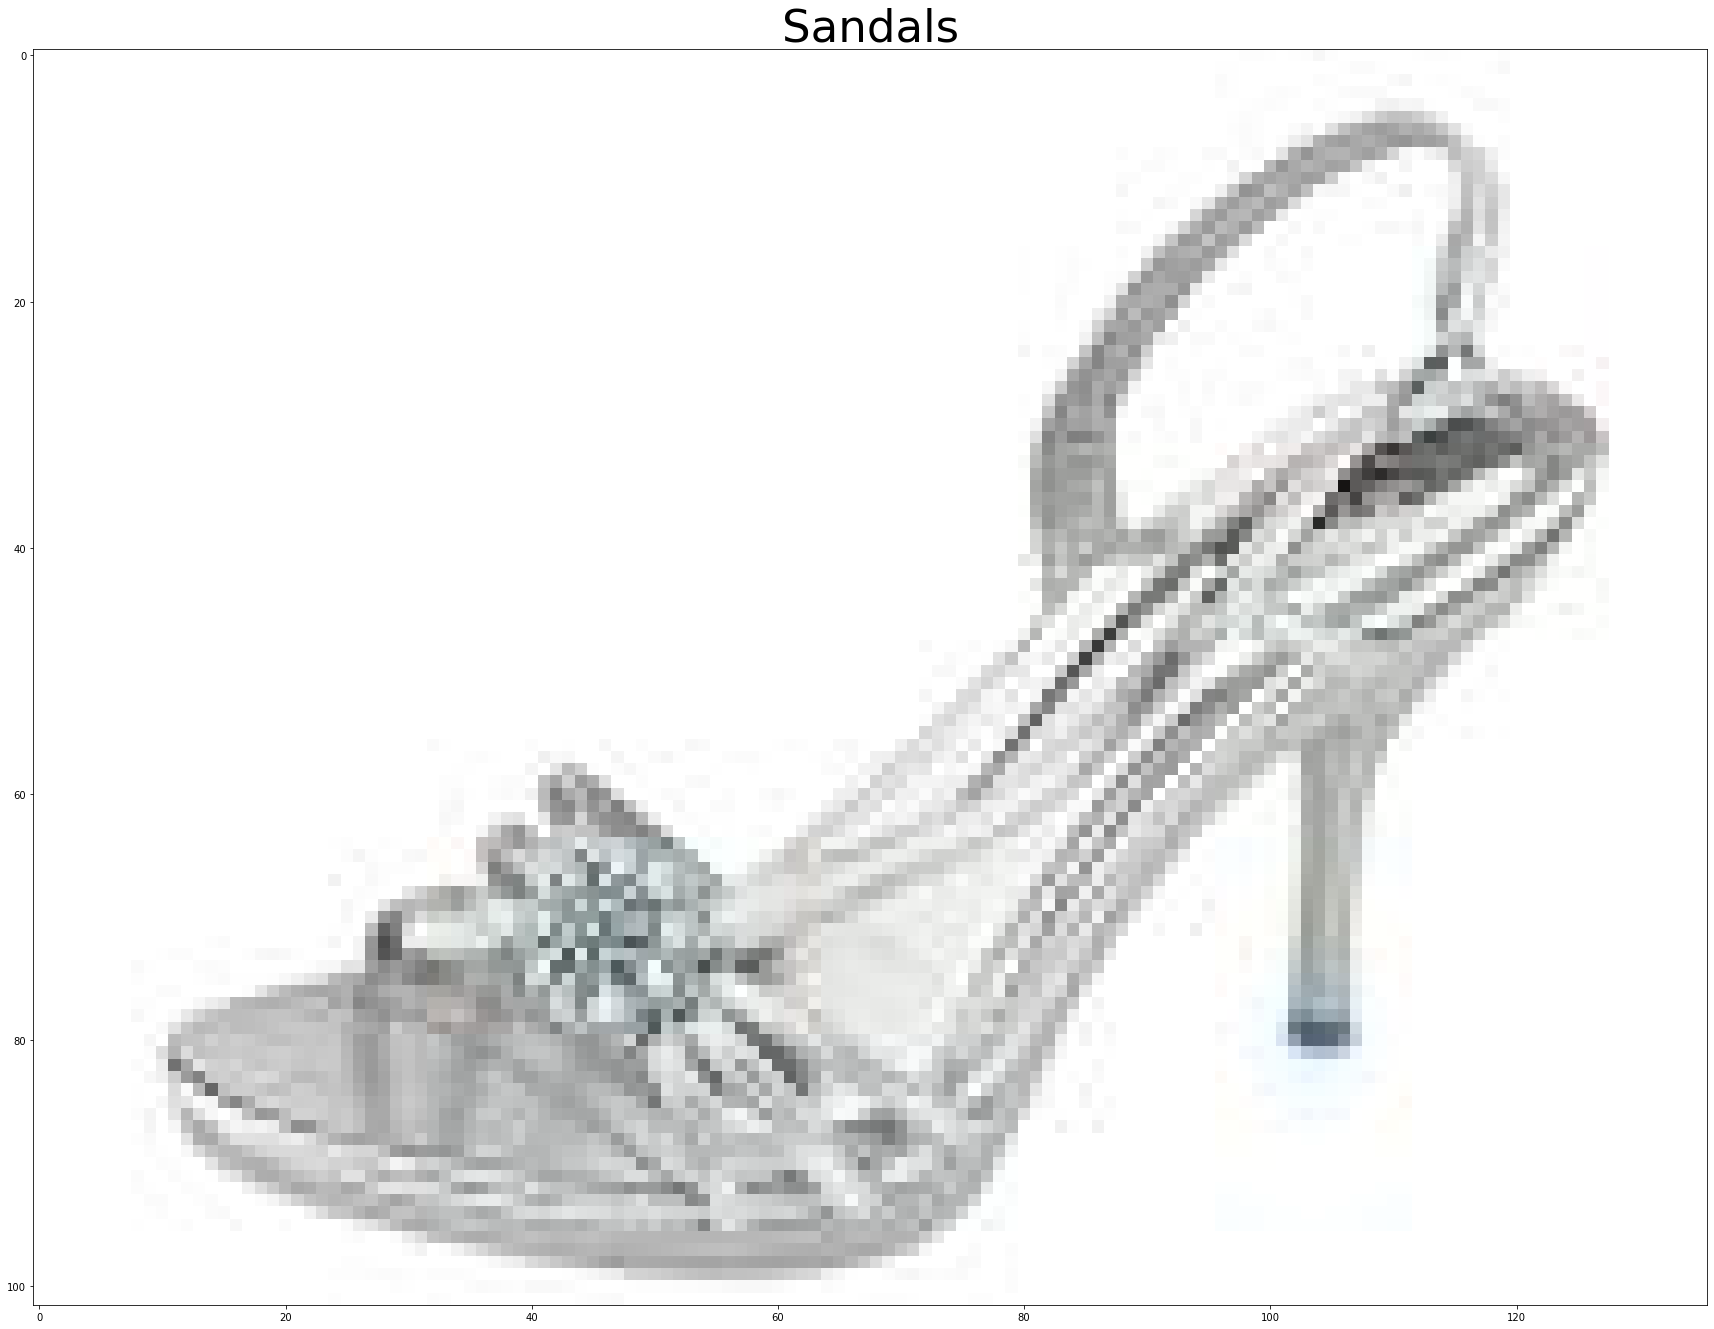

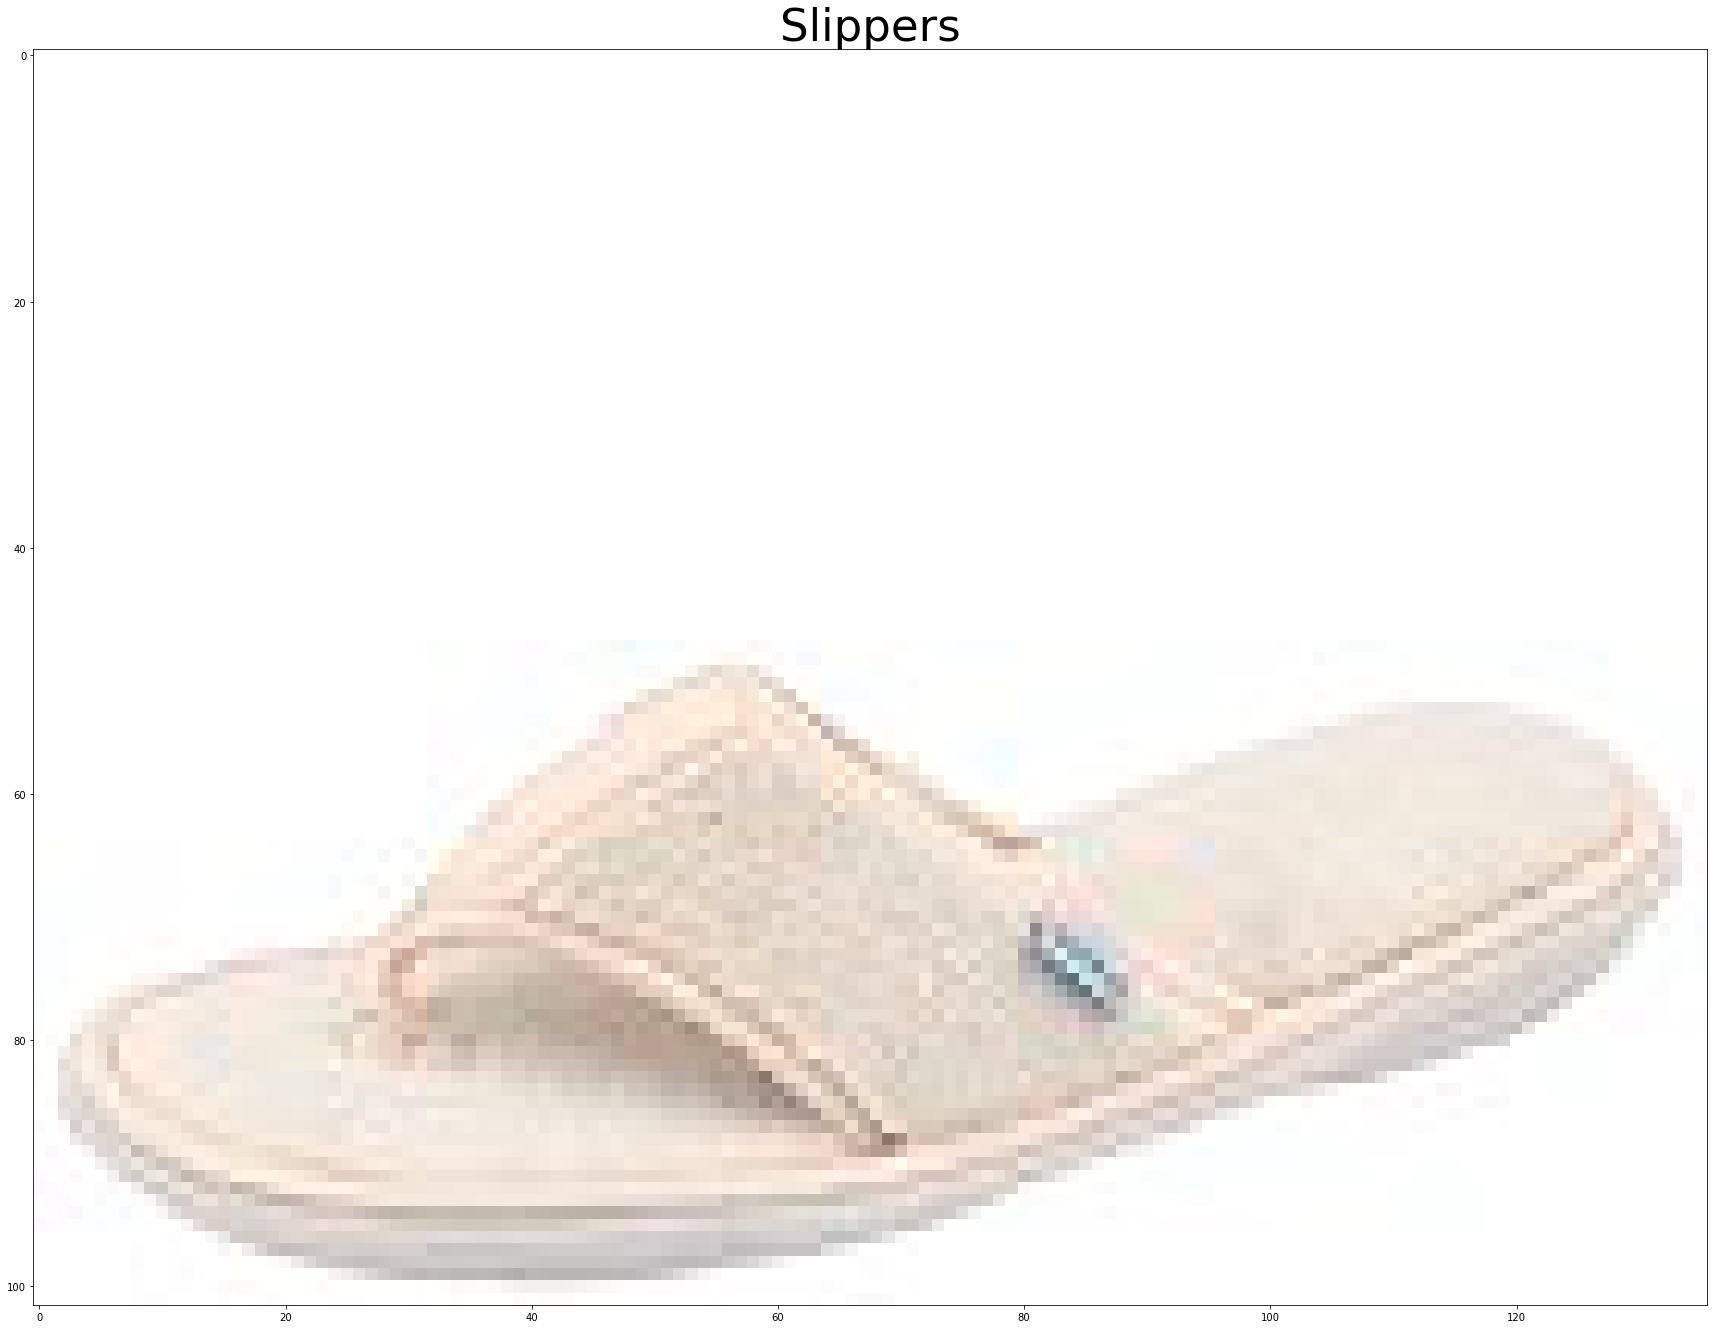

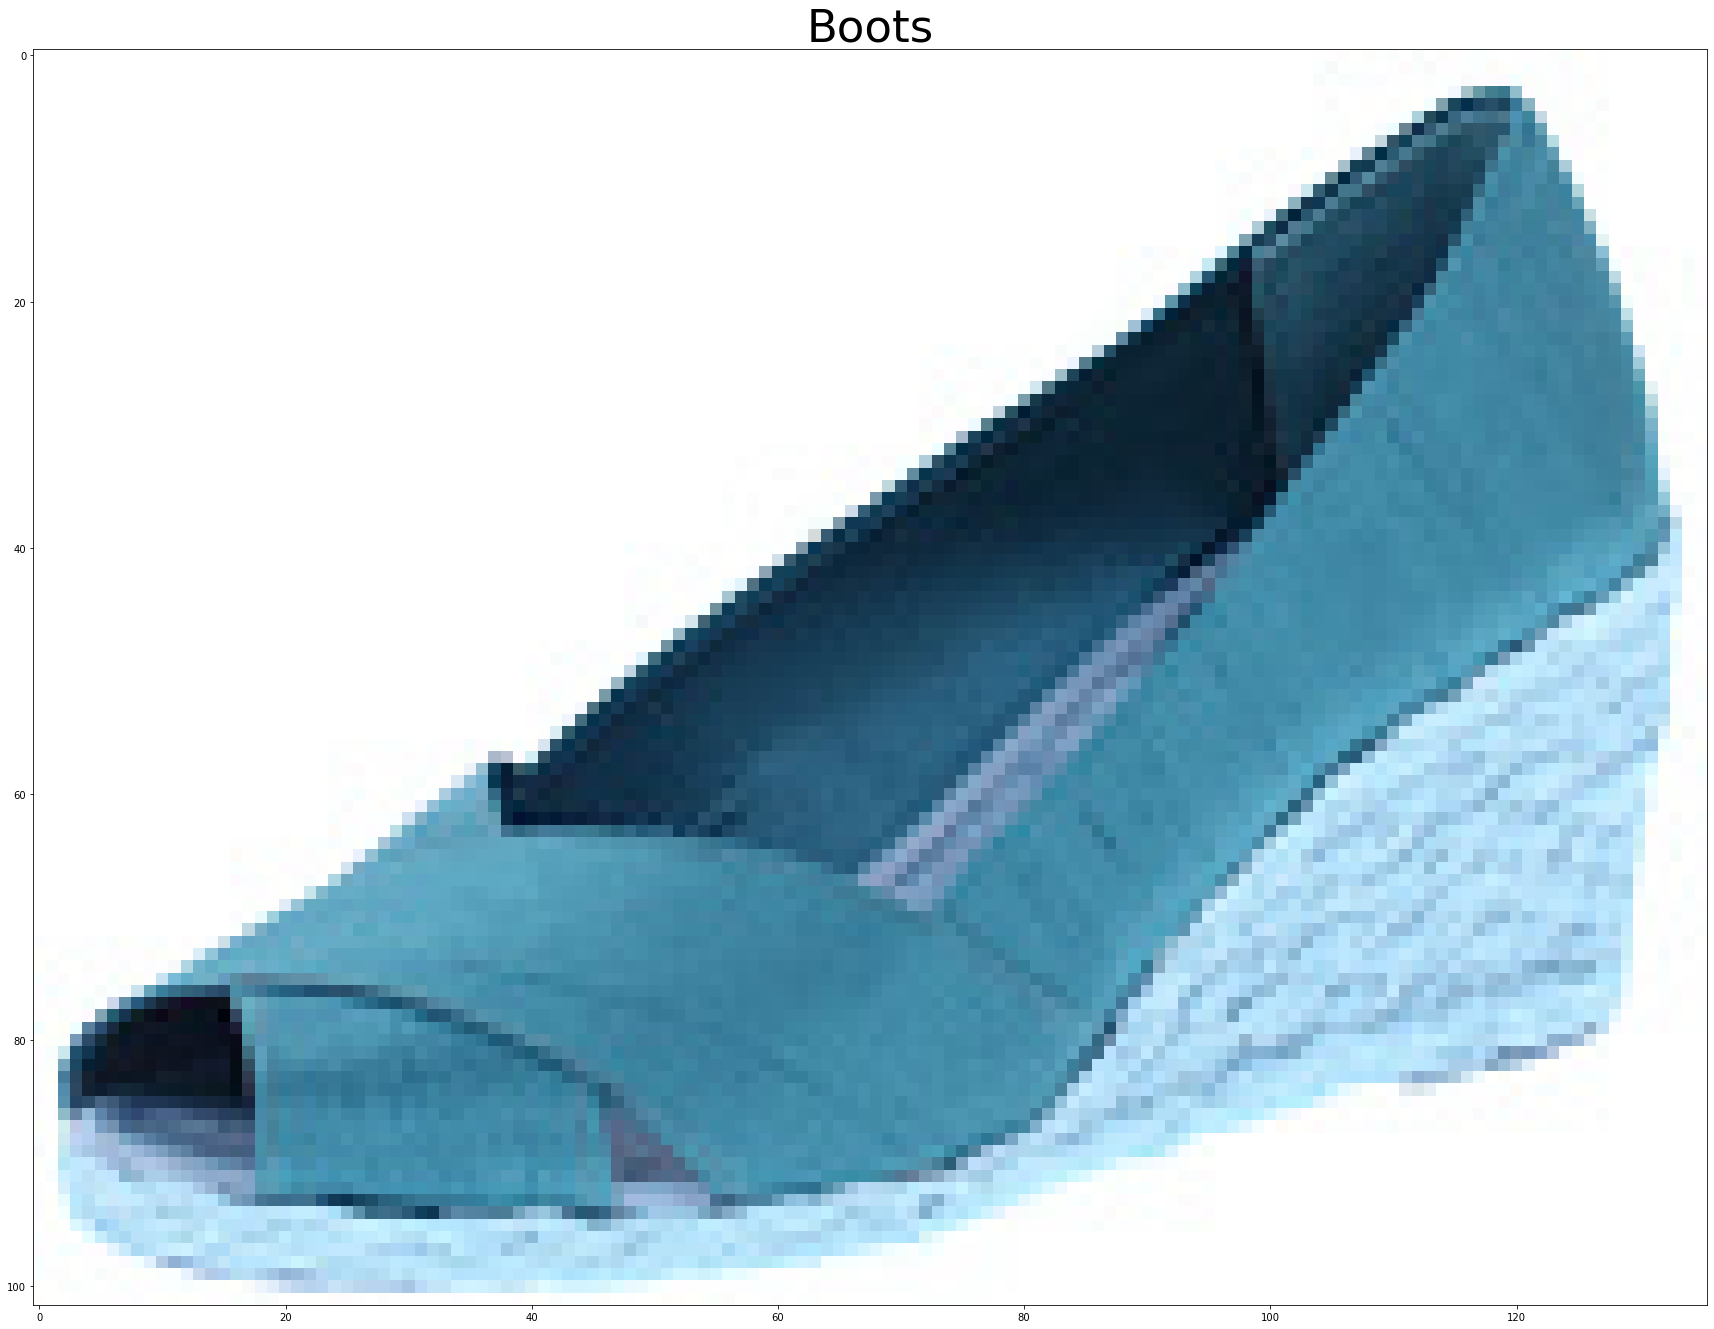

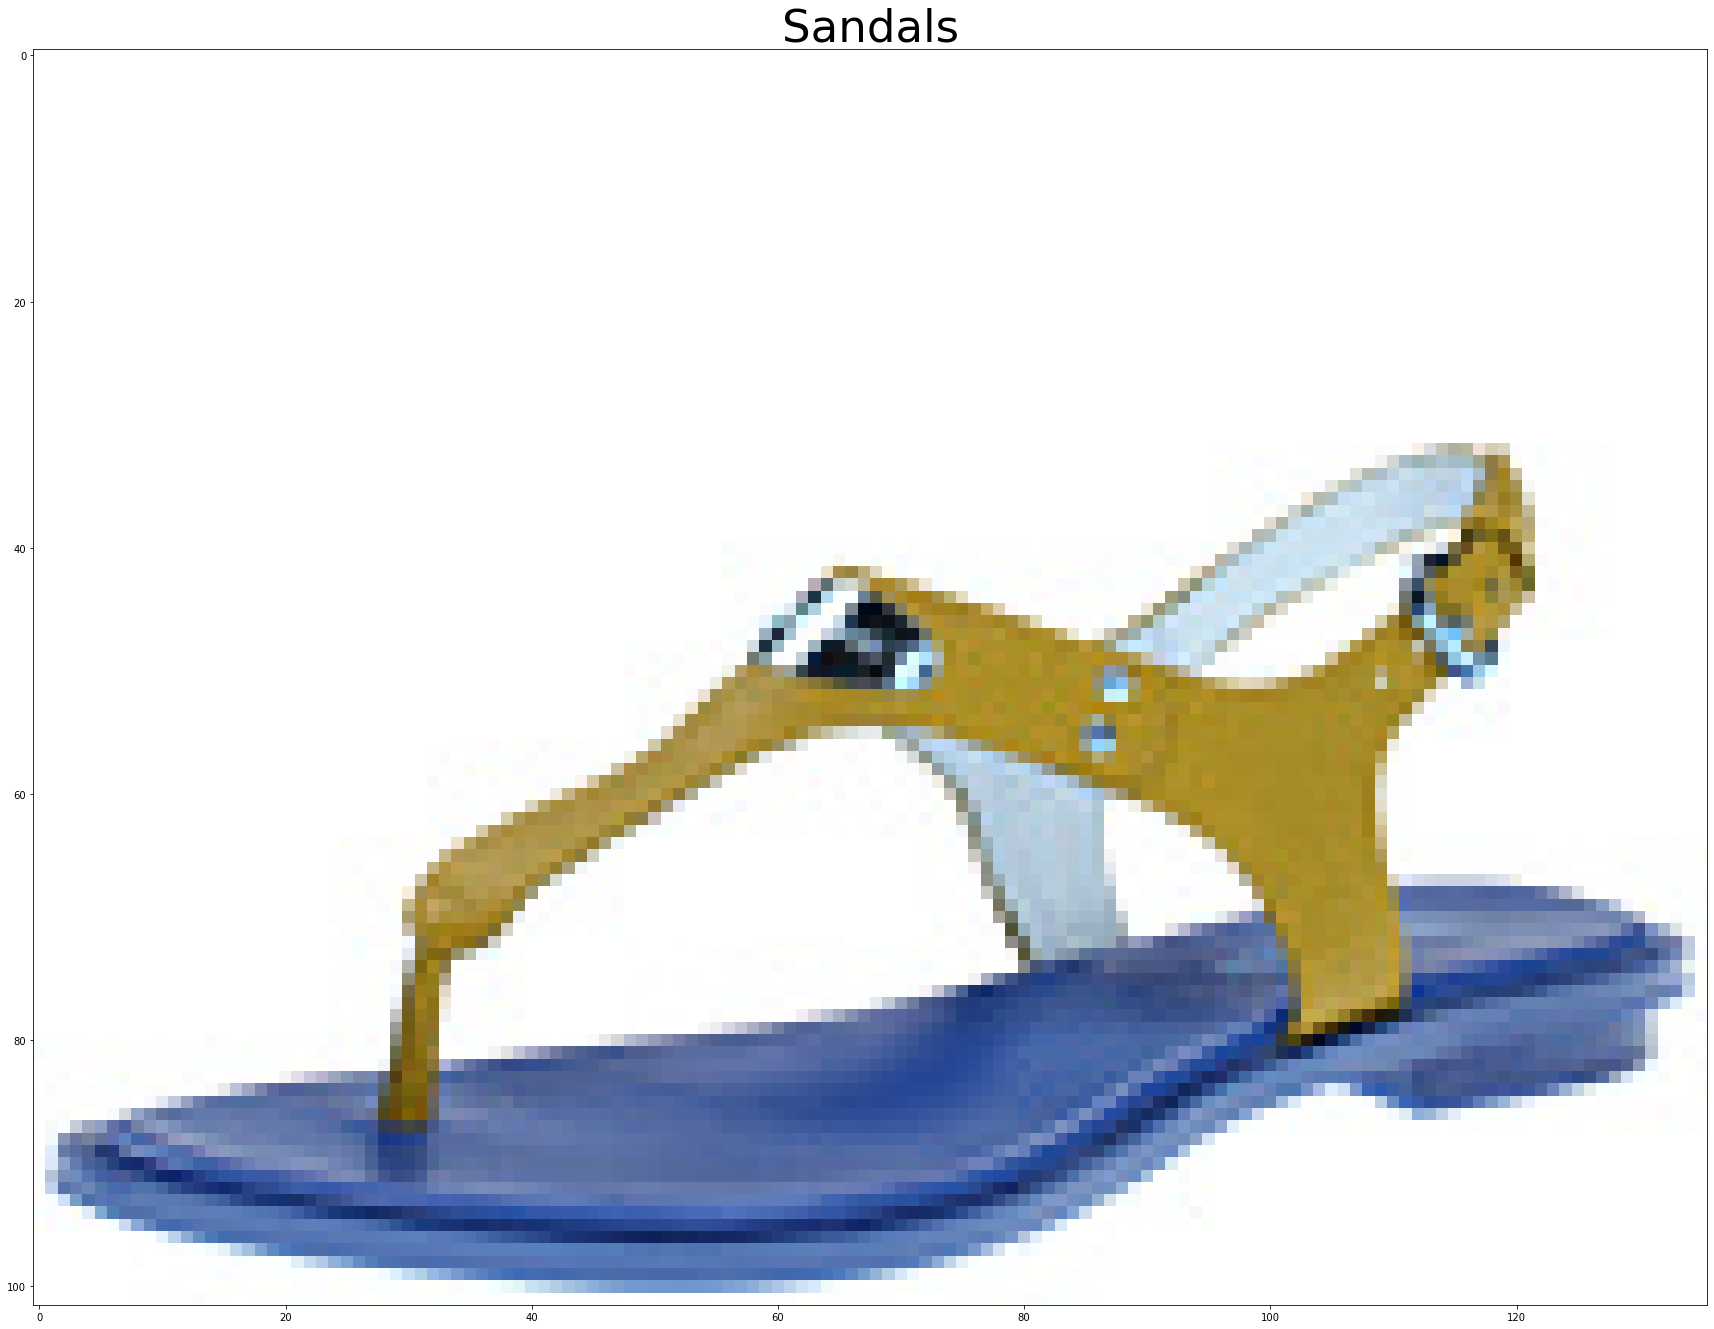

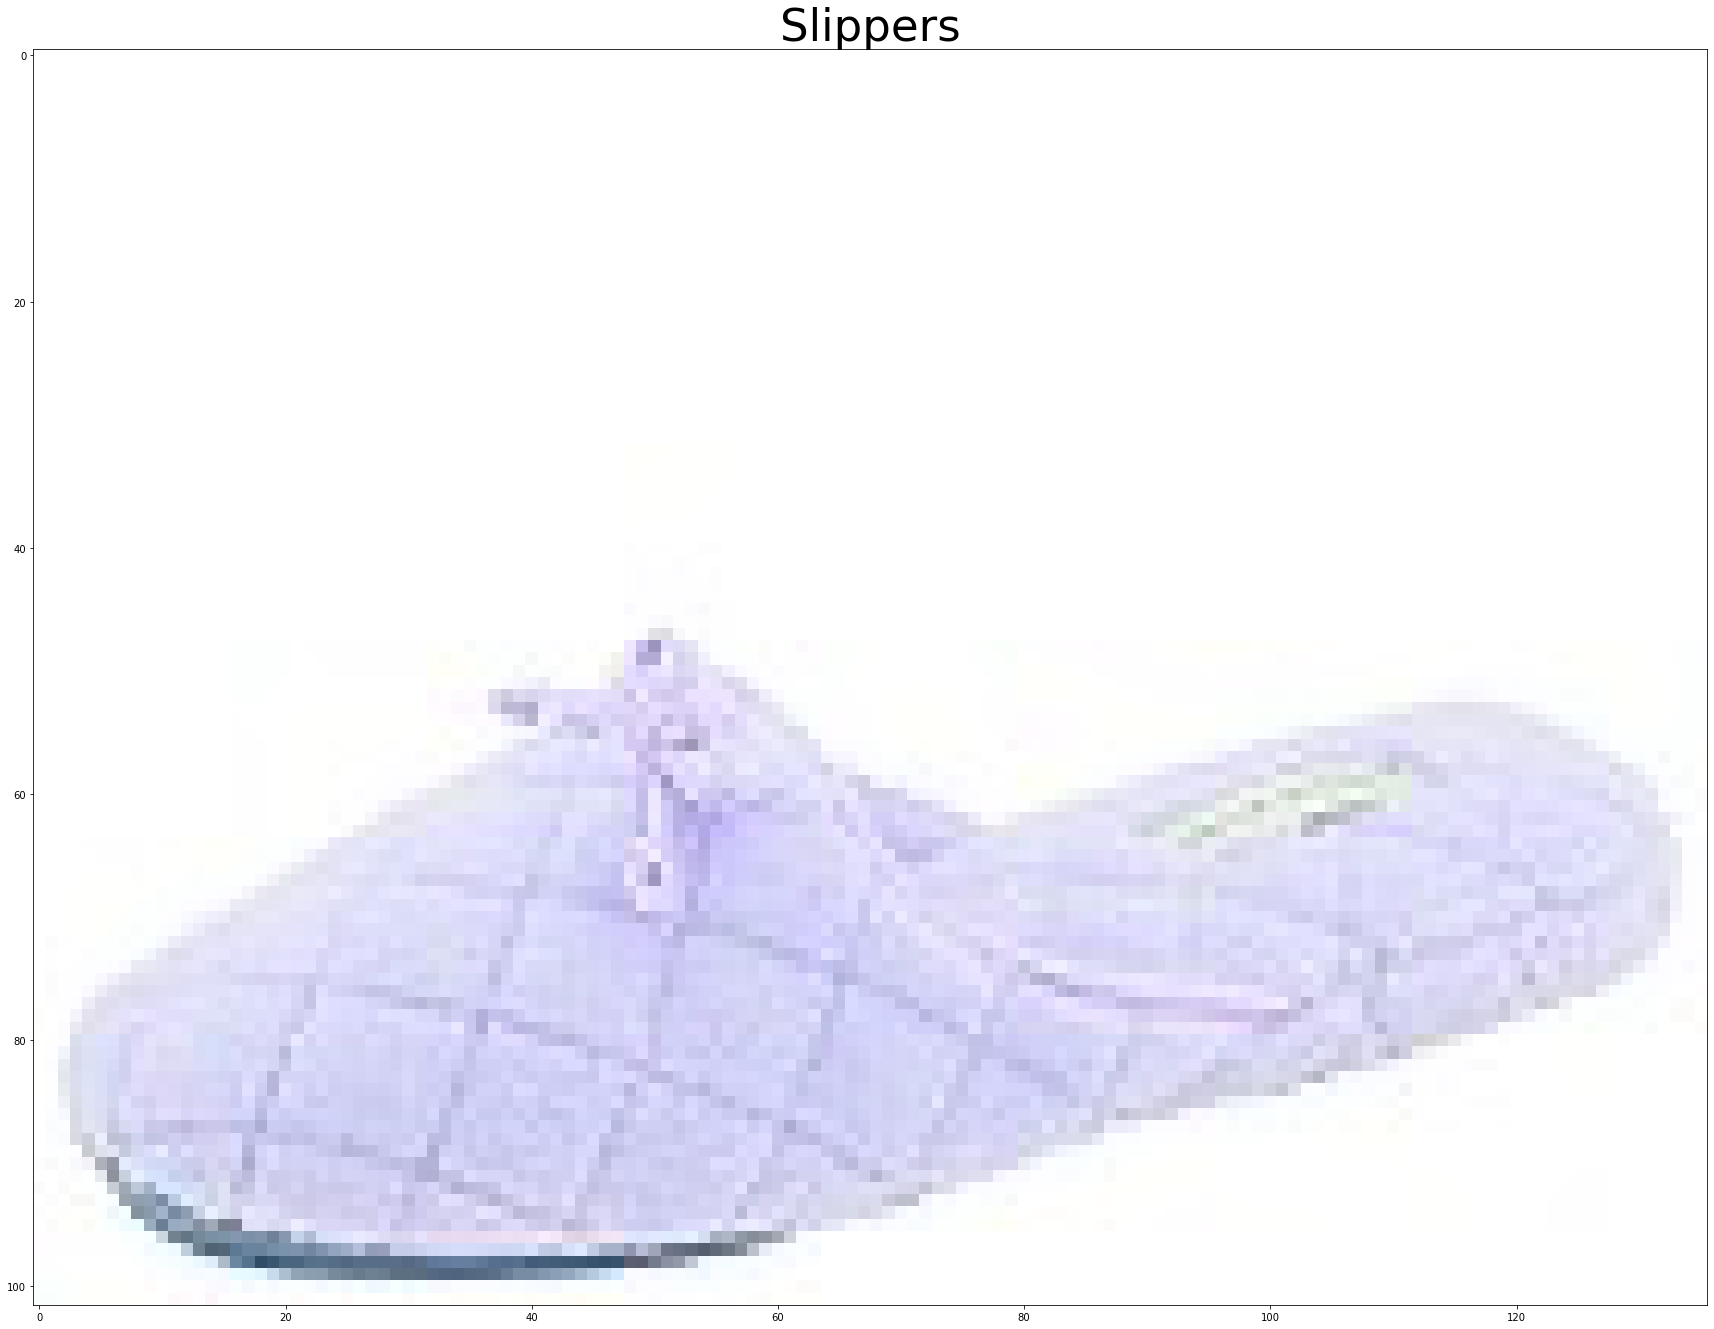

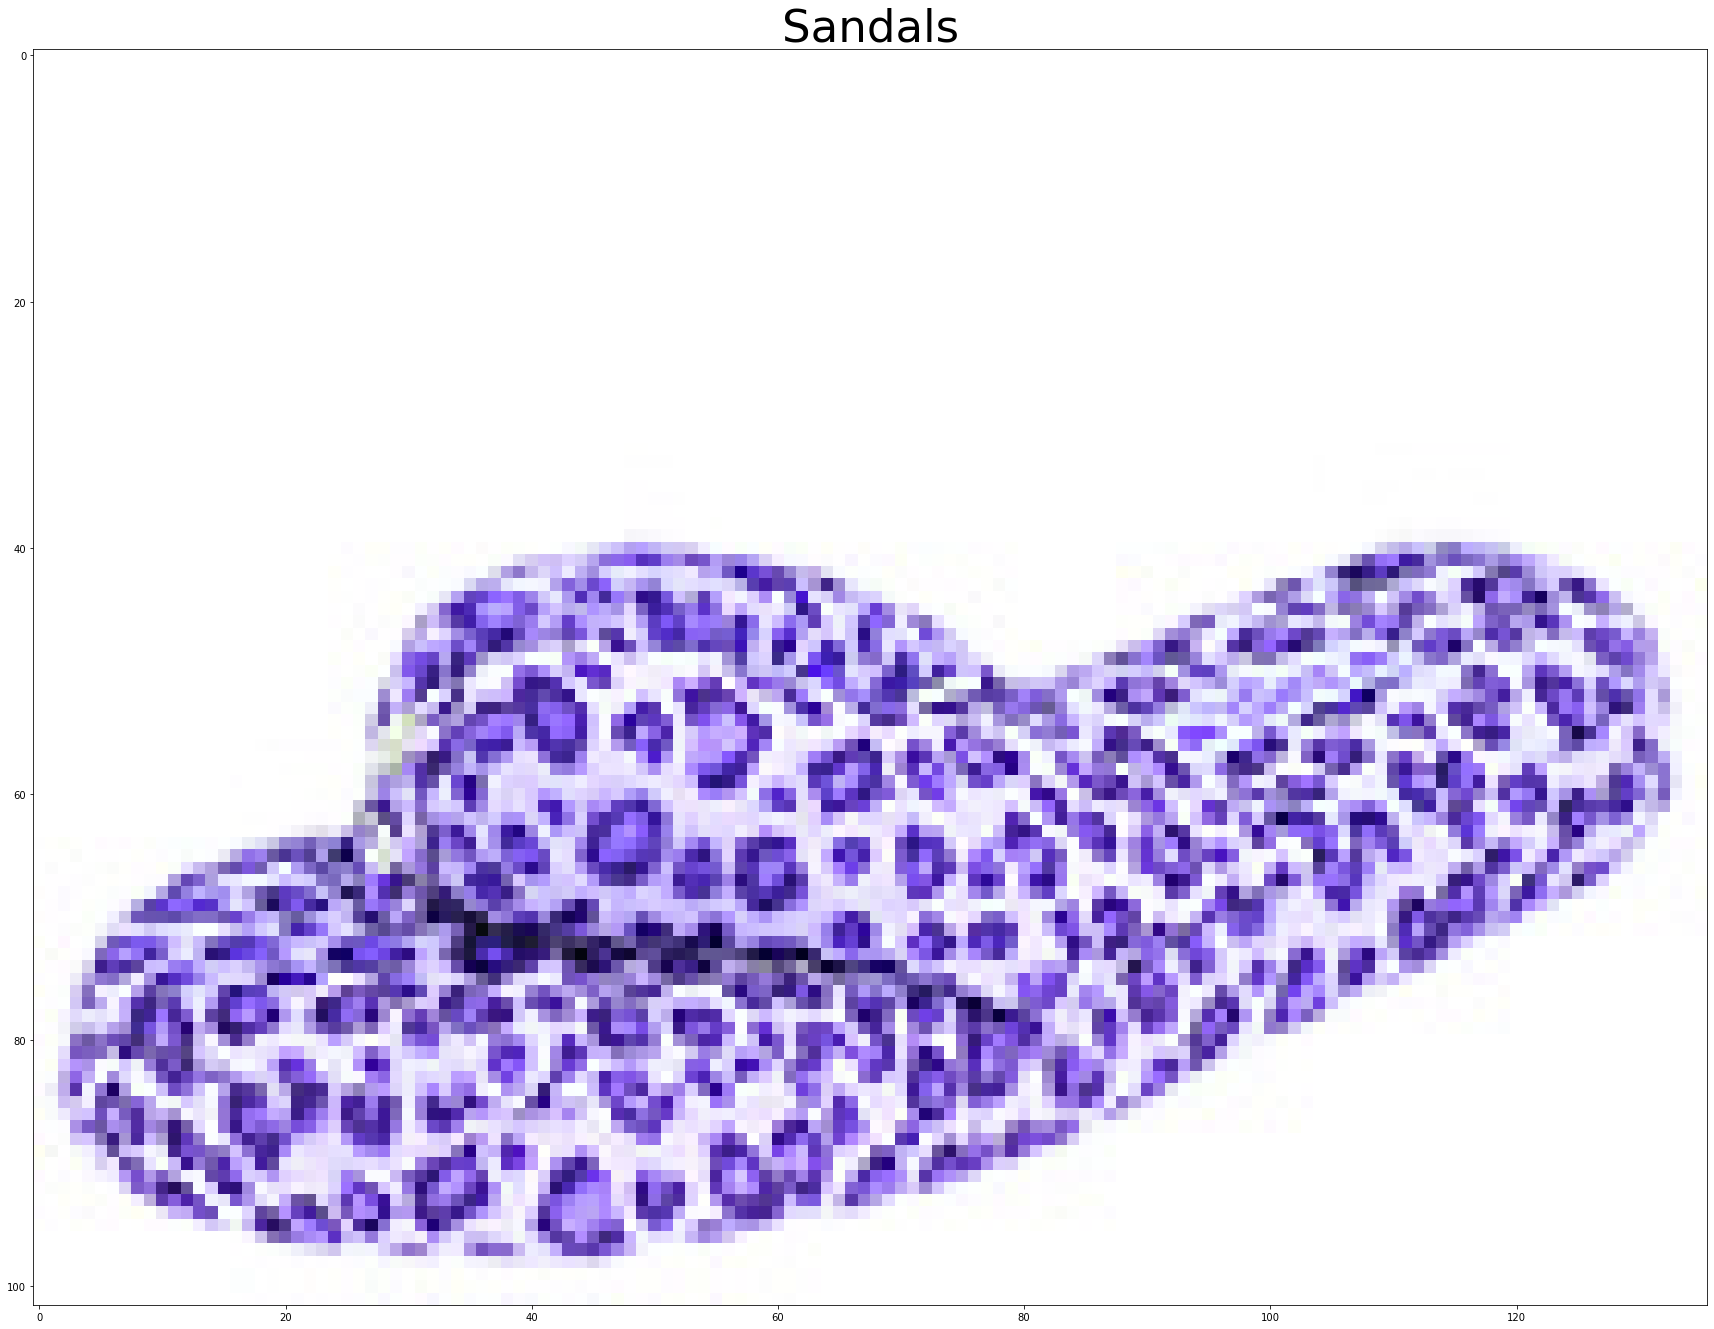

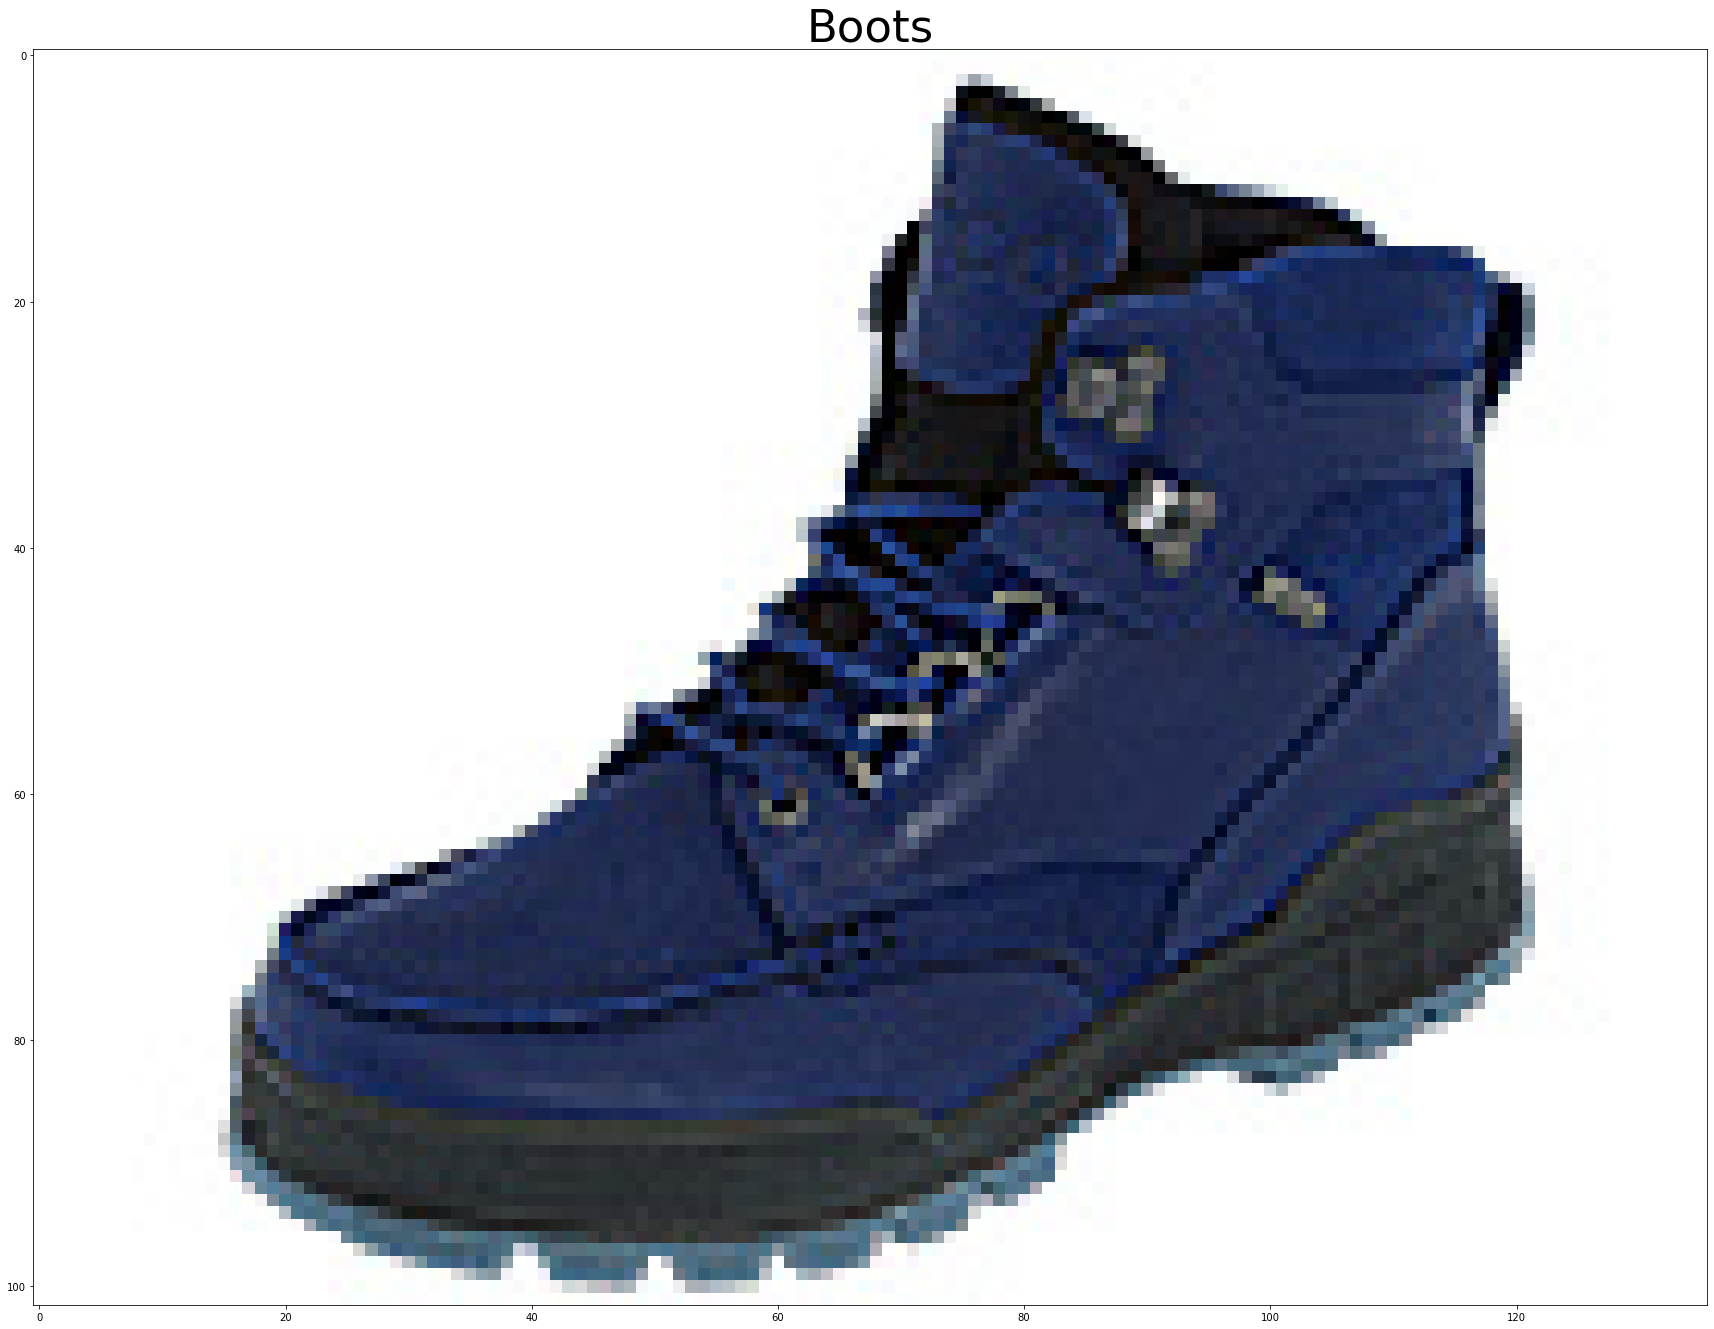

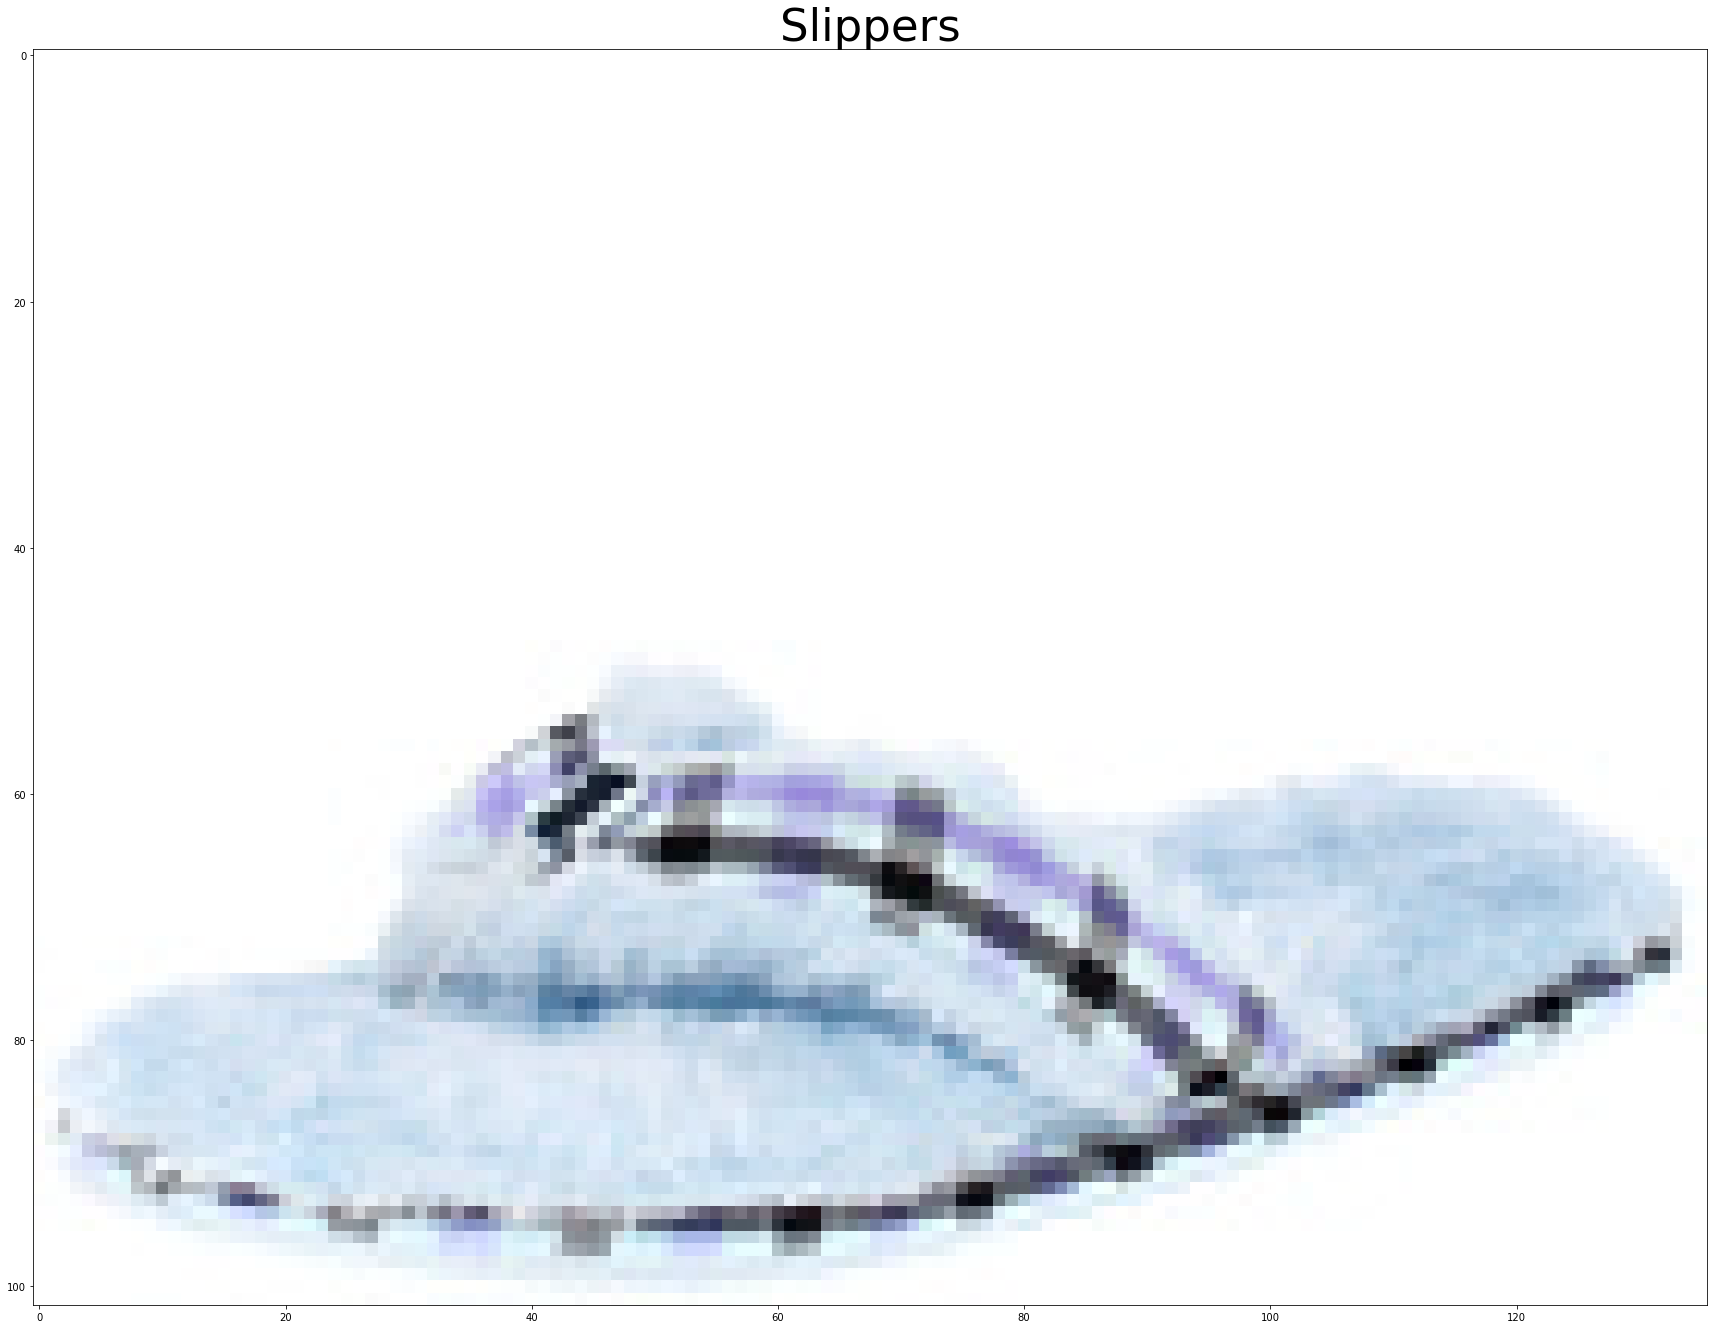

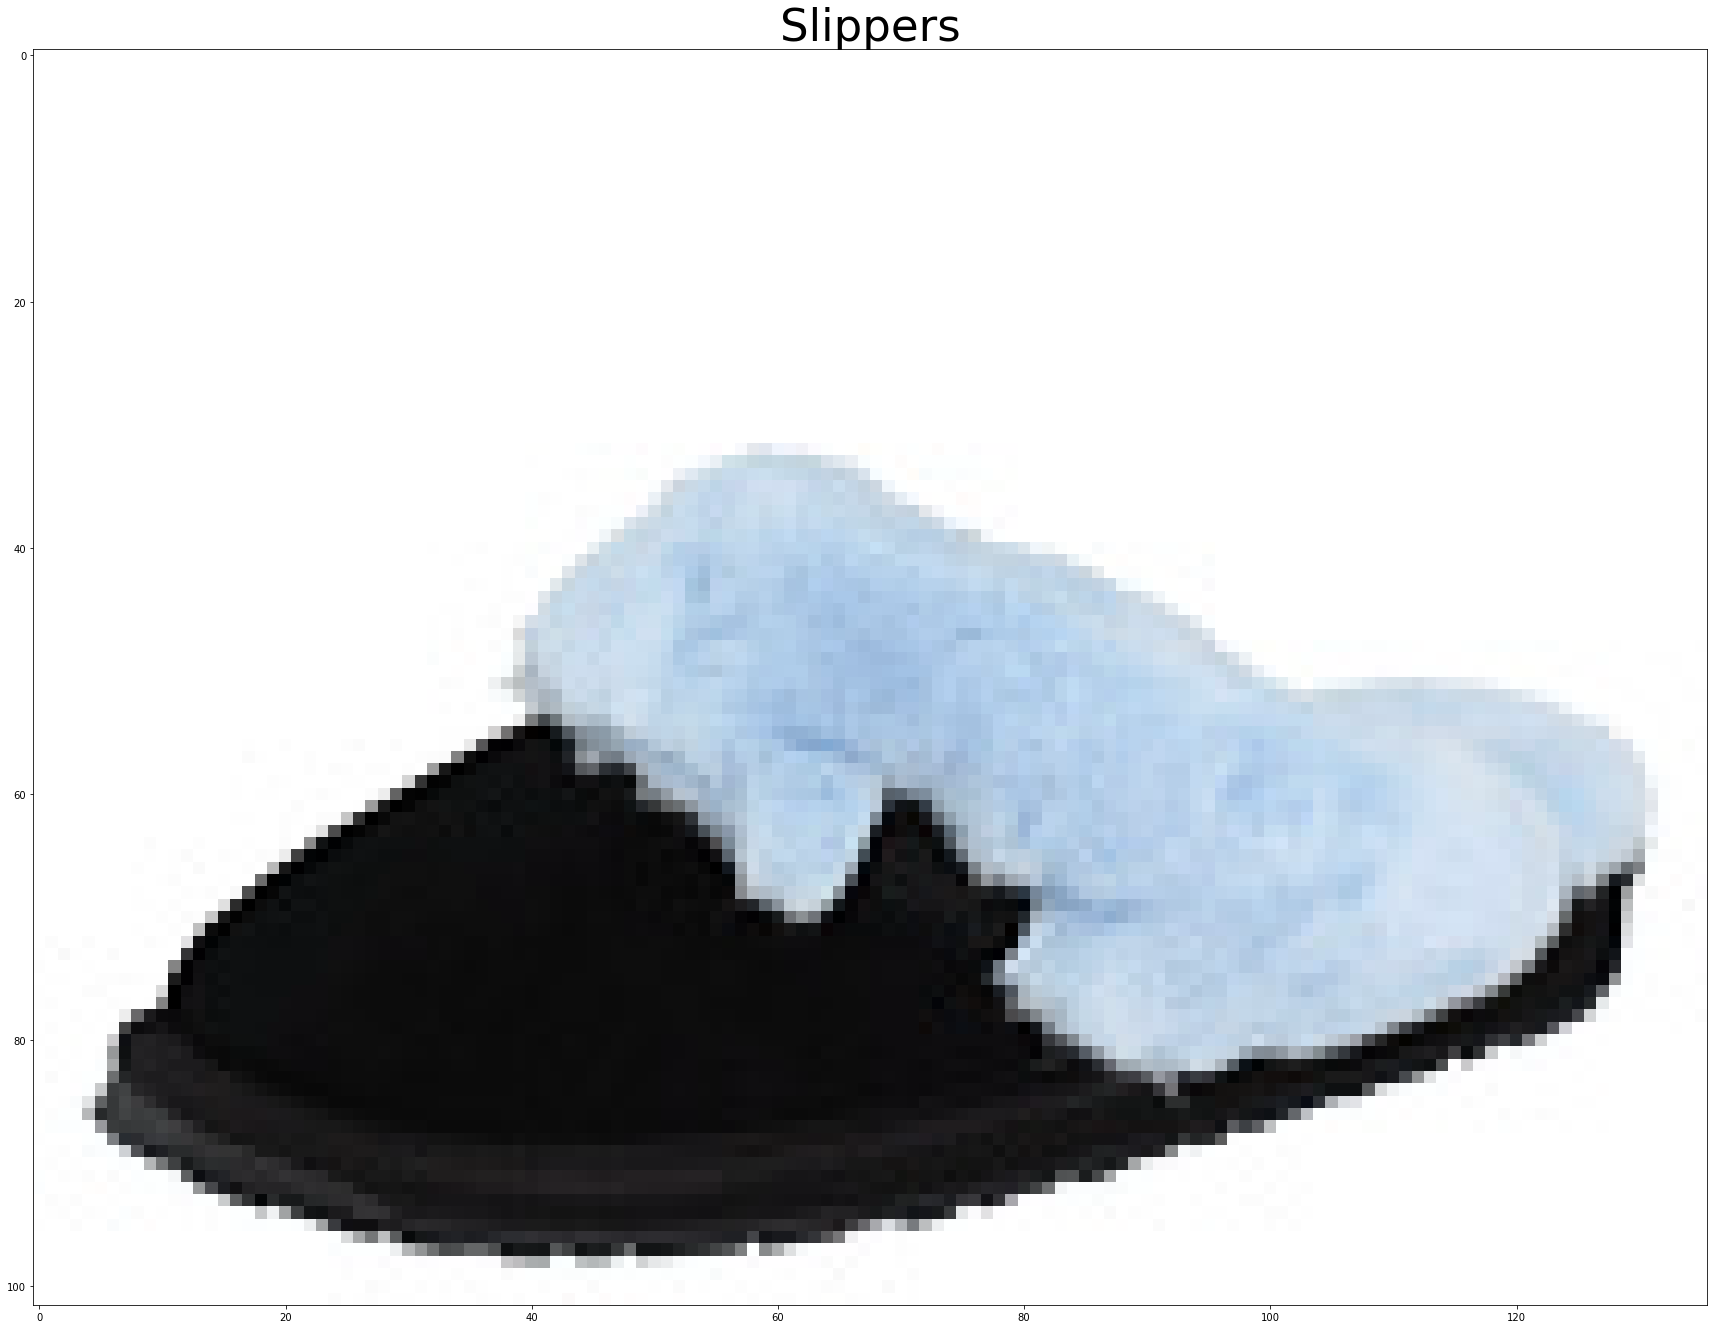

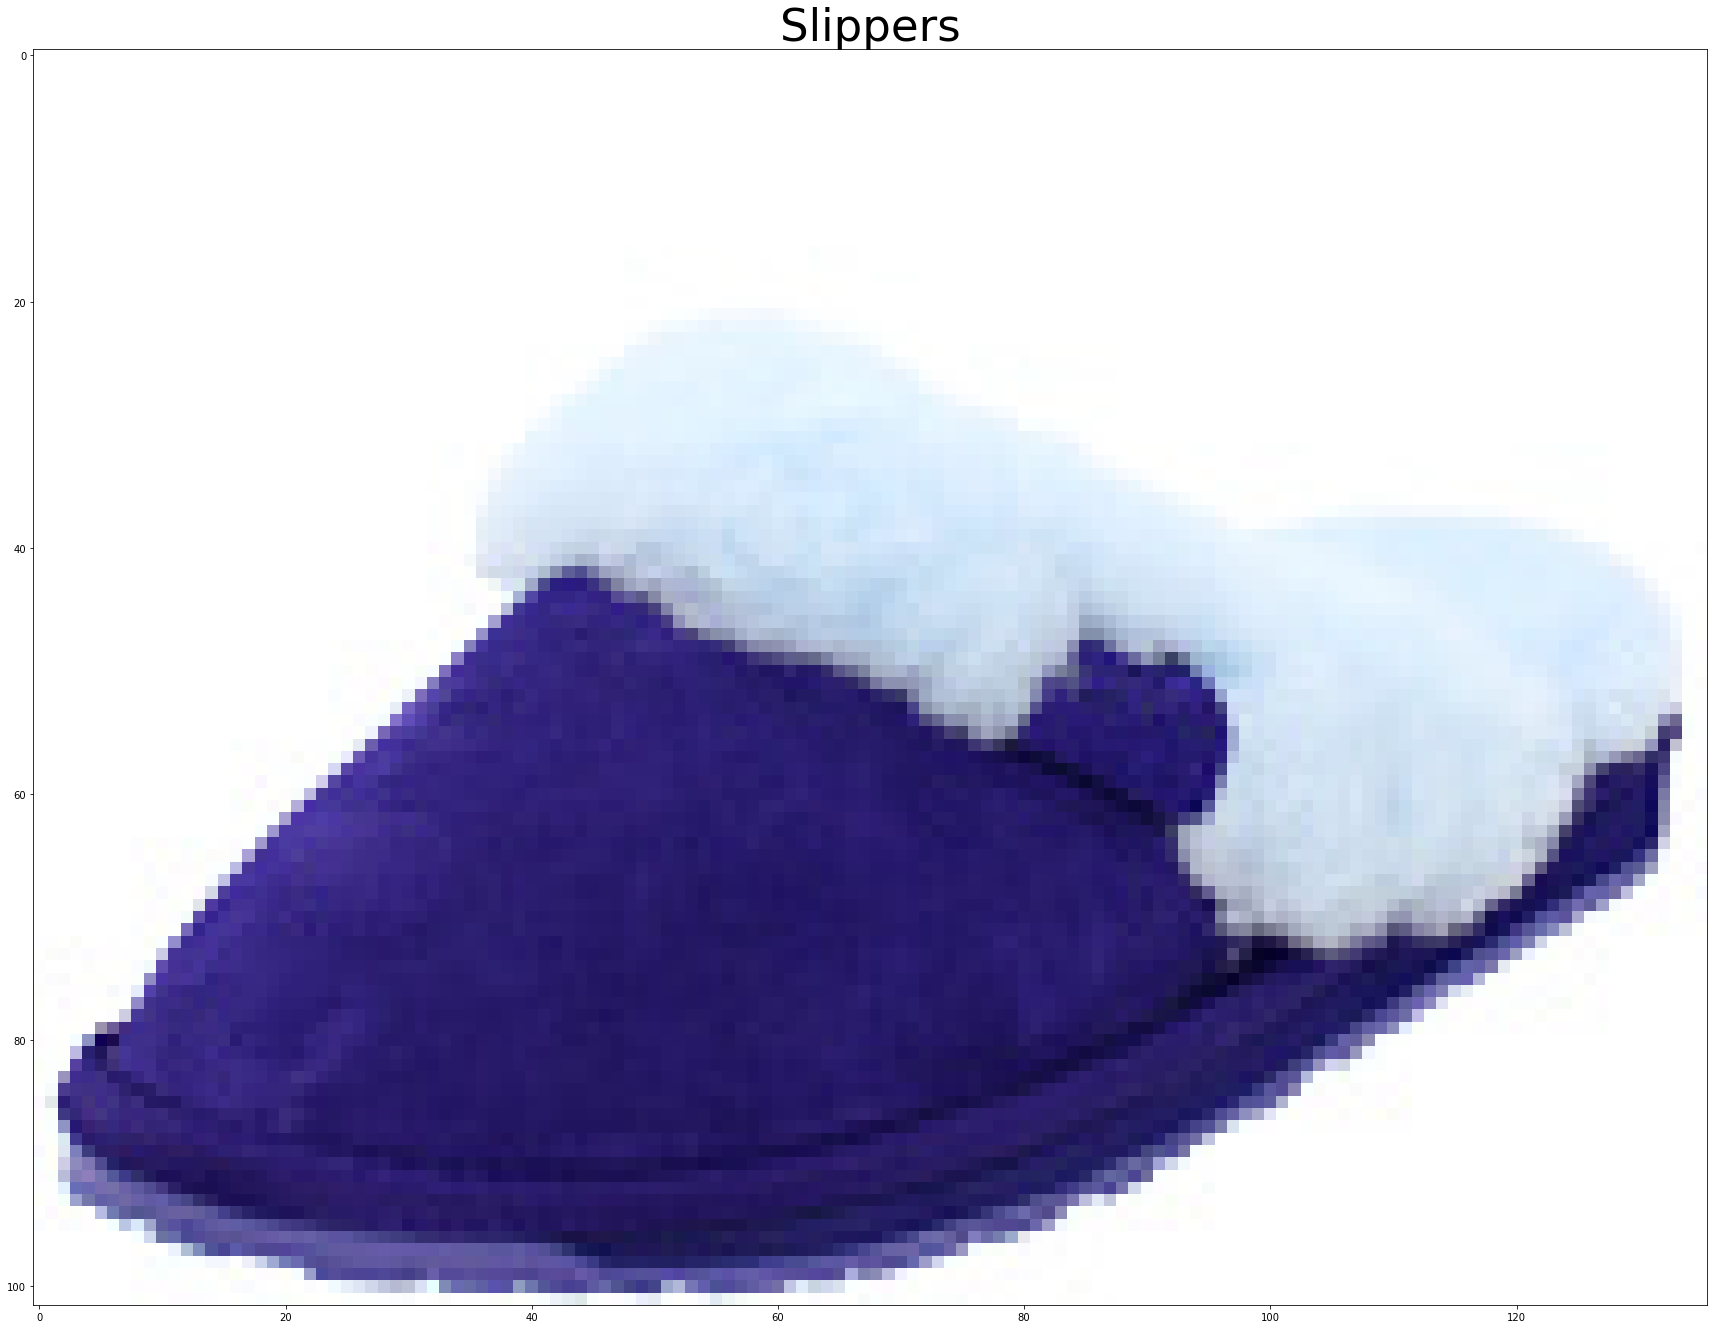

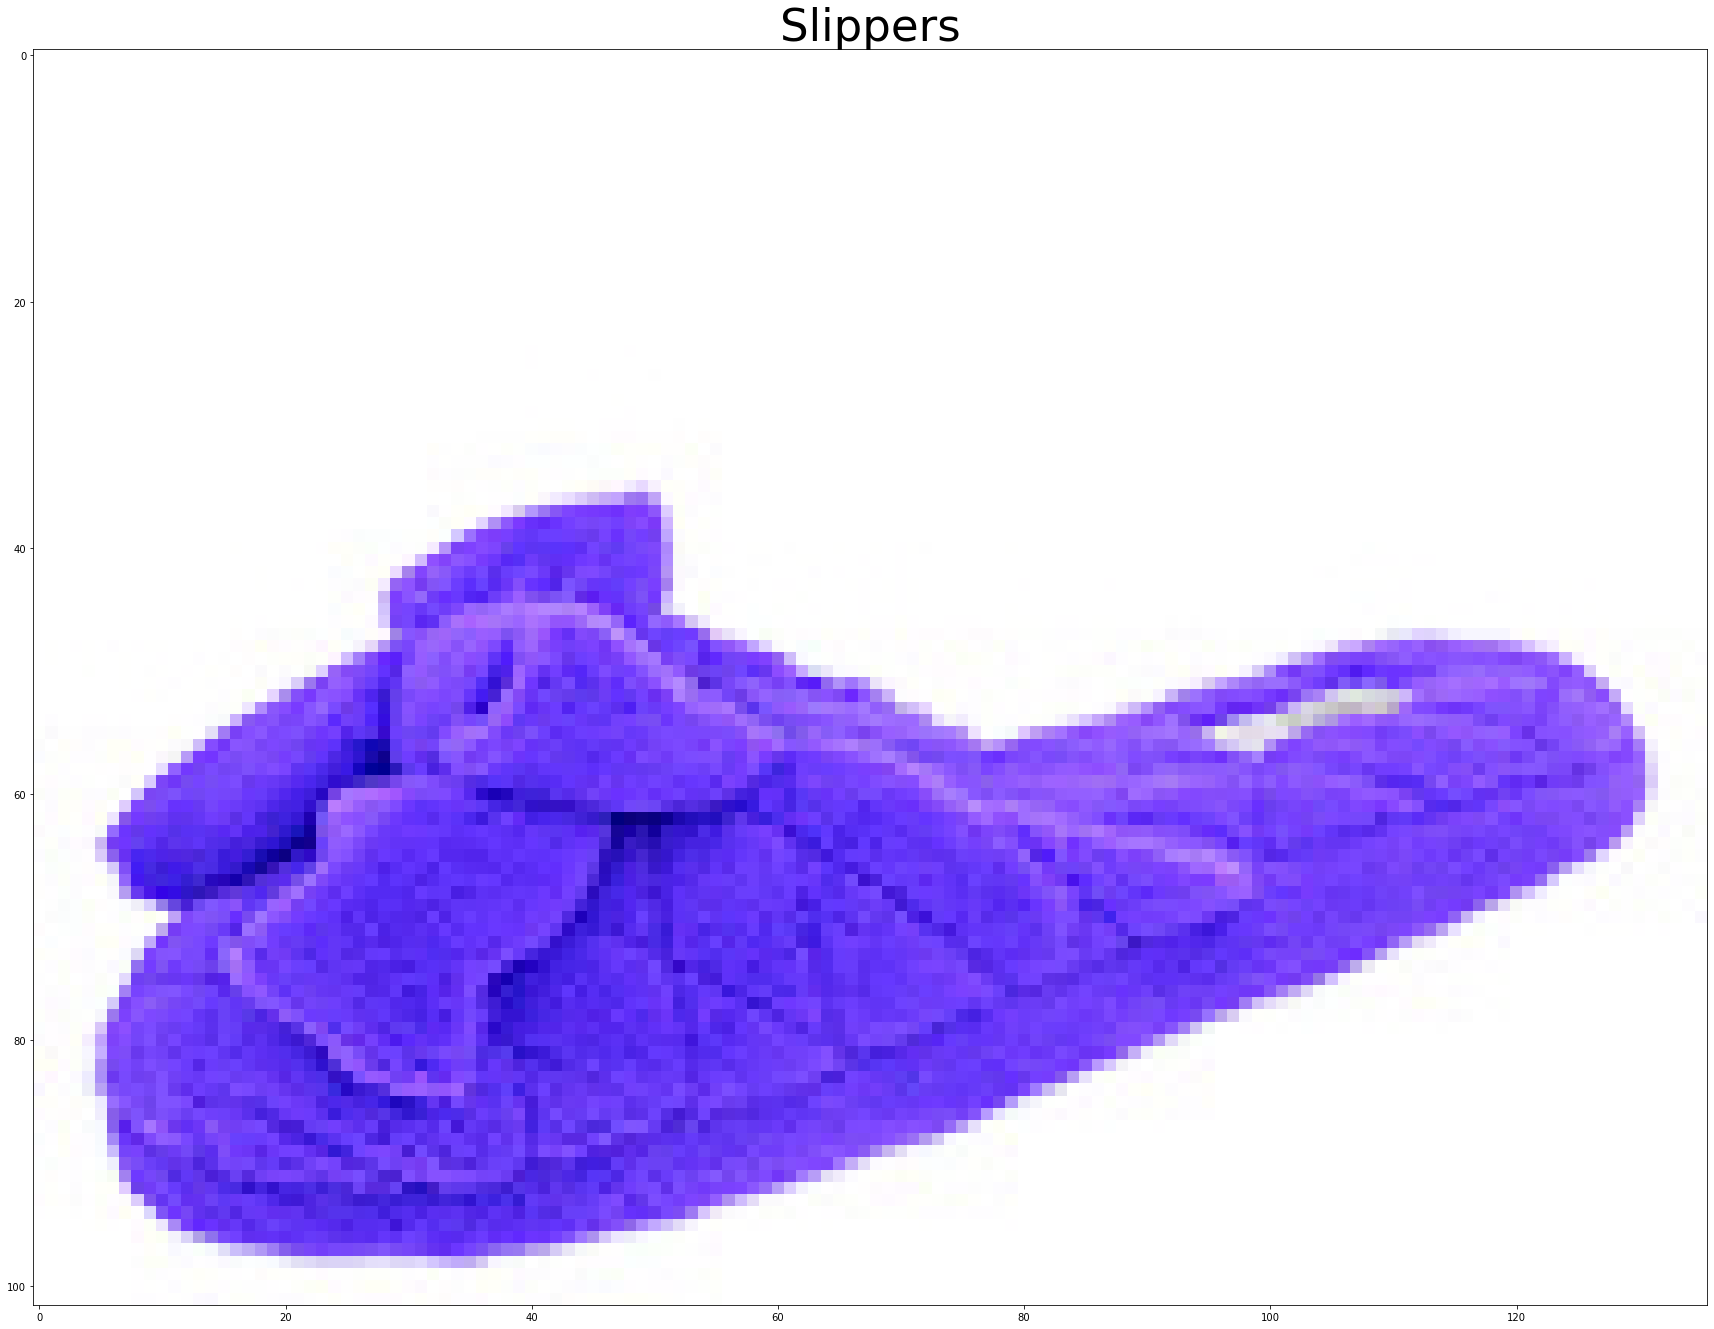

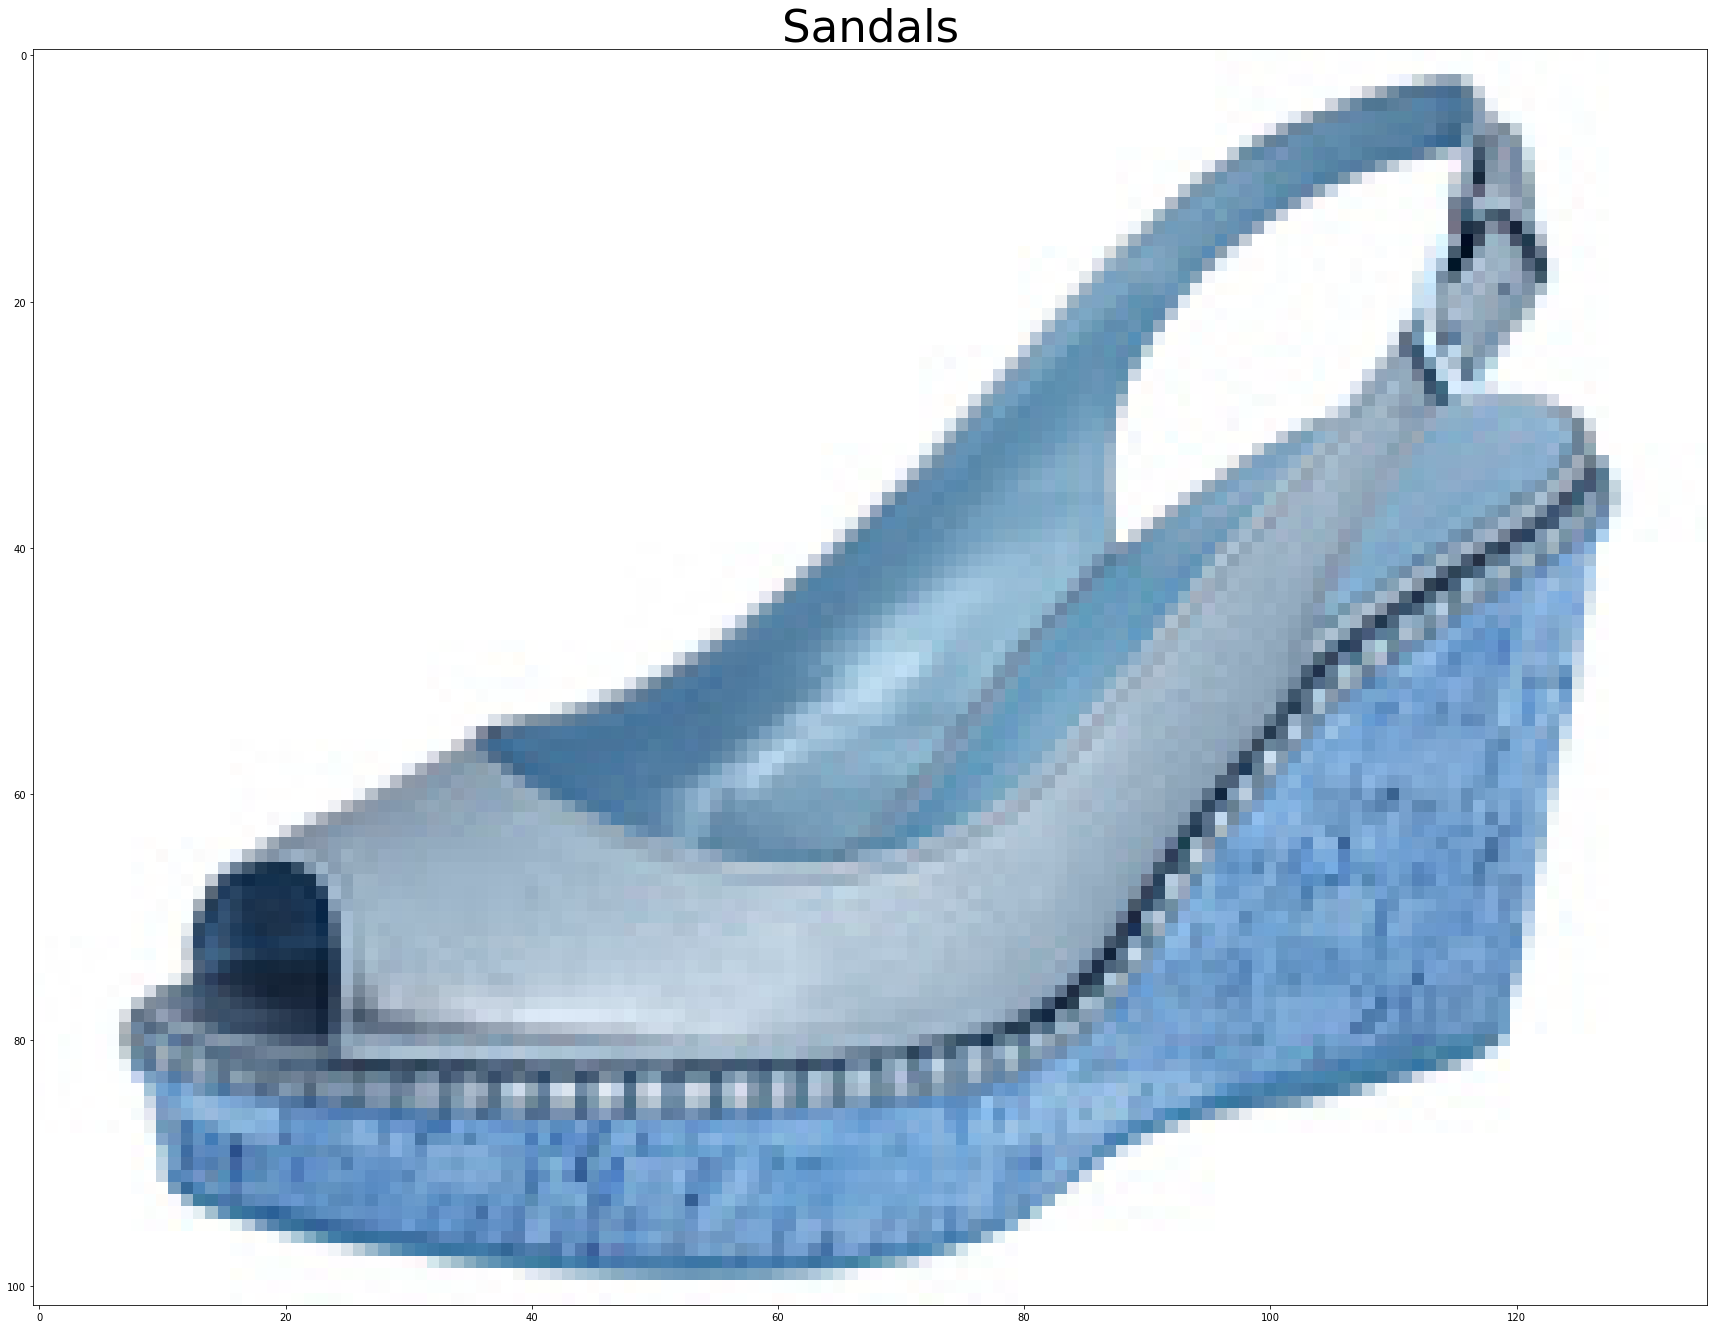

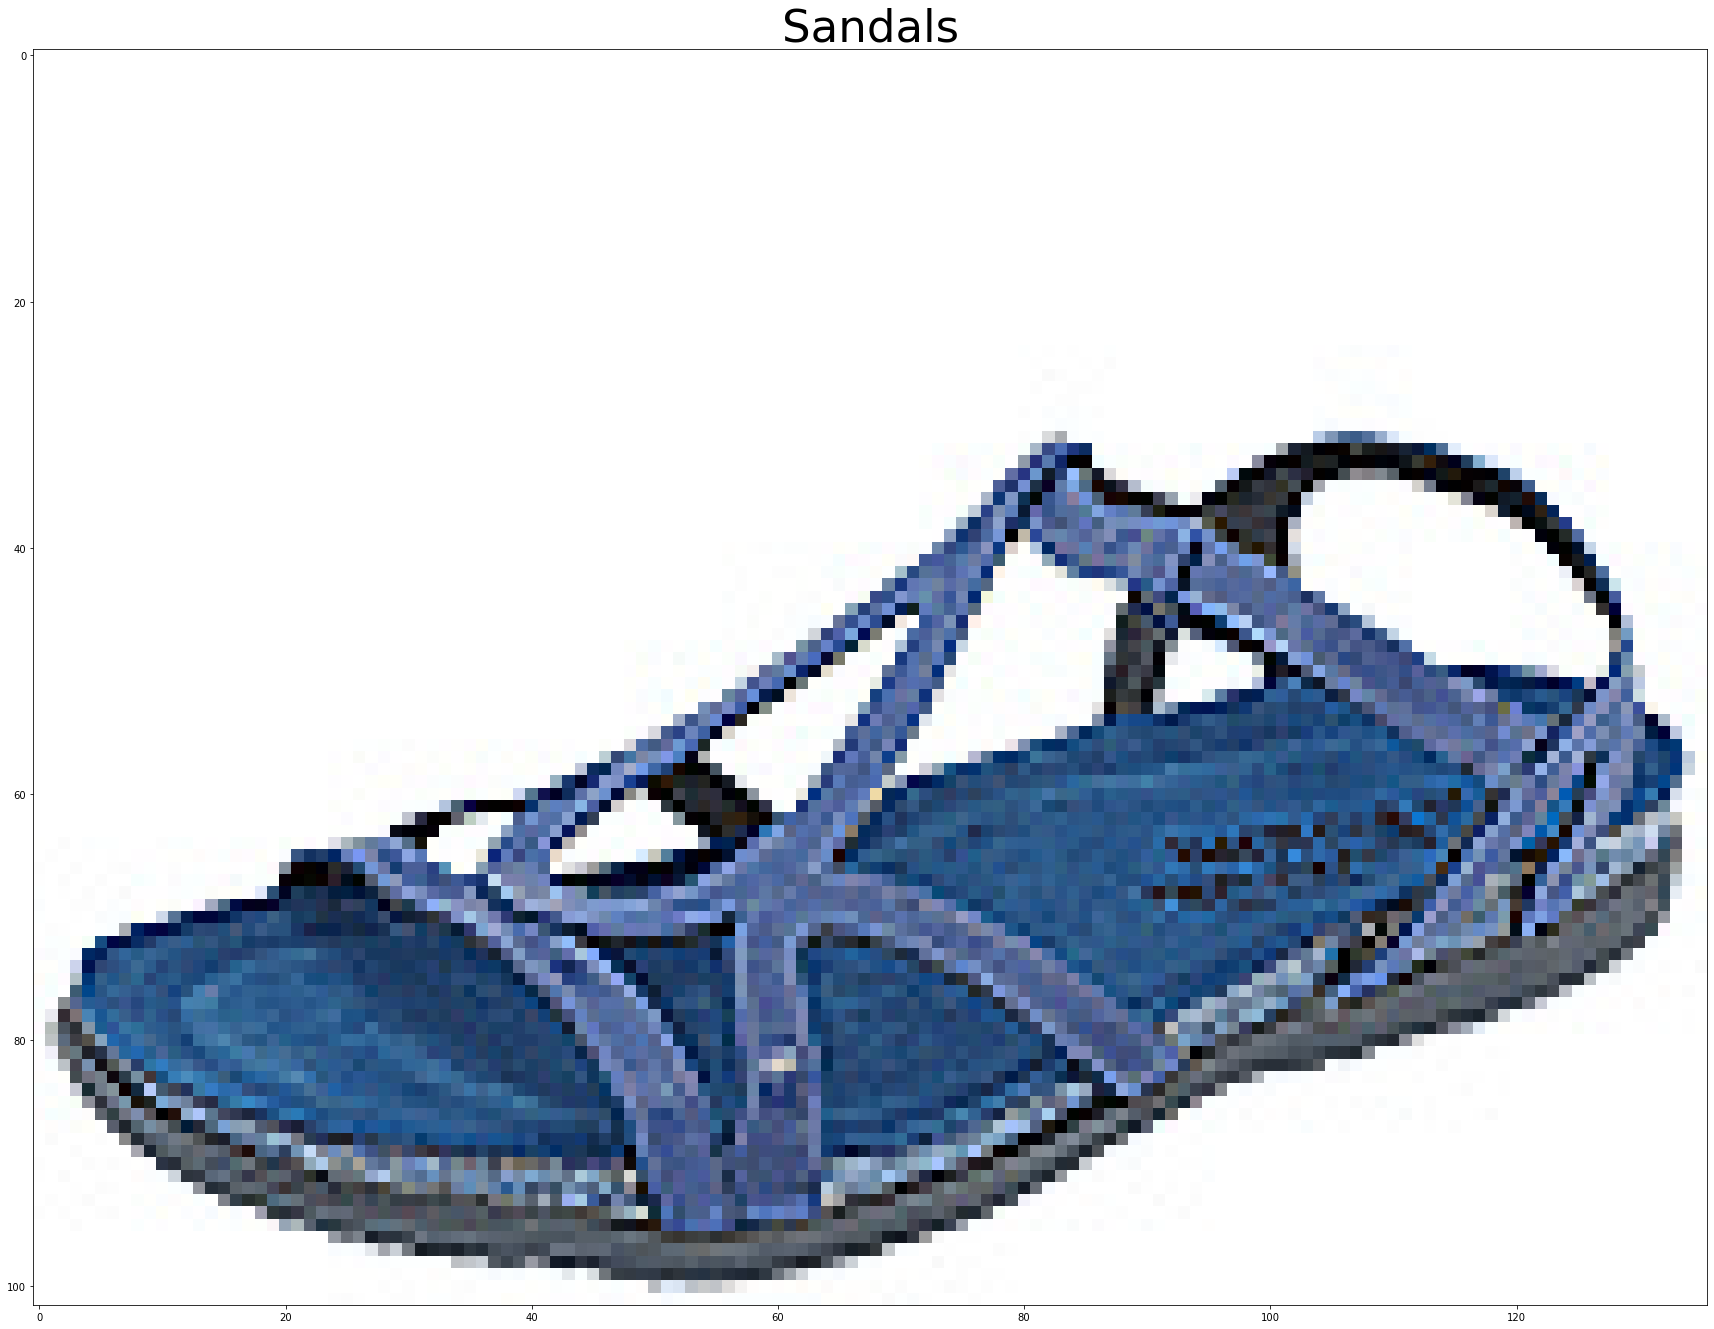

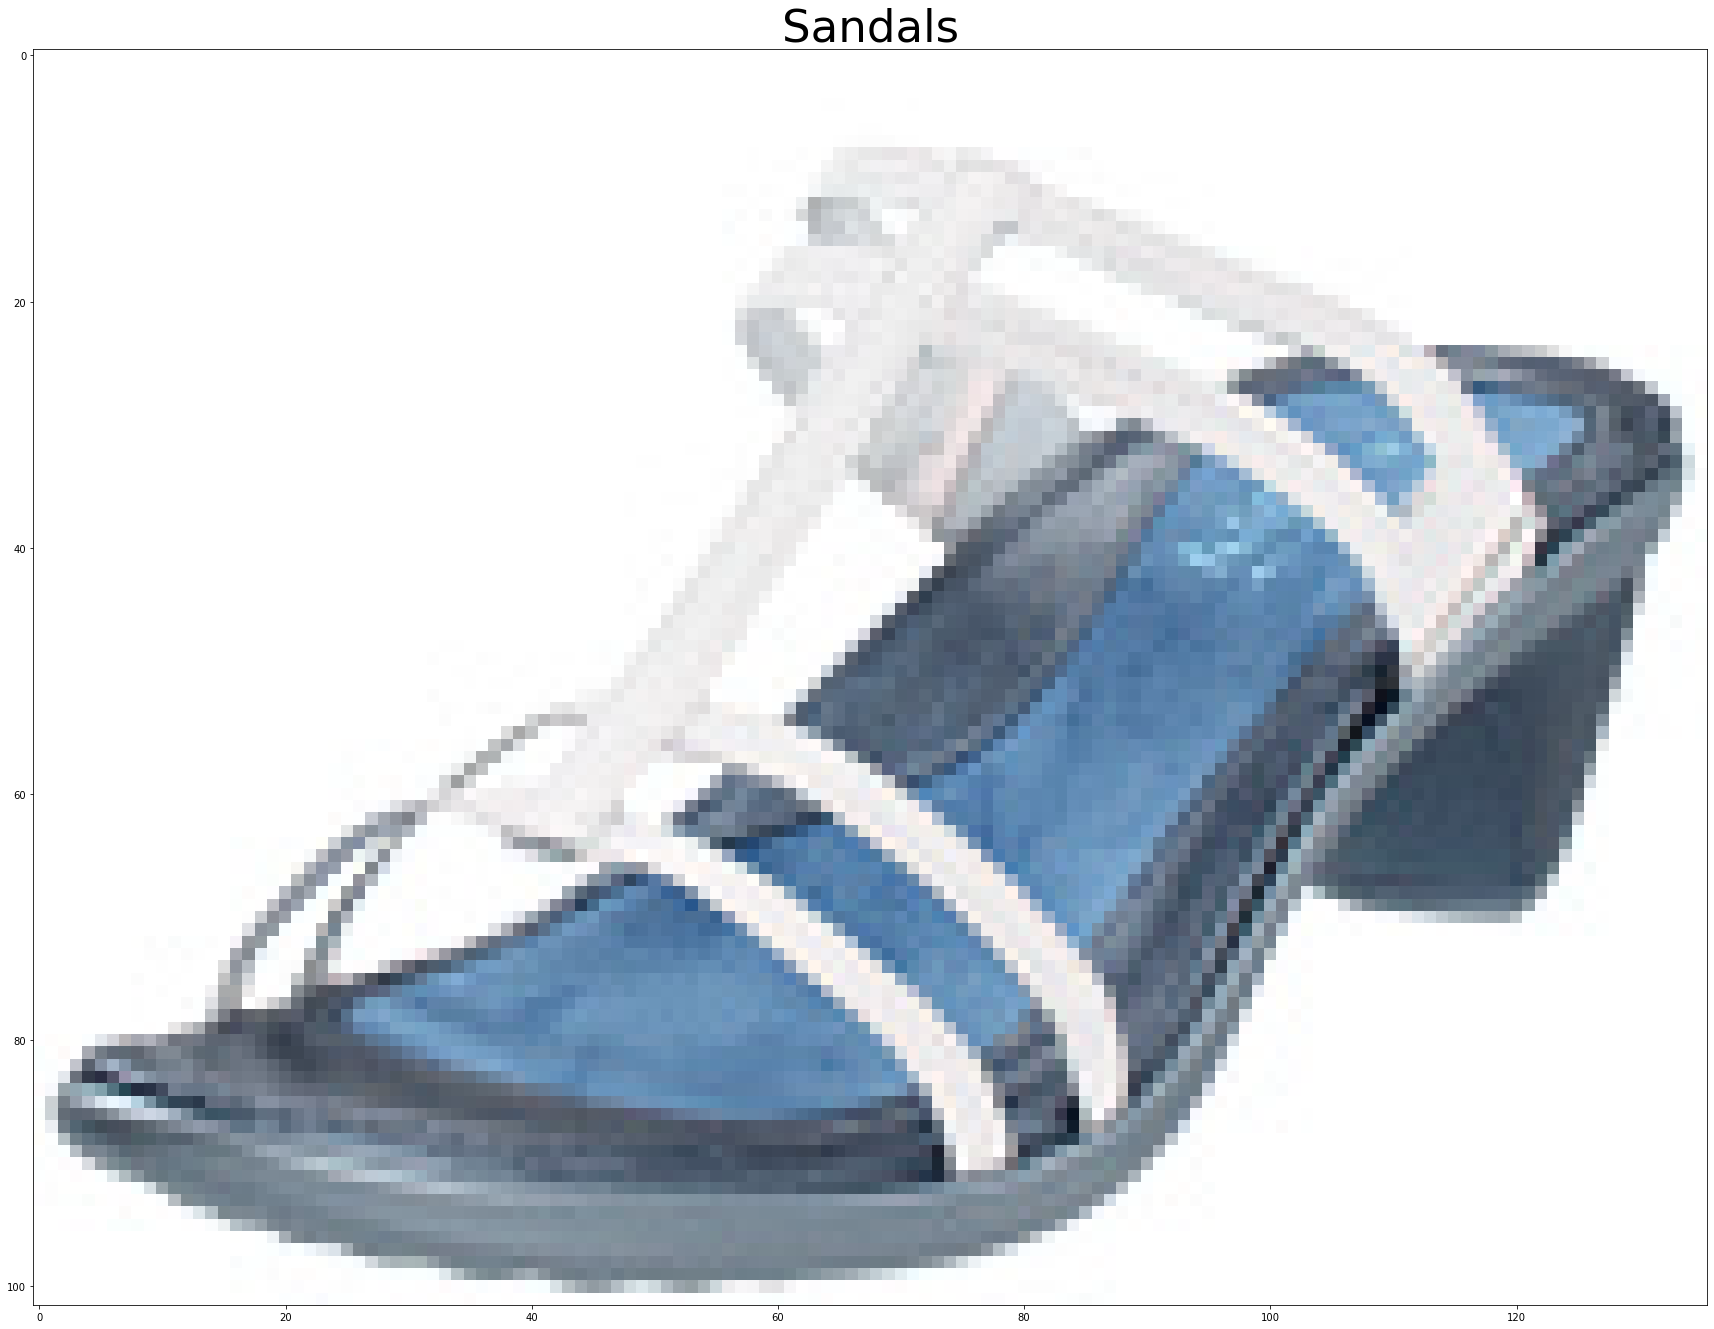

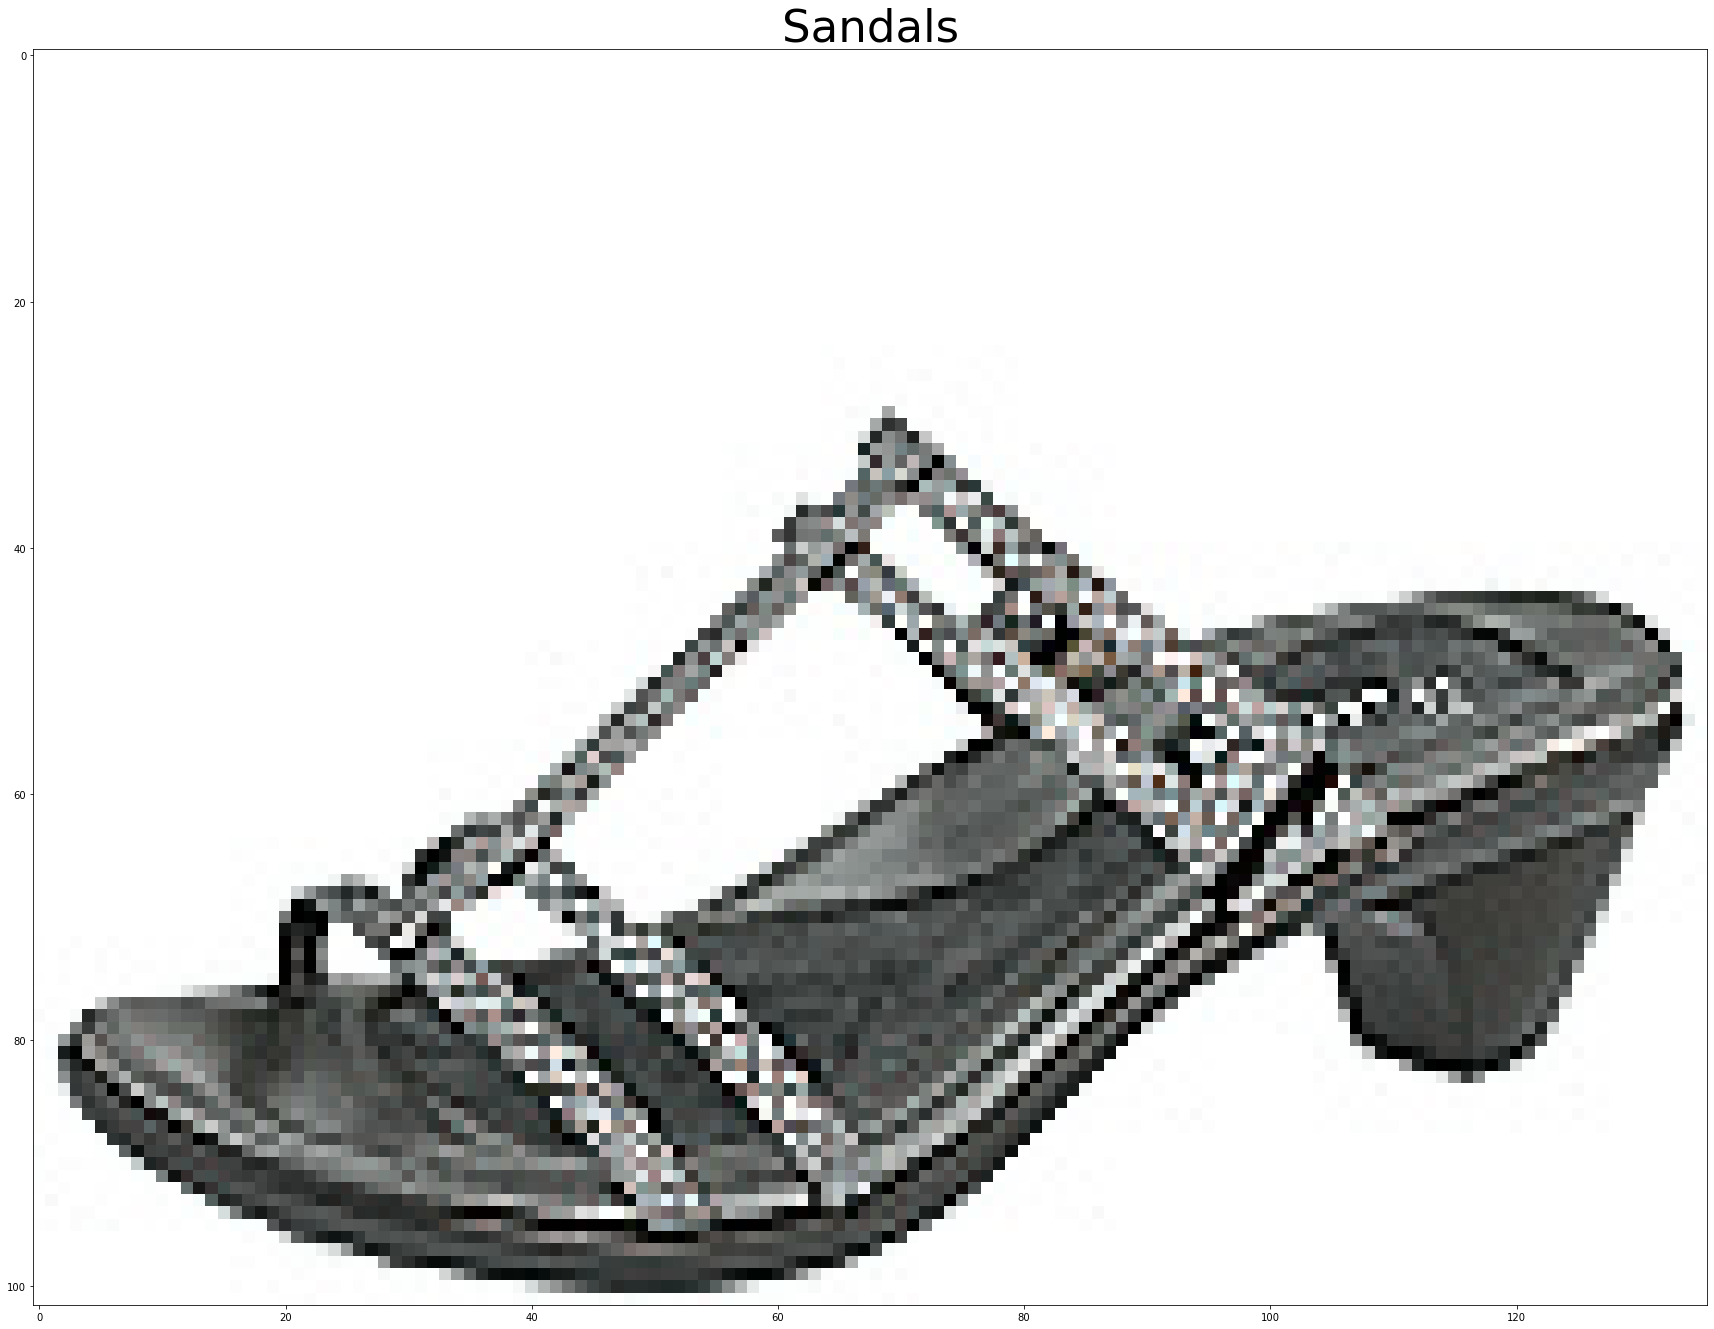

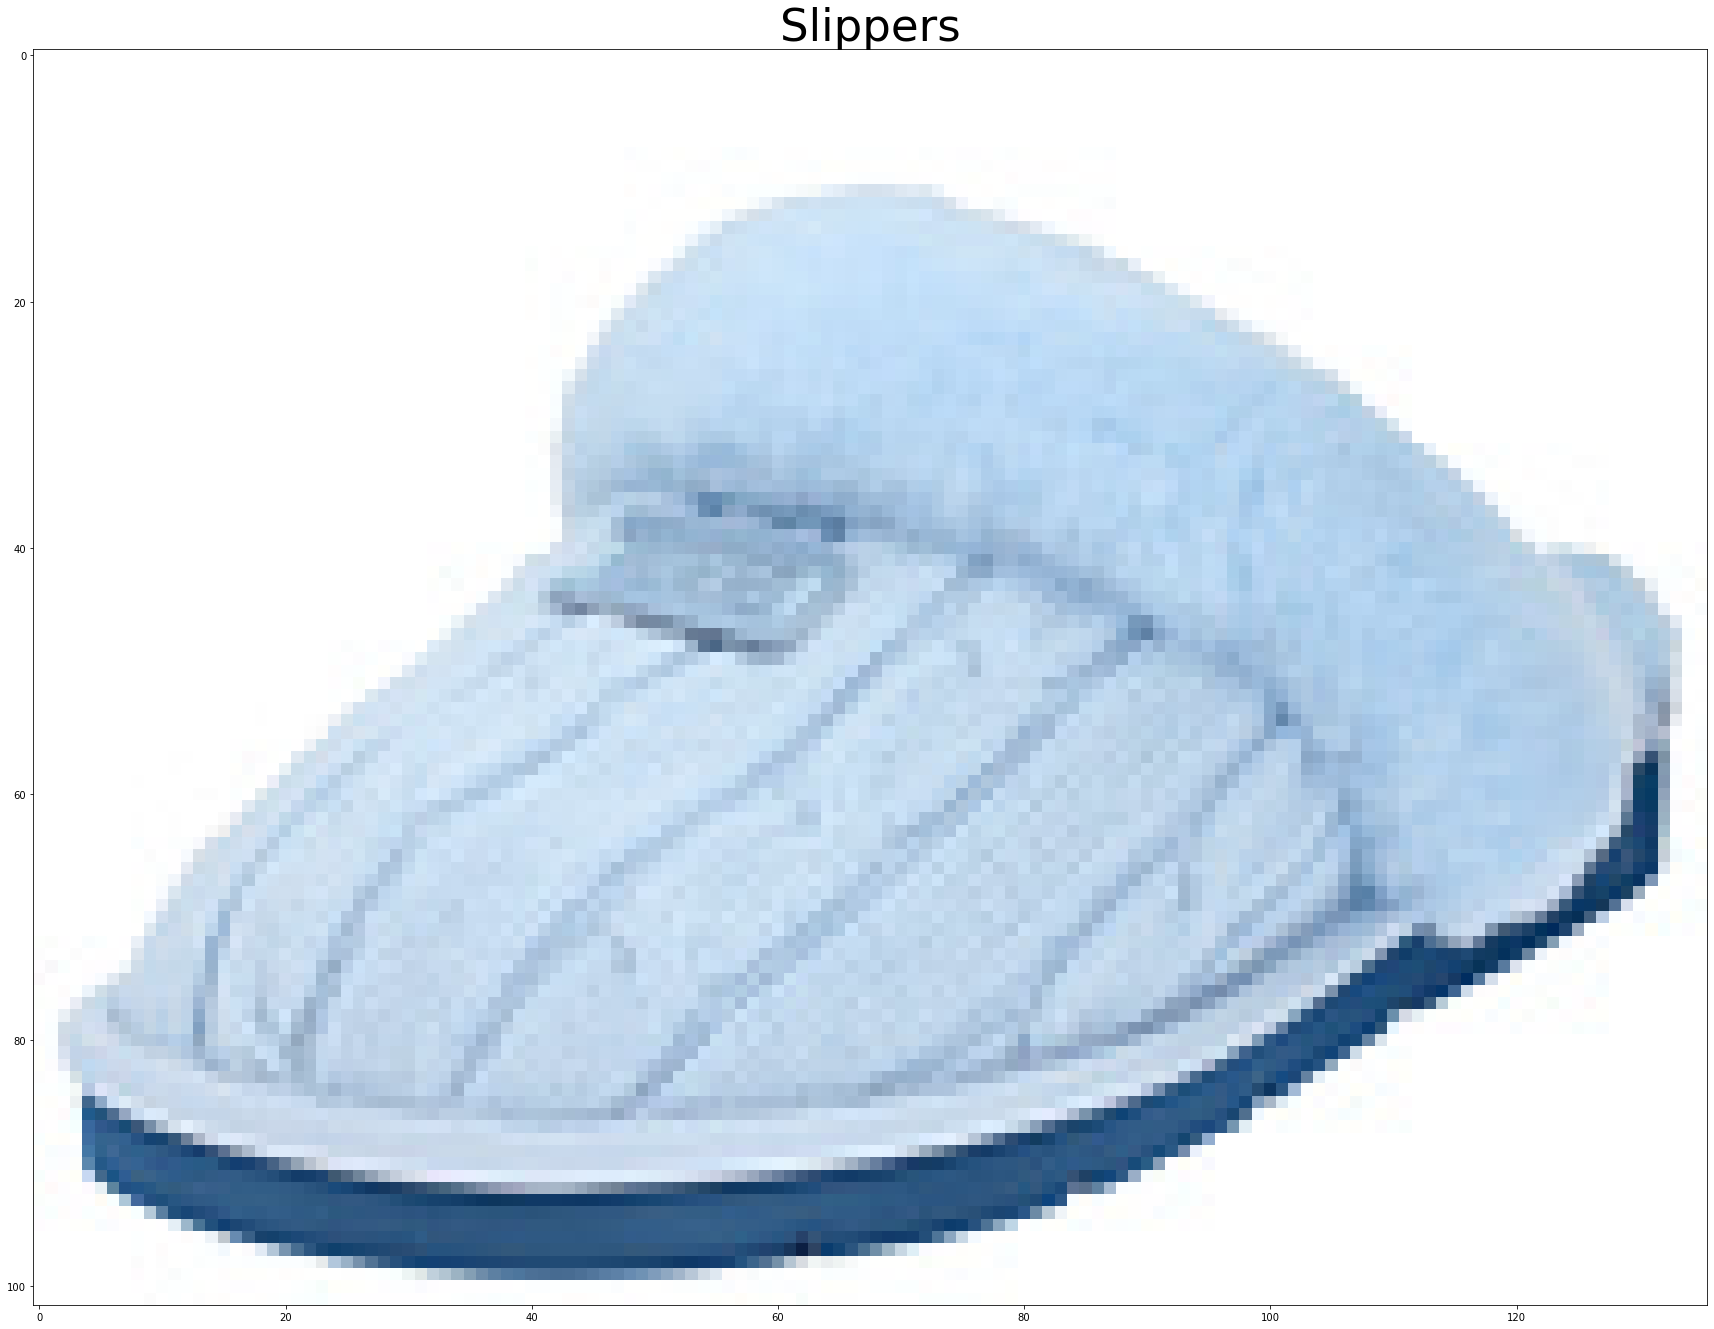

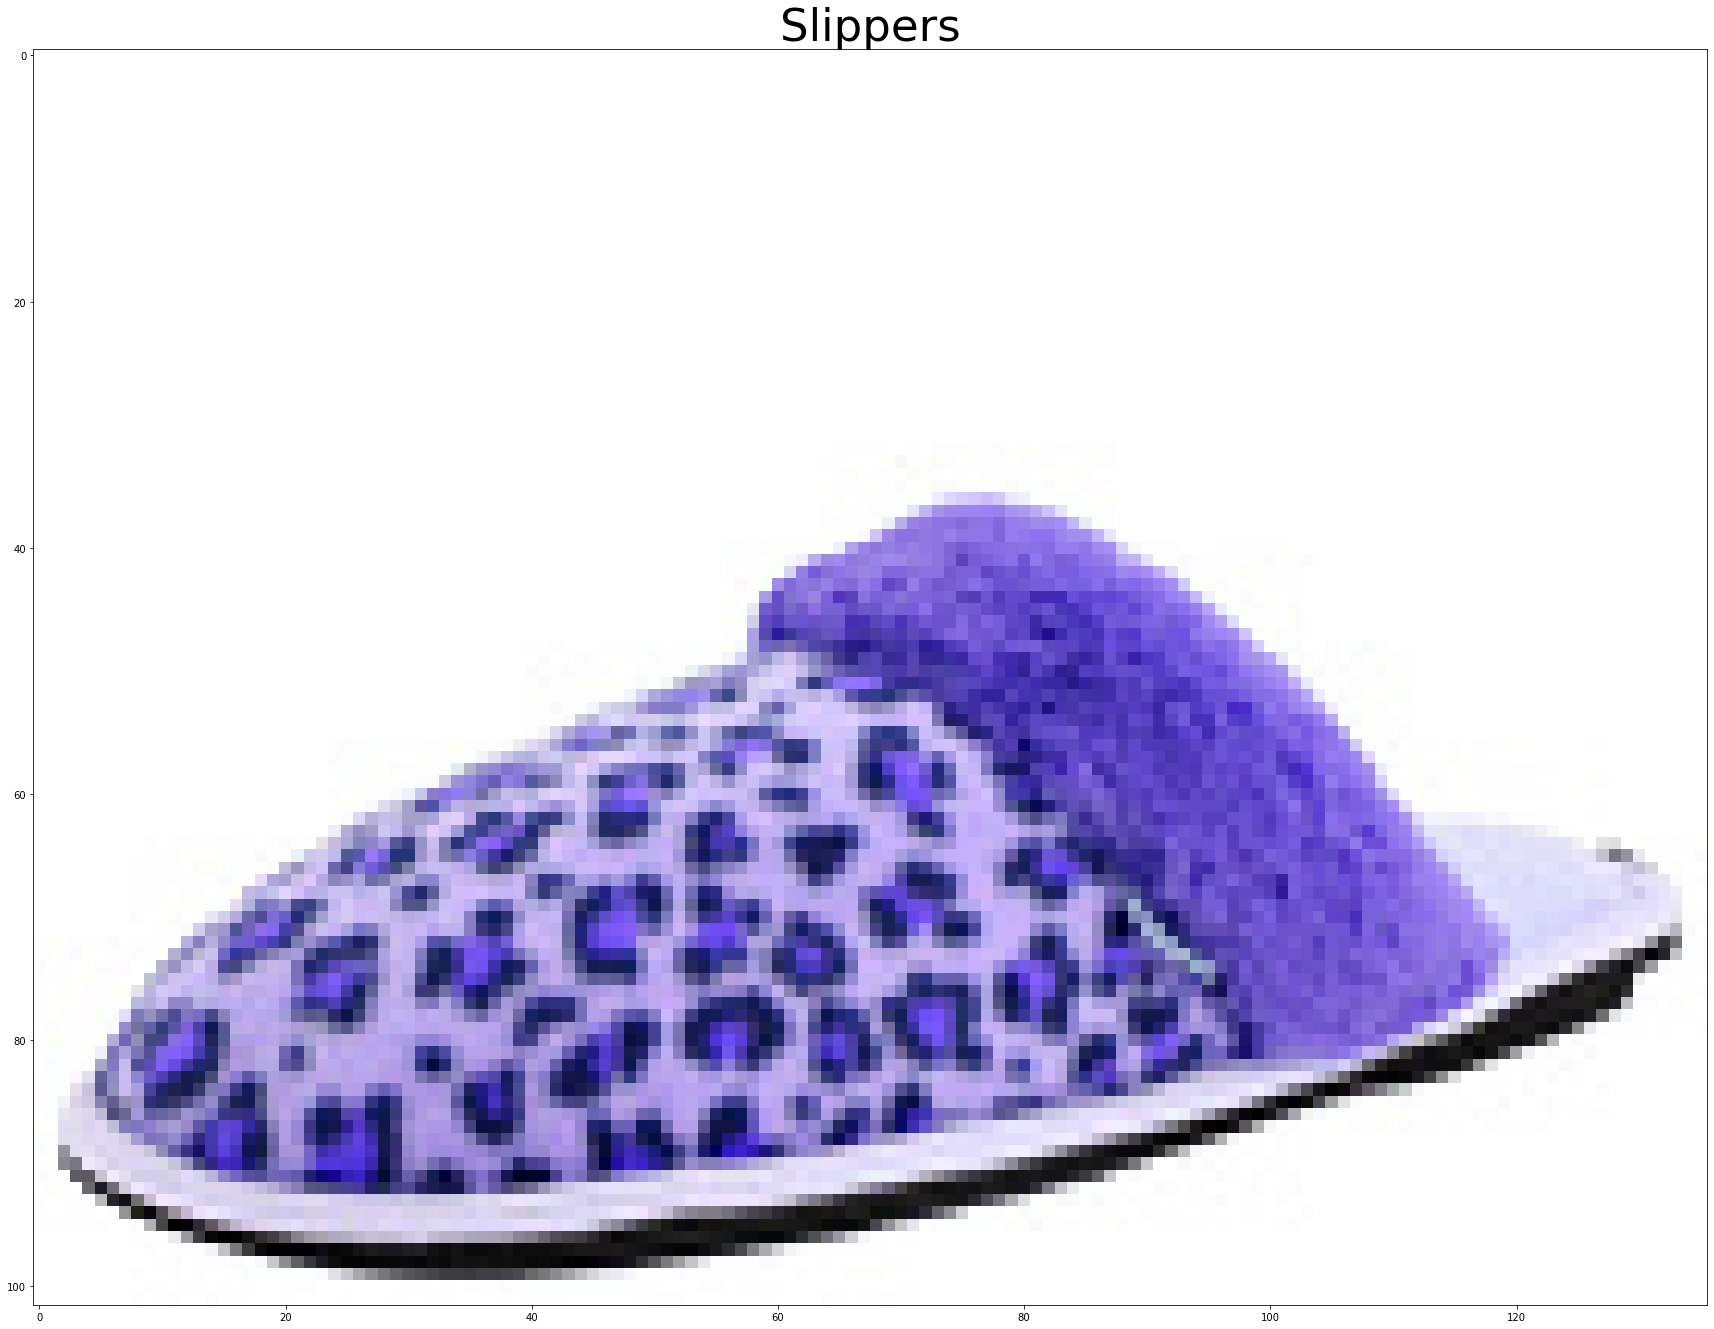

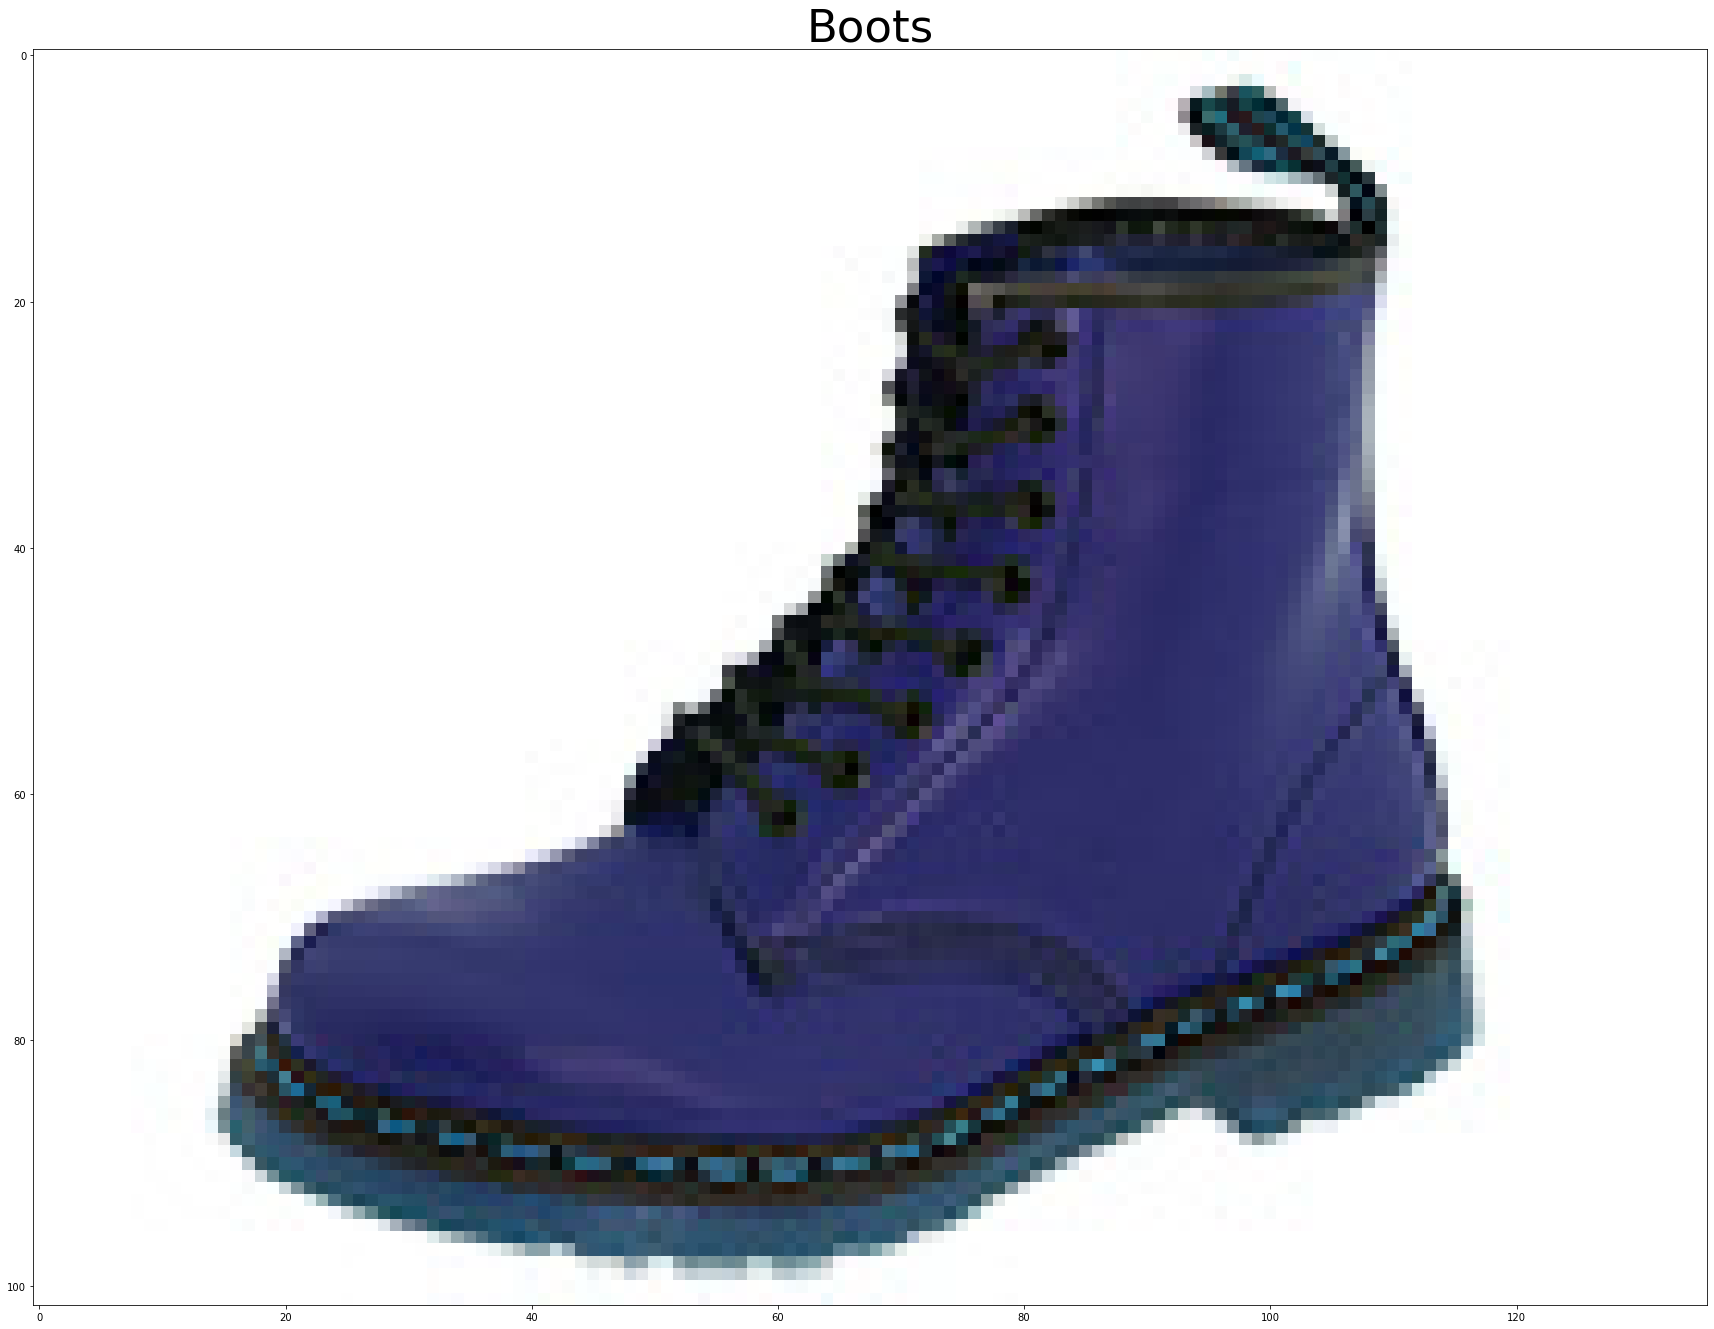

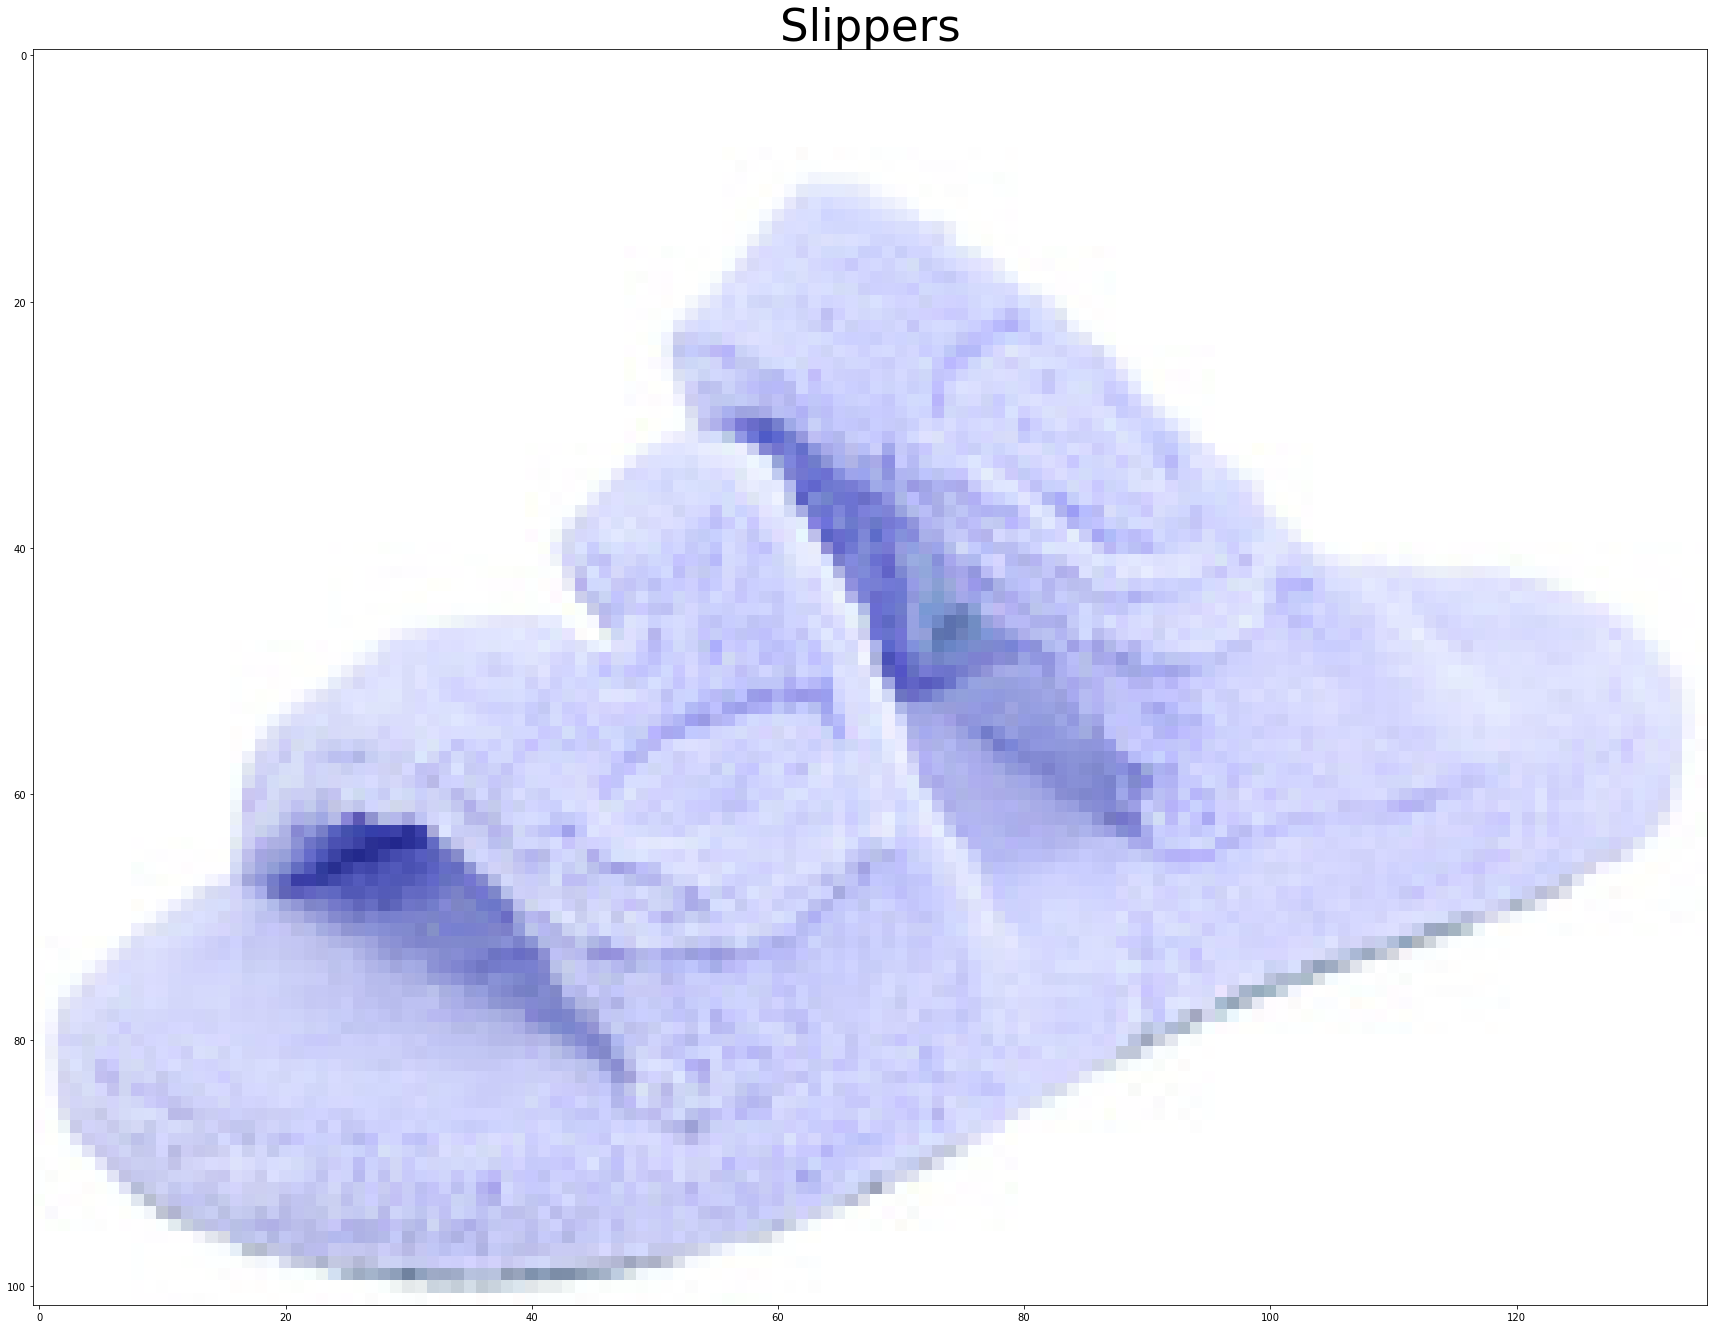

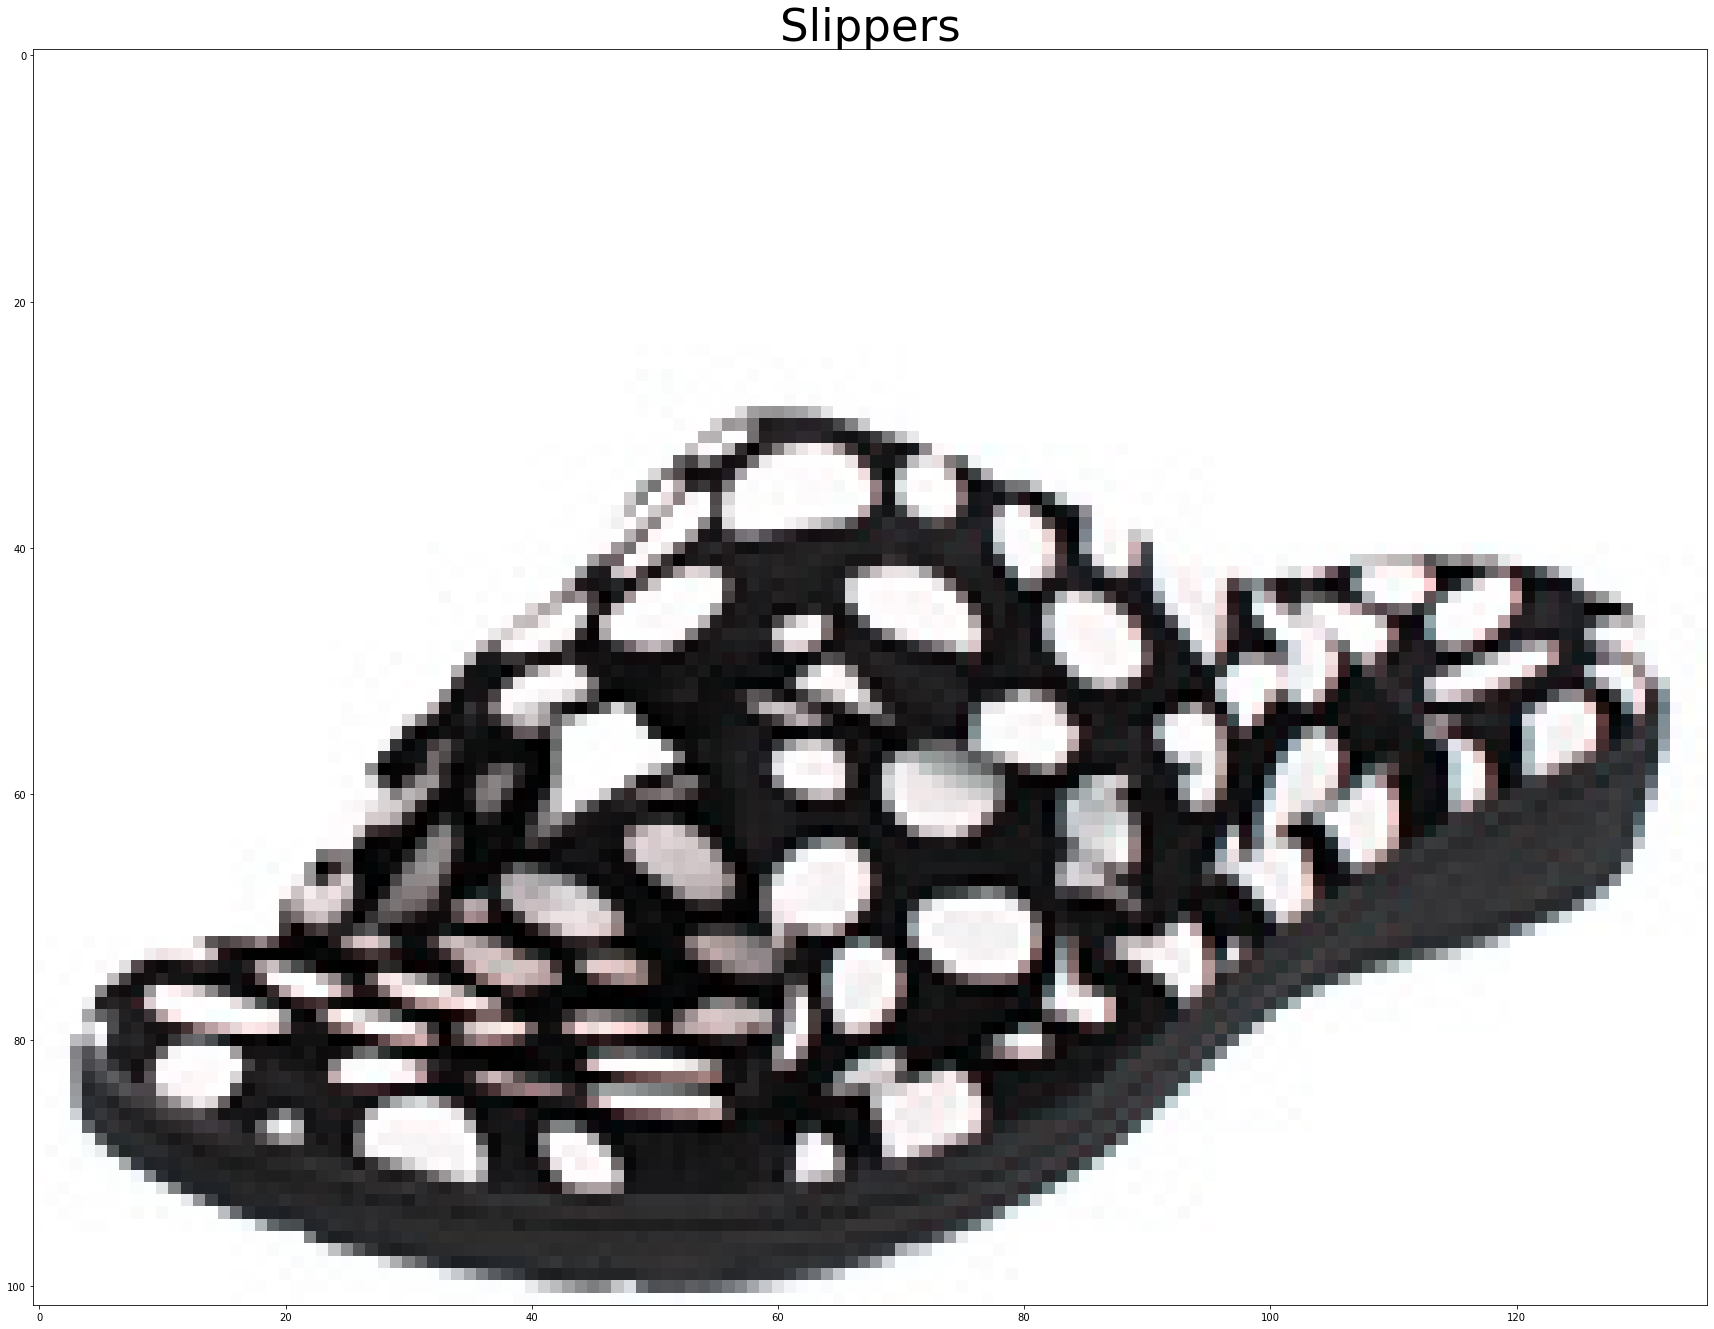

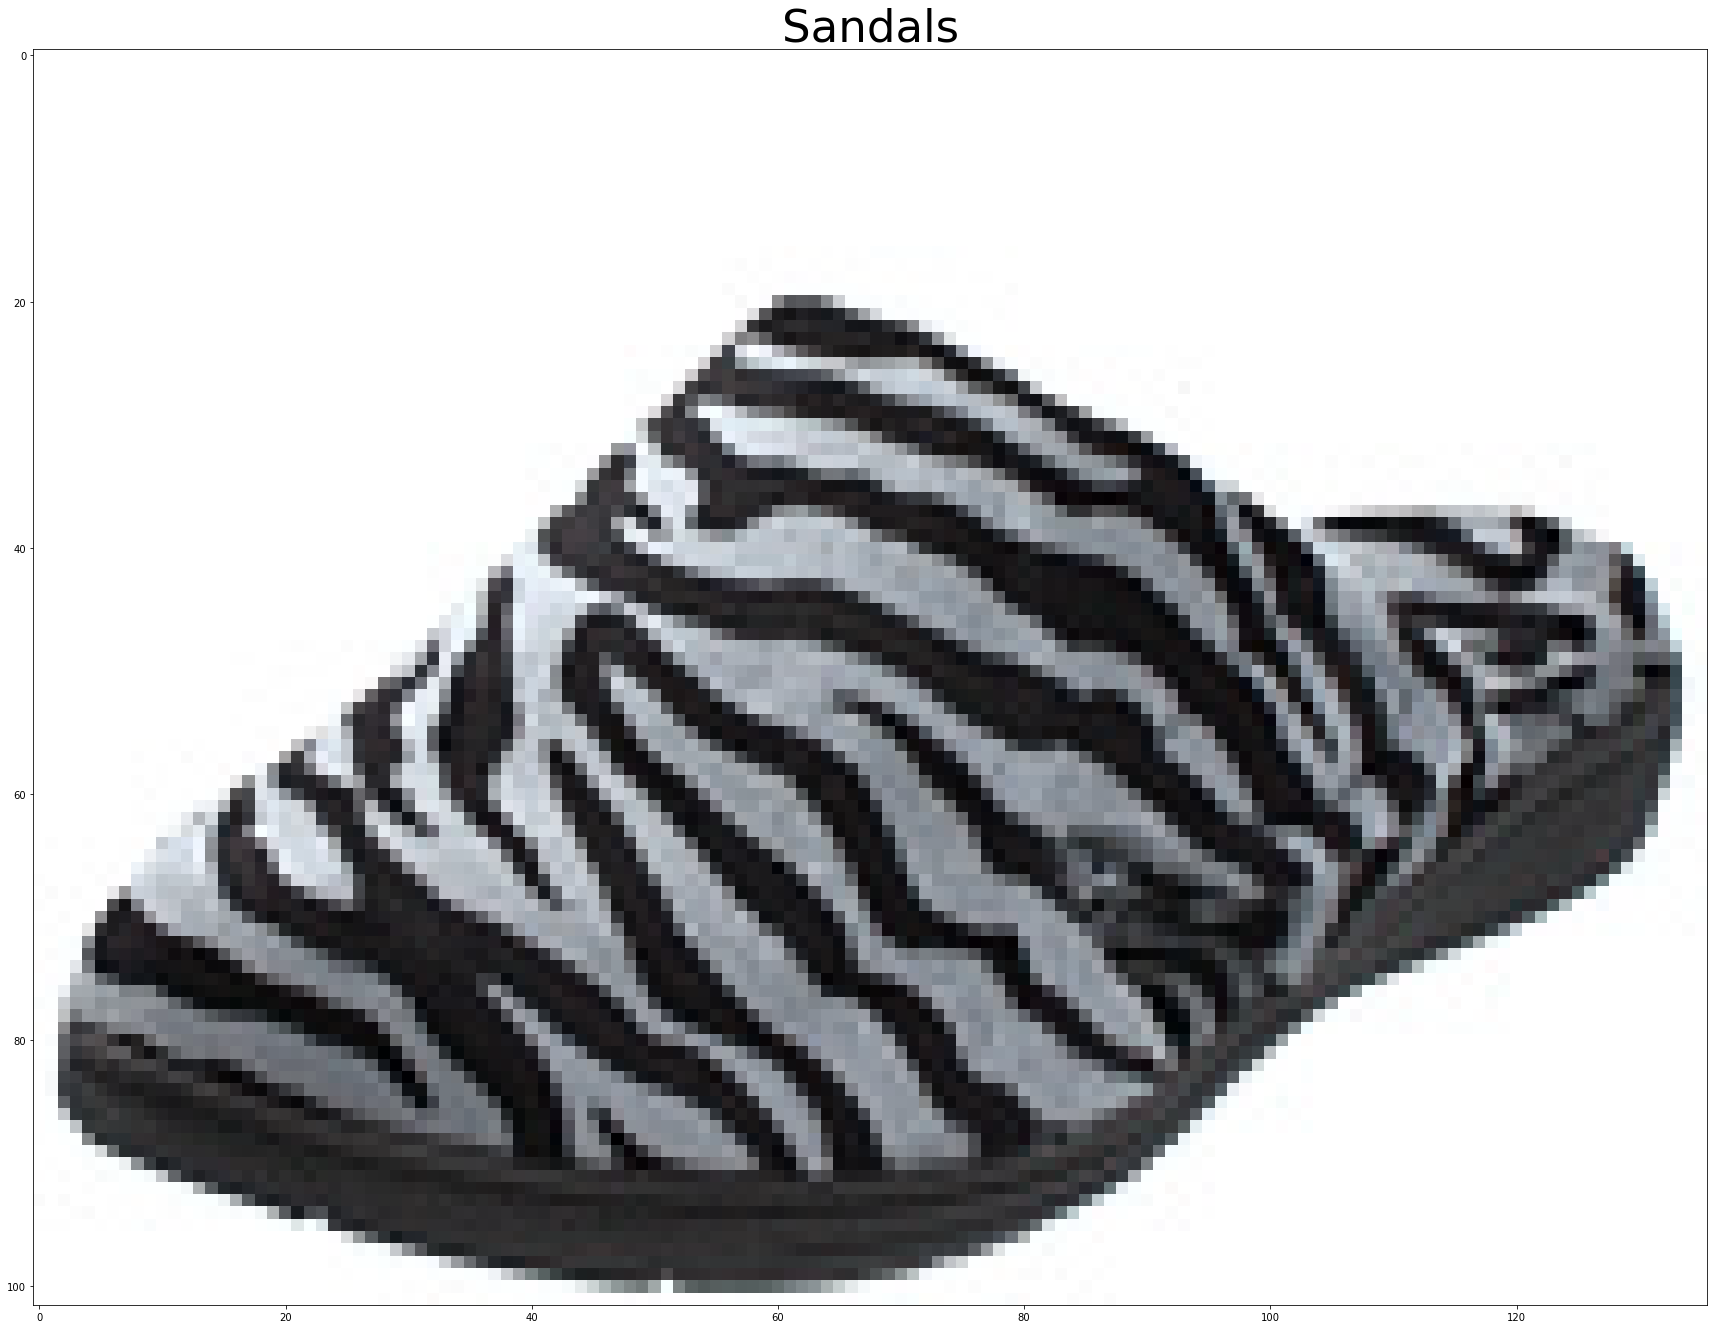

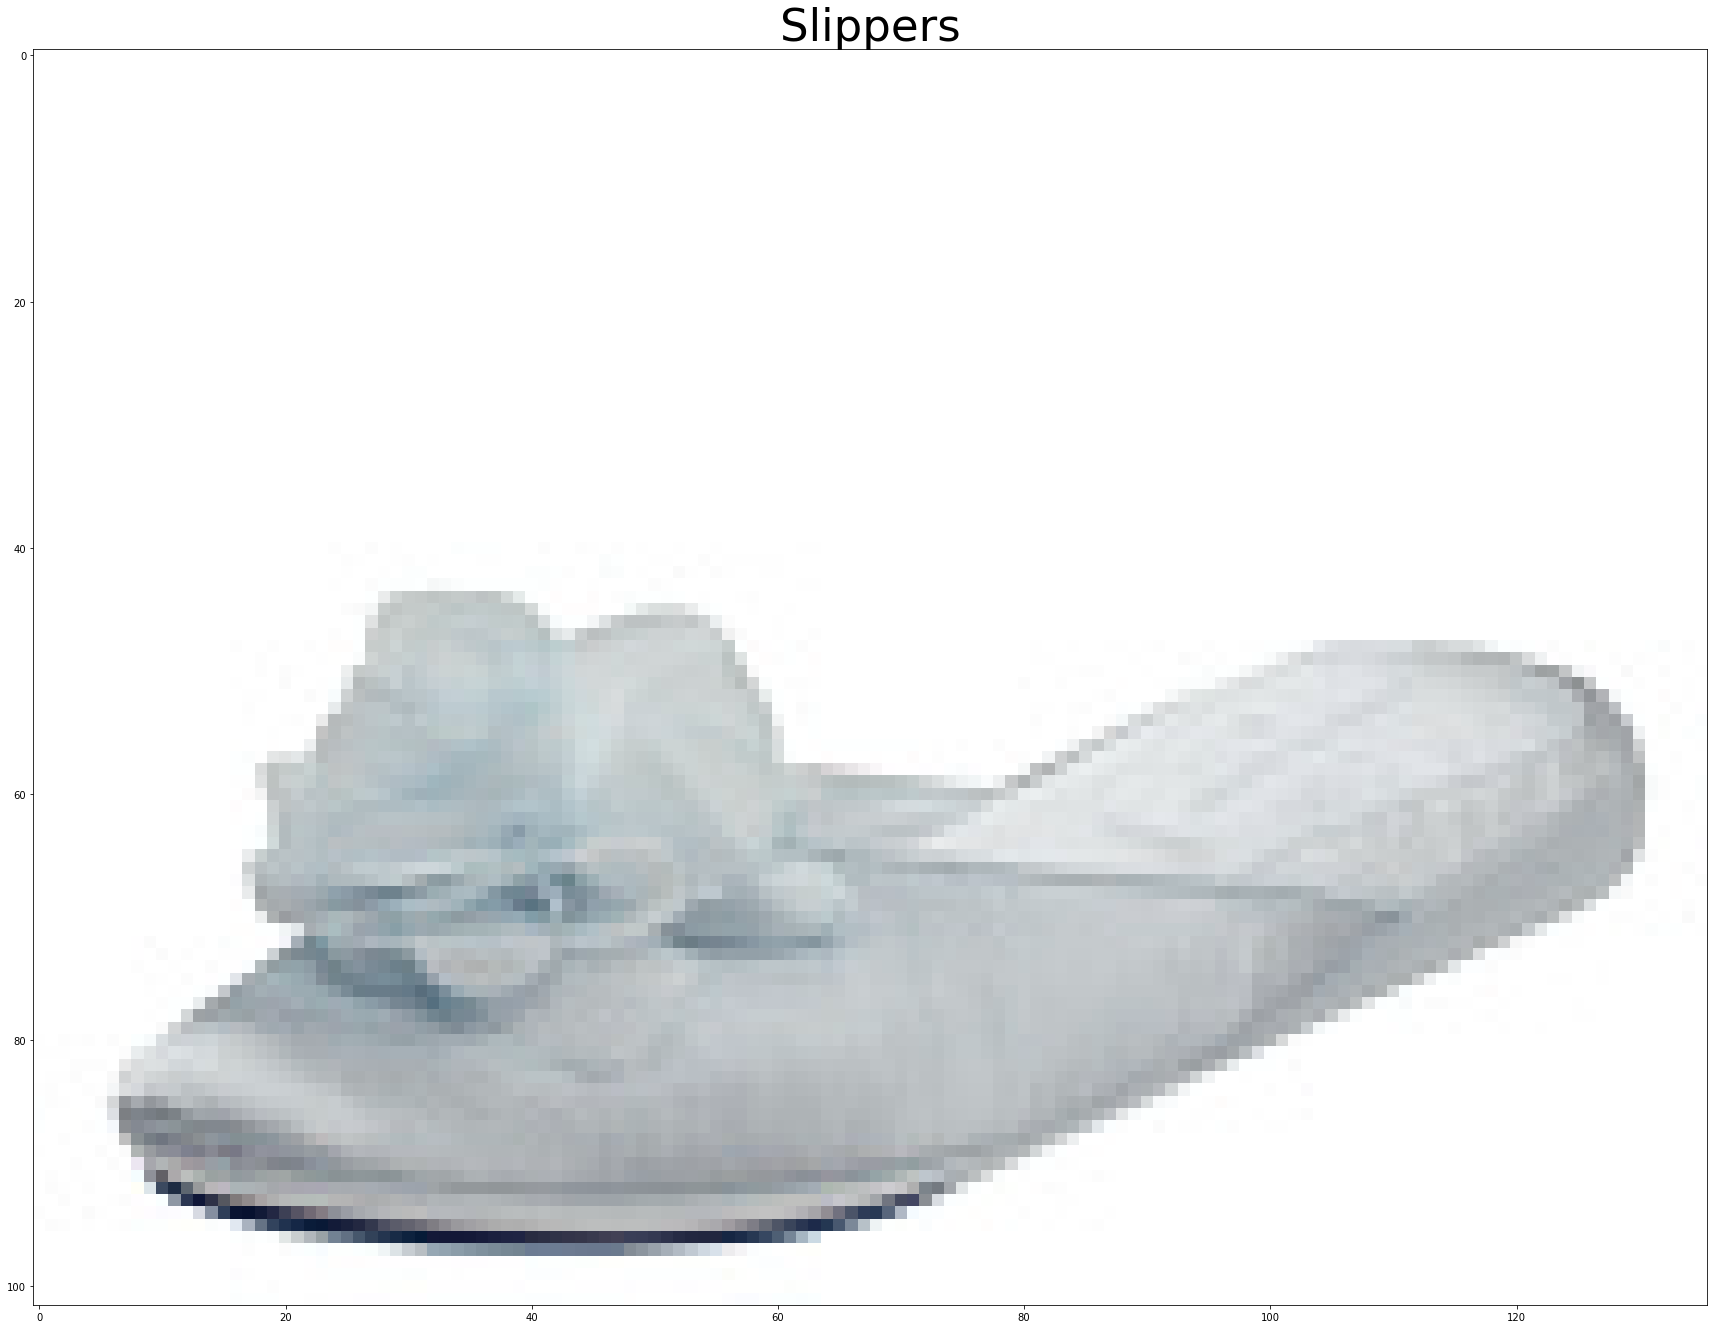

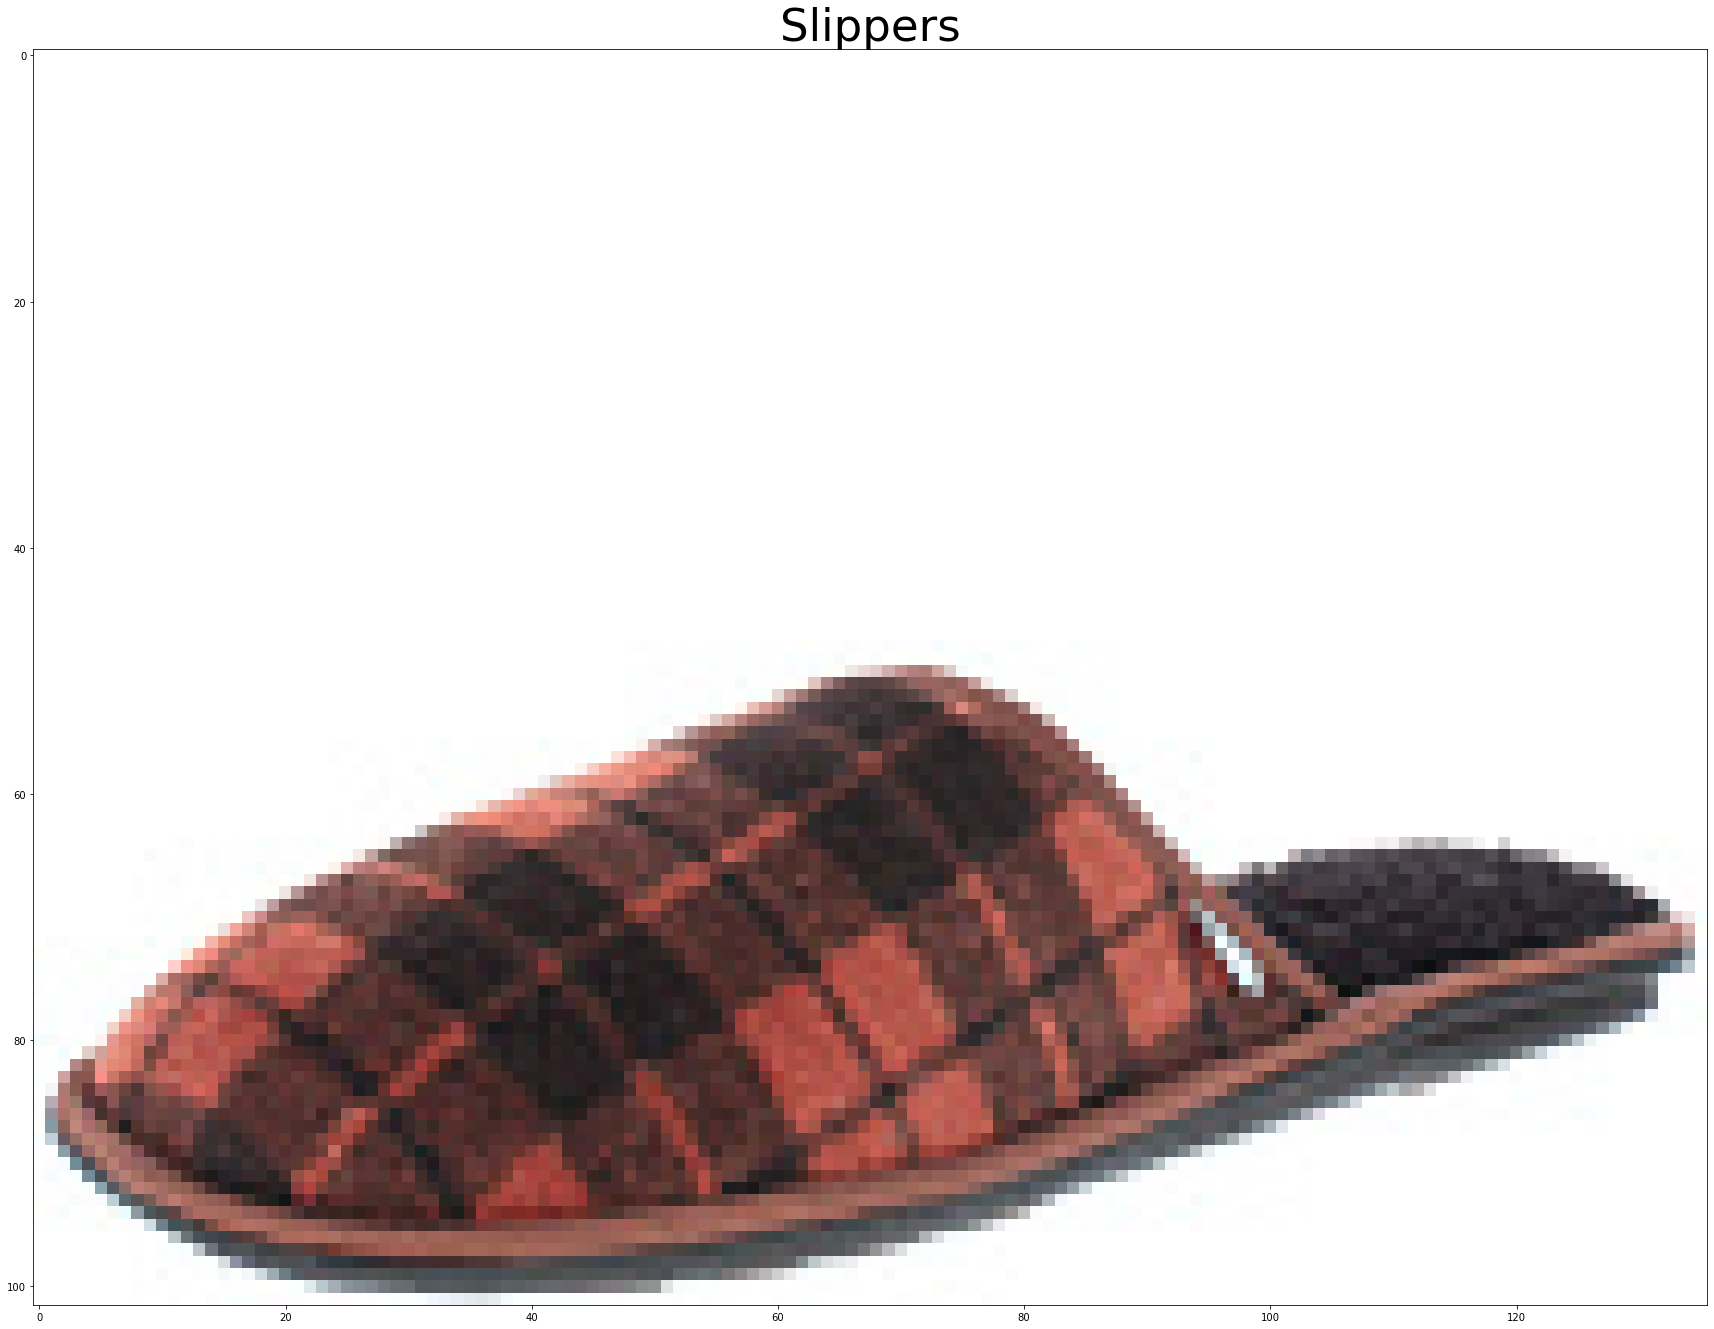

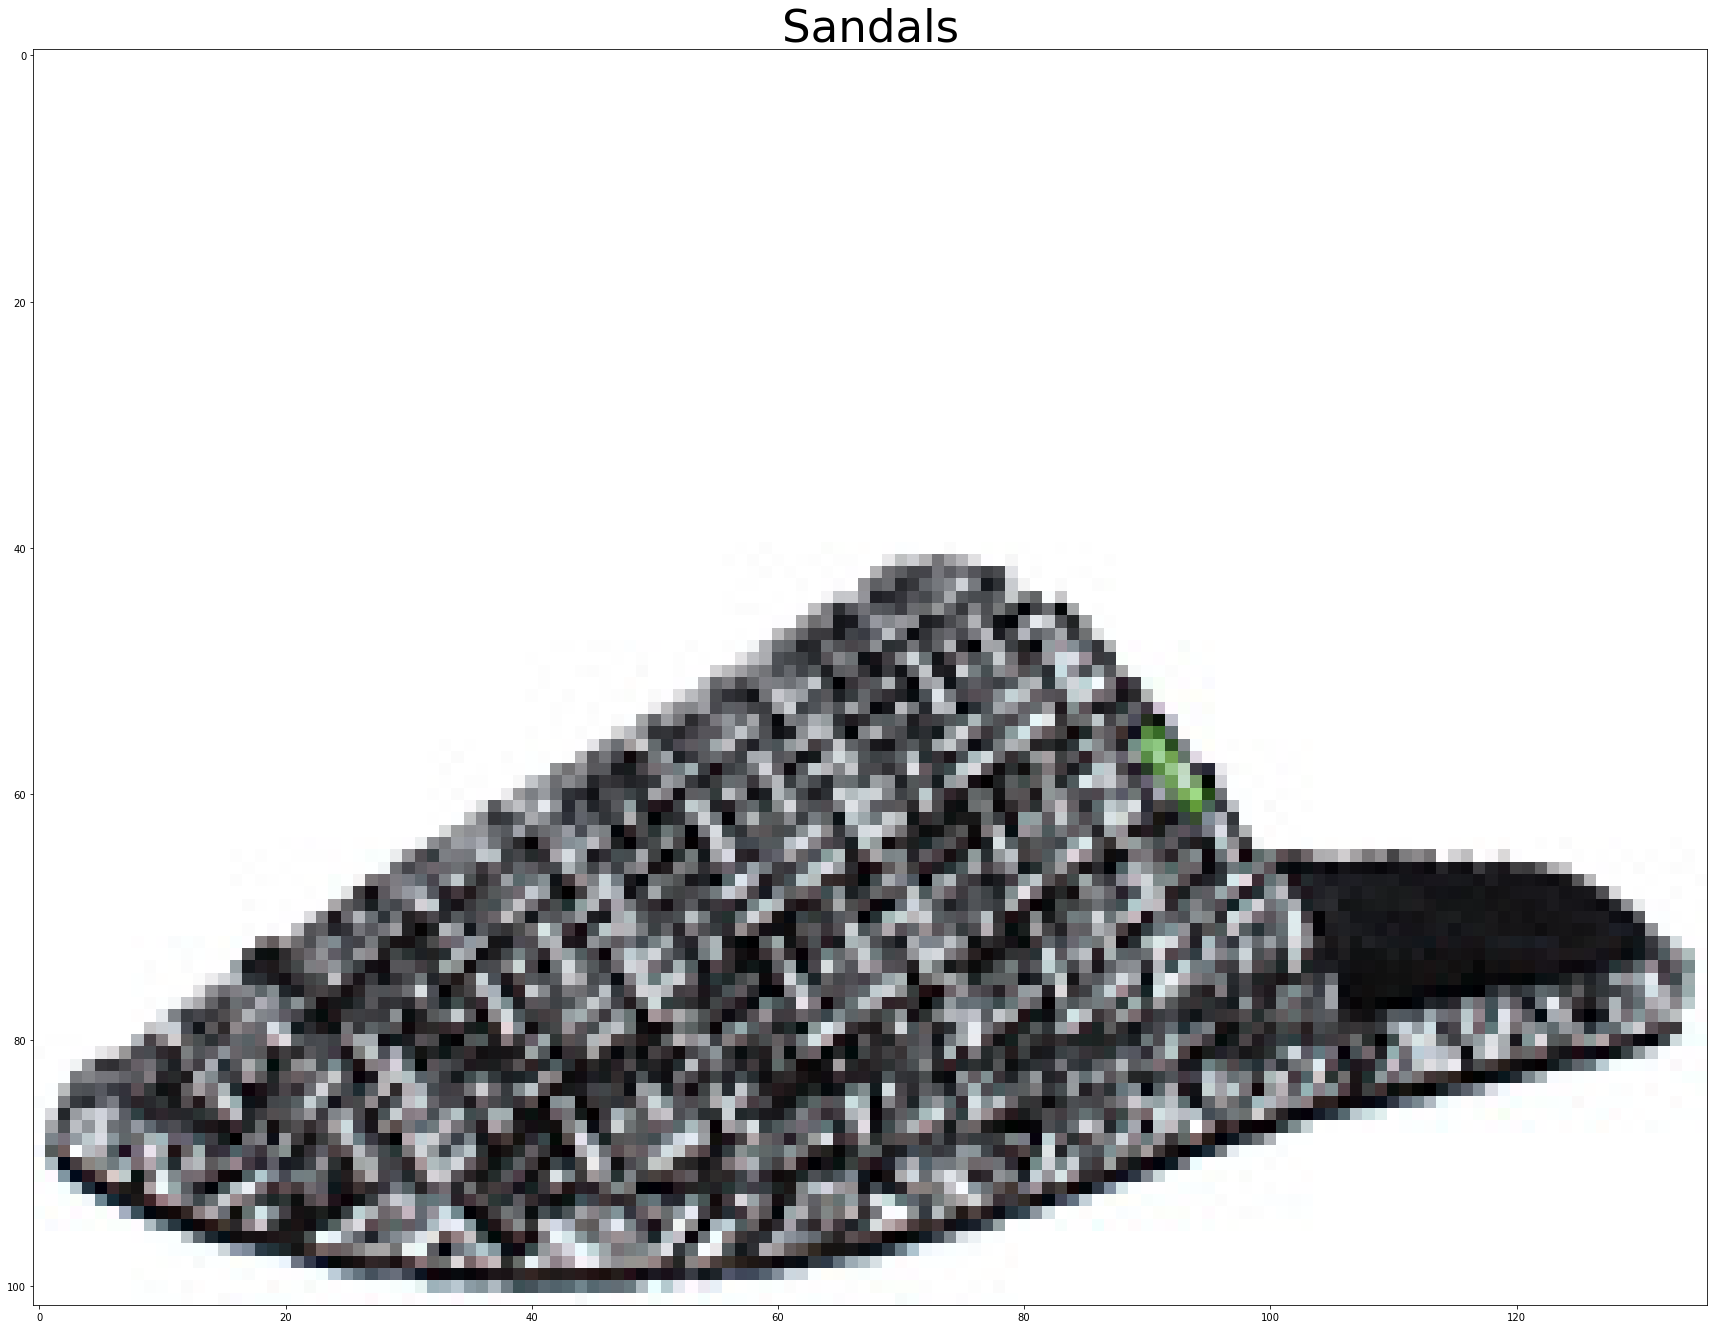

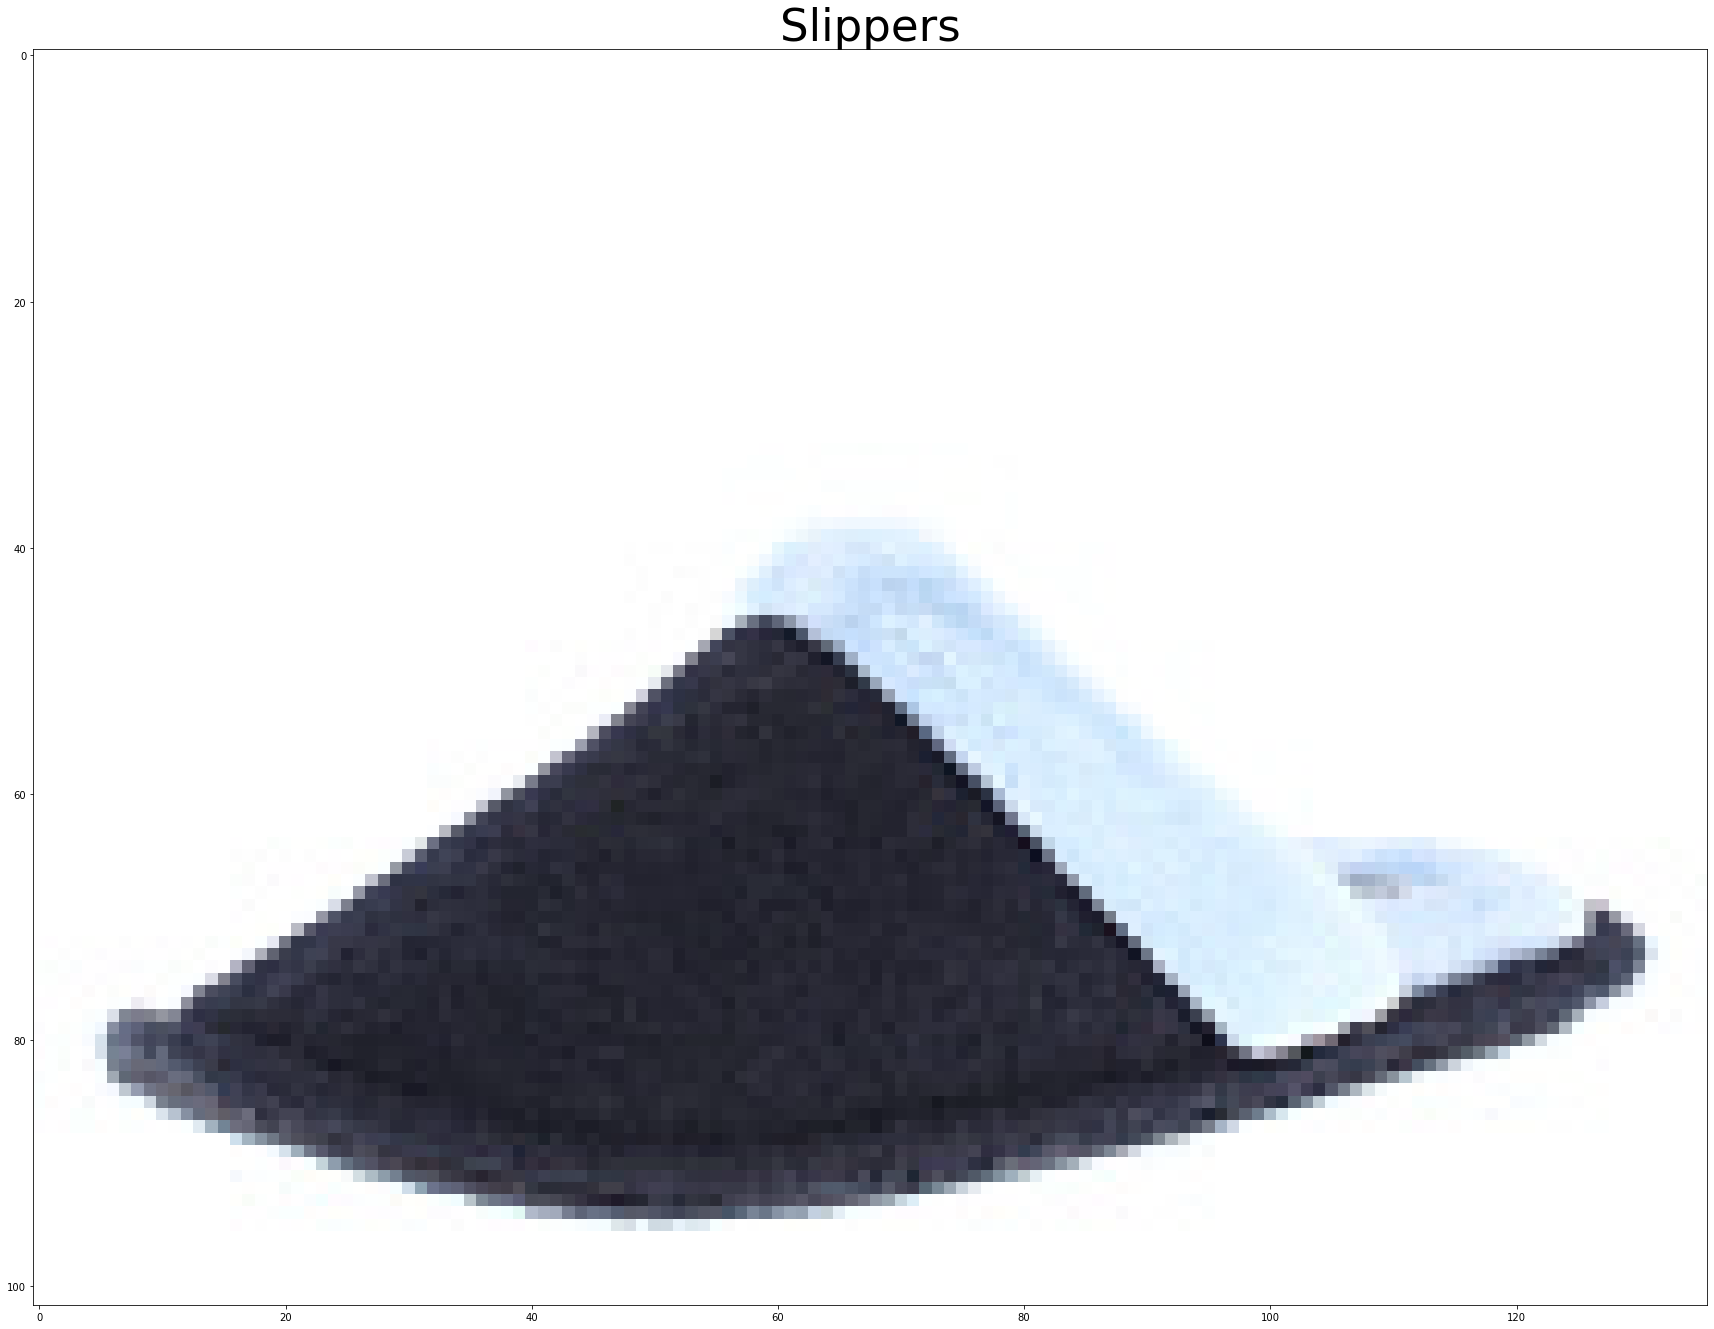

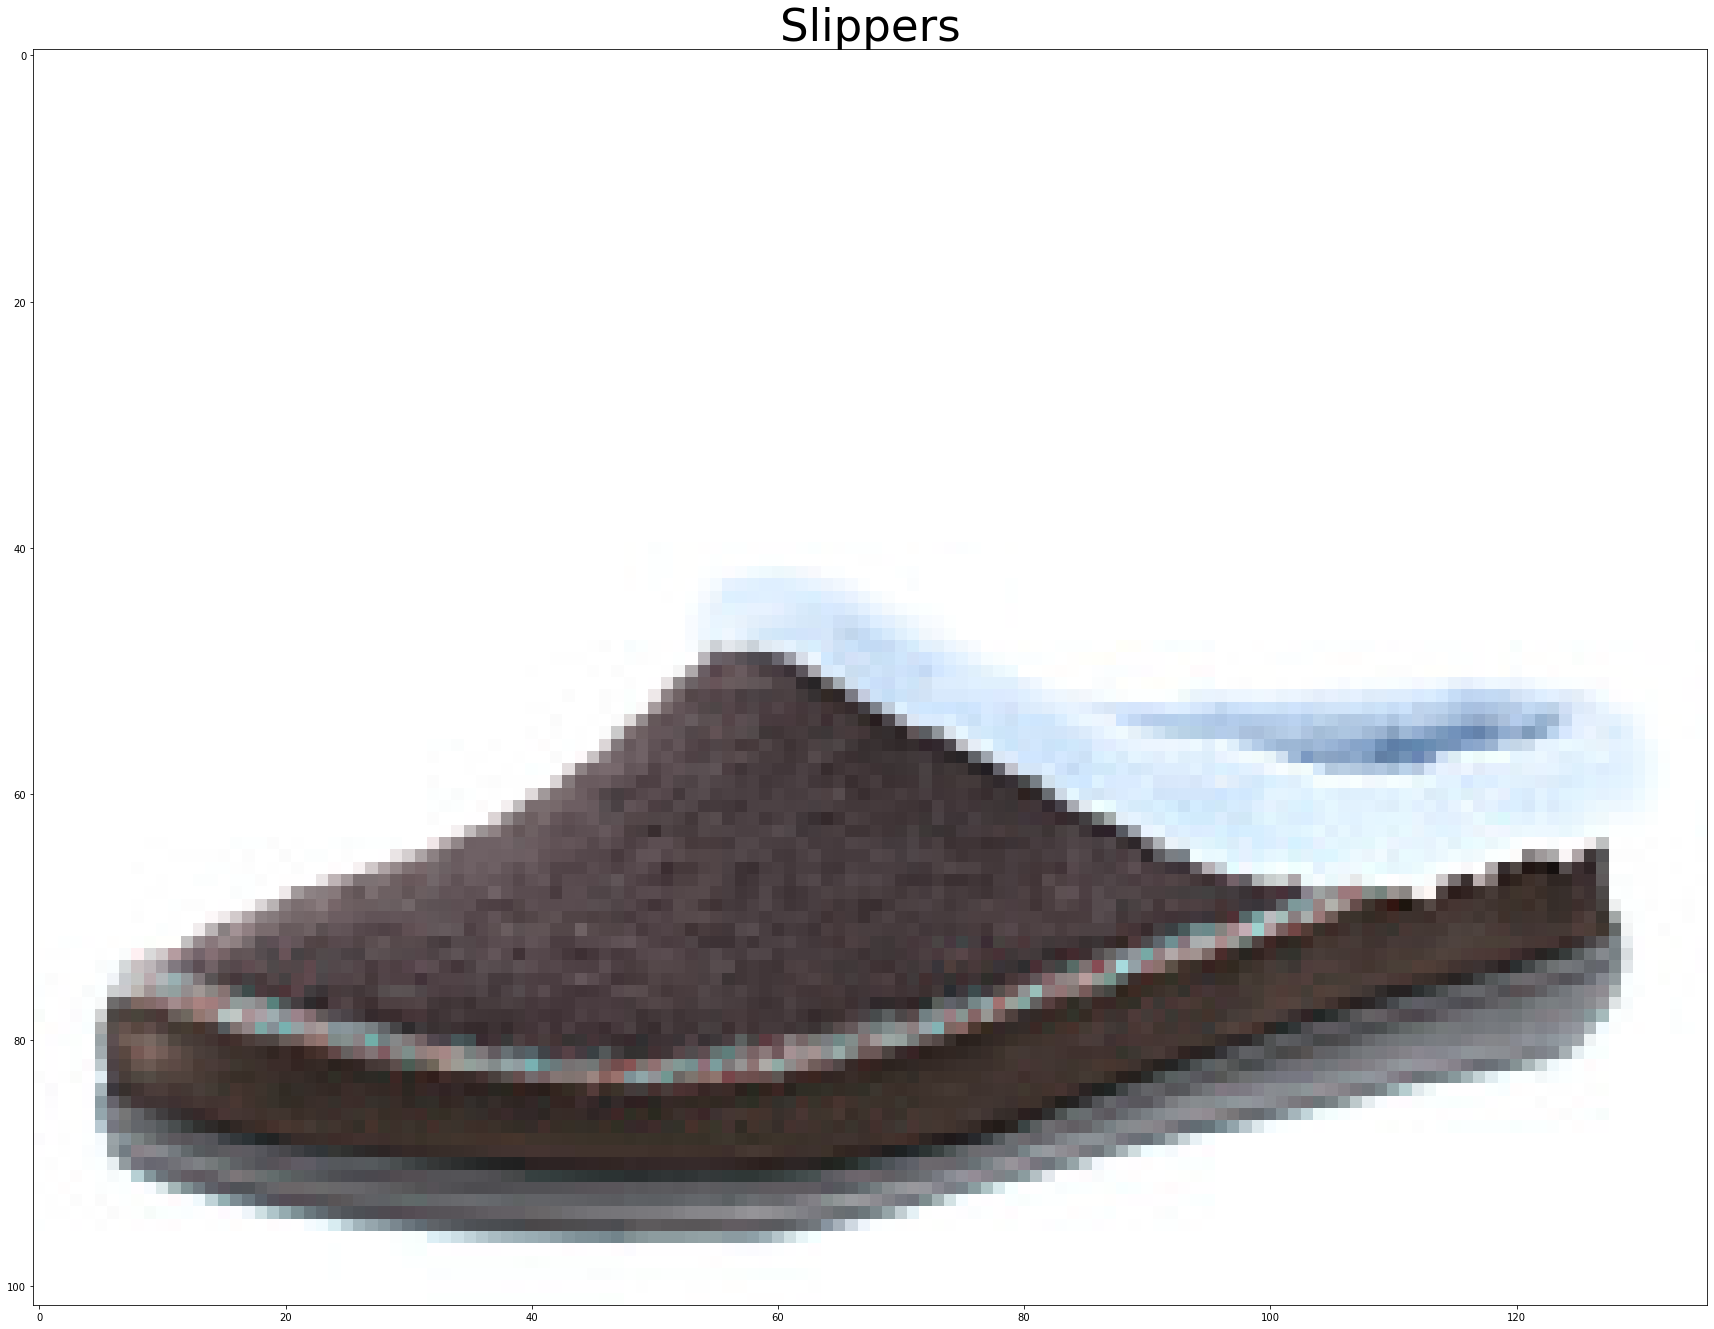

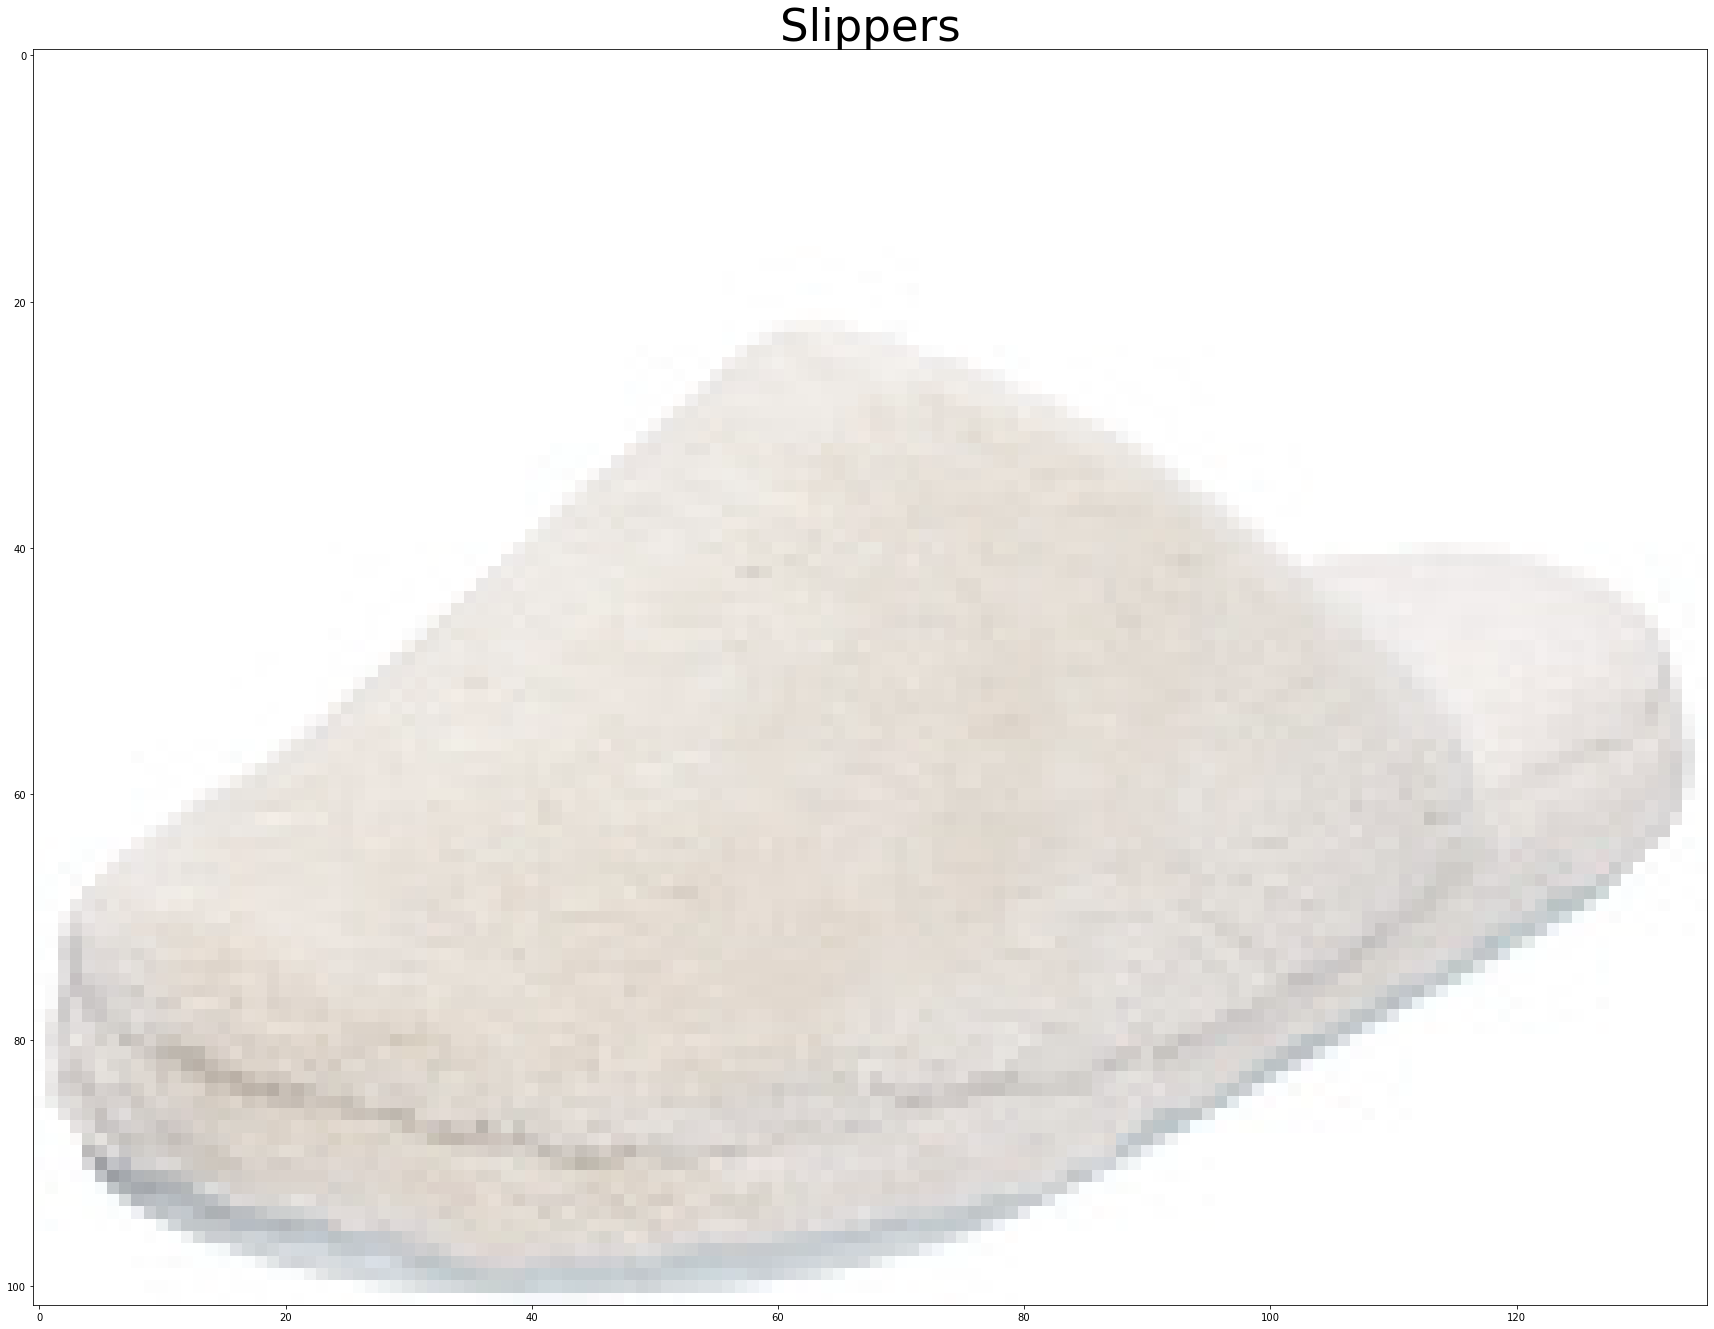

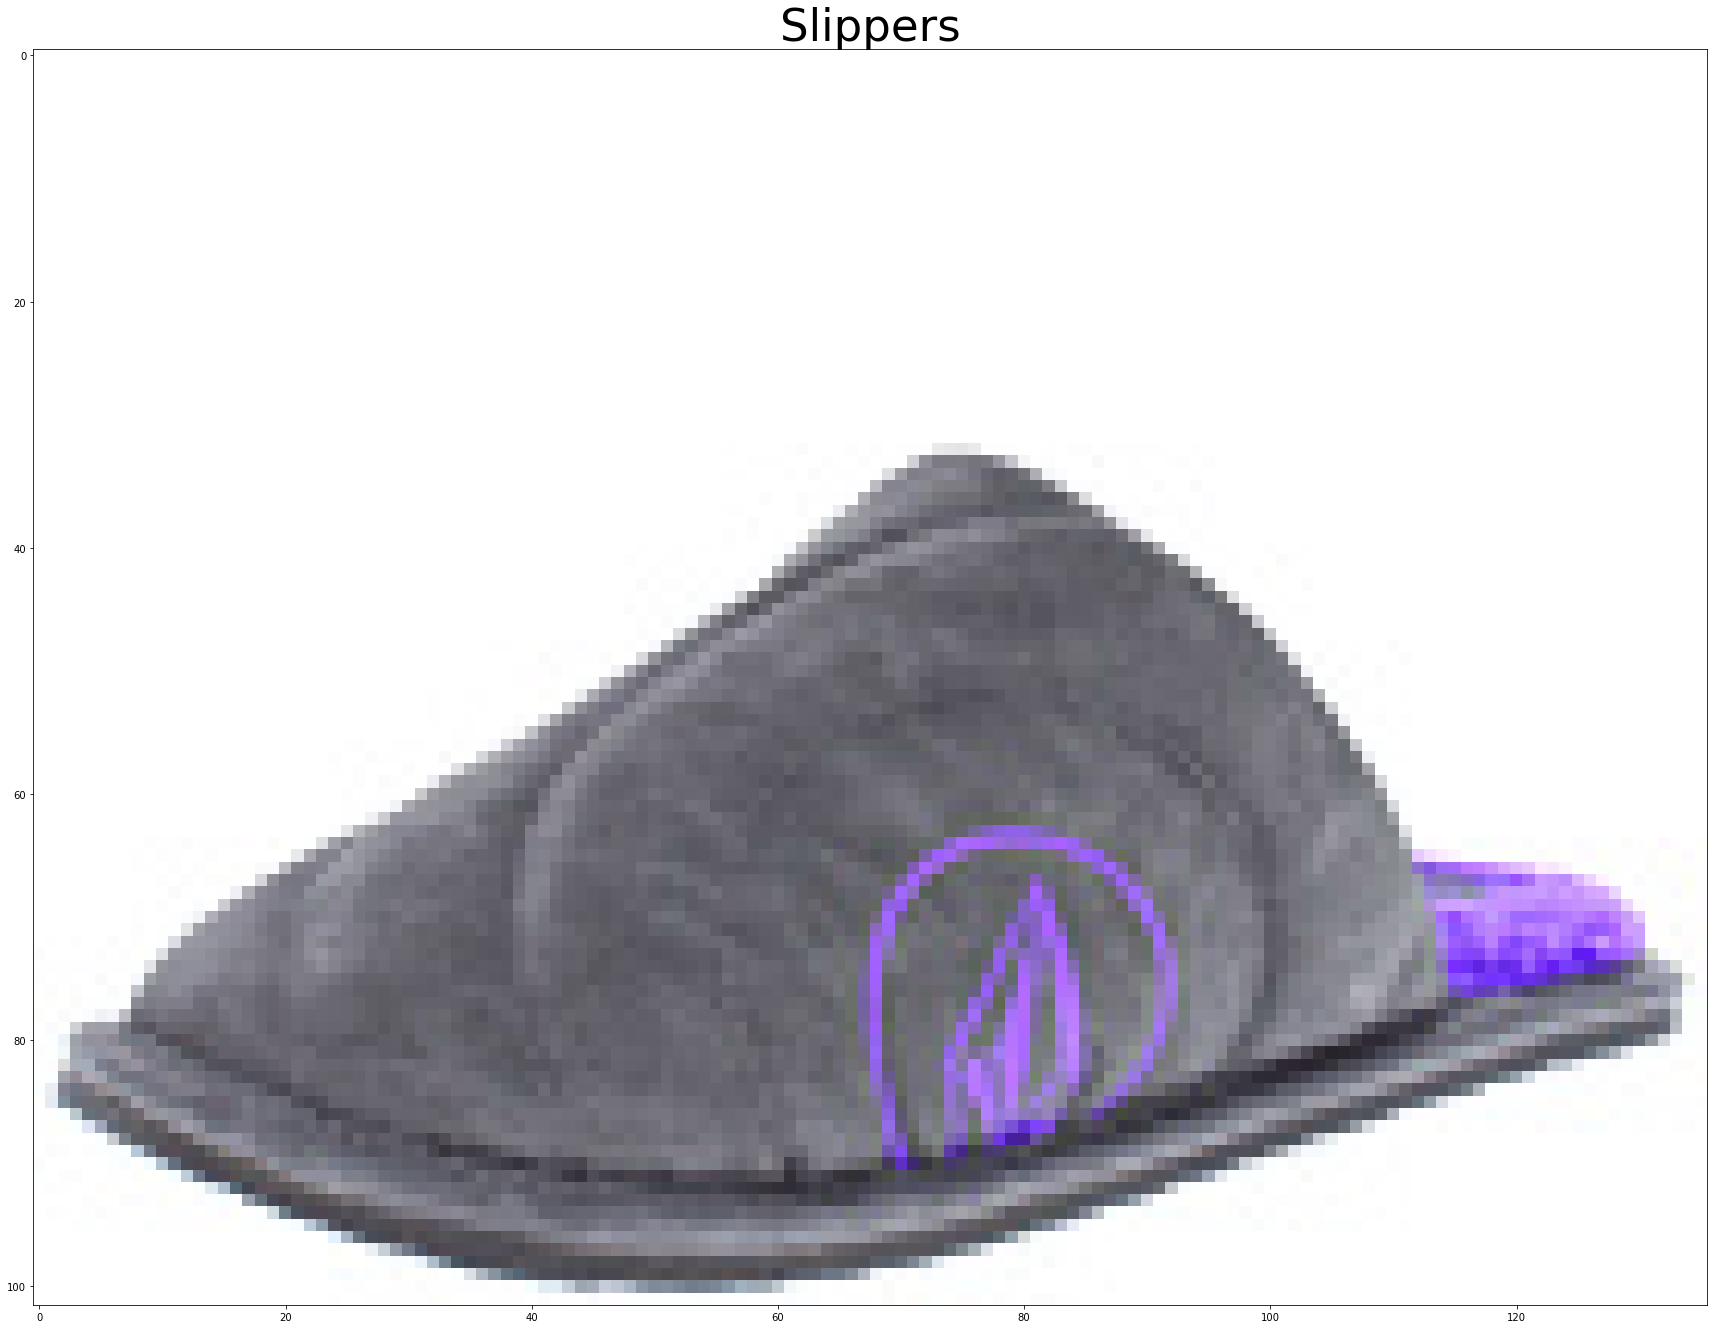

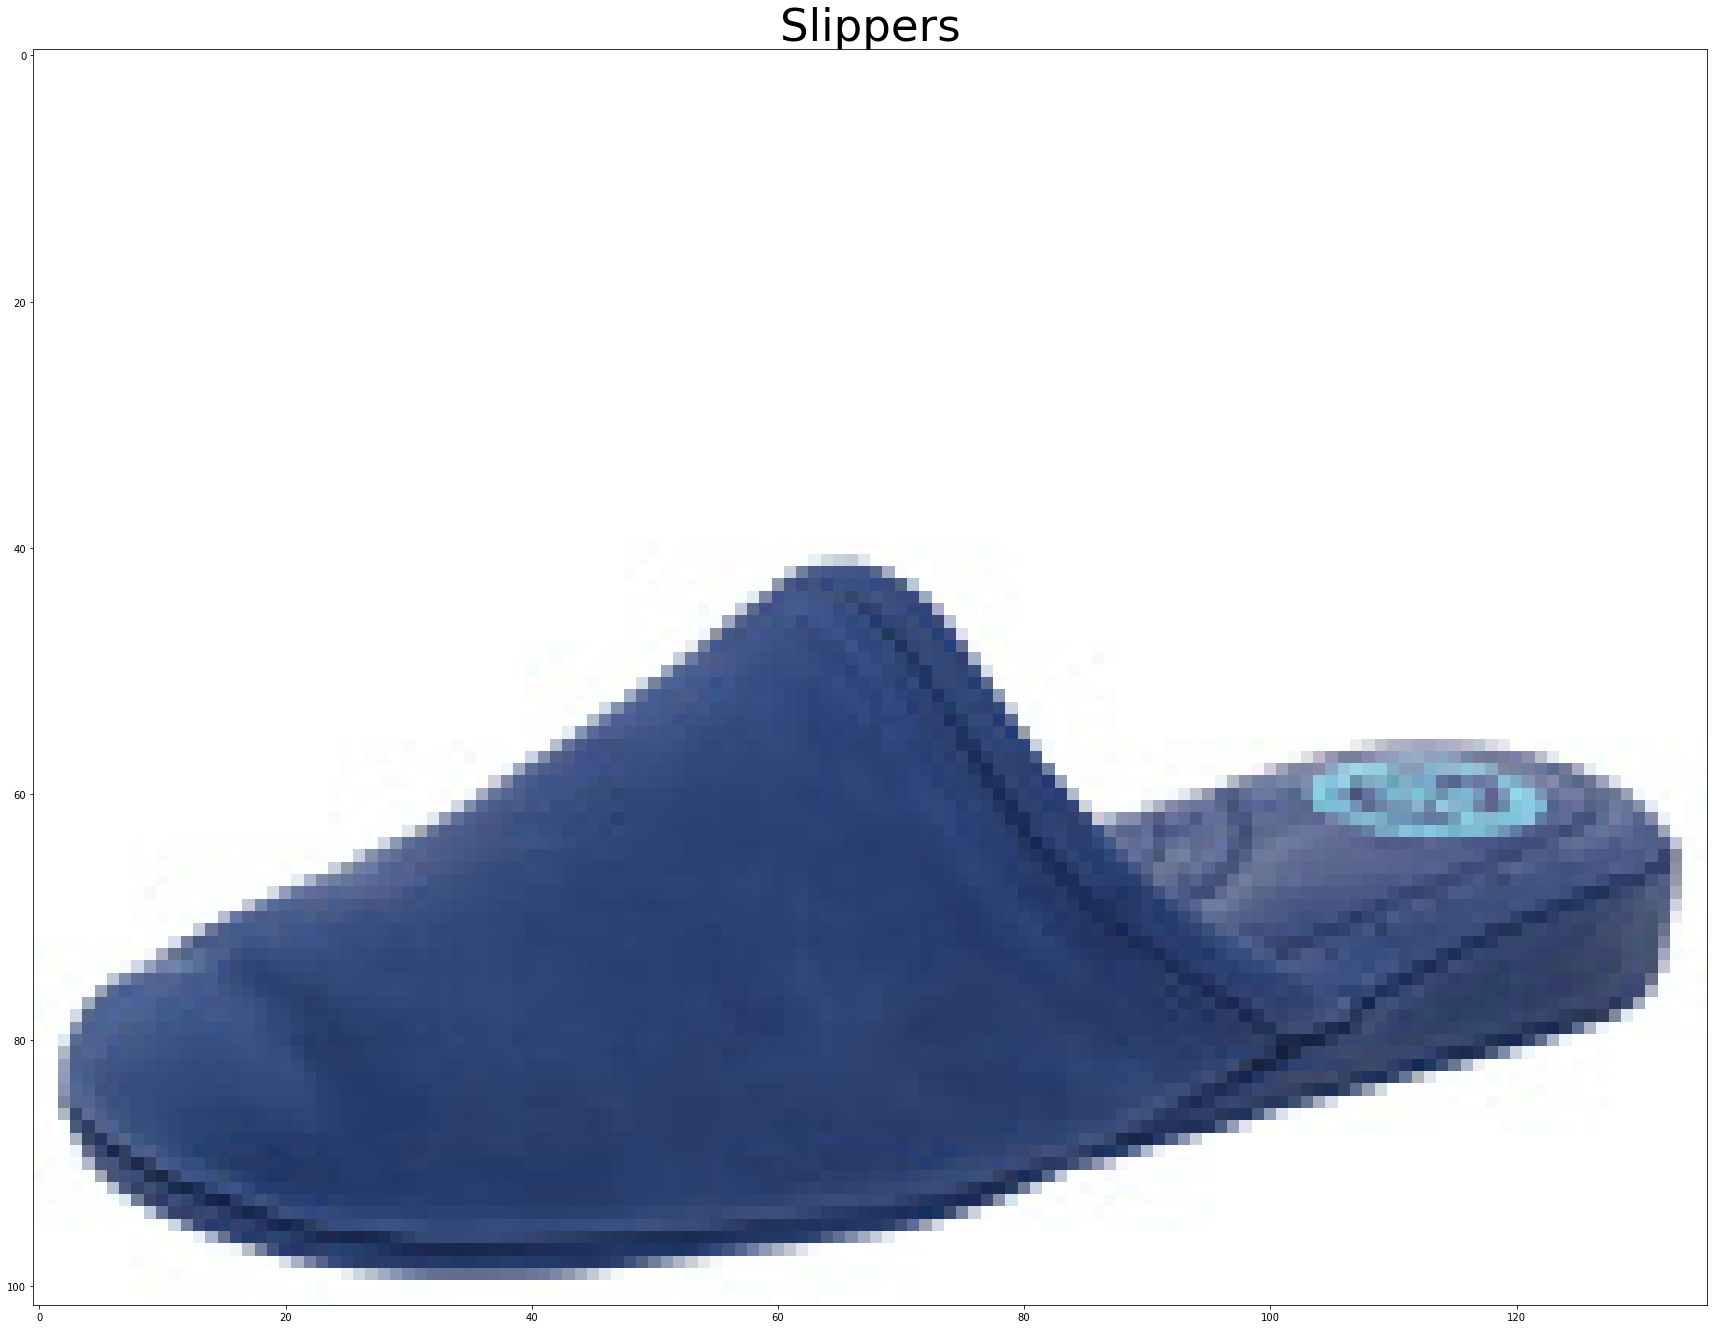

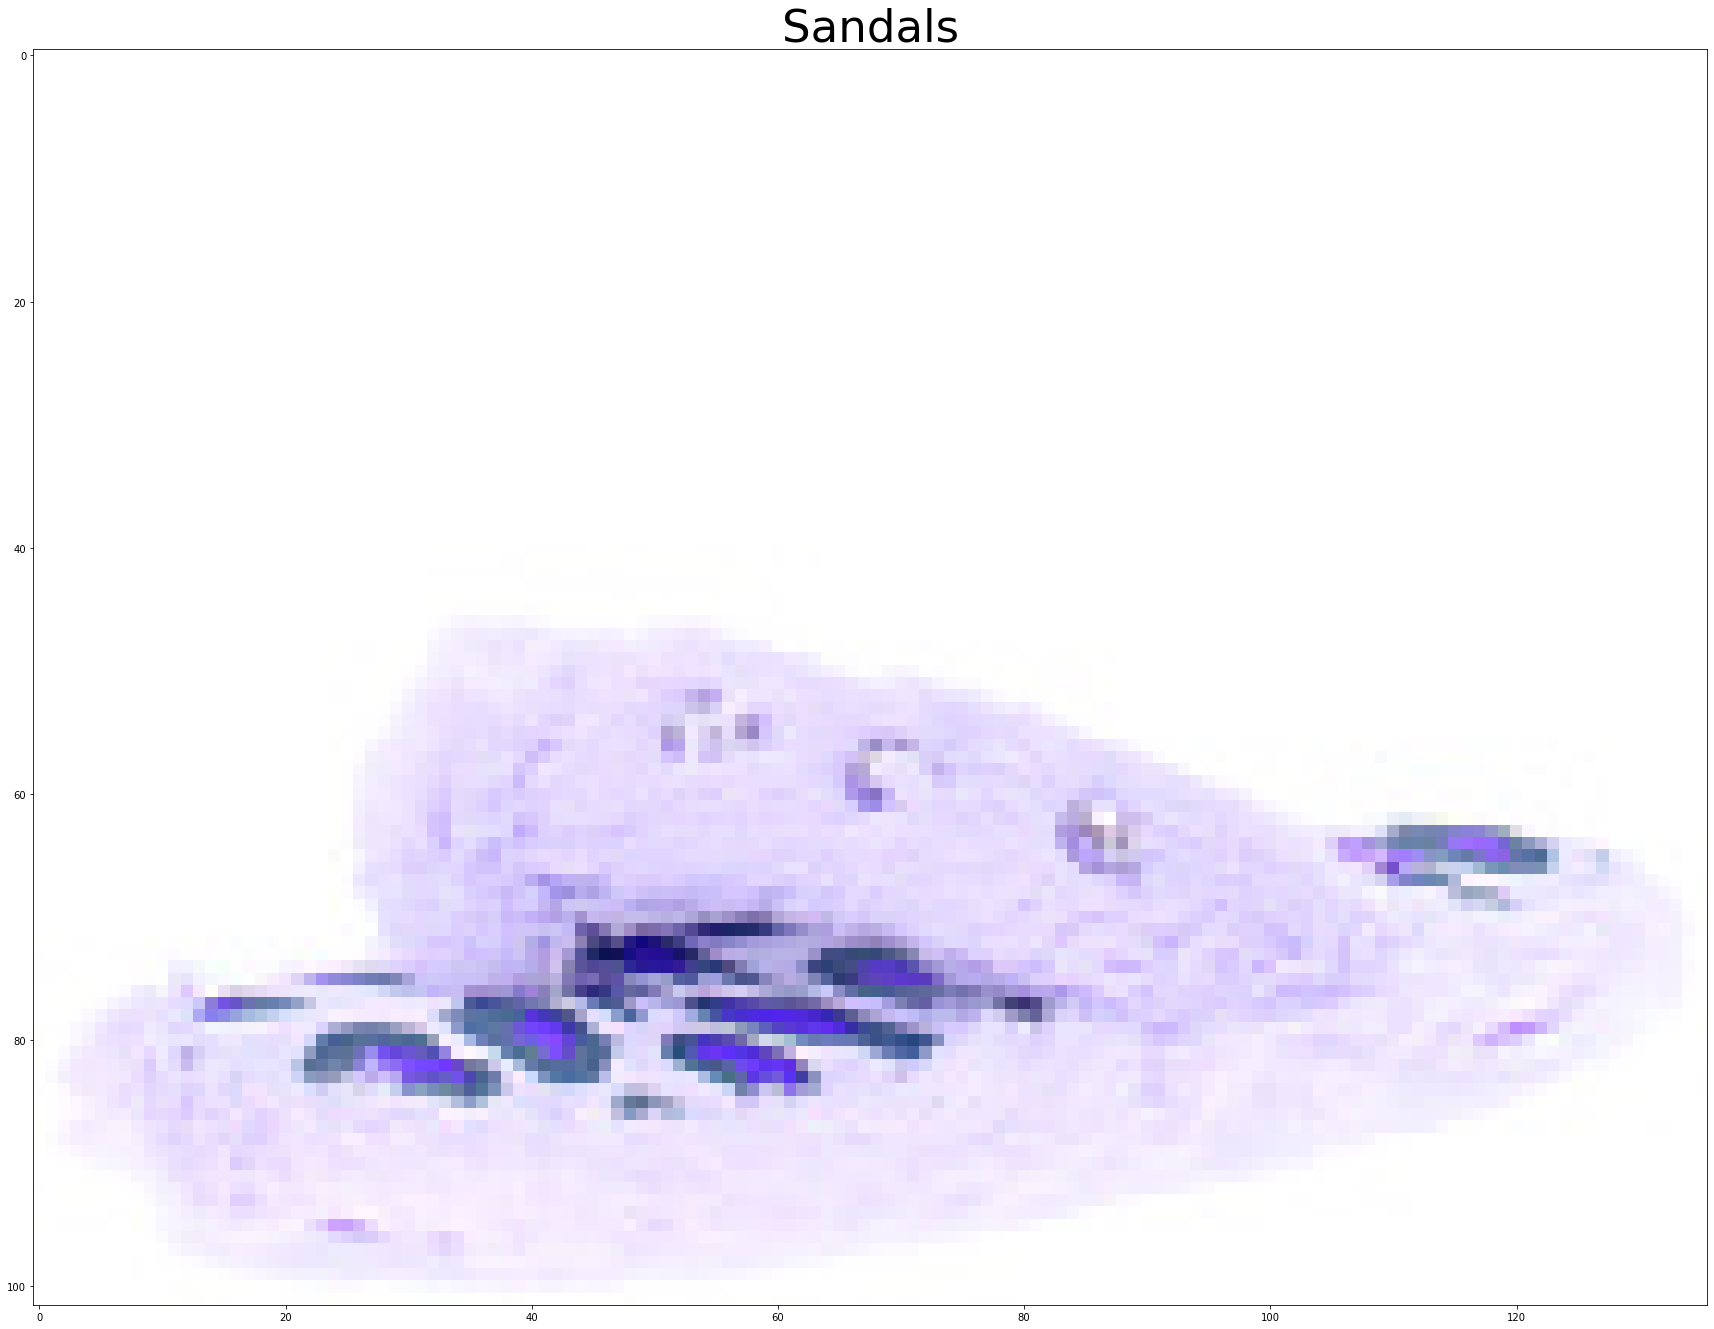

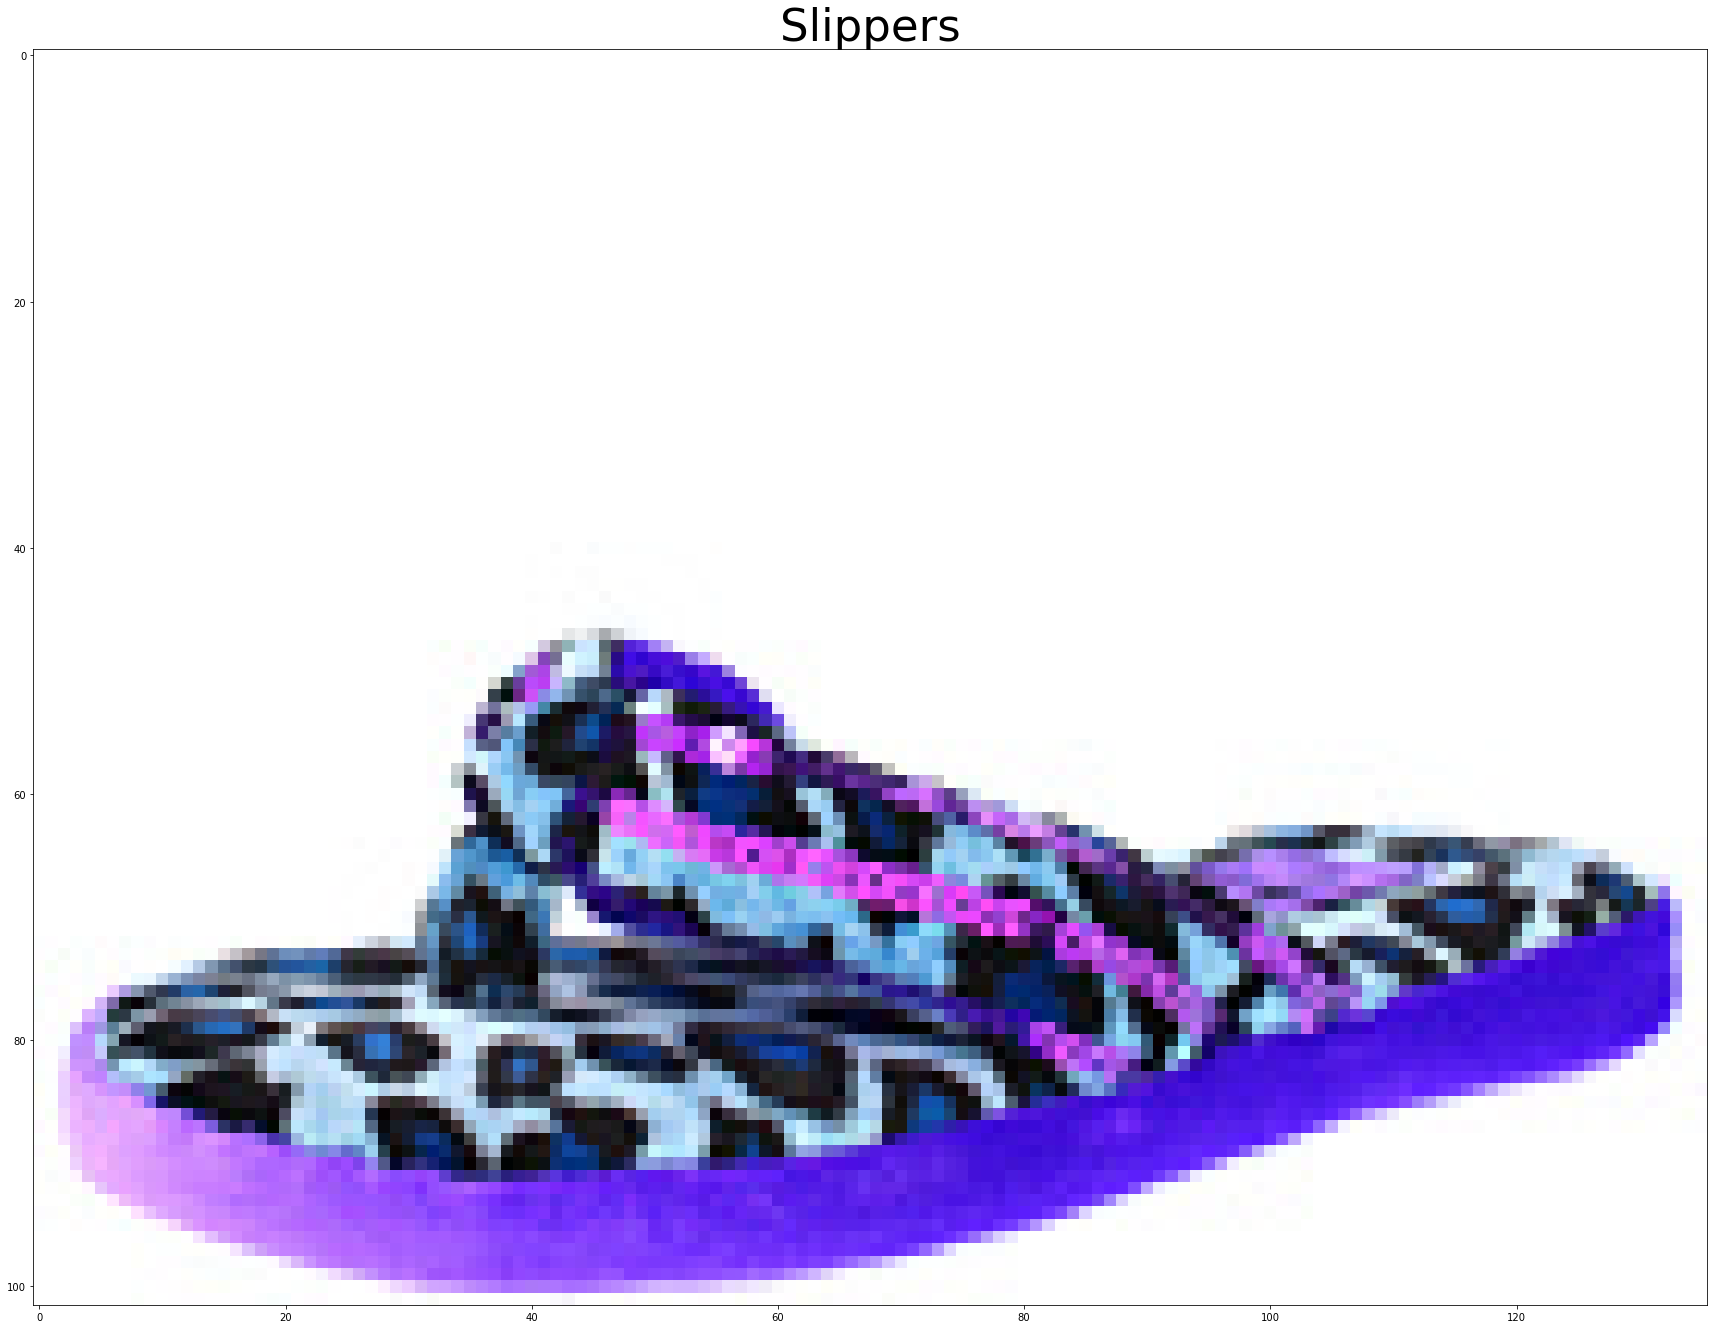

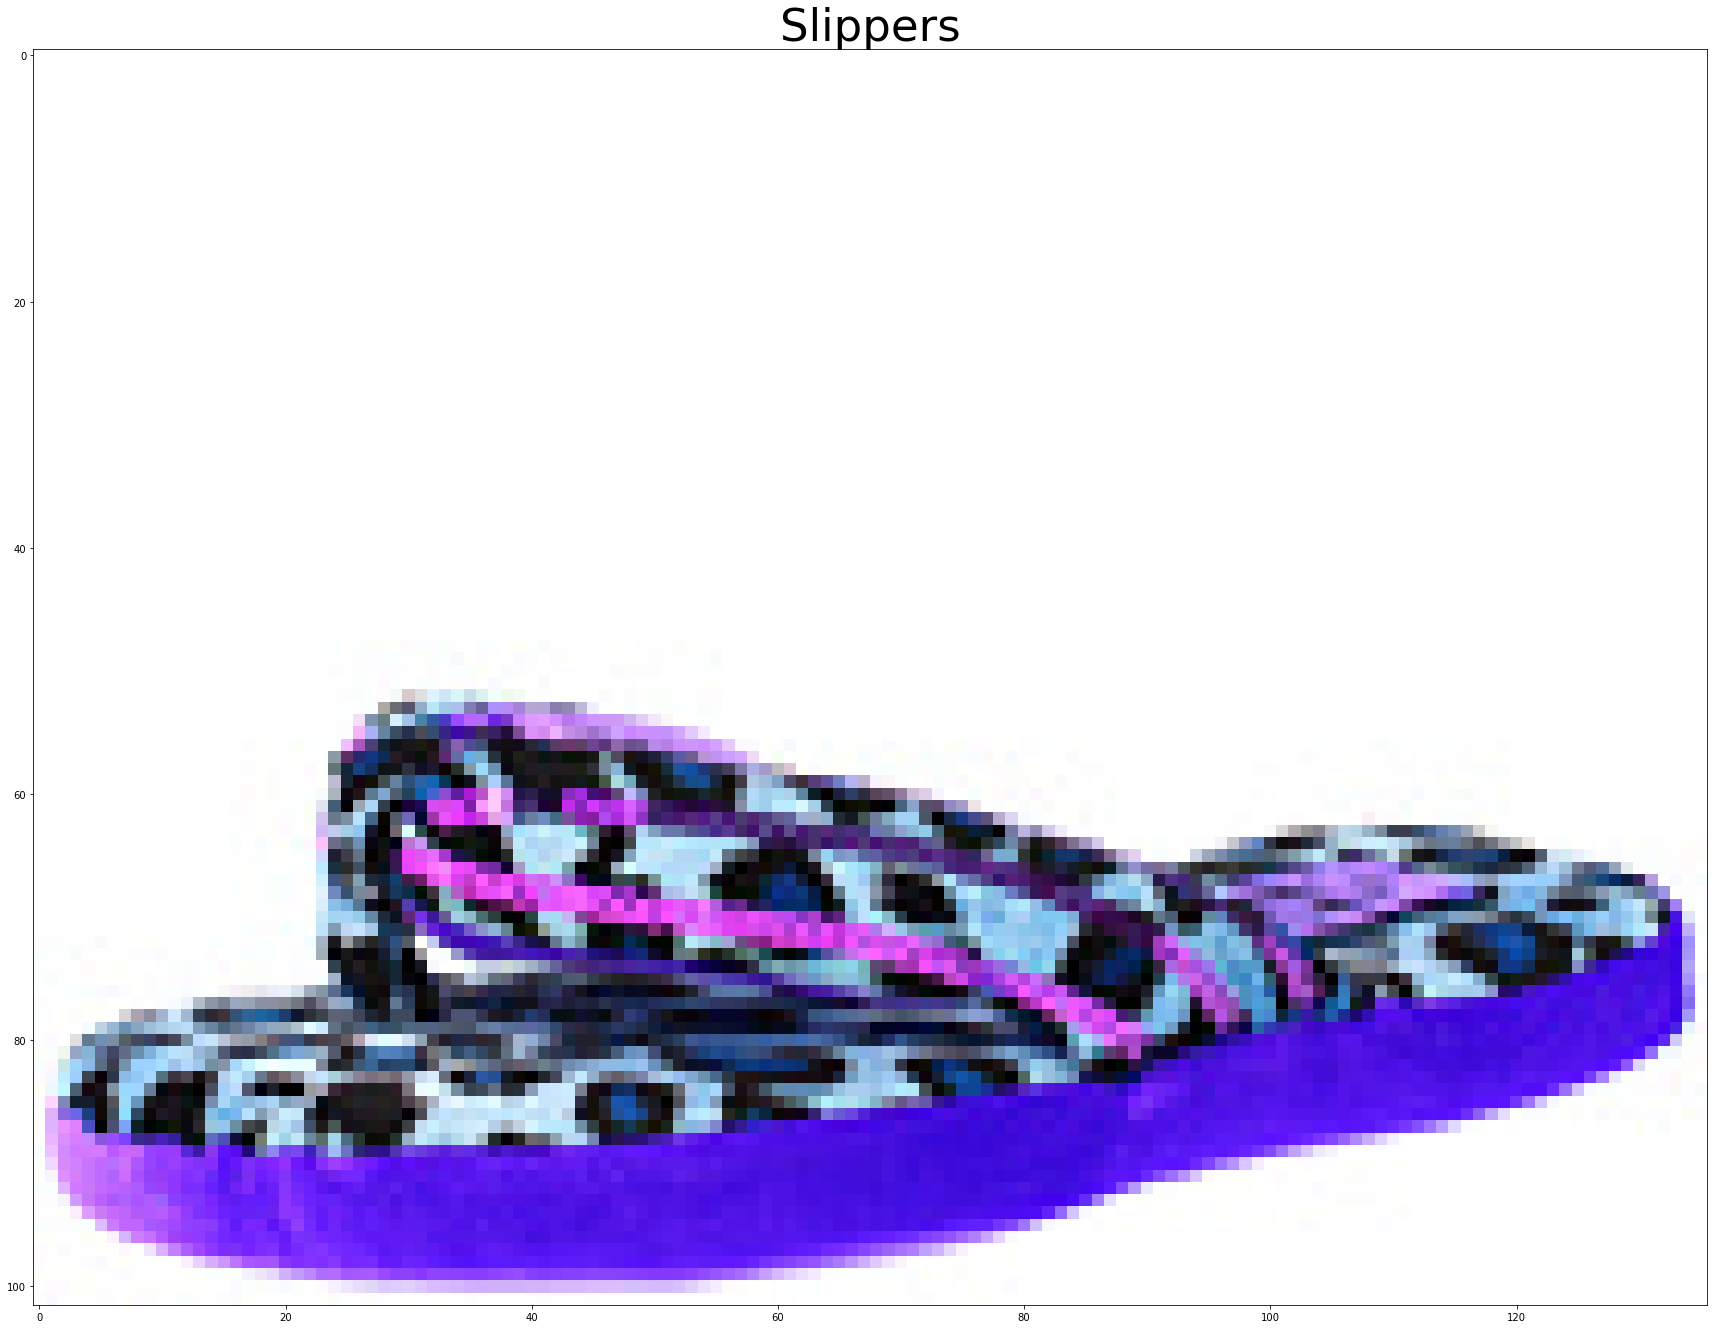

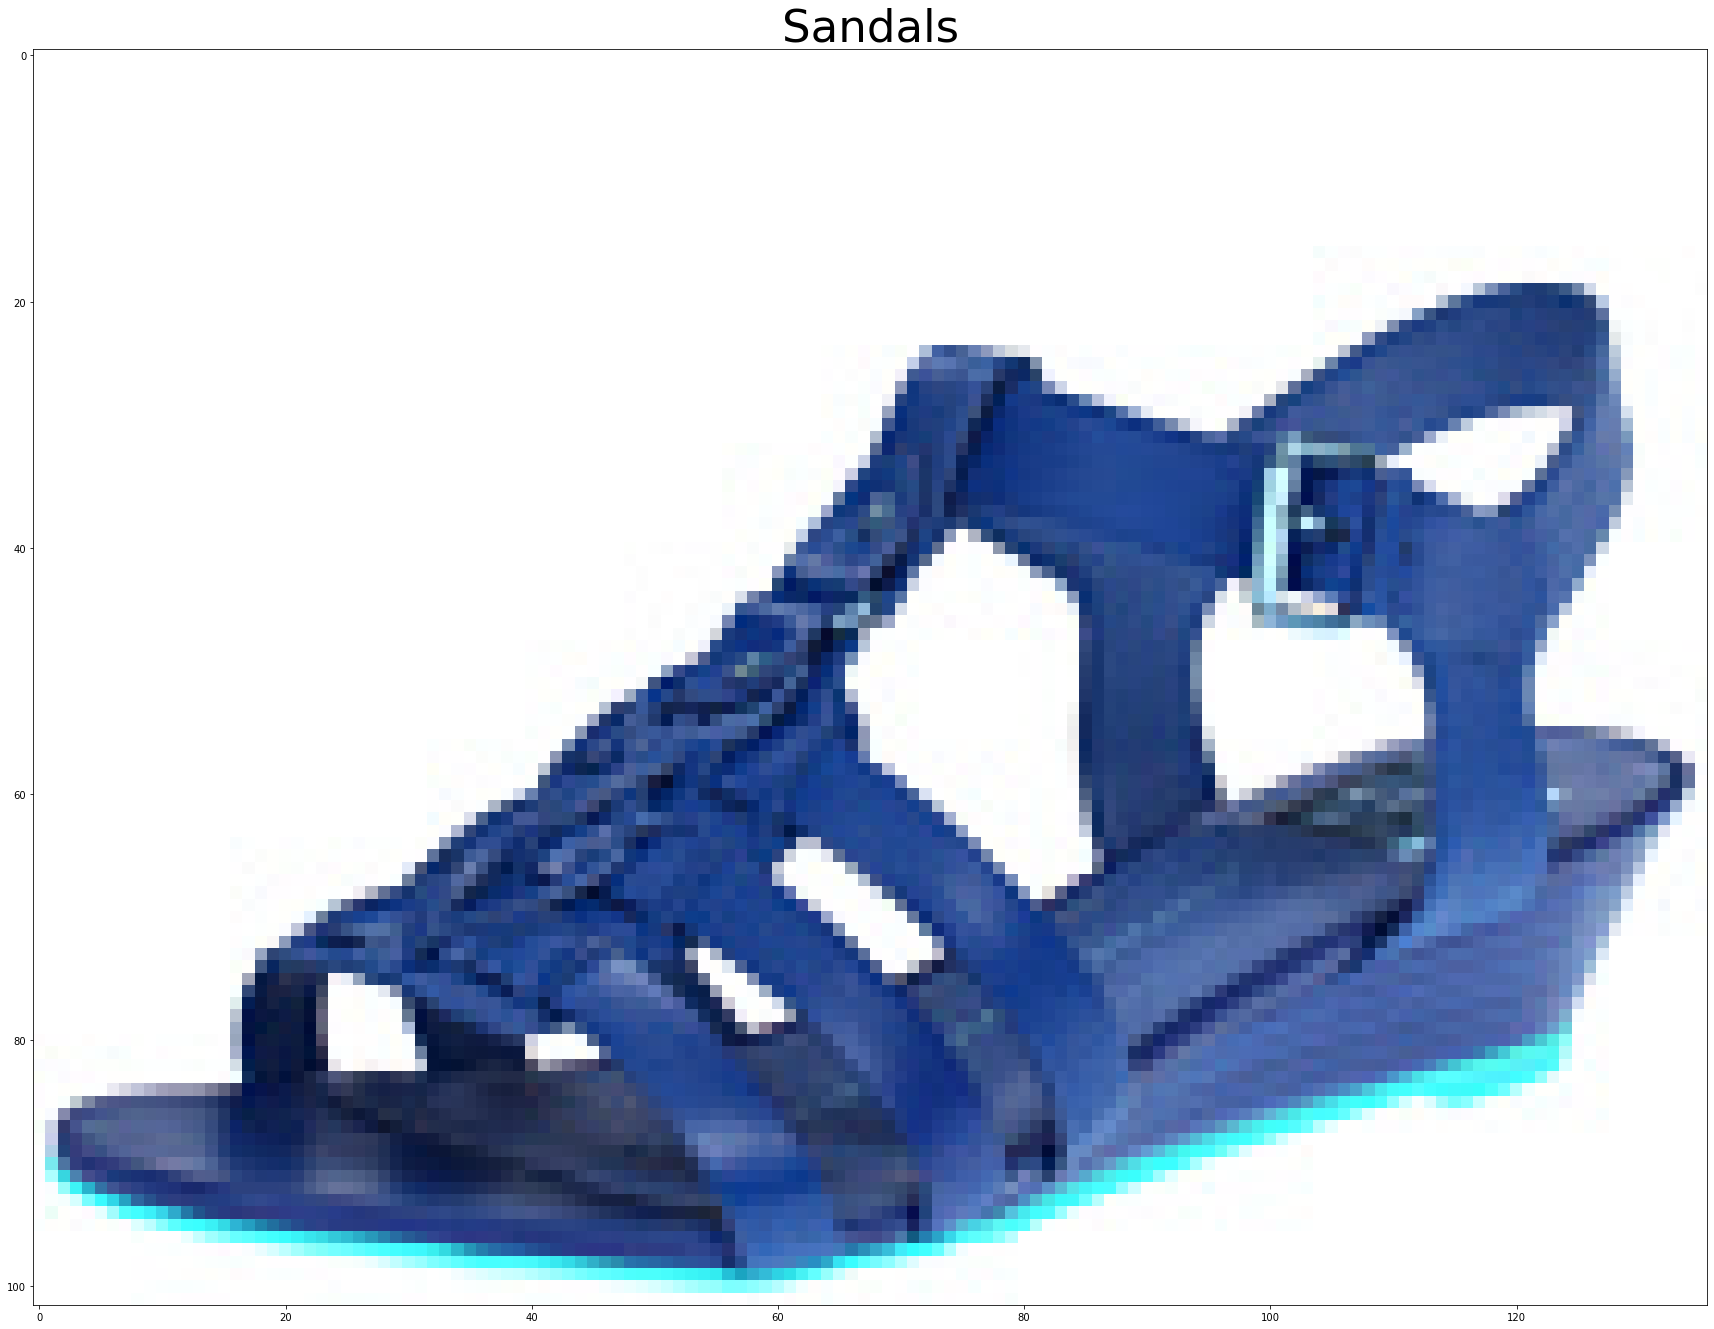

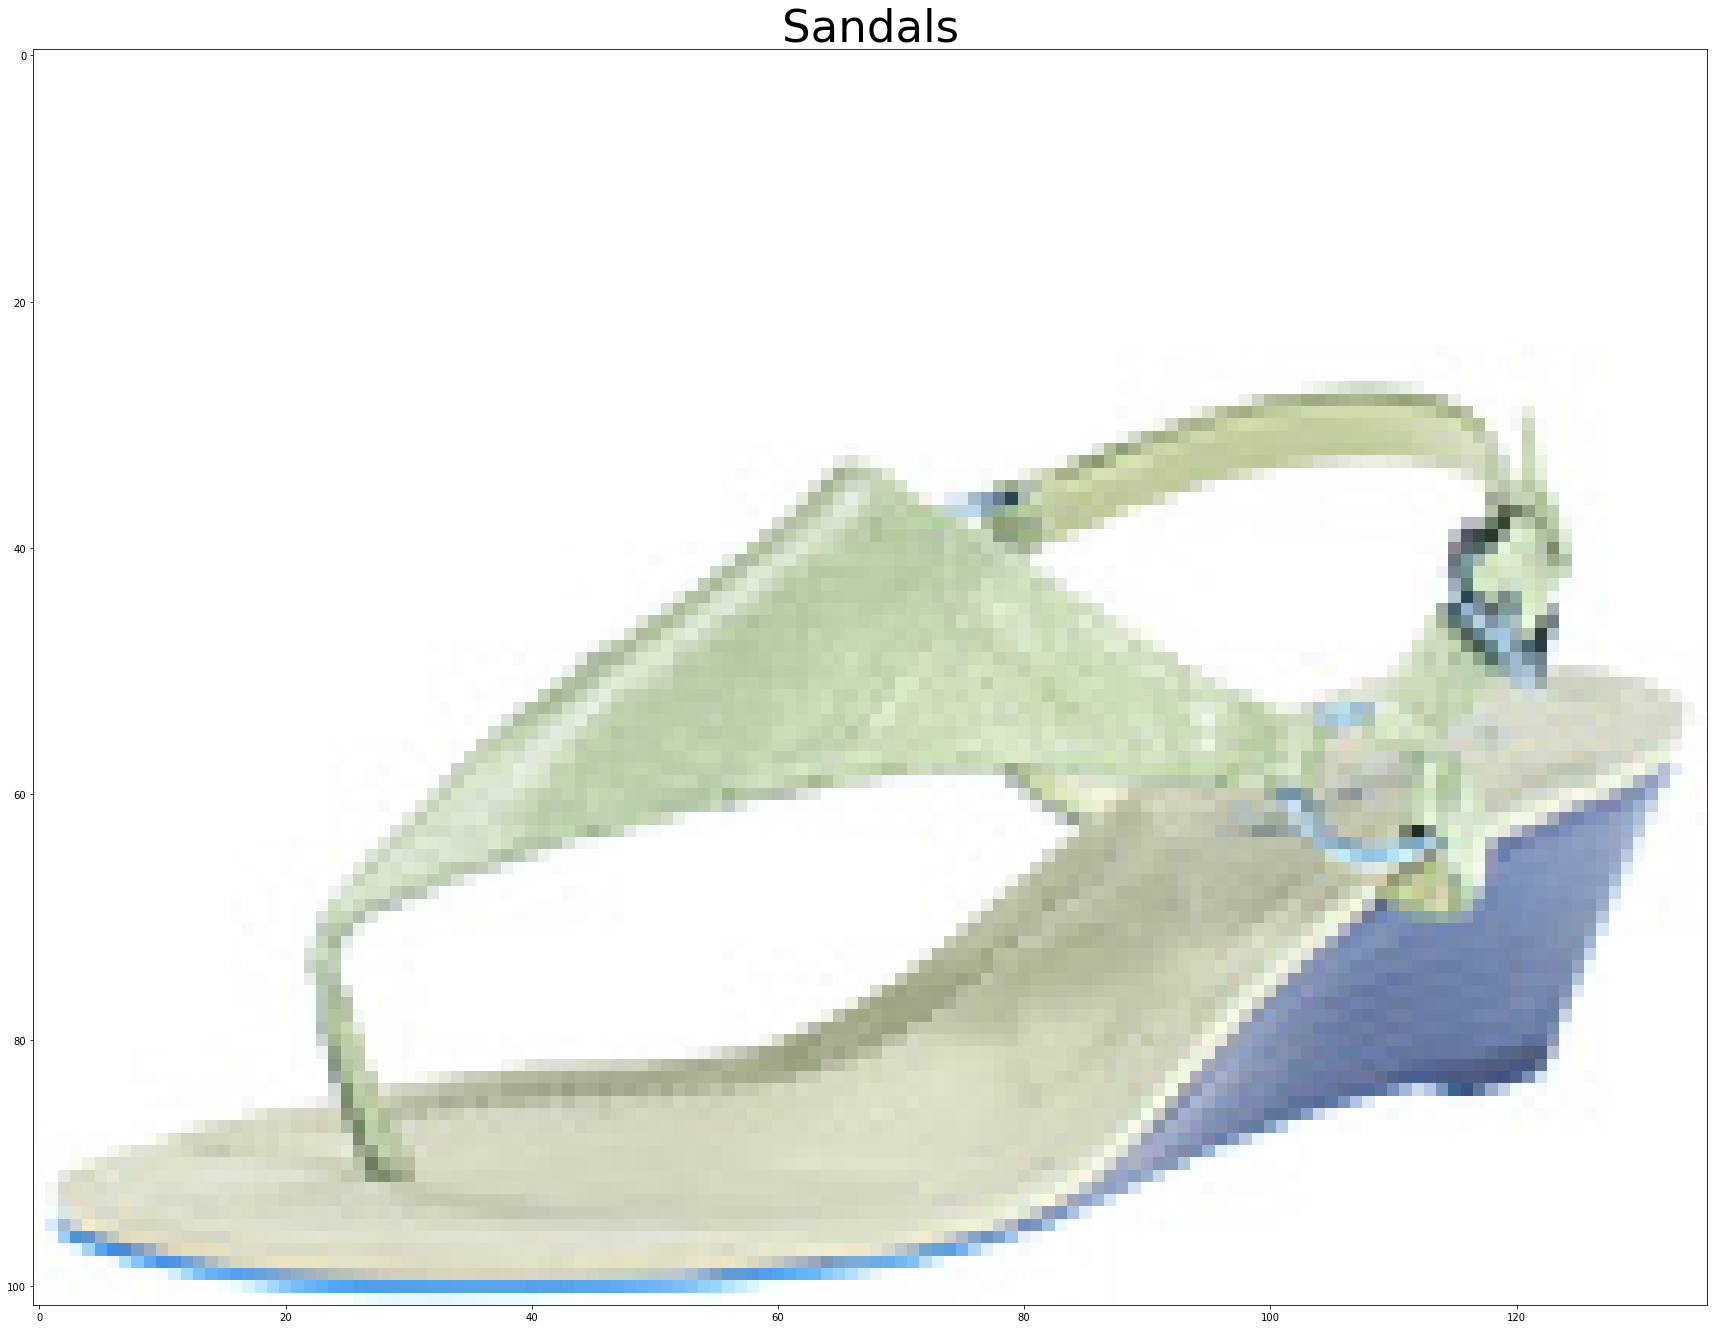

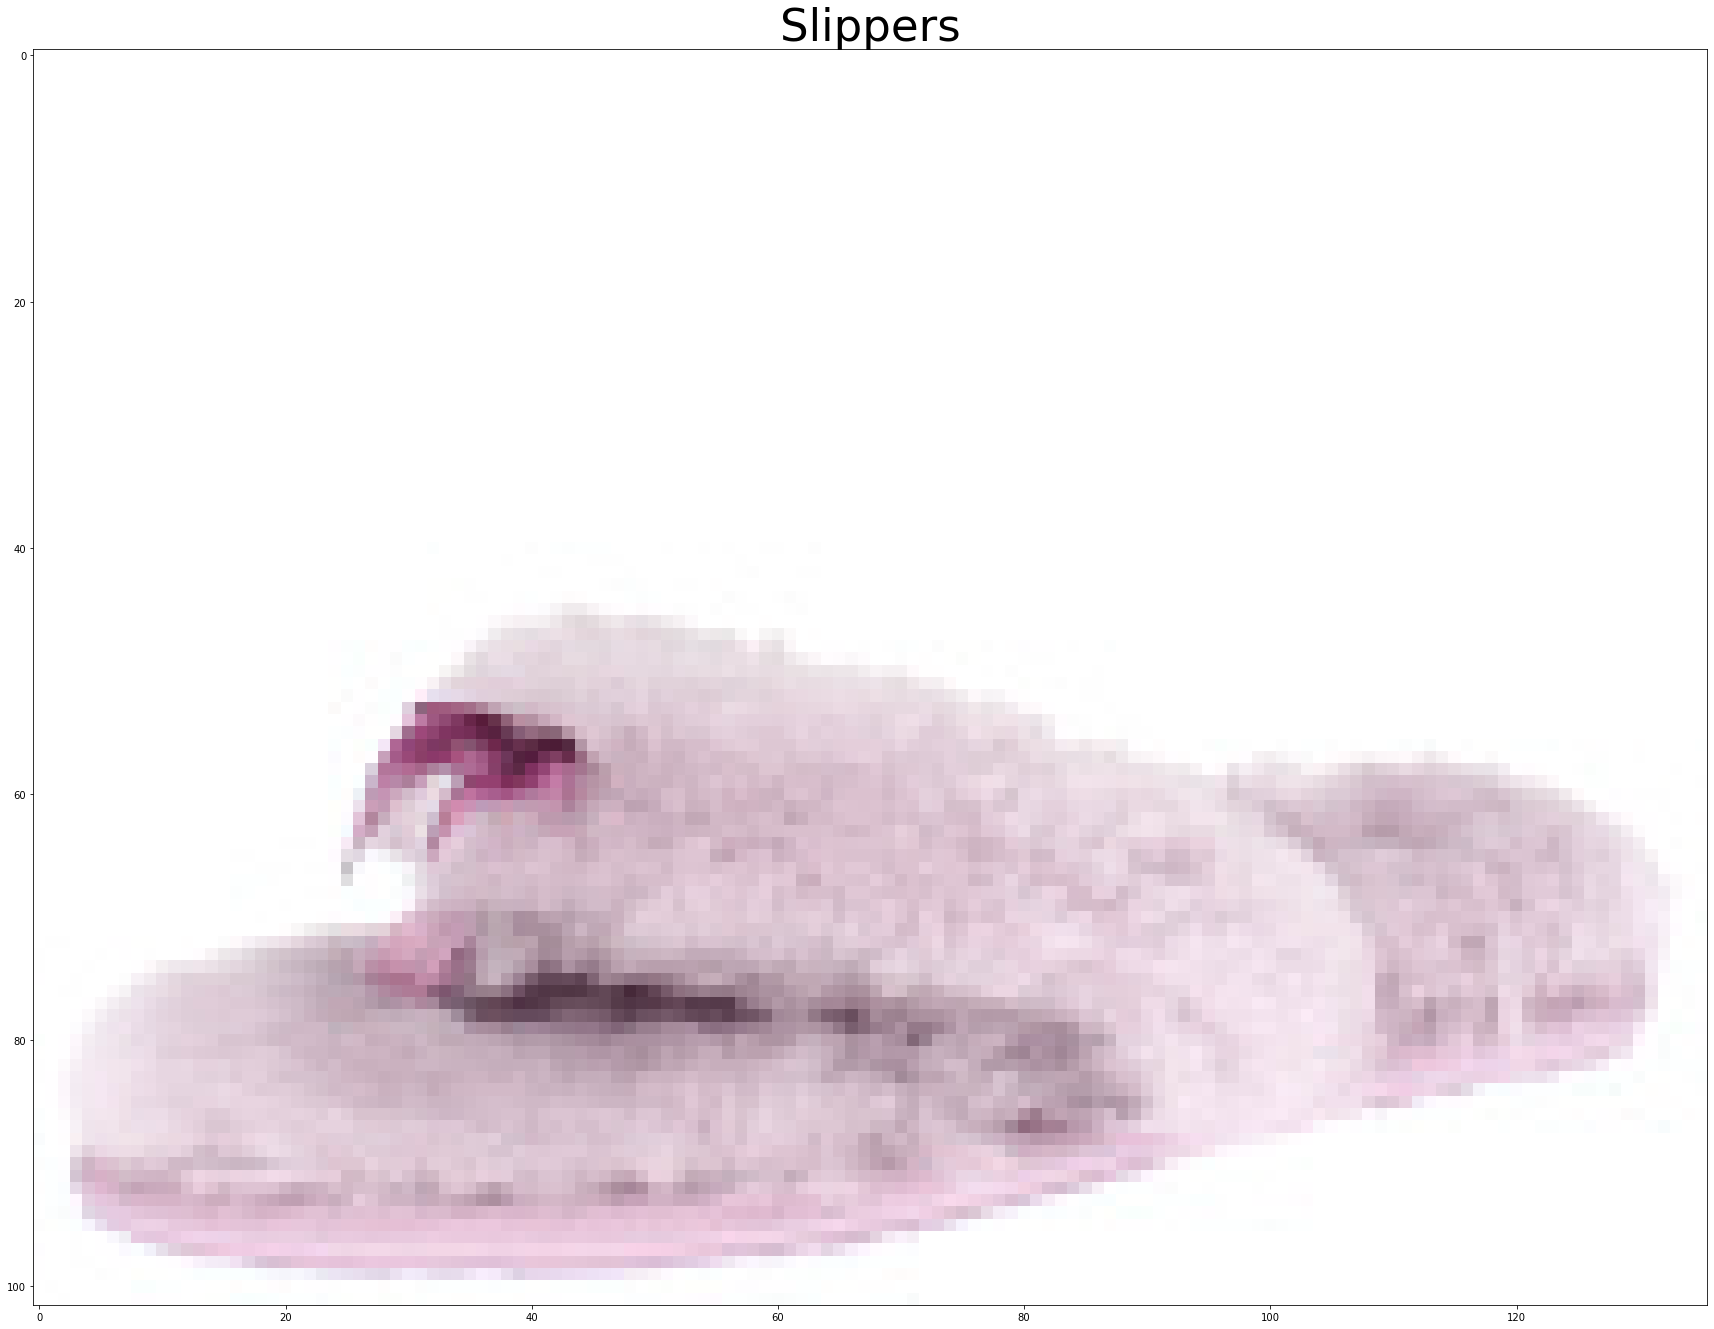

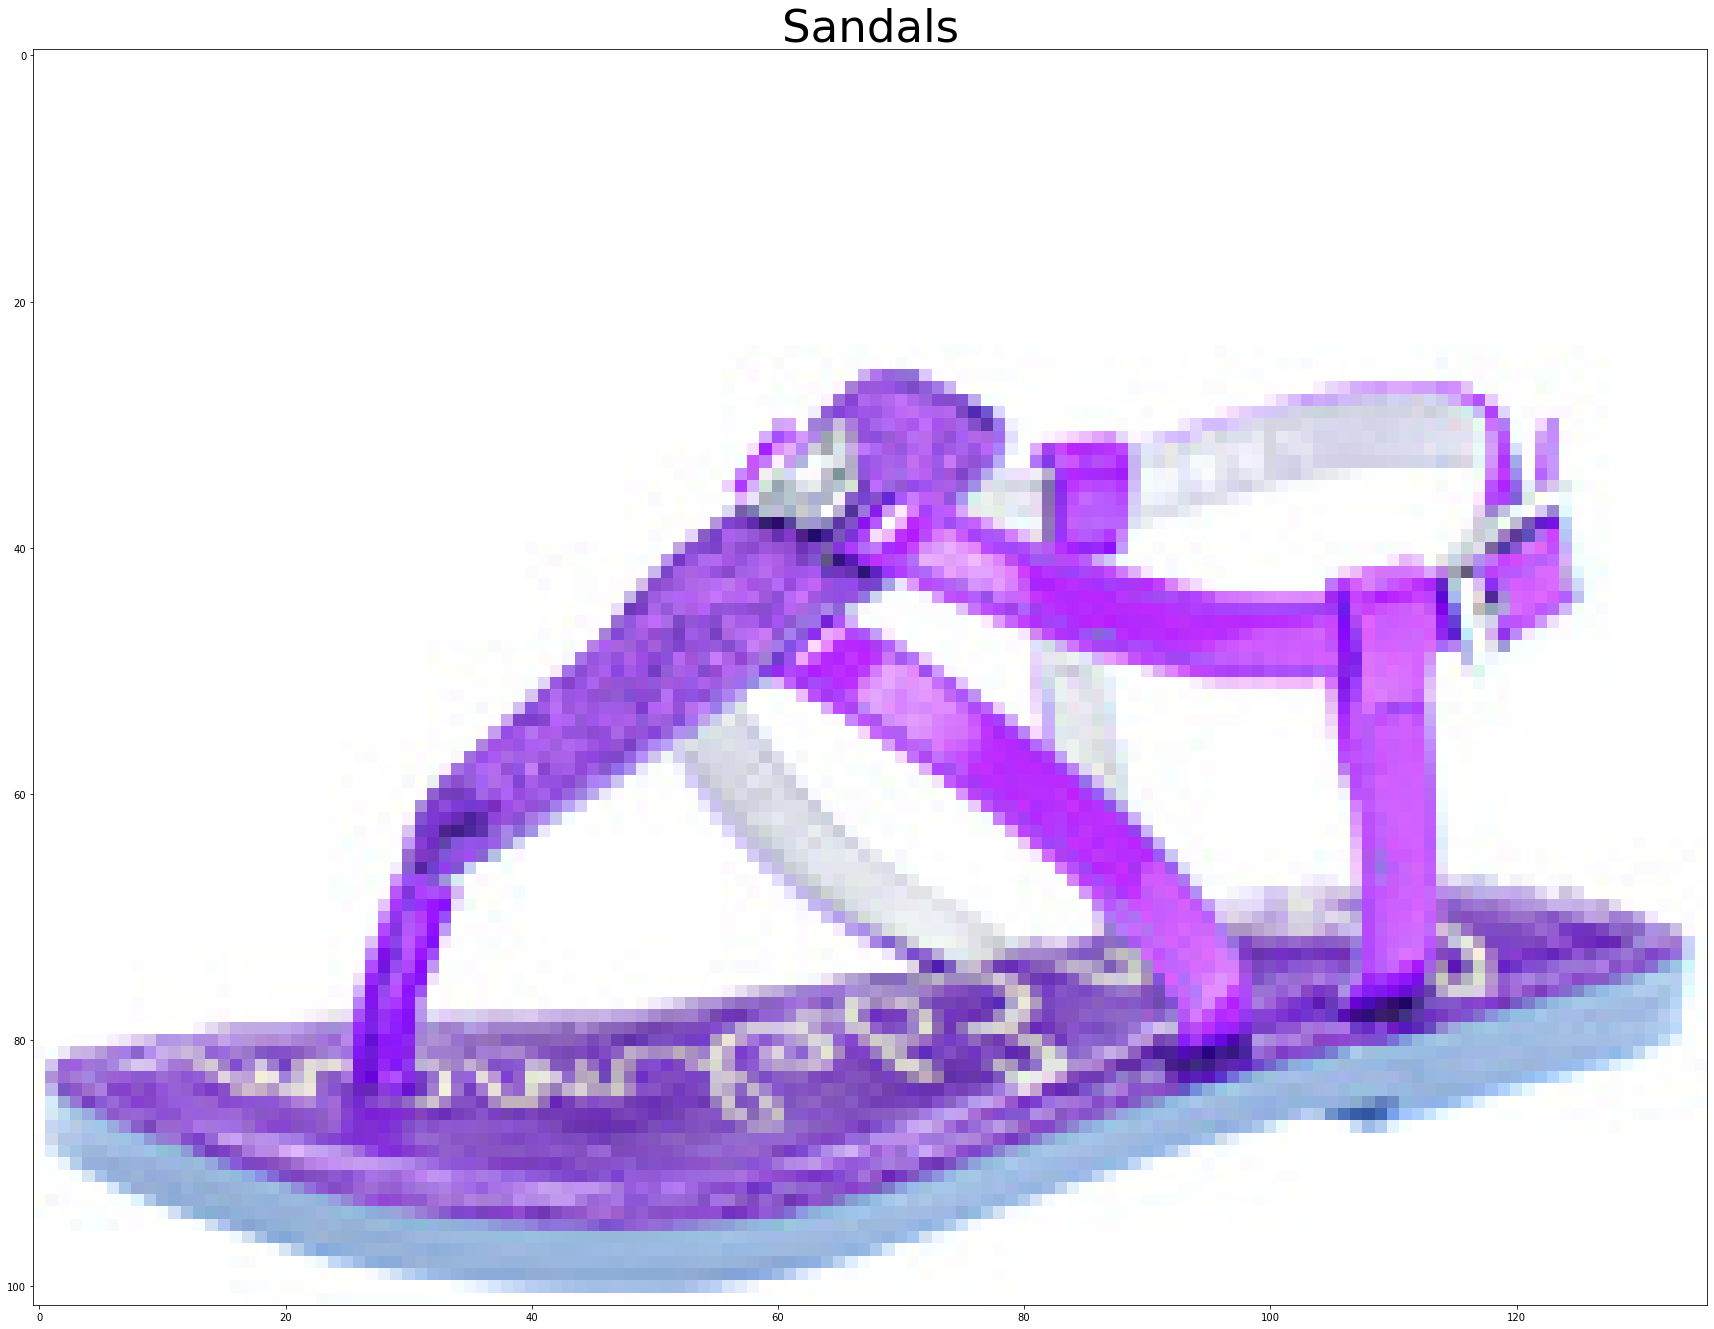

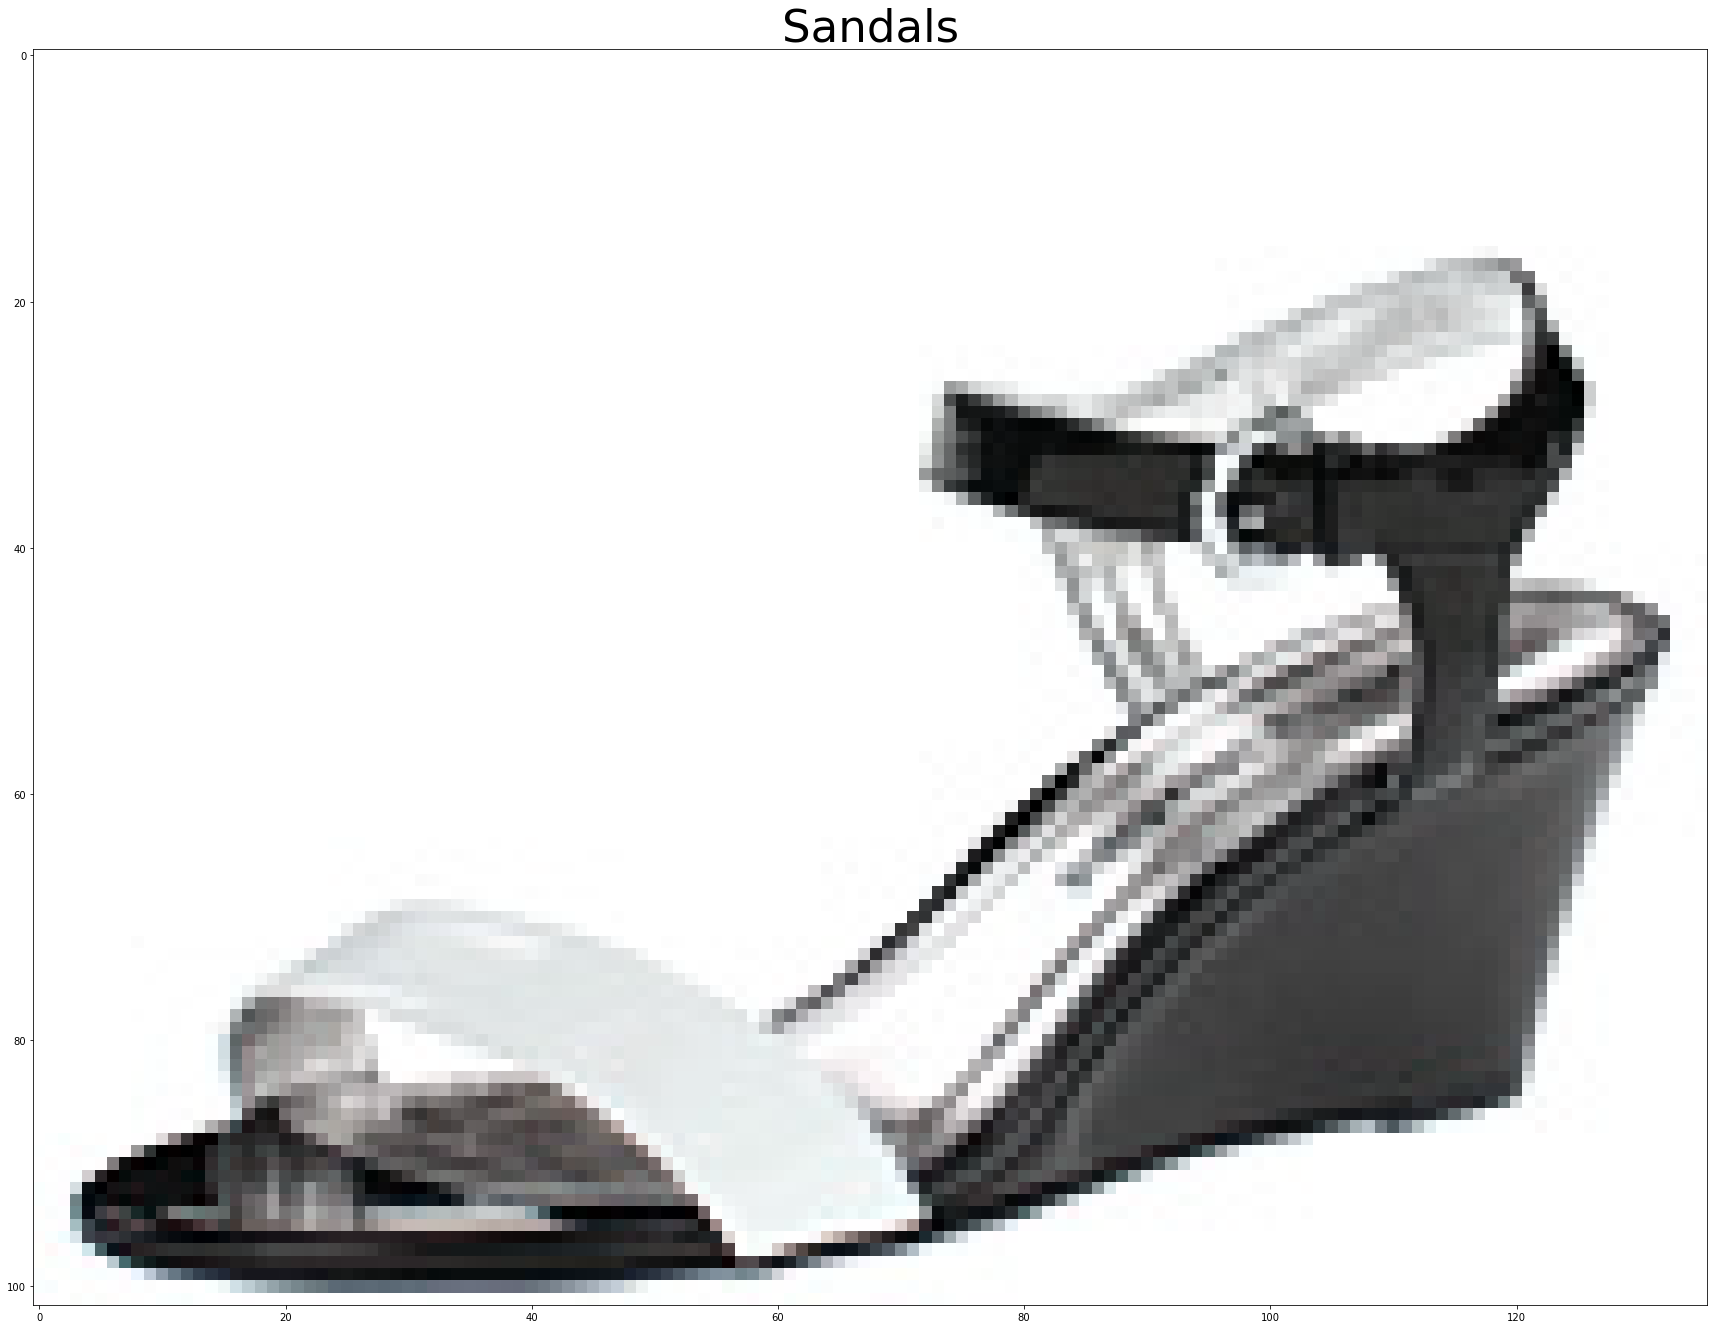

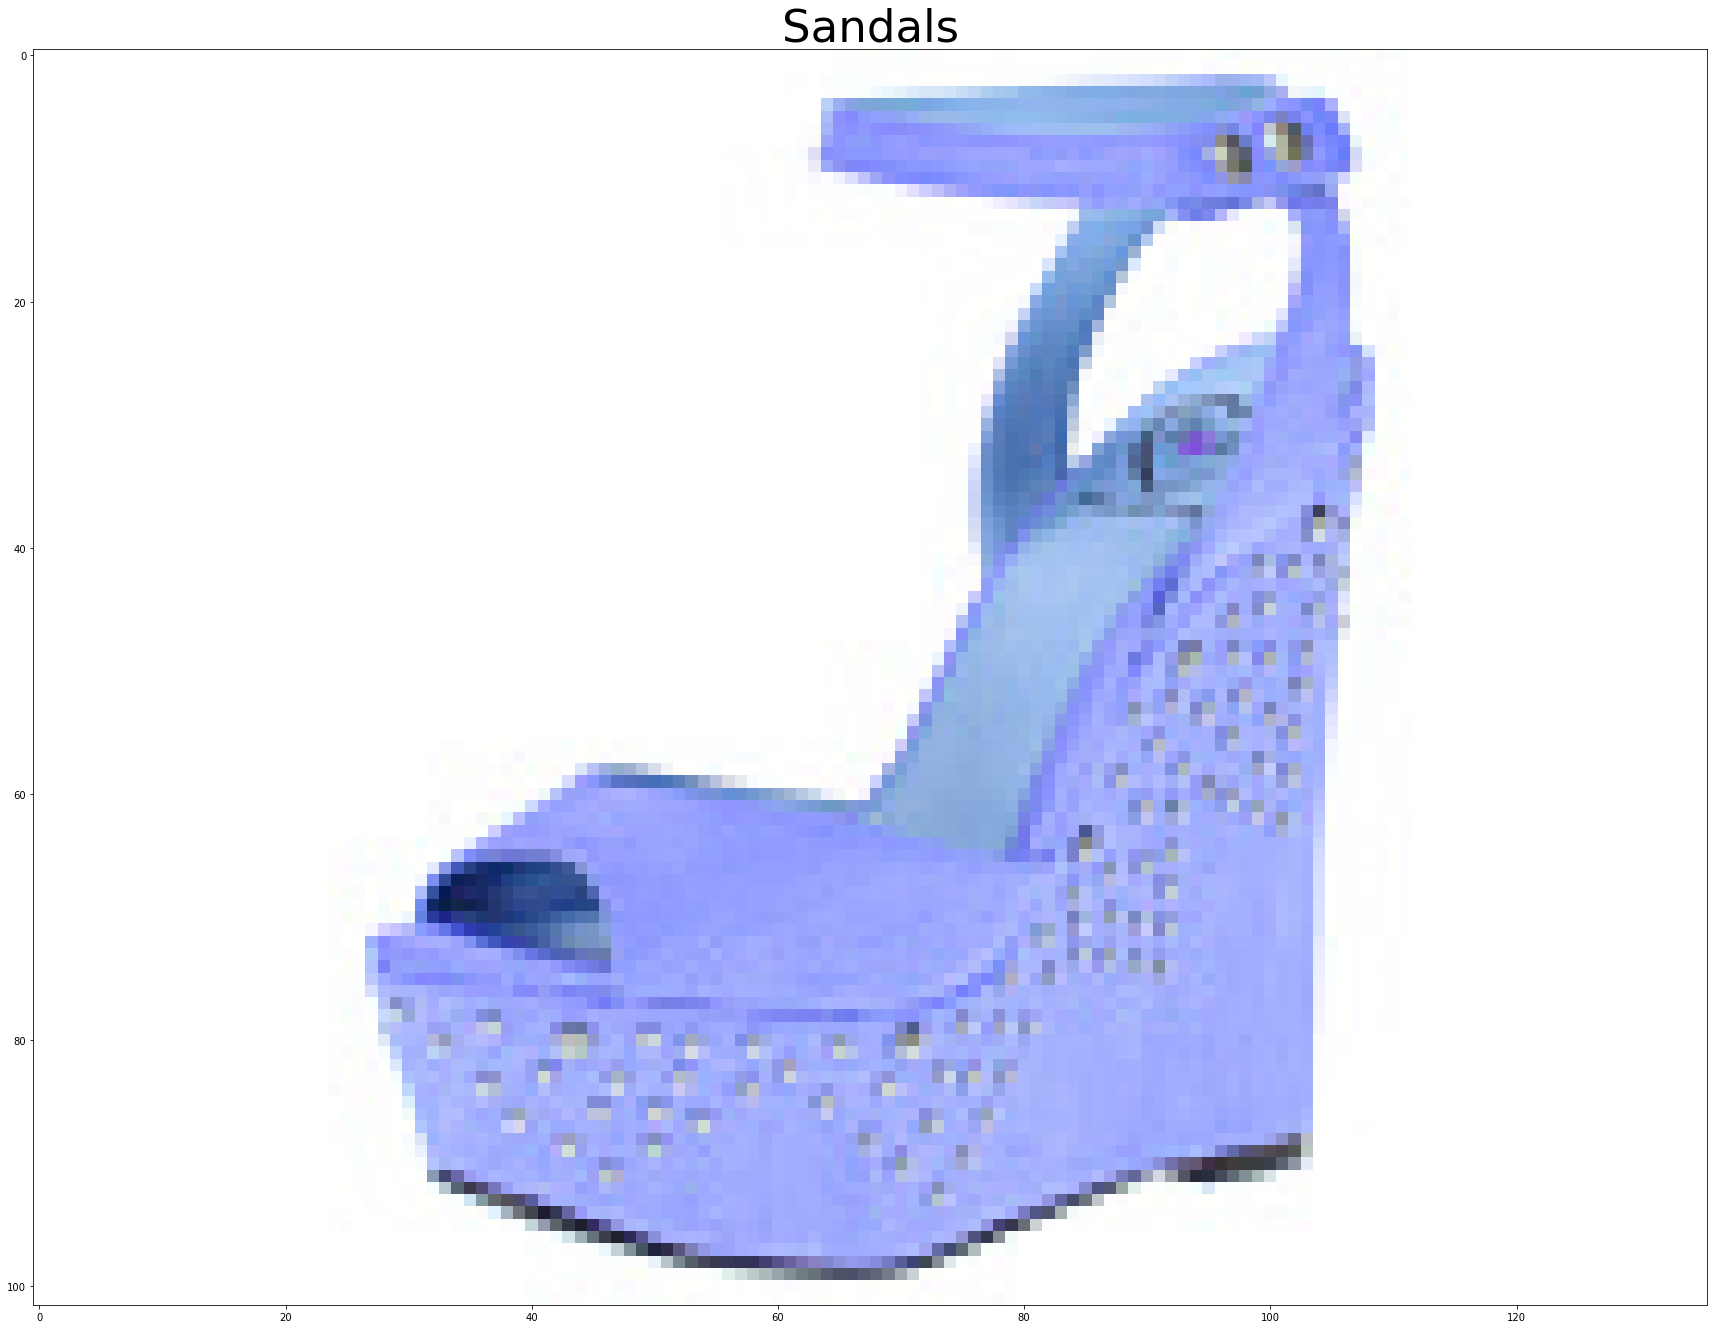

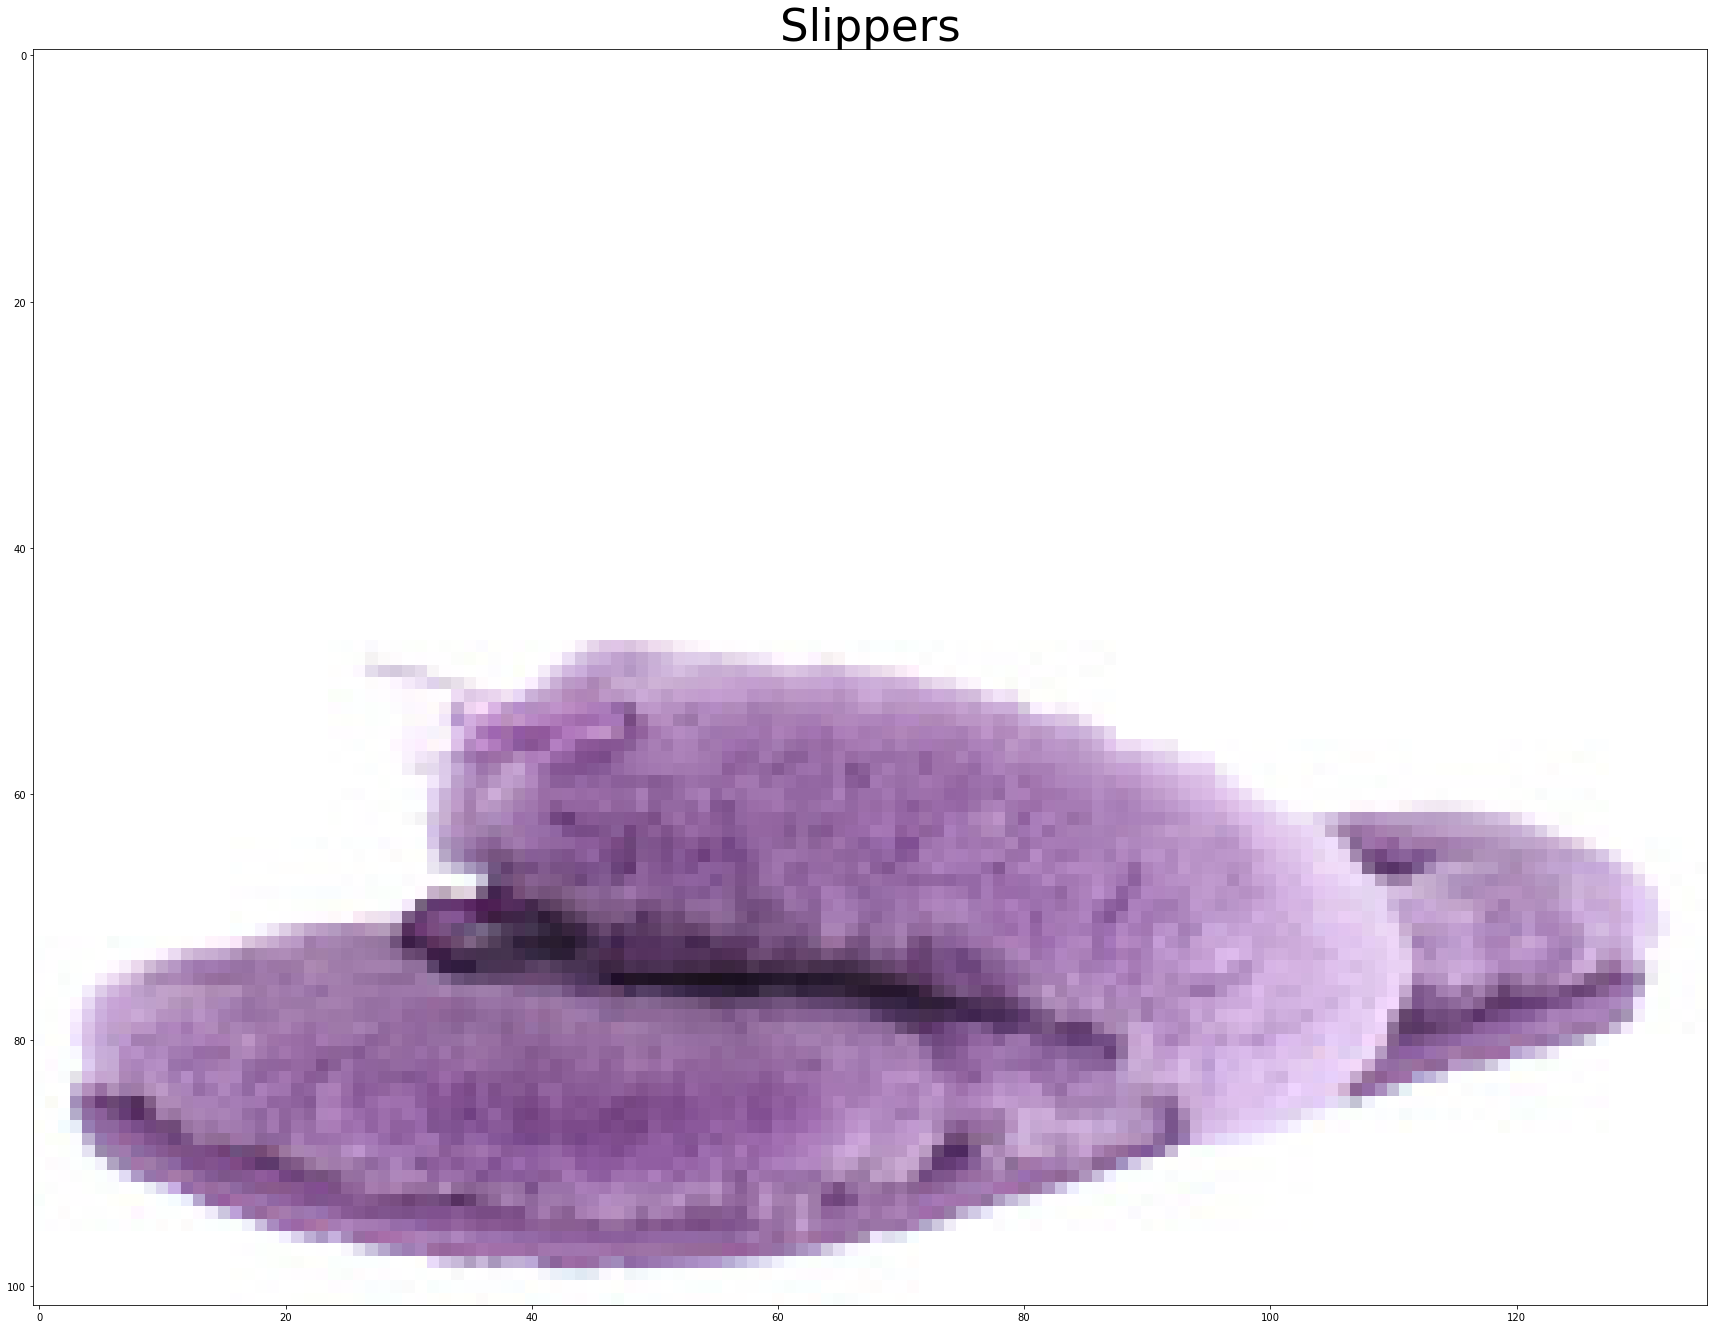

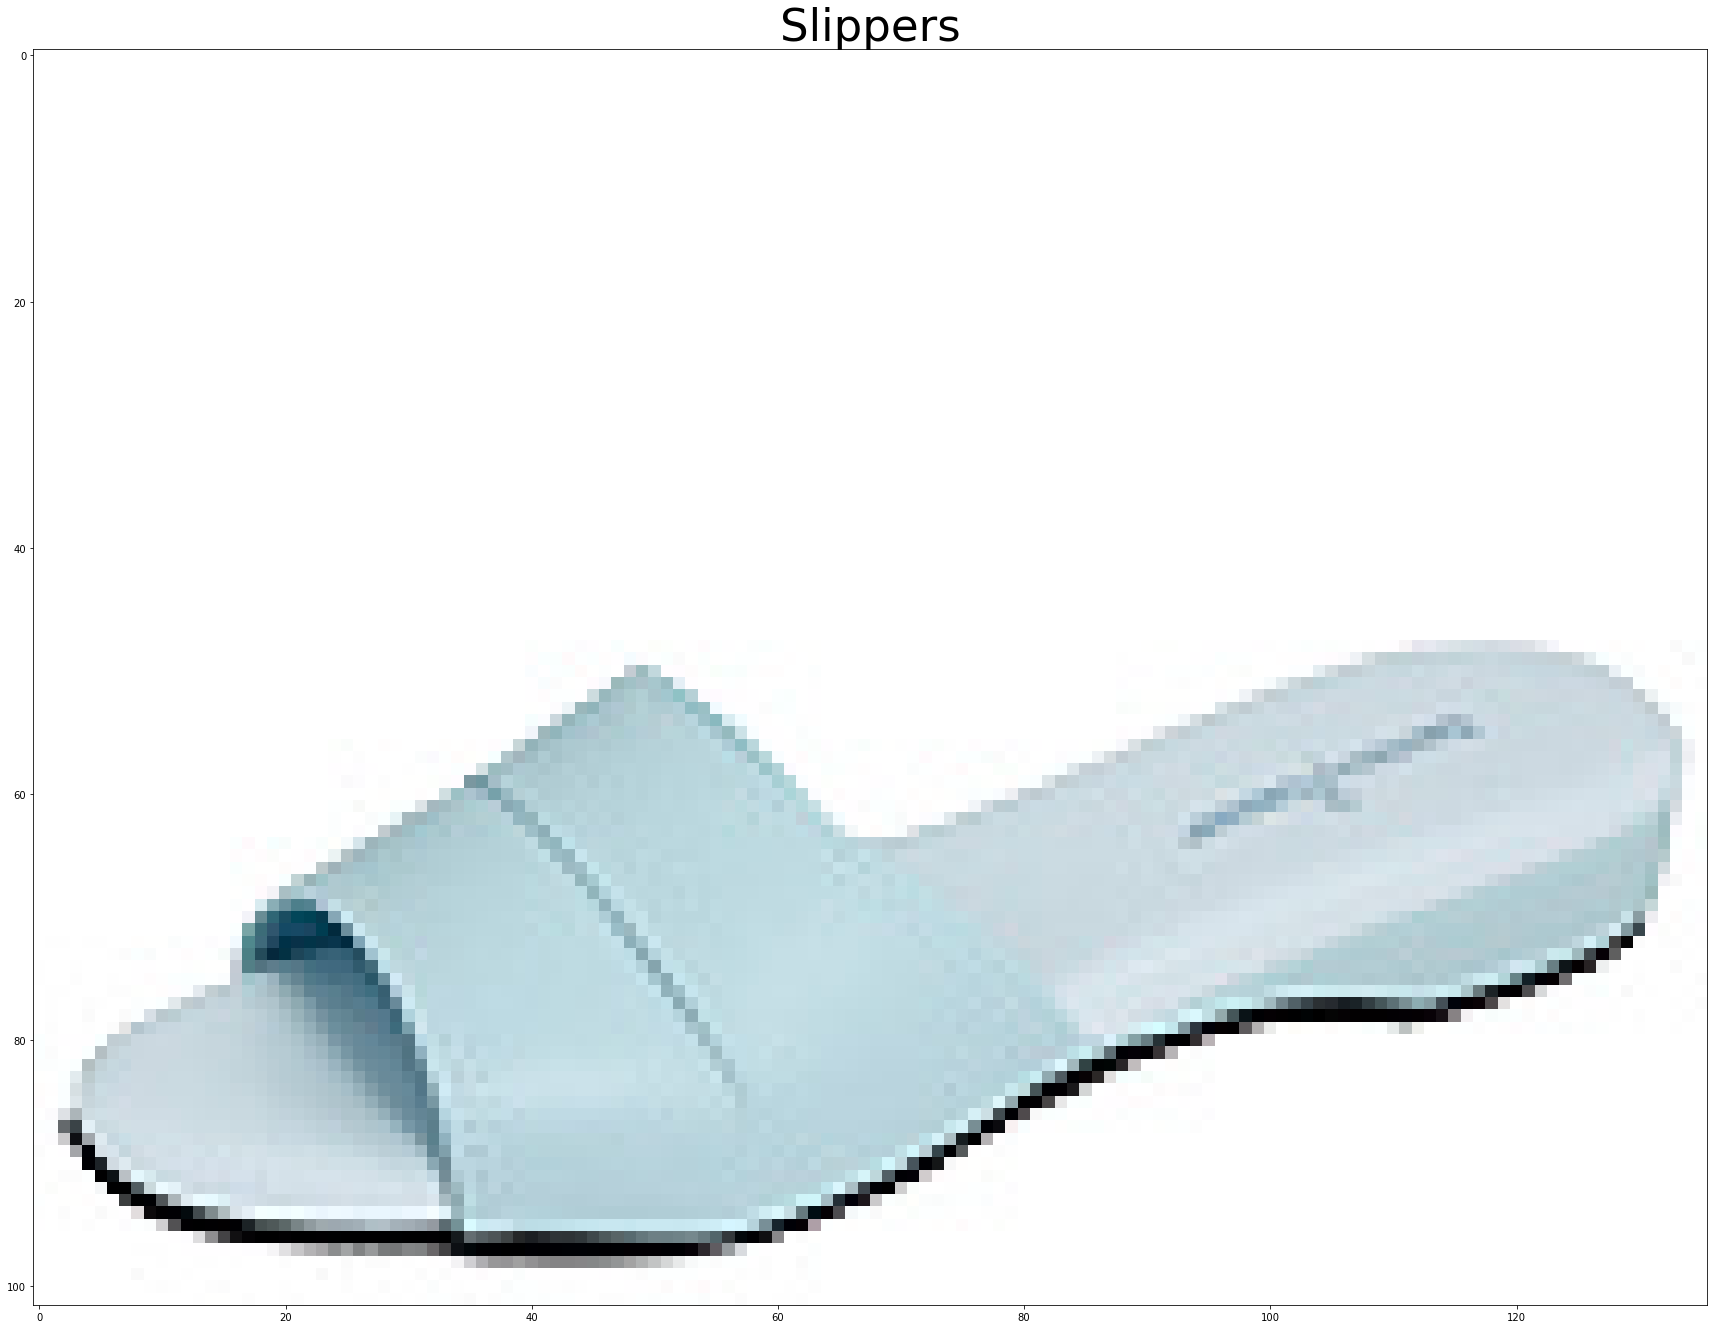

In [21]:
for i in range(len(images)):
    image=images[i]
    image1=cv2.imread(image)
    image=cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image=transform.resize(image,(80,80))
    array_image=np.array(image)
    array_image=array_image.reshape(1,80,80,1)
    preds = model1.predict_classes(array_image)
    preds=preds[0]
    preds=label_map[preds]
    predictions.append(preds)
    plt.figure(figsize=(30,30))
    plt.imshow(image1)
    plt.title('{}'.format(preds),fontsize=45)
    plt.show()

In [26]:
import pandas as pd
predictions=pd.Series(predictions)

#### Final Predictions

In [27]:
predictions.head()

0     Sandals
1       Boots
2       Boots
3    Slippers
4       Boots
dtype: object